# 패키지 다운로드

In [25]:
# pip install netCDF4

# 패키지 로딩

In [58]:
import netCDF4 as nc
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

from matplotlib_inline.backend_inline import set_matplotlib_formats

%matplotlib inline
set_matplotlib_formats('retina')

import tensorflow as tf

import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=UserWarning, module="tensorflow")

# 종속변수(SCTR) 전처리

In [27]:
os.mkdir("./output")

In [55]:
dataset = nc.Dataset('./data/EN.4.2.2_D20_SCTR_f.nc', 'r')

data = dataset.variables["D20_SCTR"][:]
date_range = pd.date_range("1991-01-01", "2024-04-01", freq="MS")

sctr = pd.DataFrame({
    'Date': date_range,
    "D20_SCTR": data
})

sctr.to_csv('./output/SCTR.csv', index=False)

dataset.close()

Date    D20_SCTR
0   1991-01-01   54.960640
1   1991-02-01   59.899442
2   1991-03-01   70.225124
3   1991-04-01   67.375125
4   1991-05-01   63.783066
..         ...         ...
395 2023-12-01  124.376897
396 2024-01-01  117.300079
397 2024-02-01  121.968669
398 2024-03-01  118.355688
399 2024-04-01  108.767079

[400 rows x 2 columns]

# 독립변수 전처리

## IOD
- WTIO  : 동경 50도 ~ 70도, 남위 10도 ~ 북위 10도에서 SST 편차의 평균 
- SETIO : 동경 90도 ~ 110도, 남위 10도 ~ 적도선에서 SST 편차의 평균
- DMI  = WTIO - SETIO

In [36]:
# txt -> csv 변환
IOD = pd.read_csv("./data/IOD.txt", sep="\t", encoding="cp949")

# 날짜 형식 통일
IOD['Date'] = pd.to_datetime(IOD['Year'].astype(str) + '-' + IOD['Month'].astype(str) + '-01')
IOD = IOD.drop(["Year", "Month"], axis = 1)
IOD = IOD[["Date", "WTIO", "SETIO"]]

# DMI(Dipole Mode Index) 컬럼 생성
IOD["DMI"] = IOD["WTIO"] - IOD["SETIO"]

IOD.to_csv("./output/IOD.csv", encoding="utf-8-sig", index=False)

## ONI

In [59]:
# txt -> csv 변환
ONI = pd.read_csv("./data/ONI.txt", sep="\t", encoding="cp949")

# 날짜 형식 통일
ONI['Date'] = pd.to_datetime(ONI['Date'].astype(str) + '-01')

# ENSO 상태 결정 함수
def determine_enso(oni_values):
    if all(oni >= 0.5 for oni in oni_values):
        return 'El Nino'
    elif all(oni <= -0.5 for oni in oni_values):
        return 'La Nina'
    else:
        return 'Neutral'
    
ONI["ENSO"] = "Neutral"

for i in range(400):
    status = determine_enso(ONI.loc[i : i + 4, "ONI"])
    
    ONI["ENSO"].loc[i + 4] = status    

ONI = ONI[4:].reset_index(drop=True)

ONI.to_csv("./output/ONI.csv", encoding="utf-8-sig", index=False)

## SOI
- 남방진동지수, Darwin - Tahiti 사이의 표준화된 해면기압 차이

In [40]:
# txt -> csv 변환
SOI = pd.read_csv("./data/SOI.txt", sep="\t", encoding="cp949")

# 날짜 형식 통일
SOI['Date'] = pd.to_datetime(SOI['Date'].astype(str) + '-01')

SOI.to_csv("./output/SOI.csv", encoding="utf-8-sig", index=False)

## 독립변수 합치기

In [42]:
df = pd.merge(IOD, ONI, on="Date")
df = pd.merge(df, SOI, on="Date")

df.to_csv("./output/IND.csv", encoding="utf-8-sig", index=False)

# 독립변수 불러오기 & 종속변수 합치기

In [57]:
ind = pd.read_csv("./output/IND.csv")

ind["Date"] = pd.to_datetime(ind["Date"])

data = pd.merge(ind, sctr, on="Date").drop("Date", axis = 1)

data.to_csv("./output/data.csv", encoding="cp949", index=False)

# 함수 정의

In [60]:
def multivariate_data(dataset, target, start_index, end_index, history_size, target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size

    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i - history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i + target_size])
            
    return np.array(data), np.array(labels)

In [61]:
def label_split(dataset, start_index, end_index, history_size, target_size, step):
    data = []

    start_index = start_index + history_size

    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i - history_size, i, step)
        data.append(dataset[indices])
        
    return np.array(data)

In [62]:
def plot_train_history(history, function, val_func):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))
    
    plt.figure(figsize=(12, 8))
    
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    
    plt.xlabel("Epoch")
    plt.ylabel(val_func)
    
    plt.title(f"{function} 손실함수 시각화_{val_func}")
    plt.legend()
    plt.grid()
    
    directory = function.split(",")[0]
    
    plt.savefig(f'./output/{directory}/{function}_{val_func}.png')

    plt.show()

# 하이퍼 파라매터 세팅

In [63]:
# 전체 데이터 길이
total_length = len(data)

# 학습(0.7) - 검증(0.2) - 테스트(0.1) 데이터 분리
TRAIN_SPLIT = int(total_length * 0.7)
VAL_SPLIT = int(total_length * 0.2)
TEST_SPLIT = total_length - TRAIN_SPLIT - VAL_SPLIT

# 12개월 학습 - 12개월 예측
past_history = 12
future_target = 12
STEP = 1

BATCH_SIZE = 16
EPOCHS = 300

tf.keras.utils.set_random_seed(42)

# ENSO Label Encoding

In [64]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

data['ENSO'] = le.fit_transform(data['ENSO'])

# 인코딩 매핑 확인
encoding_map = dict(zip(le.classes_, le.transform(le.classes_)))
print("인코딩 매핑:")
print(encoding_map)

인코딩 매핑:
{'El Nino': 0, 'La Nina': 1, 'Neutral': 2}


# Case1) WTIO, SETIO & 표준화

## 데이터 전처리

In [65]:
os.mkdir("./output/case1")

case1_df = data[['WTIO', 'SETIO', 'ONI', 'SOI', 'ENSO', 'D20_SCTR']]

case1_dts = case1_df.values

case1_label = case1_dts[ : , 4]
case1_dts = case1_dts[ : , [0, 1, 2, 3, 5]]

case1_mean = case1_dts.mean(axis=0)
case1_std = case1_dts.std(axis=0)
case1_dts = (case1_dts-case1_mean)/case1_std

## 데이터 분리

In [66]:
# 학습 데이터
x_train_multi, y_train_multi = multivariate_data(case1_dts, case1_dts[:, -1], 0, TRAIN_SPLIT - future_target, past_history, future_target, STEP)

x_train_label = label_split(case1_label, 0, TRAIN_SPLIT - future_target, past_history, future_target, STEP)

# 검증 데이터
x_val_multi, y_val_multi = multivariate_data(case1_dts, case1_dts[:, -1], TRAIN_SPLIT, TRAIN_SPLIT + VAL_SPLIT - future_target, past_history, future_target, STEP)

x_val_label = label_split(case1_label, TRAIN_SPLIT, TRAIN_SPLIT + VAL_SPLIT - future_target, past_history, future_target, STEP)

# 테스트 데이터
x_test_case1, y_test_case1 = multivariate_data(case1_dts, case1_dts[:, -1], TRAIN_SPLIT + VAL_SPLIT, None, past_history, future_target, STEP)

x_test_case1_label = label_split(case1_label, TRAIN_SPLIT + VAL_SPLIT, None, past_history, future_target, STEP)

## 모델 학습

### 단방향 LSTM

Epoch 1/300
16/16 [==============================] - 4s 64ms/step - loss: 22.0844 - val_loss: 20.9260 - lr: 5.0000e-04
Epoch 2/300
16/16 [==============================] - 0s 13ms/step - loss: 20.4674 - val_loss: 19.4694 - lr: 5.0000e-04
Epoch 3/300
16/16 [==============================] - 0s 13ms/step - loss: 18.9586 - val_loss: 18.0418 - lr: 5.0000e-04
Epoch 4/300
16/16 [==============================] - 0s 12ms/step - loss: 17.5272 - val_loss: 16.6730 - lr: 5.0000e-04
Epoch 5/300
16/16 [==============================] - 0s 13ms/step - loss: 16.1581 - val_loss: 15.3629 - lr: 5.0000e-04
Epoch 6/300
16/16 [==============================] - 0s 13ms/step - loss: 14.8442 - val_loss: 14.1189 - lr: 5.0000e-04
Epoch 7/300
16/16 [==============================] - 0s 13ms/step - loss: 13.6039 - val_loss: 12.9455 - lr: 5.0000e-04
Epoch 8/300
16/16 [==============================] - 0s 12ms/step - loss: 12.4676 - val_loss: 11.8478 - lr: 5.0000e-04
Epoch 9/300
16/16 [=============================

16/16 [==============================] - 0s 12ms/step - loss: 1.5331 - val_loss: 1.5894 - lr: 5.0000e-04
Epoch 71/300
16/16 [==============================] - 0s 12ms/step - loss: 1.5082 - val_loss: 1.5651 - lr: 5.0000e-04
Epoch 72/300
16/16 [==============================] - 0s 12ms/step - loss: 1.5014 - val_loss: 1.5826 - lr: 5.0000e-04
Epoch 73/300
16/16 [==============================] - 0s 12ms/step - loss: 1.4875 - val_loss: 1.5451 - lr: 5.0000e-04
Epoch 74/300
16/16 [==============================] - 0s 11ms/step - loss: 1.4607 - val_loss: 1.5508 - lr: 5.0000e-04
Epoch 75/300
16/16 [==============================] - 0s 11ms/step - loss: 1.4614 - val_loss: 1.5207 - lr: 5.0000e-04
Epoch 76/300
16/16 [==============================] - 0s 12ms/step - loss: 1.4396 - val_loss: 1.5191 - lr: 5.0000e-04
Epoch 77/300
16/16 [==============================] - 0s 13ms/step - loss: 1.4254 - val_loss: 1.5322 - lr: 5.0000e-04
Epoch 78/300
16/16 [==============================] - 0s 12ms/step - 

16/16 [==============================] - 0s 11ms/step - loss: 0.7525 - val_loss: 0.8580 - lr: 5.0000e-04
Epoch 140/300
16/16 [==============================] - 0s 12ms/step - loss: 0.7351 - val_loss: 0.8476 - lr: 5.0000e-04
Epoch 141/300
16/16 [==============================] - 0s 11ms/step - loss: 0.7402 - val_loss: 0.8724 - lr: 5.0000e-04
Epoch 142/300
16/16 [==============================] - 0s 11ms/step - loss: 0.7202 - val_loss: 0.8604 - lr: 5.0000e-04
Epoch 143/300
16/16 [==============================] - 0s 12ms/step - loss: 0.7151 - val_loss: 0.8922 - lr: 5.0000e-04
Epoch 144/300
16/16 [==============================] - 0s 12ms/step - loss: 0.7095 - val_loss: 0.8280 - lr: 5.0000e-04
Epoch 145/300
16/16 [==============================] - 0s 12ms/step - loss: 0.6902 - val_loss: 0.8196 - lr: 5.0000e-04
Epoch 146/300
16/16 [==============================] - 0s 11ms/step - loss: 0.6967 - val_loss: 0.8674 - lr: 5.0000e-04
Epoch 147/300
16/16 [==============================] - 0s 12ms

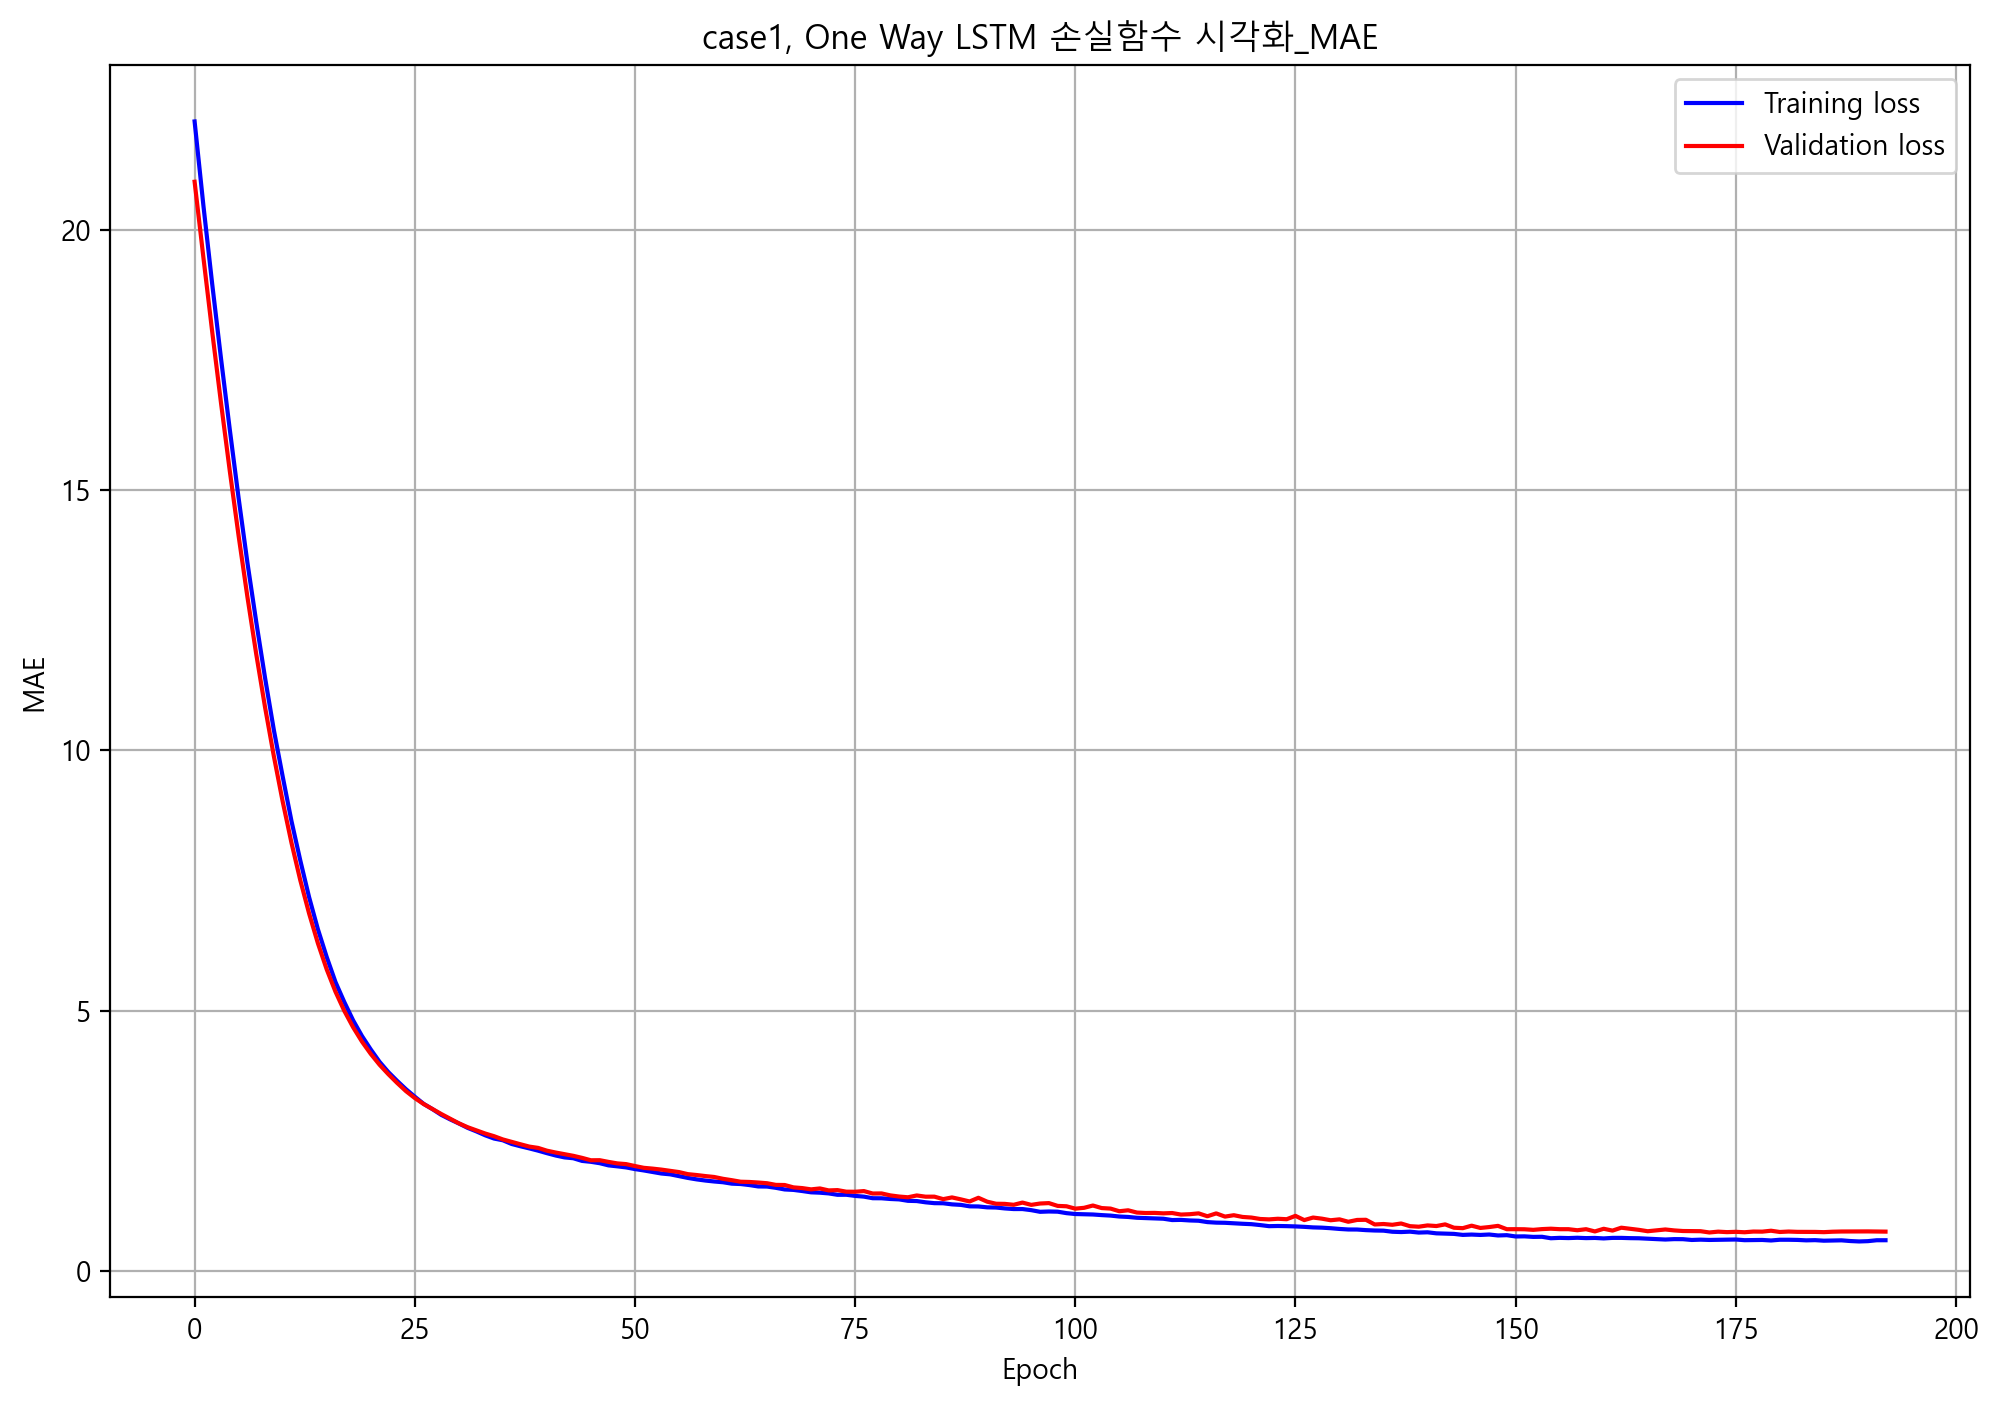

In [67]:
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization, Input, Embedding, Concatenate, Attention
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import legacy as legacy_optimizers

# Attention 레이어 정의
def attention_layer(inputs):
    attention = Attention()([inputs, inputs])
    return Concatenate()([inputs, attention])

# 옵티마이저 설정
initial_lr = 0.0005
optimizer = legacy_optimizers.Adam(learning_rate=initial_lr)

# 범주형 변수 설정
num_categories = 3
embedding_dim = 5

# 옵티마이저 및 콜백 설정
optimizer = Adam(learning_rate=initial_lr)
lr_restart = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# 모델 정의
numerical_input = Input(shape=(x_train_multi.shape[1], x_train_multi.shape[2]))
categorical_input = Input(shape=(x_train_label.shape[1], ))

# 임베딩 레이어
embedding = Embedding(input_dim=num_categories, output_dim=embedding_dim)(categorical_input)

# 입력 결합
combined_input = Concatenate(axis=-1)([numerical_input, embedding])

x = LSTM(128, return_sequences=True,
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(combined_input)
x = BatchNormalization()(x)
x = Dropout(0.3, seed=40)(x)

x = LSTM(64, return_sequences=True,
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3, seed=41)(x)

x = attention_layer(x)

x = LSTM(32, activation='relu',
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3, seed=42)(x)

x = Dense(24, activation='relu')(x)
output = Dense(12)(x)

case1_uni_mae = Model(inputs=[numerical_input, categorical_input], outputs=output)

case1_uni_mae.compile(optimizer=optimizer, loss="mae")

# 모델 학습
case1_uni_mae_history = case1_uni_mae.fit(
    [x_train_multi, x_train_label],  
    y_train_multi,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    steps_per_epoch = x_train_multi.shape[0] // BATCH_SIZE, 
    validation_steps = x_val_multi.shape[0] // BATCH_SIZE,
    validation_data=([x_val_multi, x_val_label], y_val_multi),
    callbacks=[lr_restart, early_stop]
)

# 학습 결과 시각화
plot_train_history(case1_uni_mae_history, "case1, One Way LSTM", "MAE")

# 모델 저장
case1_uni_mae.save("./output/case1/case1_uni_mae.h5")

Epoch 1/300
16/16 [==============================] - 4s 55ms/step - loss: 22.7322 - val_loss: 21.7354 - lr: 5.0000e-04
Epoch 2/300
16/16 [==============================] - 0s 12ms/step - loss: 21.5461 - val_loss: 20.7873 - lr: 5.0000e-04
Epoch 3/300
16/16 [==============================] - 0s 12ms/step - loss: 20.4779 - val_loss: 19.8107 - lr: 5.0000e-04
Epoch 4/300
16/16 [==============================] - 0s 12ms/step - loss: 19.4006 - val_loss: 18.8265 - lr: 5.0000e-04
Epoch 5/300
16/16 [==============================] - 0s 12ms/step - loss: 18.4091 - val_loss: 17.8455 - lr: 5.0000e-04
Epoch 6/300
16/16 [==============================] - 0s 12ms/step - loss: 17.3506 - val_loss: 16.8861 - lr: 5.0000e-04
Epoch 7/300
16/16 [==============================] - 0s 12ms/step - loss: 16.3166 - val_loss: 15.9406 - lr: 5.0000e-04
Epoch 8/300
16/16 [==============================] - 0s 12ms/step - loss: 15.3643 - val_loss: 15.0224 - lr: 5.0000e-04
Epoch 9/300
16/16 [=============================

16/16 [==============================] - 0s 12ms/step - loss: 1.6740 - val_loss: 2.0468 - lr: 5.0000e-04
Epoch 71/300
16/16 [==============================] - 0s 12ms/step - loss: 1.6347 - val_loss: 2.0630 - lr: 5.0000e-04
Epoch 72/300
16/16 [==============================] - 0s 12ms/step - loss: 1.6281 - val_loss: 1.9951 - lr: 5.0000e-04
Epoch 73/300
16/16 [==============================] - 0s 11ms/step - loss: 1.6173 - val_loss: 2.0946 - lr: 5.0000e-04
Epoch 74/300
16/16 [==============================] - 0s 11ms/step - loss: 1.5718 - val_loss: 2.0011 - lr: 5.0000e-04
Epoch 75/300
16/16 [==============================] - 0s 12ms/step - loss: 1.5765 - val_loss: 1.9261 - lr: 5.0000e-04
Epoch 76/300
16/16 [==============================] - 0s 11ms/step - loss: 1.5485 - val_loss: 1.8924 - lr: 5.0000e-04
Epoch 77/300
16/16 [==============================] - 0s 12ms/step - loss: 1.5324 - val_loss: 2.0173 - lr: 5.0000e-04
Epoch 78/300
16/16 [==============================] - 0s 12ms/step - 

16/16 [==============================] - 0s 11ms/step - loss: 0.7717 - val_loss: 1.2410 - lr: 2.5000e-04
Epoch 139/300
16/16 [==============================] - 0s 11ms/step - loss: 0.7657 - val_loss: 1.2965 - lr: 2.5000e-04
Epoch 140/300
13/16 [=======================>......] - ETA: 0s - loss: 0.7540
Epoch 140: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
16/16 [==============================] - 0s 11ms/step - loss: 0.7551 - val_loss: 1.3031 - lr: 2.5000e-04
Epoch 141/300
16/16 [==============================] - 0s 11ms/step - loss: 0.7572 - val_loss: 1.2608 - lr: 1.2500e-04
Epoch 142/300
16/16 [==============================] - 0s 11ms/step - loss: 0.7202 - val_loss: 1.2226 - lr: 1.2500e-04
Epoch 143/300
16/16 [==============================] - 0s 11ms/step - loss: 0.7246 - val_loss: 1.2231 - lr: 1.2500e-04
Epoch 144/300
16/16 [==============================] - 0s 12ms/step - loss: 0.7379 - val_loss: 1.2506 - lr: 1.2500e-04
Epoch 145/300
16/16 [==================

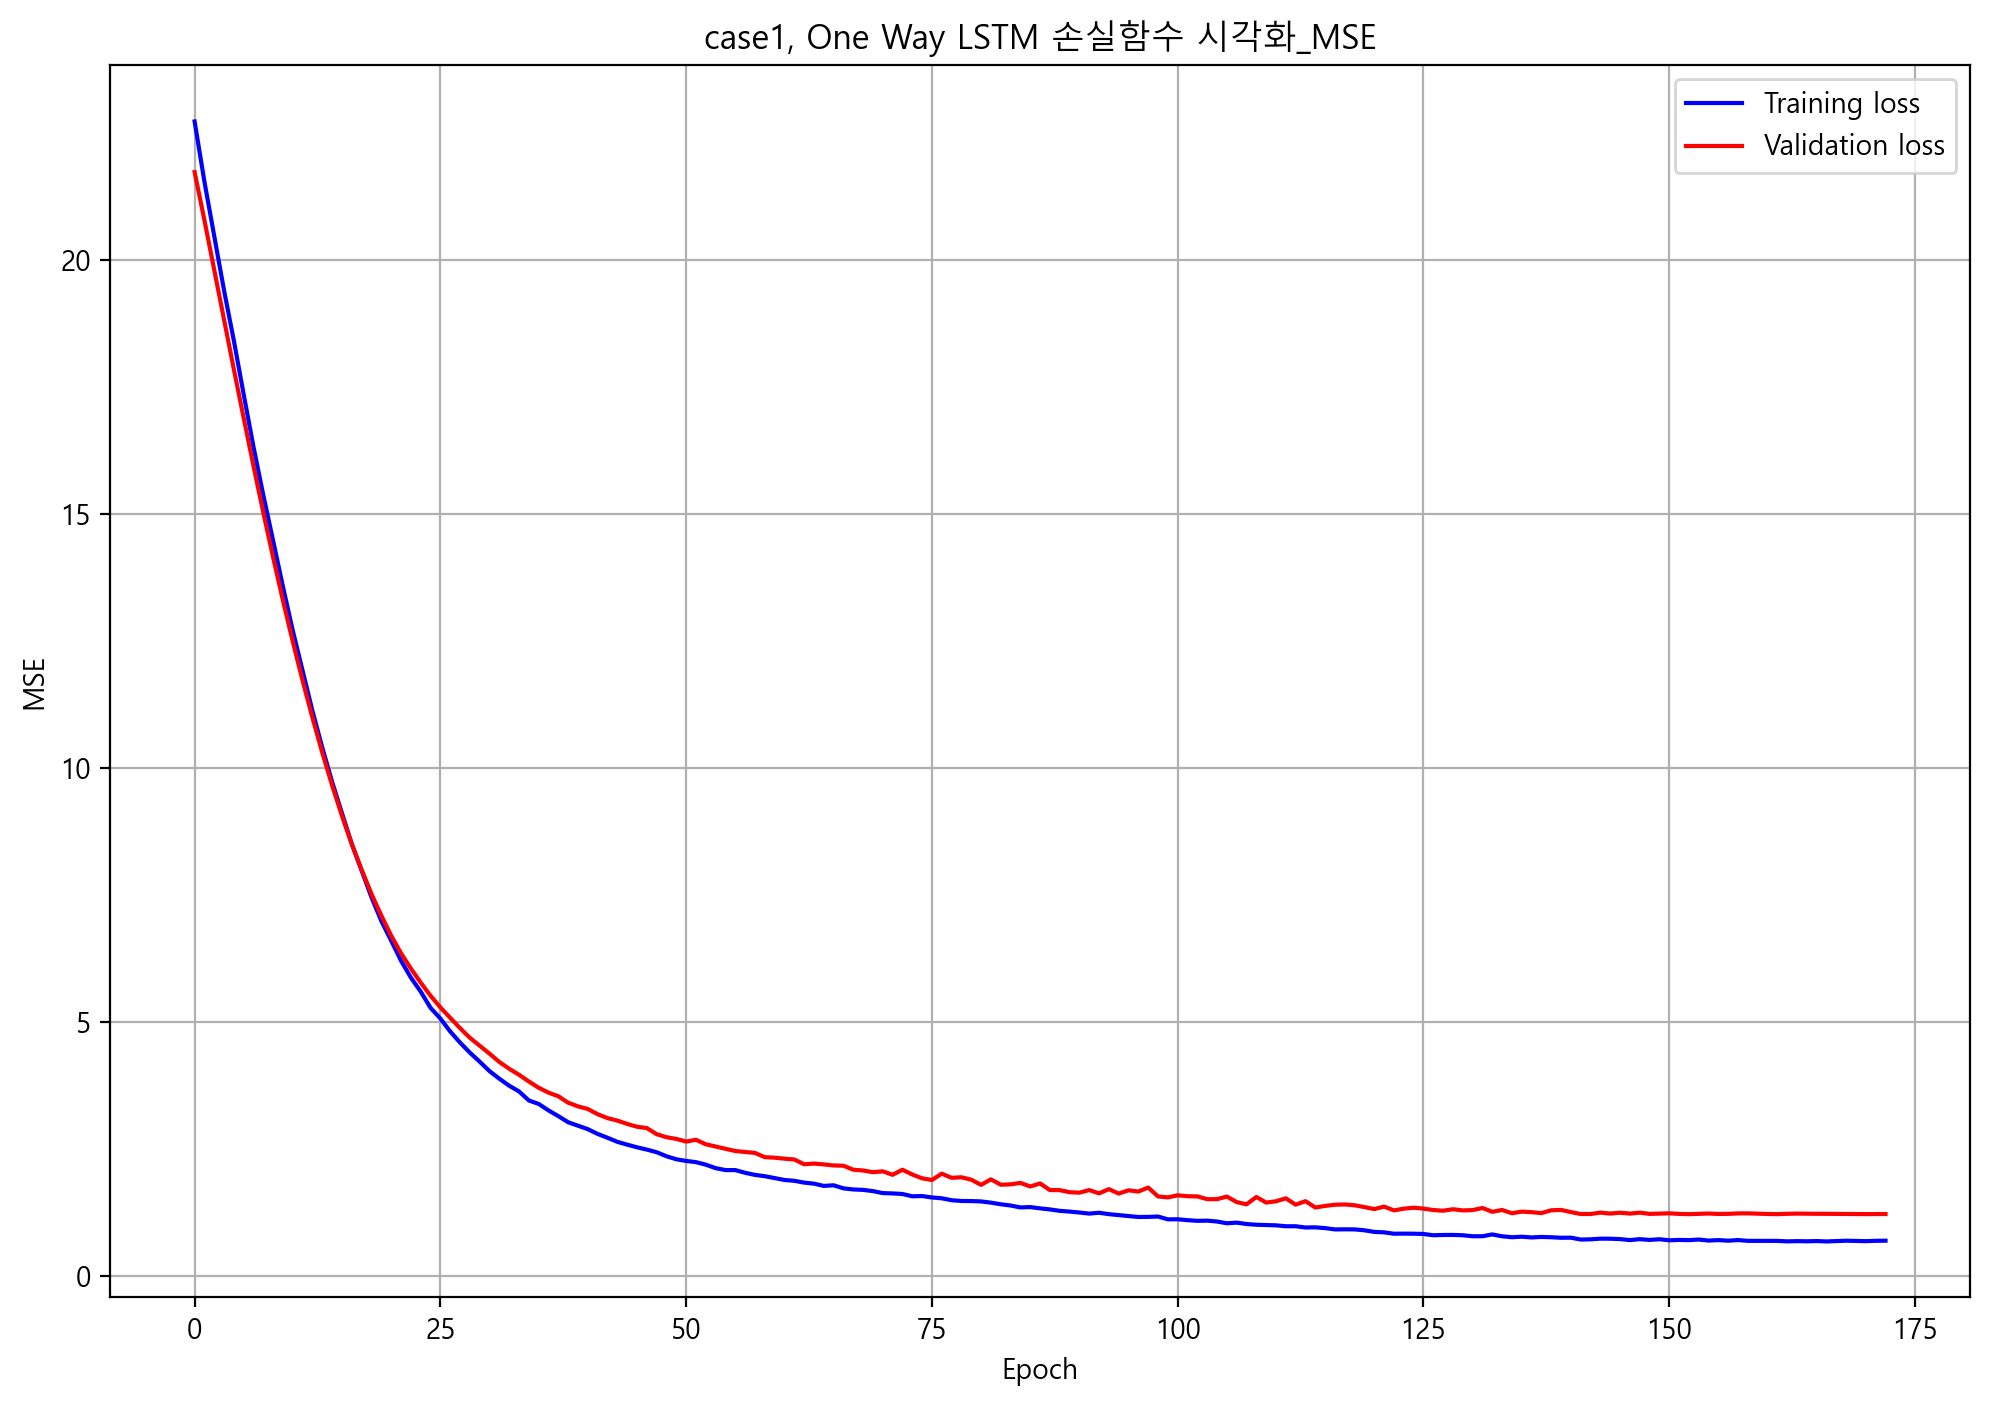

In [68]:
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization, Input, Embedding, Concatenate, Attention
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import legacy as legacy_optimizers

# Attention 레이어 정의
def attention_layer(inputs):
    attention = Attention()([inputs, inputs])
    return Concatenate()([inputs, attention])

# 옵티마이저 설정
initial_lr = 0.0005
optimizer = legacy_optimizers.Adam(learning_rate=initial_lr)

# 범주형 변수 설정
num_categories = 3
embedding_dim = 5

# 옵티마이저 및 콜백 설정
optimizer = Adam(learning_rate=initial_lr)
lr_restart = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# 모델 정의
numerical_input = Input(shape=(x_train_multi.shape[1], x_train_multi.shape[2]))
categorical_input = Input(shape=(x_train_label.shape[1], ))

# 임베딩 레이어
embedding = Embedding(input_dim=num_categories, output_dim=embedding_dim)(categorical_input)

# 입력 결합
combined_input = Concatenate(axis=-1)([numerical_input, embedding])

x = LSTM(128, return_sequences=True,
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(combined_input)
x = BatchNormalization()(x)
x = Dropout(0.3, seed=40)(x)

x = LSTM(64, return_sequences=True,
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3, seed=41)(x)

x = attention_layer(x)

x = LSTM(32, activation='relu',
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3, seed=42)(x)

x = Dense(24, activation='relu')(x)
output = Dense(12)(x)

case1_uni_mse = Model(inputs=[numerical_input, categorical_input], outputs=output)

case1_uni_mse.compile(optimizer=optimizer, loss="mse")

# 모델 학습
case1_uni_mse_history = case1_uni_mse.fit(
    [x_train_multi, x_train_label],  
    y_train_multi,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    steps_per_epoch = x_train_multi.shape[0] // BATCH_SIZE, 
    validation_steps = x_val_multi.shape[0] // BATCH_SIZE,
    validation_data=([x_val_multi, x_val_label], y_val_multi),
    callbacks=[lr_restart, early_stop]
)

# 학습 결과 시각화
plot_train_history(case1_uni_mse_history, "case1, One Way LSTM", "MSE")

# 모델 저장
case1_uni_mse.save("./output/case1/case1_uni_mse.h5")

Epoch 1/300
16/16 [==============================] - 4s 56ms/step - loss: 22.8458 - root_mean_squared_error: 1.2372 - val_loss: 21.8286 - val_root_mean_squared_error: 0.9775 - lr: 5.0000e-04
Epoch 2/300
16/16 [==============================] - 0s 12ms/step - loss: 21.7369 - root_mean_squared_error: 1.1279 - val_loss: 20.9568 - val_root_mean_squared_error: 0.9806 - lr: 5.0000e-04
Epoch 3/300
16/16 [==============================] - 0s 12ms/step - loss: 20.6880 - root_mean_squared_error: 1.0571 - val_loss: 20.0540 - val_root_mean_squared_error: 0.9835 - lr: 5.0000e-04
Epoch 4/300
16/16 [==============================] - 0s 12ms/step - loss: 19.7182 - root_mean_squared_error: 1.0311 - val_loss: 19.1398 - val_root_mean_squared_error: 0.9871 - lr: 5.0000e-04
Epoch 5/300
16/16 [==============================] - 0s 12ms/step - loss: 18.7723 - root_mean_squared_error: 1.0187 - val_loss: 18.2296 - val_root_mean_squared_error: 0.9906 - lr: 5.0000e-04
Epoch 6/300
16/16 [==========================

16/16 [==============================] - 0s 12ms/step - loss: 2.7402 - root_mean_squared_error: 0.7536 - val_loss: 3.1309 - val_root_mean_squared_error: 0.9999 - lr: 5.0000e-04
Epoch 45/300
16/16 [==============================] - 0s 12ms/step - loss: 2.6878 - root_mean_squared_error: 0.7681 - val_loss: 3.0516 - val_root_mean_squared_error: 0.9961 - lr: 5.0000e-04
Epoch 46/300
16/16 [==============================] - 0s 12ms/step - loss: 2.5904 - root_mean_squared_error: 0.7502 - val_loss: 2.9767 - val_root_mean_squared_error: 0.9913 - lr: 5.0000e-04
Epoch 47/300
16/16 [==============================] - 0s 12ms/step - loss: 2.5494 - root_mean_squared_error: 0.7650 - val_loss: 2.8953 - val_root_mean_squared_error: 0.9819 - lr: 5.0000e-04
Epoch 48/300
16/16 [==============================] - 0s 12ms/step - loss: 2.4947 - root_mean_squared_error: 0.7657 - val_loss: 2.8560 - val_root_mean_squared_error: 0.9883 - lr: 5.0000e-04
Epoch 49/300
16/16 [==============================] - 0s 12ms/s

16/16 [==============================] - 0s 11ms/step - loss: 1.3383 - root_mean_squared_error: 0.7244 - val_loss: 1.7739 - val_root_mean_squared_error: 0.9845 - lr: 5.0000e-04
Epoch 88/300
16/16 [==============================] - 0s 12ms/step - loss: 1.3193 - root_mean_squared_error: 0.7244 - val_loss: 1.7070 - val_root_mean_squared_error: 0.9614 - lr: 5.0000e-04
Epoch 89/300
16/16 [==============================] - 0s 12ms/step - loss: 1.3007 - root_mean_squared_error: 0.7243 - val_loss: 1.7414 - val_root_mean_squared_error: 0.9861 - lr: 5.0000e-04
Epoch 90/300
16/16 [==============================] - 0s 12ms/step - loss: 1.2995 - root_mean_squared_error: 0.7331 - val_loss: 1.7626 - val_root_mean_squared_error: 1.0035 - lr: 5.0000e-04
Epoch 91/300
16/16 [==============================] - 0s 12ms/step - loss: 1.2765 - root_mean_squared_error: 0.7259 - val_loss: 1.6581 - val_root_mean_squared_error: 0.9569 - lr: 5.0000e-04
Epoch 92/300
16/16 [==============================] - 0s 12ms/s

16/16 [==============================] - 0s 11ms/step - loss: 0.8896 - root_mean_squared_error: 0.6906 - val_loss: 1.3762 - val_root_mean_squared_error: 0.9824 - lr: 1.2500e-04
Epoch 129/300
16/16 [==============================] - 0s 11ms/step - loss: 0.8910 - root_mean_squared_error: 0.6935 - val_loss: 1.4315 - val_root_mean_squared_error: 1.0115 - lr: 1.2500e-04
Epoch 130/300
16/16 [==============================] - 0s 11ms/step - loss: 0.8868 - root_mean_squared_error: 0.6930 - val_loss: 1.3530 - val_root_mean_squared_error: 0.9737 - lr: 1.2500e-04
Epoch 131/300
16/16 [==============================] - 0s 11ms/step - loss: 0.8727 - root_mean_squared_error: 0.6847 - val_loss: 1.4275 - val_root_mean_squared_error: 1.0120 - lr: 1.2500e-04
Epoch 132/300
16/16 [==============================] - 0s 11ms/step - loss: 0.8670 - root_mean_squared_error: 0.6817 - val_loss: 1.3855 - val_root_mean_squared_error: 0.9924 - lr: 1.2500e-04
Epoch 133/300
16/16 [==============================] - 0s 1

16/16 [==============================] - 0s 11ms/step - loss: 0.7640 - root_mean_squared_error: 0.6776 - val_loss: 1.2713 - val_root_mean_squared_error: 0.9834 - lr: 6.2500e-05
Epoch 171/300
16/16 [==============================] - 0s 11ms/step - loss: 0.7579 - root_mean_squared_error: 0.6742 - val_loss: 1.2626 - val_root_mean_squared_error: 0.9799 - lr: 6.2500e-05
Epoch 172/300
16/16 [==============================] - 0s 12ms/step - loss: 0.7630 - root_mean_squared_error: 0.6789 - val_loss: 1.2981 - val_root_mean_squared_error: 0.9983 - lr: 6.2500e-05
Epoch 173/300
16/16 [==============================] - 0s 12ms/step - loss: 0.7713 - root_mean_squared_error: 0.6857 - val_loss: 1.2593 - val_root_mean_squared_error: 0.9792 - lr: 6.2500e-05
Epoch 174/300
16/16 [==============================] - 0s 11ms/step - loss: 0.7720 - root_mean_squared_error: 0.6871 - val_loss: 1.2644 - val_root_mean_squared_error: 0.9825 - lr: 6.2500e-05
Epoch 175/300
16/16 [==============================] - 0s 1

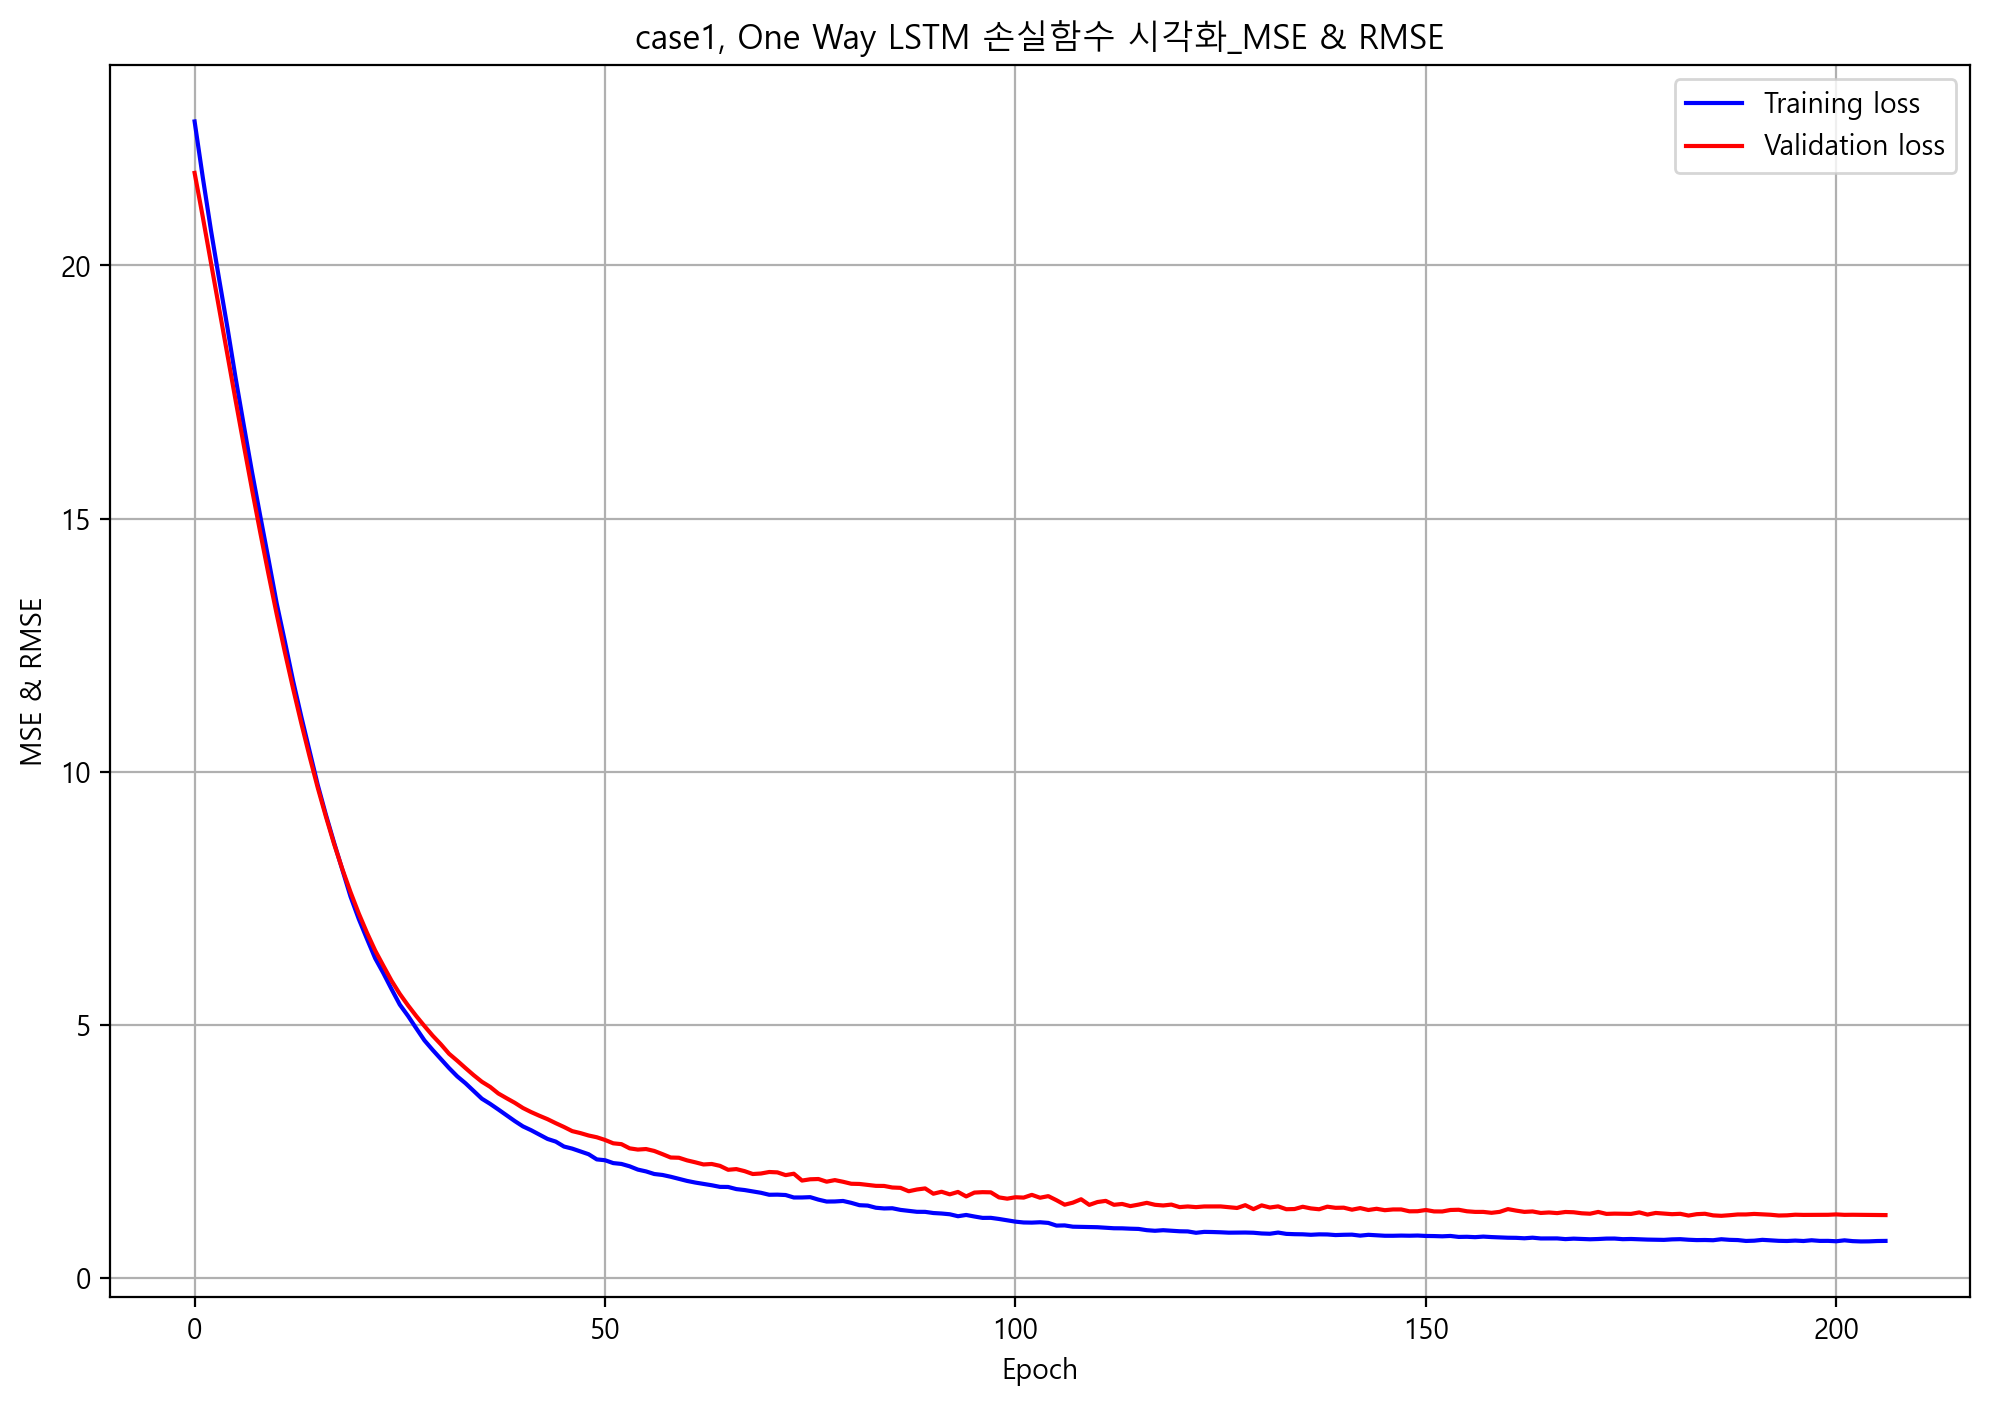

In [69]:
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization, Input, Embedding, Concatenate, Attention
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import legacy as legacy_optimizers
from tensorflow.keras import metrics

# Attention 레이어 정의
def attention_layer(inputs):
    attention = Attention()([inputs, inputs])
    return Concatenate()([inputs, attention])

# 옵티마이저 설정
initial_lr = 0.0005
optimizer = legacy_optimizers.Adam(learning_rate=initial_lr)

# 범주형 변수 설정
num_categories = 3
embedding_dim = 5

# 옵티마이저 및 콜백 설정
optimizer = Adam(learning_rate=initial_lr)
lr_restart = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# 모델 정의
numerical_input = Input(shape=(x_train_multi.shape[1], x_train_multi.shape[2]))
categorical_input = Input(shape=(x_train_label.shape[1], ))

# 임베딩 레이어
embedding = Embedding(input_dim=num_categories, output_dim=embedding_dim)(categorical_input)

# 입력 결합
combined_input = Concatenate(axis=-1)([numerical_input, embedding])

x = LSTM(128, return_sequences=True,
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(combined_input)
x = BatchNormalization()(x)
x = Dropout(0.3, seed=40)(x)

x = LSTM(64, return_sequences=True,
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3, seed=41)(x)

x = attention_layer(x)

x = LSTM(32, activation='relu',
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3, seed=42)(x)

x = Dense(24, activation='relu')(x)
output = Dense(12)(x)

case1_uni_rmse = Model(inputs=[numerical_input, categorical_input], outputs=output)
case1_uni_rmse.compile(optimizer=optimizer
                       , loss="mse"
                       , metrics=[metrics.RootMeanSquaredError()]
                      )

# 모델 학습
case1_uni_rmse_history = case1_uni_rmse.fit(
    [x_train_multi, x_train_label],  
    y_train_multi,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    steps_per_epoch = x_train_multi.shape[0] // BATCH_SIZE, 
    validation_steps = x_val_multi.shape[0] // BATCH_SIZE,
    validation_data=([x_val_multi, x_val_label], y_val_multi),
    callbacks=[lr_restart, early_stop]
)

# 학습 결과 시각화
plot_train_history(case1_uni_rmse_history, "case1, One Way LSTM", "MSE & RMSE")

# 모델 저장
case1_uni_rmse.save("./output/case1/case1_uni_rmse.h5")

### 양방향 LSTM

Epoch 1/300
16/16 [==============================] - 6s 88ms/step - loss: 54.5291 - val_loss: 51.3020 - lr: 5.0000e-04
Epoch 2/300
16/16 [==============================] - 0s 18ms/step - loss: 48.9023 - val_loss: 45.9376 - lr: 5.0000e-04
Epoch 3/300
16/16 [==============================] - 0s 18ms/step - loss: 43.6710 - val_loss: 40.8968 - lr: 5.0000e-04
Epoch 4/300
16/16 [==============================] - 0s 18ms/step - loss: 38.7496 - val_loss: 36.1824 - lr: 5.0000e-04
Epoch 5/300
16/16 [==============================] - 0s 17ms/step - loss: 34.1693 - val_loss: 31.8236 - lr: 5.0000e-04
Epoch 6/300
16/16 [==============================] - 0s 17ms/step - loss: 29.9679 - val_loss: 27.8319 - lr: 5.0000e-04
Epoch 7/300
16/16 [==============================] - 0s 17ms/step - loss: 26.1205 - val_loss: 24.2028 - lr: 5.0000e-04
Epoch 8/300
16/16 [==============================] - 0s 17ms/step - loss: 22.6521 - val_loss: 20.9283 - lr: 5.0000e-04
Epoch 9/300
16/16 [=============================

16/16 [==============================] - 0s 17ms/step - loss: 2.2523 - val_loss: 2.3360 - lr: 5.0000e-04
Epoch 71/300
16/16 [==============================] - 0s 17ms/step - loss: 2.2281 - val_loss: 2.2749 - lr: 5.0000e-04
Epoch 72/300
16/16 [==============================] - 0s 17ms/step - loss: 2.1863 - val_loss: 2.2933 - lr: 5.0000e-04
Epoch 73/300
16/16 [==============================] - 0s 17ms/step - loss: 2.1544 - val_loss: 2.2687 - lr: 5.0000e-04
Epoch 74/300
16/16 [==============================] - 0s 17ms/step - loss: 2.1244 - val_loss: 2.2329 - lr: 5.0000e-04
Epoch 75/300
16/16 [==============================] - 0s 18ms/step - loss: 2.1092 - val_loss: 2.2222 - lr: 5.0000e-04
Epoch 76/300
16/16 [==============================] - 0s 17ms/step - loss: 2.0838 - val_loss: 2.1543 - lr: 5.0000e-04
Epoch 77/300
16/16 [==============================] - 0s 17ms/step - loss: 2.0456 - val_loss: 2.1732 - lr: 5.0000e-04
Epoch 78/300
16/16 [==============================] - 0s 18ms/step - 

16/16 [==============================] - 0s 17ms/step - loss: 0.8661 - val_loss: 0.9848 - lr: 5.0000e-04
Epoch 140/300
16/16 [==============================] - 0s 17ms/step - loss: 0.8393 - val_loss: 0.9635 - lr: 5.0000e-04
Epoch 141/300
16/16 [==============================] - 0s 17ms/step - loss: 0.8329 - val_loss: 1.0210 - lr: 5.0000e-04
Epoch 142/300
16/16 [==============================] - 0s 18ms/step - loss: 0.8228 - val_loss: 0.9494 - lr: 5.0000e-04
Epoch 143/300
16/16 [==============================] - 0s 17ms/step - loss: 0.8010 - val_loss: 0.9254 - lr: 5.0000e-04
Epoch 144/300
16/16 [==============================] - 0s 17ms/step - loss: 0.7993 - val_loss: 0.9266 - lr: 5.0000e-04
Epoch 145/300
16/16 [==============================] - 0s 17ms/step - loss: 0.7784 - val_loss: 0.9336 - lr: 5.0000e-04
Epoch 146/300
16/16 [==============================] - 0s 17ms/step - loss: 0.7661 - val_loss: 0.9247 - lr: 5.0000e-04
Epoch 147/300
16/16 [==============================] - 0s 16ms

Epoch 201/300
16/16 [==============================] - 0s 17ms/step - loss: 0.5824 - val_loss: 0.7404 - lr: 7.8125e-06
Epoch 202/300
16/16 [==============================] - 0s 17ms/step - loss: 0.5828 - val_loss: 0.7409 - lr: 7.8125e-06
Epoch 203/300
16/16 [==============================] - 0s 17ms/step - loss: 0.5819 - val_loss: 0.7404 - lr: 7.8125e-06
Epoch 204/300
13/16 [=======================>......] - ETA: 0s - loss: 0.5775
Epoch 204: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.
16/16 [==============================] - 0s 17ms/step - loss: 0.5816 - val_loss: 0.7409 - lr: 7.8125e-06
Epoch 205/300
16/16 [==============================] - 0s 17ms/step - loss: 0.5808 - val_loss: 0.7407 - lr: 3.9063e-06
Epoch 206/300
16/16 [==============================] - 0s 17ms/step - loss: 0.5840 - val_loss: 0.7410 - lr: 3.9063e-06
Epoch 207/300
16/16 [==============================] - 0s 16ms/step - loss: 0.5870 - val_loss: 0.7418 - lr: 3.9063e-06
Epoch 208/300
16/16 [====

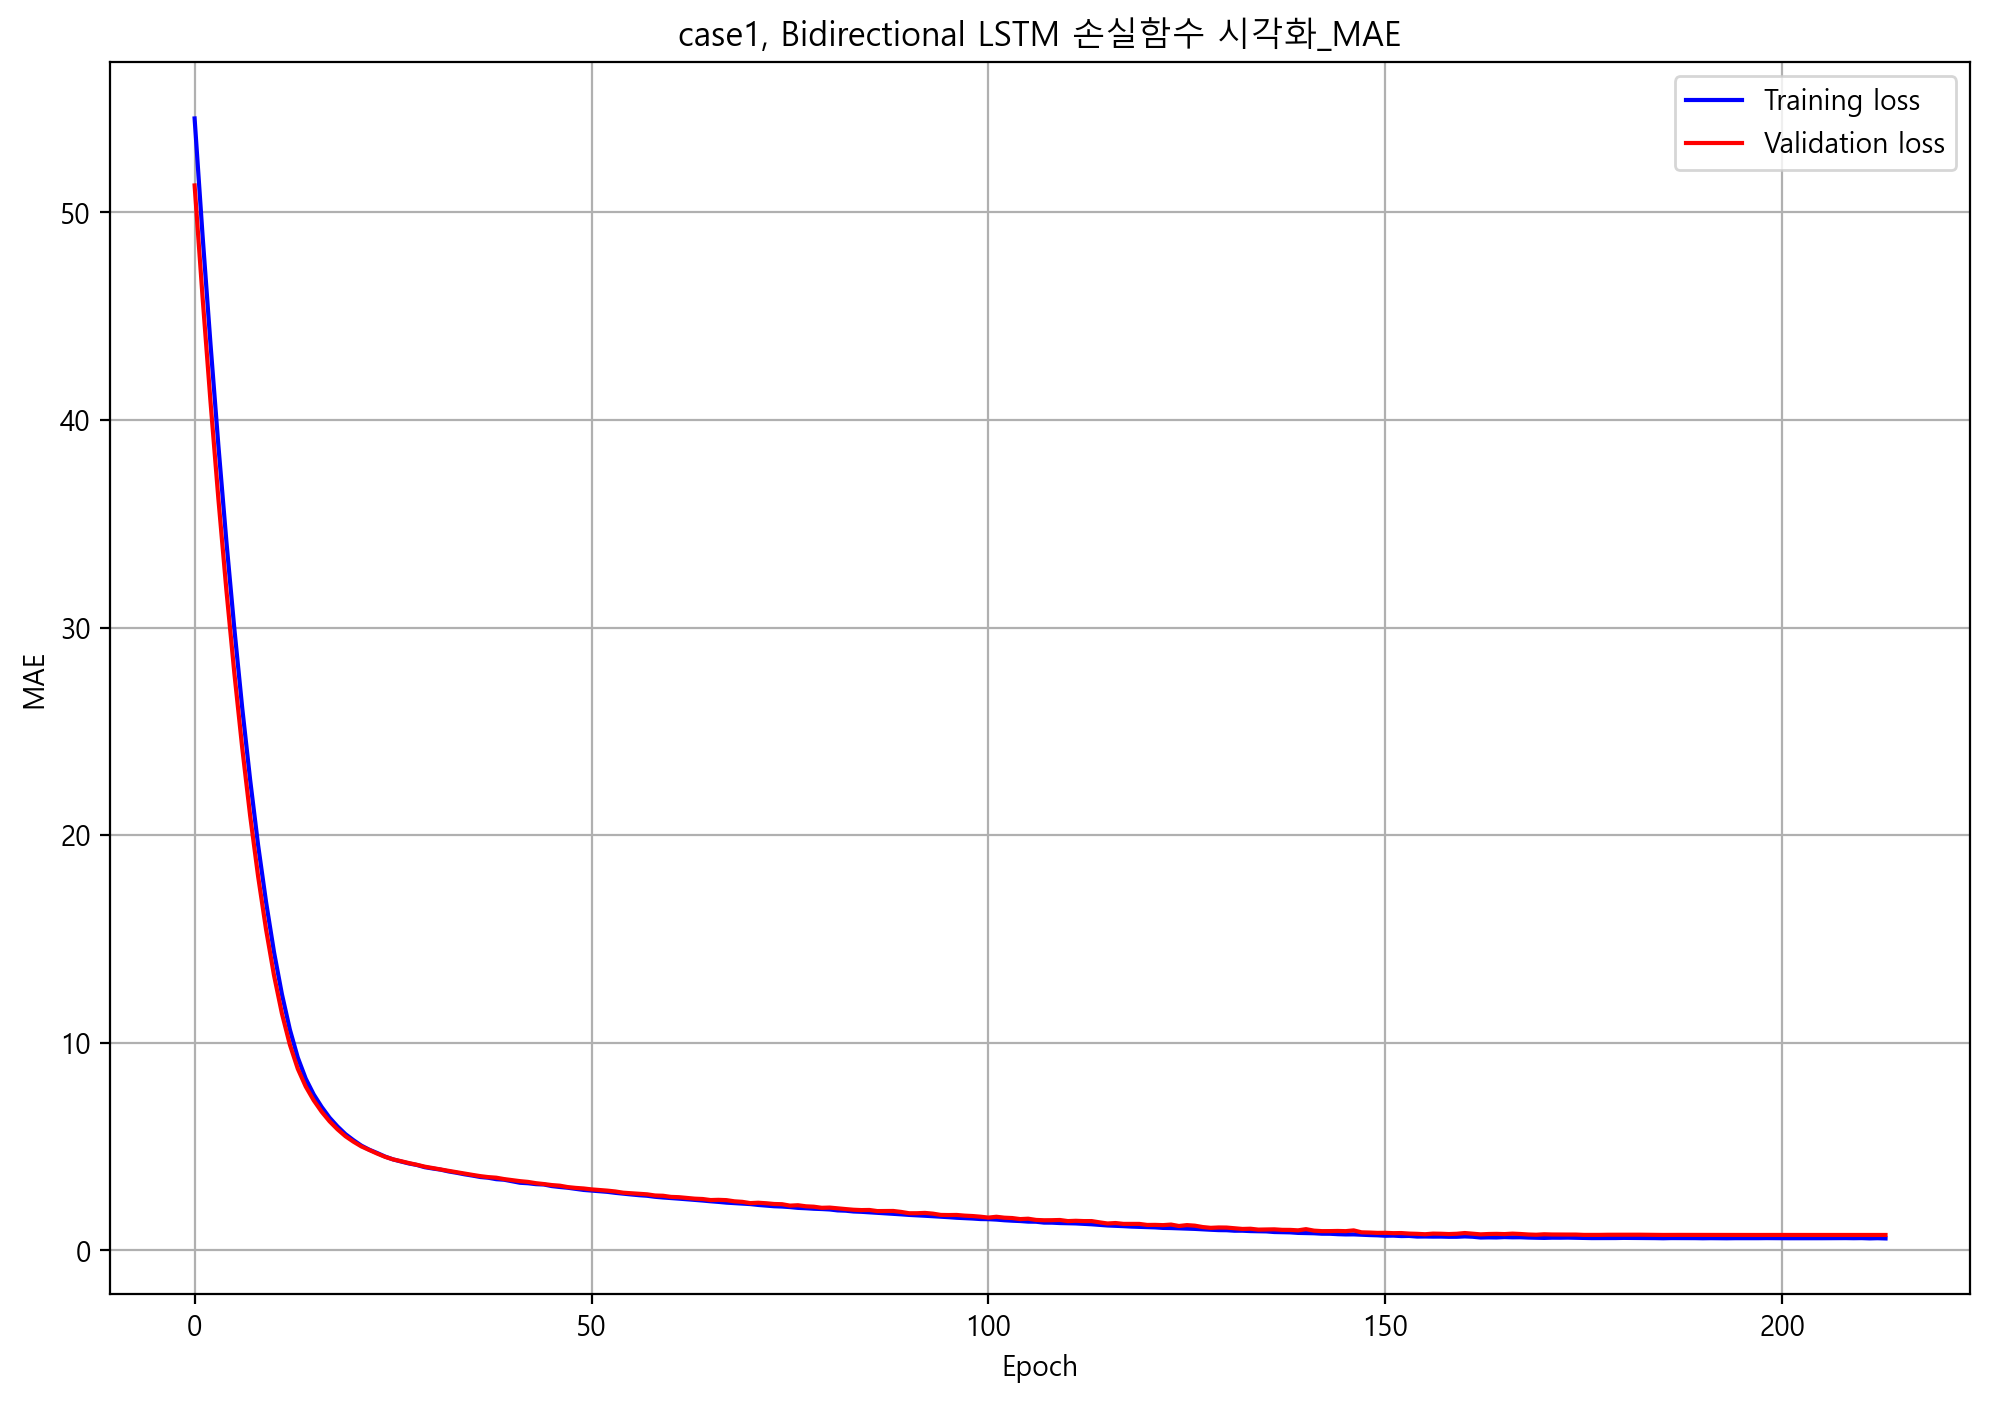

In [70]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization, Input, Embedding, Concatenate, Attention, Bidirectional
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import legacy as legacy_optimizers

# Attention 레이어 정의
def attention_layer(inputs):
    attention = Attention()([inputs, inputs])
    return Concatenate()([inputs, attention])

# 옵티마이저 설정
initial_lr = 0.0005
optimizer = legacy_optimizers.Adam(learning_rate=initial_lr)

# 범주형 변수 설정
num_categories = 3
embedding_dim = 5

# 옵티마이저 및 콜백 설정
optimizer = Adam(learning_rate=initial_lr)
lr_restart = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# 모델 정의
numerical_input = Input(shape=(x_train_multi.shape[1], x_train_multi.shape[2]))
categorical_input = Input(shape=(x_train_label.shape[1], ))

# 임베딩 레이어
embedding = Embedding(input_dim=num_categories, output_dim=embedding_dim)(categorical_input)

# 입력 결합
combined_input = Concatenate(axis=-1)([numerical_input, embedding])

x = Bidirectional(LSTM(128, return_sequences=True,
                   kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                   bias_regularizer=l1_l2(l1=0.005, l2=0.005)))(combined_input)
x = BatchNormalization()(x)
x = Dropout(0.3, seed=40)(x)

x = Bidirectional(LSTM(64, return_sequences=True,
                   kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                   bias_regularizer=l1_l2(l1=0.005, l2=0.005)))(x)
x = BatchNormalization()(x)
x = Dropout(0.3, seed=41)(x)

x = attention_layer(x)

x = LSTM(32, activation='relu',
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3, seed=42)(x)

x = Dense(24, activation='relu')(x)
output = Dense(12)(x)

case1_bi_mae = Model(inputs=[numerical_input, categorical_input], outputs=output)
case1_bi_mae.compile(optimizer=optimizer, loss="mae")

# 모델 학습
case1_bi_mae_history = case1_bi_mae.fit(
    # 수치형 데이터와 범주형 데이터 분리    
    [x_train_multi, x_train_label],  
    y_train_multi,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    steps_per_epoch = x_train_multi.shape[0] // BATCH_SIZE, 
    validation_steps = x_val_multi.shape[0] // BATCH_SIZE,
    validation_data=([x_val_multi, x_val_label], y_val_multi),
    callbacks=[lr_restart, early_stop]
)

# 학습 결과 시각화
plot_train_history(case1_bi_mae_history, "case1, Bidirectional LSTM", "MAE")

# 모델 저장
case1_bi_mae.save("./output/case1/case1_bi_mae.h5")

Epoch 1/300
16/16 [==============================] - 6s 87ms/step - loss: 56.4652 - val_loss: 53.9834 - lr: 5.0000e-04
Epoch 2/300
16/16 [==============================] - 0s 18ms/step - loss: 52.9072 - val_loss: 50.5508 - lr: 5.0000e-04
Epoch 3/300
16/16 [==============================] - 0s 18ms/step - loss: 49.2618 - val_loss: 47.0769 - lr: 5.0000e-04
Epoch 4/300
16/16 [==============================] - 0s 17ms/step - loss: 45.6464 - val_loss: 43.6291 - lr: 5.0000e-04
Epoch 5/300
16/16 [==============================] - 0s 17ms/step - loss: 42.1085 - val_loss: 40.2352 - lr: 5.0000e-04
Epoch 6/300
16/16 [==============================] - 0s 17ms/step - loss: 38.6964 - val_loss: 36.9457 - lr: 5.0000e-04
Epoch 7/300
16/16 [==============================] - 0s 17ms/step - loss: 35.3771 - val_loss: 33.7815 - lr: 5.0000e-04
Epoch 8/300
16/16 [==============================] - 0s 17ms/step - loss: 32.2828 - val_loss: 30.7733 - lr: 5.0000e-04
Epoch 9/300
16/16 [=============================

16/16 [==============================] - 0s 17ms/step - loss: 2.3832 - val_loss: 2.7579 - lr: 5.0000e-04
Epoch 71/300
16/16 [==============================] - 0s 17ms/step - loss: 2.3416 - val_loss: 2.7623 - lr: 5.0000e-04
Epoch 72/300
16/16 [==============================] - 0s 16ms/step - loss: 2.3180 - val_loss: 2.6871 - lr: 5.0000e-04
Epoch 73/300
16/16 [==============================] - 0s 17ms/step - loss: 2.2668 - val_loss: 2.6728 - lr: 5.0000e-04
Epoch 74/300
16/16 [==============================] - 0s 17ms/step - loss: 2.2161 - val_loss: 2.6487 - lr: 5.0000e-04
Epoch 75/300
16/16 [==============================] - 0s 17ms/step - loss: 2.2023 - val_loss: 2.5957 - lr: 5.0000e-04
Epoch 76/300
16/16 [==============================] - 0s 19ms/step - loss: 2.1840 - val_loss: 2.4895 - lr: 5.0000e-04
Epoch 77/300
16/16 [==============================] - 0s 17ms/step - loss: 2.1260 - val_loss: 2.4597 - lr: 5.0000e-04
Epoch 78/300
16/16 [==============================] - 0s 18ms/step - 

16/16 [==============================] - 0s 17ms/step - loss: 0.9007 - val_loss: 1.3459 - lr: 2.5000e-04
Epoch 139/300
16/16 [==============================] - 0s 16ms/step - loss: 0.8985 - val_loss: 1.3853 - lr: 2.5000e-04
Epoch 140/300
16/16 [==============================] - 0s 17ms/step - loss: 0.8758 - val_loss: 1.3615 - lr: 2.5000e-04
Epoch 141/300
16/16 [==============================] - 0s 17ms/step - loss: 0.8794 - val_loss: 1.3279 - lr: 2.5000e-04
Epoch 142/300
16/16 [==============================] - 0s 18ms/step - loss: 0.8589 - val_loss: 1.3115 - lr: 2.5000e-04
Epoch 143/300
16/16 [==============================] - 0s 17ms/step - loss: 0.8543 - val_loss: 1.3350 - lr: 2.5000e-04
Epoch 144/300
16/16 [==============================] - 0s 16ms/step - loss: 0.8505 - val_loss: 1.3185 - lr: 2.5000e-04
Epoch 145/300
16/16 [==============================] - 0s 17ms/step - loss: 0.8472 - val_loss: 1.2857 - lr: 2.5000e-04
Epoch 146/300
16/16 [==============================] - 0s 17ms

16/16 [==============================] - 0s 17ms/step - loss: 0.5636 - val_loss: 1.0615 - lr: 1.5625e-05
Epoch 203/300
16/16 [==============================] - 0s 17ms/step - loss: 0.5537 - val_loss: 1.0575 - lr: 1.5625e-05
Epoch 204/300
16/16 [==============================] - 0s 17ms/step - loss: 0.5583 - val_loss: 1.0611 - lr: 1.5625e-05
Epoch 205/300
16/16 [==============================] - 0s 17ms/step - loss: 0.5564 - val_loss: 1.0654 - lr: 1.5625e-05
Epoch 206/300
16/16 [==============================] - 0s 17ms/step - loss: 0.5564 - val_loss: 1.0633 - lr: 1.5625e-05
Epoch 207/300
16/16 [==============================] - 0s 17ms/step - loss: 0.5653 - val_loss: 1.0627 - lr: 1.5625e-05
Epoch 208/300
13/16 [=======================>......] - ETA: 0s - loss: 0.5609
Epoch 208: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.
16/16 [==============================] - 0s 17ms/step - loss: 0.5590 - val_loss: 1.0634 - lr: 1.5625e-05
Epoch 209/300
16/16 [==================

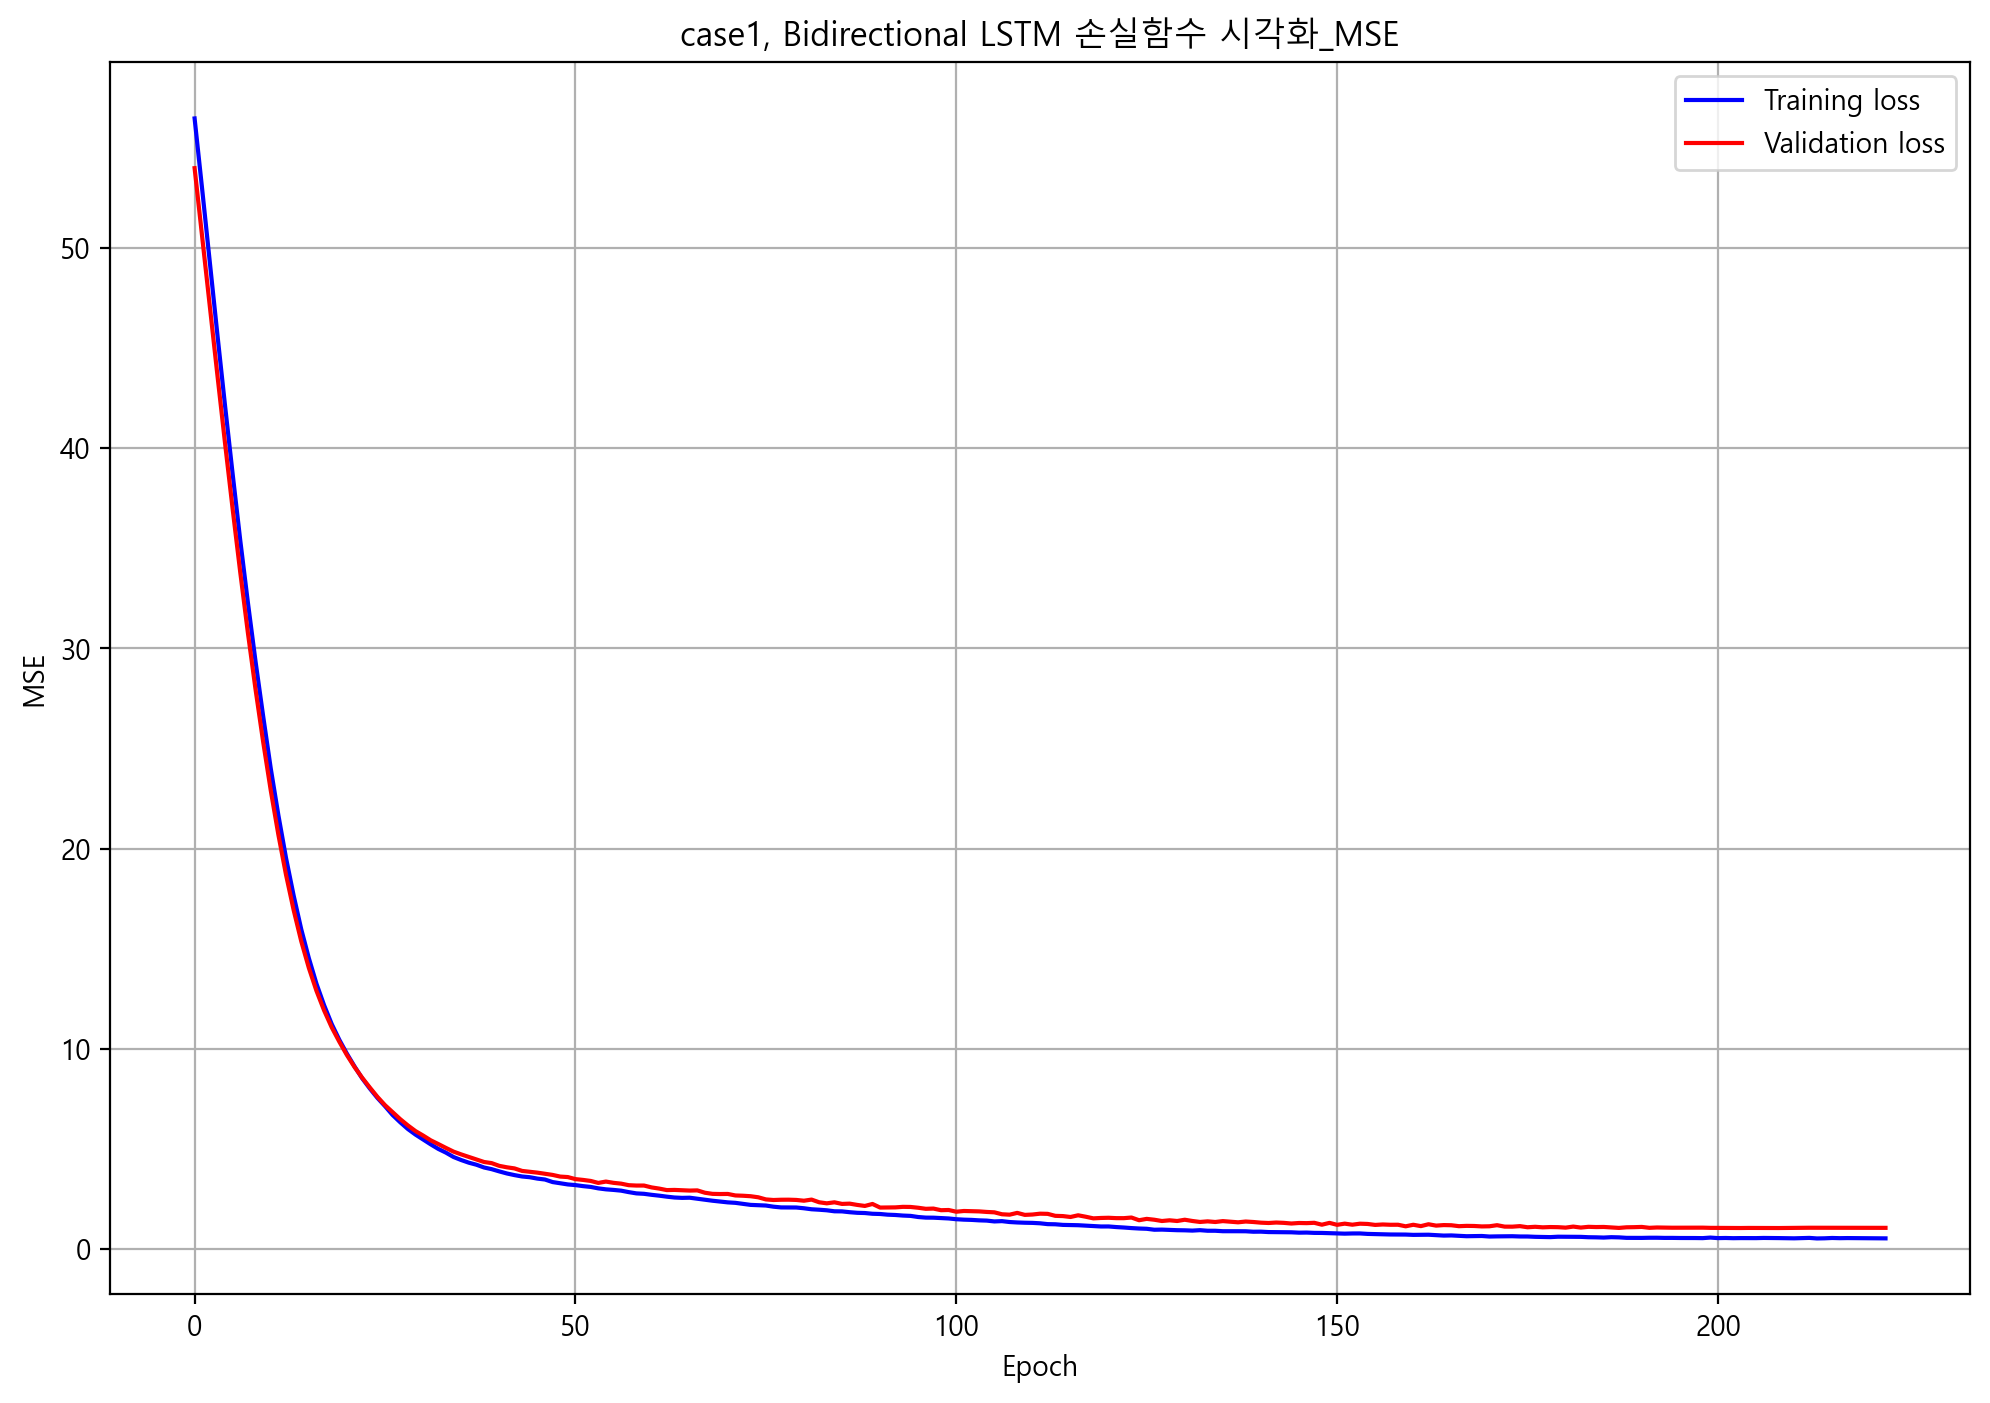

In [71]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization, Input, Embedding, Concatenate, Attention, Bidirectional
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import legacy as legacy_optimizers

# Attention 레이어 정의
def attention_layer(inputs):
    attention = Attention()([inputs, inputs])
    return Concatenate()([inputs, attention])

# 옵티마이저 설정
initial_lr = 0.0005
optimizer = legacy_optimizers.Adam(learning_rate=initial_lr)

# 범주형 변수 설정
num_categories = 3
embedding_dim = 5

# 옵티마이저 및 콜백 설정
optimizer = Adam(learning_rate=initial_lr)
lr_restart = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# 모델 정의
numerical_input = Input(shape=(x_train_multi.shape[1], x_train_multi.shape[2]))
categorical_input = Input(shape=(x_train_label.shape[1], ))

# 임베딩 레이어
embedding = Embedding(input_dim=num_categories, output_dim=embedding_dim)(categorical_input)

# 입력 결합
combined_input = Concatenate(axis=-1)([numerical_input, embedding])

x = Bidirectional(LSTM(128, return_sequences=True,
                   kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                   bias_regularizer=l1_l2(l1=0.005, l2=0.005)))(combined_input)
x = BatchNormalization()(x)
x = Dropout(0.3, seed=40)(x)

x = Bidirectional(LSTM(64, return_sequences=True,
                   kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                   bias_regularizer=l1_l2(l1=0.005, l2=0.005)))(x)
x = BatchNormalization()(x)
x = Dropout(0.3, seed=41)(x)

x = attention_layer(x)

x = LSTM(32, activation='relu',
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3, seed=42)(x)

x = Dense(24, activation='relu')(x)
output = Dense(12)(x)

case1_bi_mse = Model(inputs=[numerical_input, categorical_input], outputs=output)
case1_bi_mse.compile(optimizer=optimizer, loss="mse")

# 모델 학습
case1_bi_mse_history = case1_bi_mse.fit(
    # 수치형 데이터와 범주형 데이터 분리    
    [x_train_multi, x_train_label],  
    y_train_multi,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    steps_per_epoch = x_train_multi.shape[0] // BATCH_SIZE, 
    validation_steps = x_val_multi.shape[0] // BATCH_SIZE,
    validation_data=([x_val_multi, x_val_label], y_val_multi),
    callbacks=[lr_restart, early_stop]
)

# 학습 결과 시각화
plot_train_history(case1_bi_mse_history, "case1, Bidirectional LSTM", "MSE")

# 모델 저장
case1_bi_mse.save("./output/case1/case1_bi_mse.h5")

Epoch 1/300
16/16 [==============================] - 7s 89ms/step - loss: 56.3689 - root_mean_squared_error: 1.2559 - val_loss: 53.9091 - val_root_mean_squared_error: 0.9735 - lr: 5.0000e-04
Epoch 2/300
16/16 [==============================] - 0s 17ms/step - loss: 52.6097 - root_mean_squared_error: 1.1356 - val_loss: 50.3973 - val_root_mean_squared_error: 0.9770 - lr: 5.0000e-04
Epoch 3/300
16/16 [==============================] - 0s 17ms/step - loss: 48.8570 - root_mean_squared_error: 1.0460 - val_loss: 46.8226 - val_root_mean_squared_error: 0.9841 - lr: 5.0000e-04
Epoch 4/300
16/16 [==============================] - 0s 17ms/step - loss: 45.2353 - root_mean_squared_error: 1.0276 - val_loss: 43.2666 - val_root_mean_squared_error: 0.9879 - lr: 5.0000e-04
Epoch 5/300
16/16 [==============================] - 0s 18ms/step - loss: 41.6241 - root_mean_squared_error: 0.9856 - val_loss: 39.8021 - val_root_mean_squared_error: 0.9928 - lr: 5.0000e-04
Epoch 6/300
16/16 [==========================

Epoch 44/300
16/16 [==============================] - 0s 19ms/step - loss: 3.6349 - root_mean_squared_error: 0.7684 - val_loss: 3.9366 - val_root_mean_squared_error: 0.9679 - lr: 5.0000e-04
Epoch 45/300
16/16 [==============================] - 0s 17ms/step - loss: 3.6058 - root_mean_squared_error: 0.7916 - val_loss: 3.9260 - val_root_mean_squared_error: 0.9797 - lr: 5.0000e-04
Epoch 46/300
16/16 [==============================] - 0s 17ms/step - loss: 3.5586 - root_mean_squared_error: 0.7846 - val_loss: 3.8223 - val_root_mean_squared_error: 0.9575 - lr: 5.0000e-04
Epoch 47/300
16/16 [==============================] - 0s 17ms/step - loss: 3.4898 - root_mean_squared_error: 0.7901 - val_loss: 3.8248 - val_root_mean_squared_error: 0.9986 - lr: 5.0000e-04
Epoch 48/300
16/16 [==============================] - 0s 17ms/step - loss: 3.3987 - root_mean_squared_error: 0.7776 - val_loss: 3.6576 - val_root_mean_squared_error: 0.9517 - lr: 5.0000e-04
Epoch 49/300
16/16 [==============================

16/16 [==============================] - 0s 17ms/step - loss: 1.8277 - root_mean_squared_error: 0.7153 - val_loss: 2.2793 - val_root_mean_squared_error: 0.9890 - lr: 5.0000e-04
Epoch 88/300
16/16 [==============================] - 0s 17ms/step - loss: 1.8156 - root_mean_squared_error: 0.7263 - val_loss: 2.2176 - val_root_mean_squared_error: 0.9718 - lr: 5.0000e-04
Epoch 89/300
16/16 [==============================] - 0s 17ms/step - loss: 1.7786 - root_mean_squared_error: 0.7174 - val_loss: 2.1881 - val_root_mean_squared_error: 0.9669 - lr: 5.0000e-04
Epoch 90/300
16/16 [==============================] - 0s 17ms/step - loss: 1.7780 - root_mean_squared_error: 0.7321 - val_loss: 2.2475 - val_root_mean_squared_error: 1.0103 - lr: 5.0000e-04
Epoch 91/300
16/16 [==============================] - 0s 17ms/step - loss: 1.7643 - root_mean_squared_error: 0.7394 - val_loss: 2.1242 - val_root_mean_squared_error: 0.9576 - lr: 5.0000e-04
Epoch 92/300
16/16 [==============================] - 0s 18ms/s

16/16 [==============================] - 0s 18ms/step - loss: 0.9618 - root_mean_squared_error: 0.6981 - val_loss: 1.3747 - val_root_mean_squared_error: 0.9523 - lr: 5.0000e-04
Epoch 131/300
16/16 [==============================] - 0s 17ms/step - loss: 0.9693 - root_mean_squared_error: 0.7126 - val_loss: 1.4066 - val_root_mean_squared_error: 0.9761 - lr: 5.0000e-04
Epoch 132/300
16/16 [==============================] - 0s 17ms/step - loss: 0.9396 - root_mean_squared_error: 0.7022 - val_loss: 1.5058 - val_root_mean_squared_error: 1.0329 - lr: 5.0000e-04
Epoch 133/300
16/16 [==============================] - 0s 17ms/step - loss: 0.9566 - root_mean_squared_error: 0.7230 - val_loss: 1.3346 - val_root_mean_squared_error: 0.9521 - lr: 5.0000e-04
Epoch 134/300
16/16 [==============================] - 0s 17ms/step - loss: 0.9159 - root_mean_squared_error: 0.7041 - val_loss: 1.3550 - val_root_mean_squared_error: 0.9724 - lr: 5.0000e-04
Epoch 135/300
16/16 [==============================] - 0s 1

16/16 [==============================] - 0s 17ms/step - loss: 0.5308 - root_mean_squared_error: 0.6700 - val_loss: 1.0201 - val_root_mean_squared_error: 0.9689 - lr: 1.2500e-04
Epoch 172/300
16/16 [==============================] - 0s 17ms/step - loss: 0.5323 - root_mean_squared_error: 0.6713 - val_loss: 1.0483 - val_root_mean_squared_error: 0.9832 - lr: 1.2500e-04
Epoch 173/300
16/16 [==============================] - 0s 17ms/step - loss: 0.5376 - root_mean_squared_error: 0.6757 - val_loss: 1.0140 - val_root_mean_squared_error: 0.9662 - lr: 1.2500e-04
Epoch 174/300
16/16 [==============================] - 0s 17ms/step - loss: 0.5416 - root_mean_squared_error: 0.6793 - val_loss: 1.0220 - val_root_mean_squared_error: 0.9707 - lr: 1.2500e-04
Epoch 175/300
16/16 [==============================] - 0s 17ms/step - loss: 0.5457 - root_mean_squared_error: 0.6825 - val_loss: 1.0371 - val_root_mean_squared_error: 0.9782 - lr: 1.2500e-04
Epoch 176/300
16/16 [==============================] - 0s 1

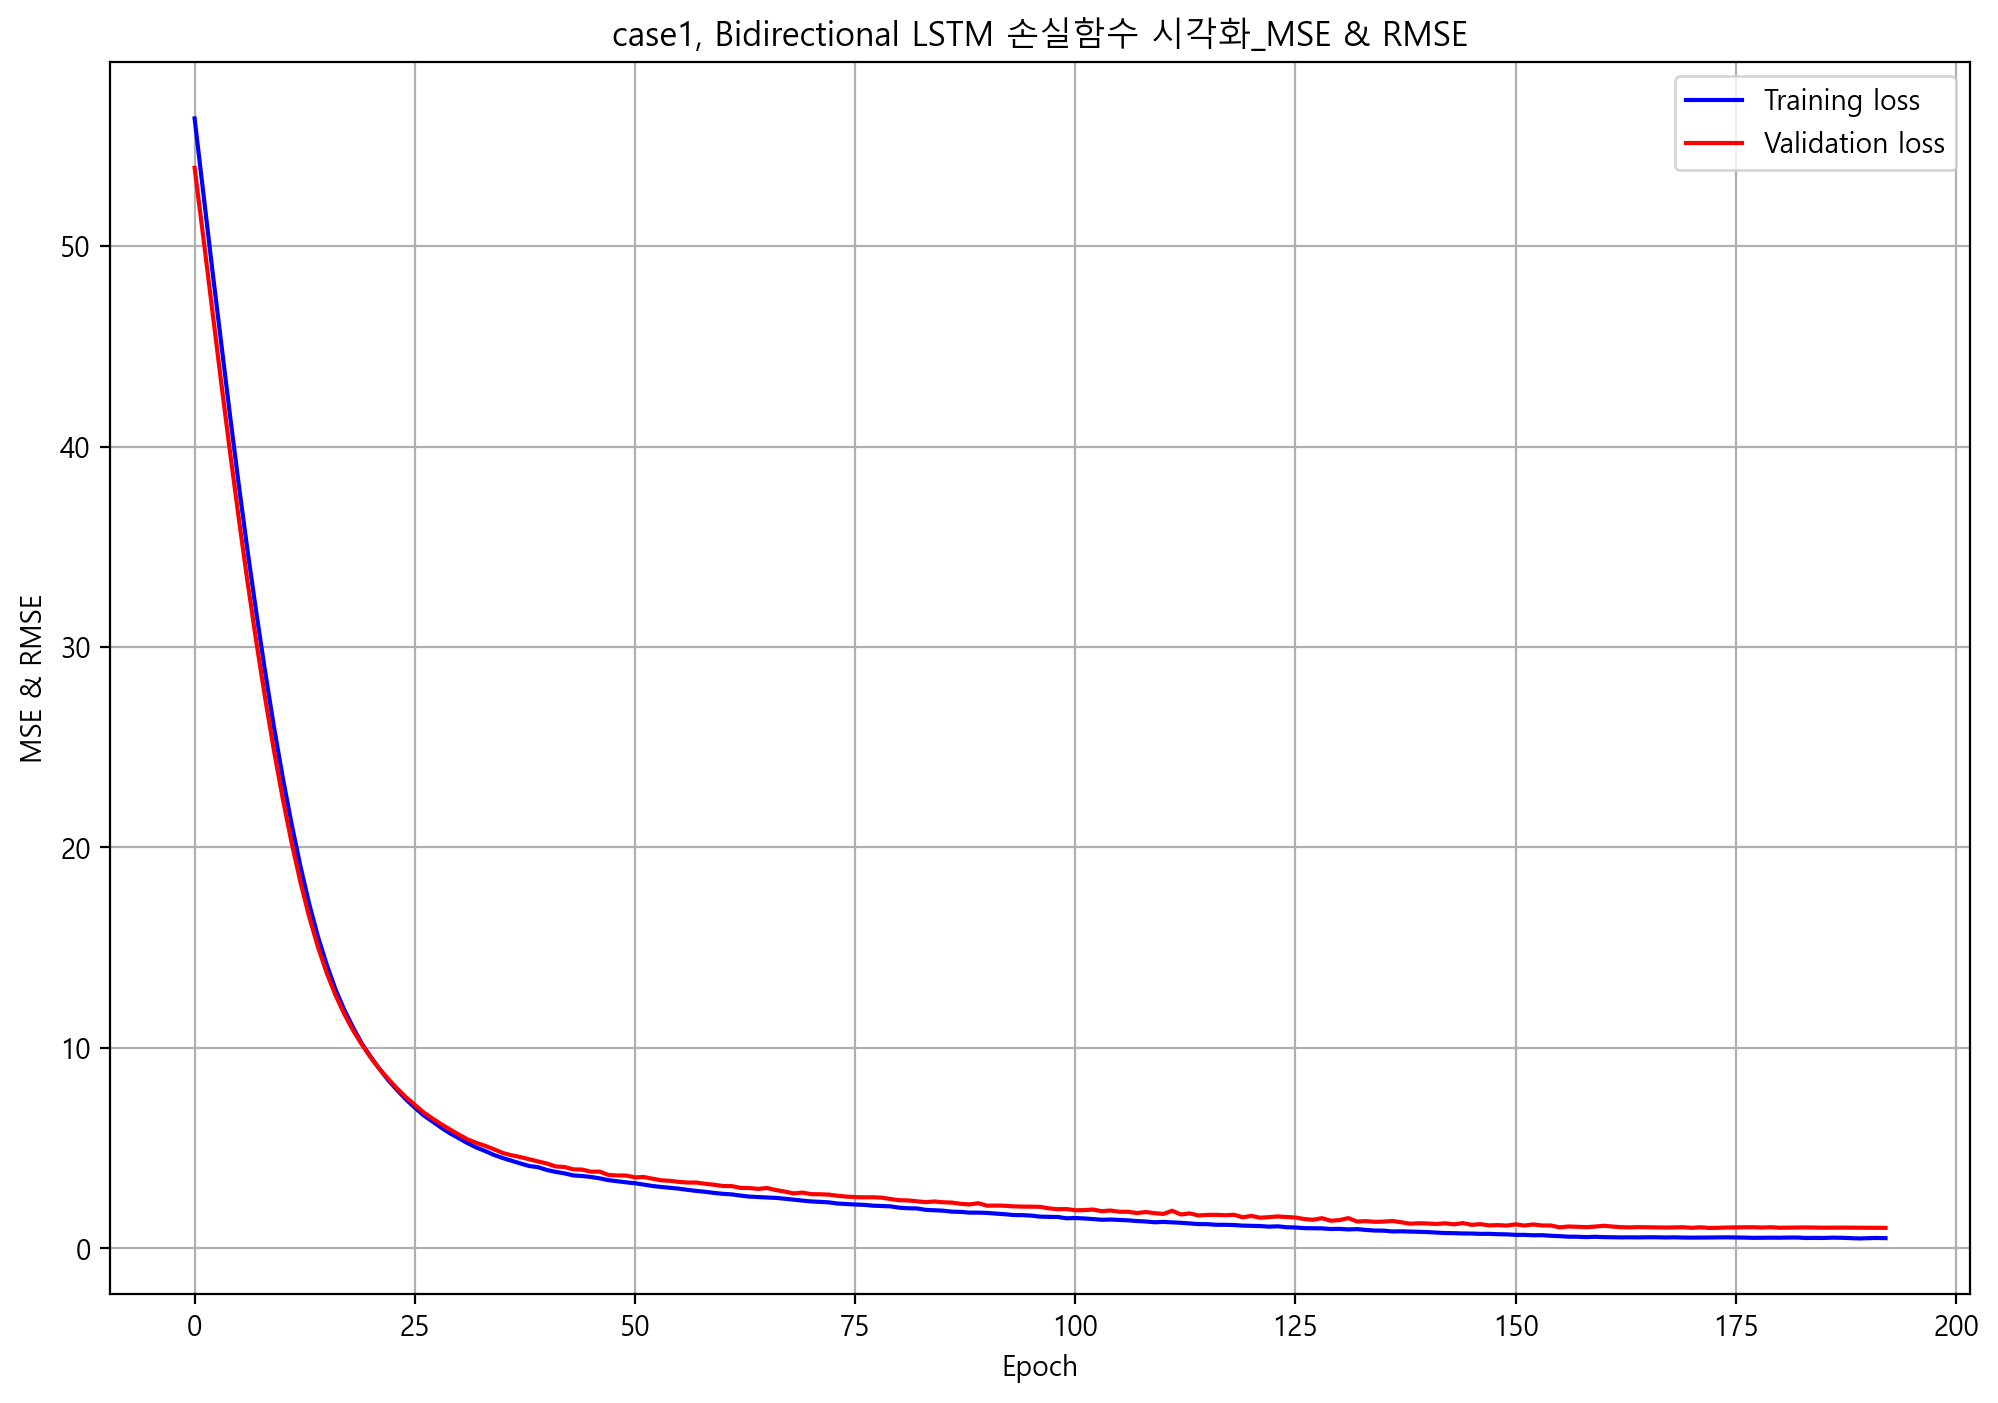

In [72]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization, Input, Embedding, Concatenate, Attention, Bidirectional
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import legacy as legacy_optimizers
from tensorflow.keras import metrics

# Attention 레이어 정의
def attention_layer(inputs):
    attention = Attention()([inputs, inputs])
    return Concatenate()([inputs, attention])

# 옵티마이저 설정
initial_lr = 0.0005
optimizer = legacy_optimizers.Adam(learning_rate=initial_lr)

# 범주형 변수 설정
num_categories = 3
embedding_dim = 5

# 옵티마이저 및 콜백 설정
optimizer = Adam(learning_rate=initial_lr)
lr_restart = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# 모델 정의
numerical_input = Input(shape=(x_train_multi.shape[1], x_train_multi.shape[2]))
categorical_input = Input(shape=(x_train_label.shape[1], ))

# 임베딩 레이어
embedding = Embedding(input_dim=num_categories, output_dim=embedding_dim)(categorical_input)

# 입력 결합
combined_input = Concatenate(axis=-1)([numerical_input, embedding])

x = Bidirectional(LSTM(128, return_sequences=True,
                   kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                   bias_regularizer=l1_l2(l1=0.005, l2=0.005)))(combined_input)
x = BatchNormalization()(x)
x = Dropout(0.3, seed=40)(x)

x = Bidirectional(LSTM(64, return_sequences=True,
                   kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                   bias_regularizer=l1_l2(l1=0.005, l2=0.005)))(x)
x = BatchNormalization()(x)
x = Dropout(0.3, seed=41)(x)

x = attention_layer(x)

x = LSTM(32, activation='relu',
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3, seed=42)(x)

x = Dense(24, activation='relu')(x)
output = Dense(12)(x)

case1_bi_rmse = Model(inputs=[numerical_input, categorical_input], outputs=output)
case1_bi_rmse.compile(optimizer=optimizer
                       , loss="mse"
                       , metrics=[metrics.RootMeanSquaredError()]
                      )

# 모델 학습
case1_bi_rmse_history = case1_bi_rmse.fit(
    # 수치형 데이터와 범주형 데이터 분리    
    [x_train_multi, x_train_label],  
    y_train_multi,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    steps_per_epoch = x_train_multi.shape[0] // BATCH_SIZE, 
    validation_steps = x_val_multi.shape[0] // BATCH_SIZE,
    validation_data=([x_val_multi, x_val_label], y_val_multi),
    callbacks=[lr_restart, early_stop]
)

# 학습 결과 시각화
plot_train_history(case1_bi_rmse_history, "case1, Bidirectional LSTM", "MSE & RMSE")

# 모델 저장
case1_bi_rmse.save("./output/case1/case1_bi_rmse.h5")

# Case2) WTIO, SETIO & 로그변환

## 데이터 전처리

In [73]:
os.mkdir("./output/case2")

case2_df = data[['WTIO', 'SETIO', 'ONI', 'SOI', 'ENSO', 'D20_SCTR']]

case2_dts = case2_df.values

case2_label = case2_dts[ : , 4]
case2_dts = case2_dts[ : , [0, 1, 2, 3, 5]]

case2_dts = np.sign(case2_dts) * np.log1p(np.abs(case2_dts))

## 데이터 분리

In [74]:
# 학습 데이터
x_train_multi, y_train_multi = multivariate_data(case2_dts, case2_dts[:, -1], 0, TRAIN_SPLIT - future_target, past_history, future_target, STEP)

x_train_label = label_split(case2_label, 0, TRAIN_SPLIT - future_target, past_history, future_target, STEP)

# 검증 데이터
x_val_multi, y_val_multi = multivariate_data(case2_dts, case2_dts[:, -1], TRAIN_SPLIT, TRAIN_SPLIT + VAL_SPLIT - future_target, past_history, future_target, STEP)

x_val_label = label_split(case2_label, TRAIN_SPLIT, TRAIN_SPLIT + VAL_SPLIT - future_target, past_history, future_target, STEP)

# 테스트 데이터
x_test_case2, y_test_case2 = multivariate_data(case2_dts, case2_dts[:, -1], TRAIN_SPLIT + VAL_SPLIT, None, past_history, future_target, STEP)

x_test_case2_label = label_split(case2_label, TRAIN_SPLIT + VAL_SPLIT, None, past_history, future_target, STEP)

## 모델 학습

### 단방향 LSTM

Epoch 1/300
16/16 [==============================] - 4s 56ms/step - loss: 25.0007 - val_loss: 24.2613 - lr: 5.0000e-04
Epoch 2/300
16/16 [==============================] - 0s 12ms/step - loss: 23.0022 - val_loss: 22.4639 - lr: 5.0000e-04
Epoch 3/300
16/16 [==============================] - 0s 12ms/step - loss: 21.0424 - val_loss: 20.7271 - lr: 5.0000e-04
Epoch 4/300
16/16 [==============================] - 0s 12ms/step - loss: 19.1855 - val_loss: 19.1111 - lr: 5.0000e-04
Epoch 5/300
16/16 [==============================] - 0s 12ms/step - loss: 17.3578 - val_loss: 17.5464 - lr: 5.0000e-04
Epoch 6/300
16/16 [==============================] - 0s 12ms/step - loss: 15.6237 - val_loss: 16.0193 - lr: 5.0000e-04
Epoch 7/300
16/16 [==============================] - 0s 13ms/step - loss: 14.0473 - val_loss: 14.6798 - lr: 5.0000e-04
Epoch 8/300
16/16 [==============================] - 0s 13ms/step - loss: 12.5700 - val_loss: 13.4065 - lr: 5.0000e-04
Epoch 9/300
16/16 [=============================

16/16 [==============================] - 0s 11ms/step - loss: 1.5952 - val_loss: 1.5185 - lr: 5.0000e-04
Epoch 71/300
16/16 [==============================] - 0s 12ms/step - loss: 1.6596 - val_loss: 1.3230 - lr: 5.0000e-04
Epoch 72/300
16/16 [==============================] - 0s 11ms/step - loss: 1.6737 - val_loss: 1.4946 - lr: 5.0000e-04
Epoch 73/300
16/16 [==============================] - 0s 11ms/step - loss: 1.6320 - val_loss: 1.4525 - lr: 5.0000e-04
Epoch 74/300
16/16 [==============================] - 0s 11ms/step - loss: 1.5884 - val_loss: 1.3892 - lr: 5.0000e-04
Epoch 75/300
16/16 [==============================] - 0s 11ms/step - loss: 1.5608 - val_loss: 1.4153 - lr: 5.0000e-04
Epoch 76/300
16/16 [==============================] - 0s 12ms/step - loss: 1.5529 - val_loss: 1.2528 - lr: 5.0000e-04
Epoch 77/300
16/16 [==============================] - 0s 12ms/step - loss: 1.4704 - val_loss: 1.2296 - lr: 5.0000e-04
Epoch 78/300
16/16 [==============================] - 0s 12ms/step - 

16/16 [==============================] - 0s 11ms/step - loss: 1.1325 - val_loss: 0.8848 - lr: 7.8125e-06
Epoch 133/300
16/16 [==============================] - 0s 12ms/step - loss: 1.1090 - val_loss: 0.8787 - lr: 7.8125e-06
Epoch 134/300
16/16 [==============================] - 0s 12ms/step - loss: 1.0994 - val_loss: 0.8778 - lr: 7.8125e-06
Epoch 135/300
16/16 [==============================] - 0s 11ms/step - loss: 1.1145 - val_loss: 0.8829 - lr: 7.8125e-06
Epoch 136/300
13/16 [=======================>......] - ETA: 0s - loss: 1.0555
Epoch 136: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.
16/16 [==============================] - 0s 12ms/step - loss: 1.0641 - val_loss: 0.8860 - lr: 7.8125e-06


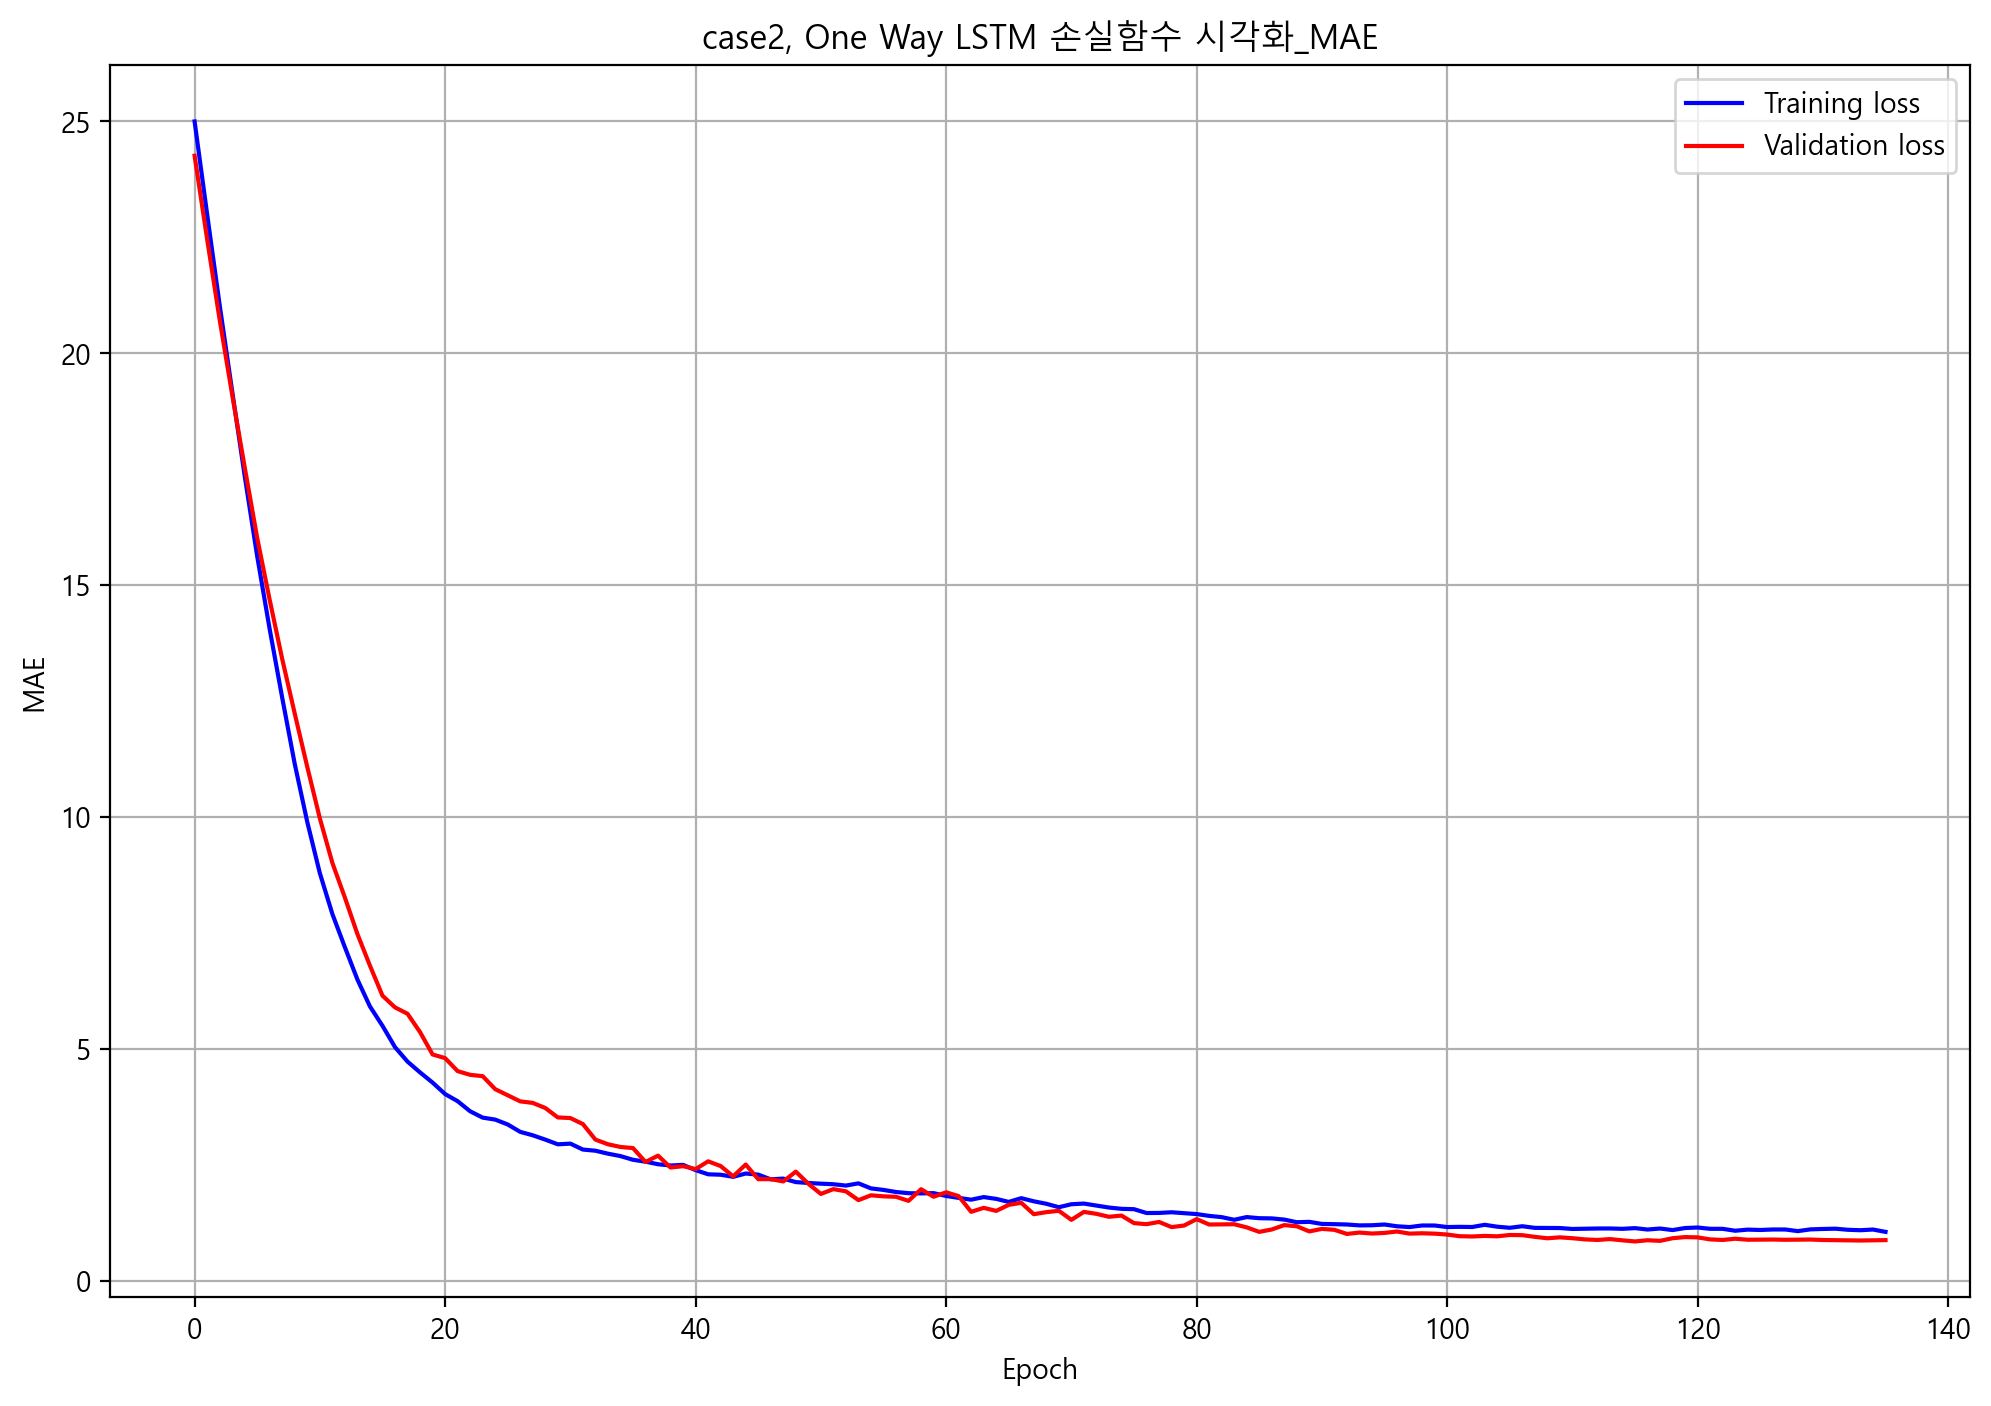

In [75]:
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization, Input, Embedding, Concatenate, Attention
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import legacy as legacy_optimizers
from tensorflow.keras import metrics

# Attention 레이어 정의
def attention_layer(inputs):
    attention = Attention()([inputs, inputs])
    return Concatenate()([inputs, attention])

# 옵티마이저 설정
initial_lr = 0.0005
optimizer = legacy_optimizers.Adam(learning_rate=initial_lr)

# 범주형 변수 설정
num_categories = 3
embedding_dim = 5

# 옵티마이저 및 콜백 설정
optimizer = Adam(learning_rate=initial_lr)
lr_restart = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# 모델 정의
numerical_input = Input(shape=(x_train_multi.shape[1], x_train_multi.shape[2]))
categorical_input = Input(shape=(x_train_label.shape[1], ))

# 임베딩 레이어
embedding = Embedding(input_dim=num_categories, output_dim=embedding_dim)(categorical_input)

# 입력 결합
combined_input = Concatenate(axis=-1)([numerical_input, embedding])

x = LSTM(128, return_sequences=True,
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(combined_input)
x = BatchNormalization()(x)
x = Dropout(0.3, seed = 40)(x)

x = LSTM(64, return_sequences=True,
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3, seed = 41)(x)

x = attention_layer(x)

x = LSTM(32, activation='relu',
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3, seed = 42)(x)

x = Dense(24, activation='relu')(x)
output = Dense(12)(x)

case2_uni_mae = Model(inputs=[numerical_input, categorical_input], outputs=output)
case2_uni_mae.compile(optimizer=optimizer, loss="mae")

# 모델 학습
case2_uni_mae_history = case2_uni_mae.fit(
    # 수치형 데이터와 범주형 데이터 분리    
    [x_train_multi, x_train_label],  
    y_train_multi,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    steps_per_epoch = x_train_multi.shape[0] // BATCH_SIZE, 
    validation_steps = x_val_multi.shape[0] // BATCH_SIZE,
    validation_data=([x_val_multi, x_val_label], y_val_multi),
    callbacks=[lr_restart, early_stop]
)

# 학습 결과 시각화
plot_train_history(case2_uni_mae_history, "case2, One Way LSTM", "MAE")

# 모델 저장
case2_uni_mae.save("./output/case2/case2_uni_mae.h5")

Epoch 1/300
16/16 [==============================] - 4s 56ms/step - loss: 39.1172 - val_loss: 40.2473 - lr: 5.0000e-04
Epoch 2/300
16/16 [==============================] - 0s 12ms/step - loss: 36.4617 - val_loss: 39.0069 - lr: 5.0000e-04
Epoch 3/300
16/16 [==============================] - 0s 12ms/step - loss: 34.0945 - val_loss: 37.2947 - lr: 5.0000e-04
Epoch 4/300
16/16 [==============================] - 0s 12ms/step - loss: 31.9666 - val_loss: 35.6459 - lr: 5.0000e-04
Epoch 5/300
16/16 [==============================] - 0s 12ms/step - loss: 29.7088 - val_loss: 33.8042 - lr: 5.0000e-04
Epoch 6/300
16/16 [==============================] - 0s 12ms/step - loss: 27.4474 - val_loss: 31.7737 - lr: 5.0000e-04
Epoch 7/300
16/16 [==============================] - 0s 13ms/step - loss: 25.4294 - val_loss: 29.1985 - lr: 5.0000e-04
Epoch 8/300
16/16 [==============================] - 0s 13ms/step - loss: 23.9417 - val_loss: 27.3564 - lr: 5.0000e-04
Epoch 9/300
16/16 [=============================

16/16 [==============================] - 0s 11ms/step - loss: 3.1245 - val_loss: 2.9140 - lr: 5.0000e-04
Epoch 71/300
16/16 [==============================] - 0s 11ms/step - loss: 3.0381 - val_loss: 2.7745 - lr: 5.0000e-04
Epoch 72/300
16/16 [==============================] - 0s 12ms/step - loss: 2.9831 - val_loss: 2.7375 - lr: 5.0000e-04
Epoch 73/300
16/16 [==============================] - 0s 11ms/step - loss: 2.9073 - val_loss: 2.7862 - lr: 5.0000e-04
Epoch 74/300
16/16 [==============================] - 0s 11ms/step - loss: 2.9042 - val_loss: 2.9210 - lr: 5.0000e-04
Epoch 75/300
16/16 [==============================] - 0s 12ms/step - loss: 2.8595 - val_loss: 2.5379 - lr: 5.0000e-04
Epoch 76/300
16/16 [==============================] - 0s 11ms/step - loss: 2.8602 - val_loss: 2.7470 - lr: 5.0000e-04
Epoch 77/300
16/16 [==============================] - 0s 11ms/step - loss: 2.5833 - val_loss: 2.4512 - lr: 5.0000e-04
Epoch 78/300
16/16 [==============================] - 0s 12ms/step - 

Epoch 137/300
16/16 [==============================] - 0s 11ms/step - loss: 1.3735 - val_loss: 1.0749 - lr: 1.2500e-04
Epoch 138/300
16/16 [==============================] - 0s 11ms/step - loss: 1.3334 - val_loss: 1.0445 - lr: 1.2500e-04
Epoch 139/300
16/16 [==============================] - 0s 11ms/step - loss: 1.3898 - val_loss: 1.0069 - lr: 1.2500e-04
Epoch 140/300
16/16 [==============================] - 0s 11ms/step - loss: 1.2824 - val_loss: 0.9931 - lr: 1.2500e-04
Epoch 141/300
16/16 [==============================] - 0s 11ms/step - loss: 1.3391 - val_loss: 0.9982 - lr: 1.2500e-04
Epoch 142/300
16/16 [==============================] - 0s 11ms/step - loss: 1.2651 - val_loss: 0.9976 - lr: 1.2500e-04
Epoch 143/300
16/16 [==============================] - 0s 12ms/step - loss: 1.2984 - val_loss: 0.9956 - lr: 1.2500e-04
Epoch 144/300
16/16 [==============================] - 0s 11ms/step - loss: 1.3113 - val_loss: 1.0530 - lr: 1.2500e-04
Epoch 145/300
16/16 [===========================

Epoch 200/300
16/16 [==============================] - 0s 11ms/step - loss: 1.1416 - val_loss: 0.8691 - lr: 3.9063e-06
Epoch 201/300
16/16 [==============================] - 0s 11ms/step - loss: 1.1593 - val_loss: 0.8683 - lr: 3.9063e-06
Epoch 202/300
16/16 [==============================] - 0s 11ms/step - loss: 1.1690 - val_loss: 0.8674 - lr: 3.9063e-06
Epoch 203/300
16/16 [==============================] - 0s 12ms/step - loss: 1.1750 - val_loss: 0.8665 - lr: 3.9063e-06
Epoch 204/300
16/16 [==============================] - 0s 11ms/step - loss: 1.1099 - val_loss: 0.8652 - lr: 3.9063e-06
Epoch 205/300
16/16 [==============================] - 0s 11ms/step - loss: 1.1624 - val_loss: 0.8654 - lr: 3.9063e-06
Epoch 206/300
16/16 [==============================] - 0s 11ms/step - loss: 1.1566 - val_loss: 0.8637 - lr: 3.9063e-06
Epoch 207/300
16/16 [==============================] - 0s 12ms/step - loss: 1.1589 - val_loss: 0.8617 - lr: 3.9063e-06
Epoch 208/300
16/16 [===========================

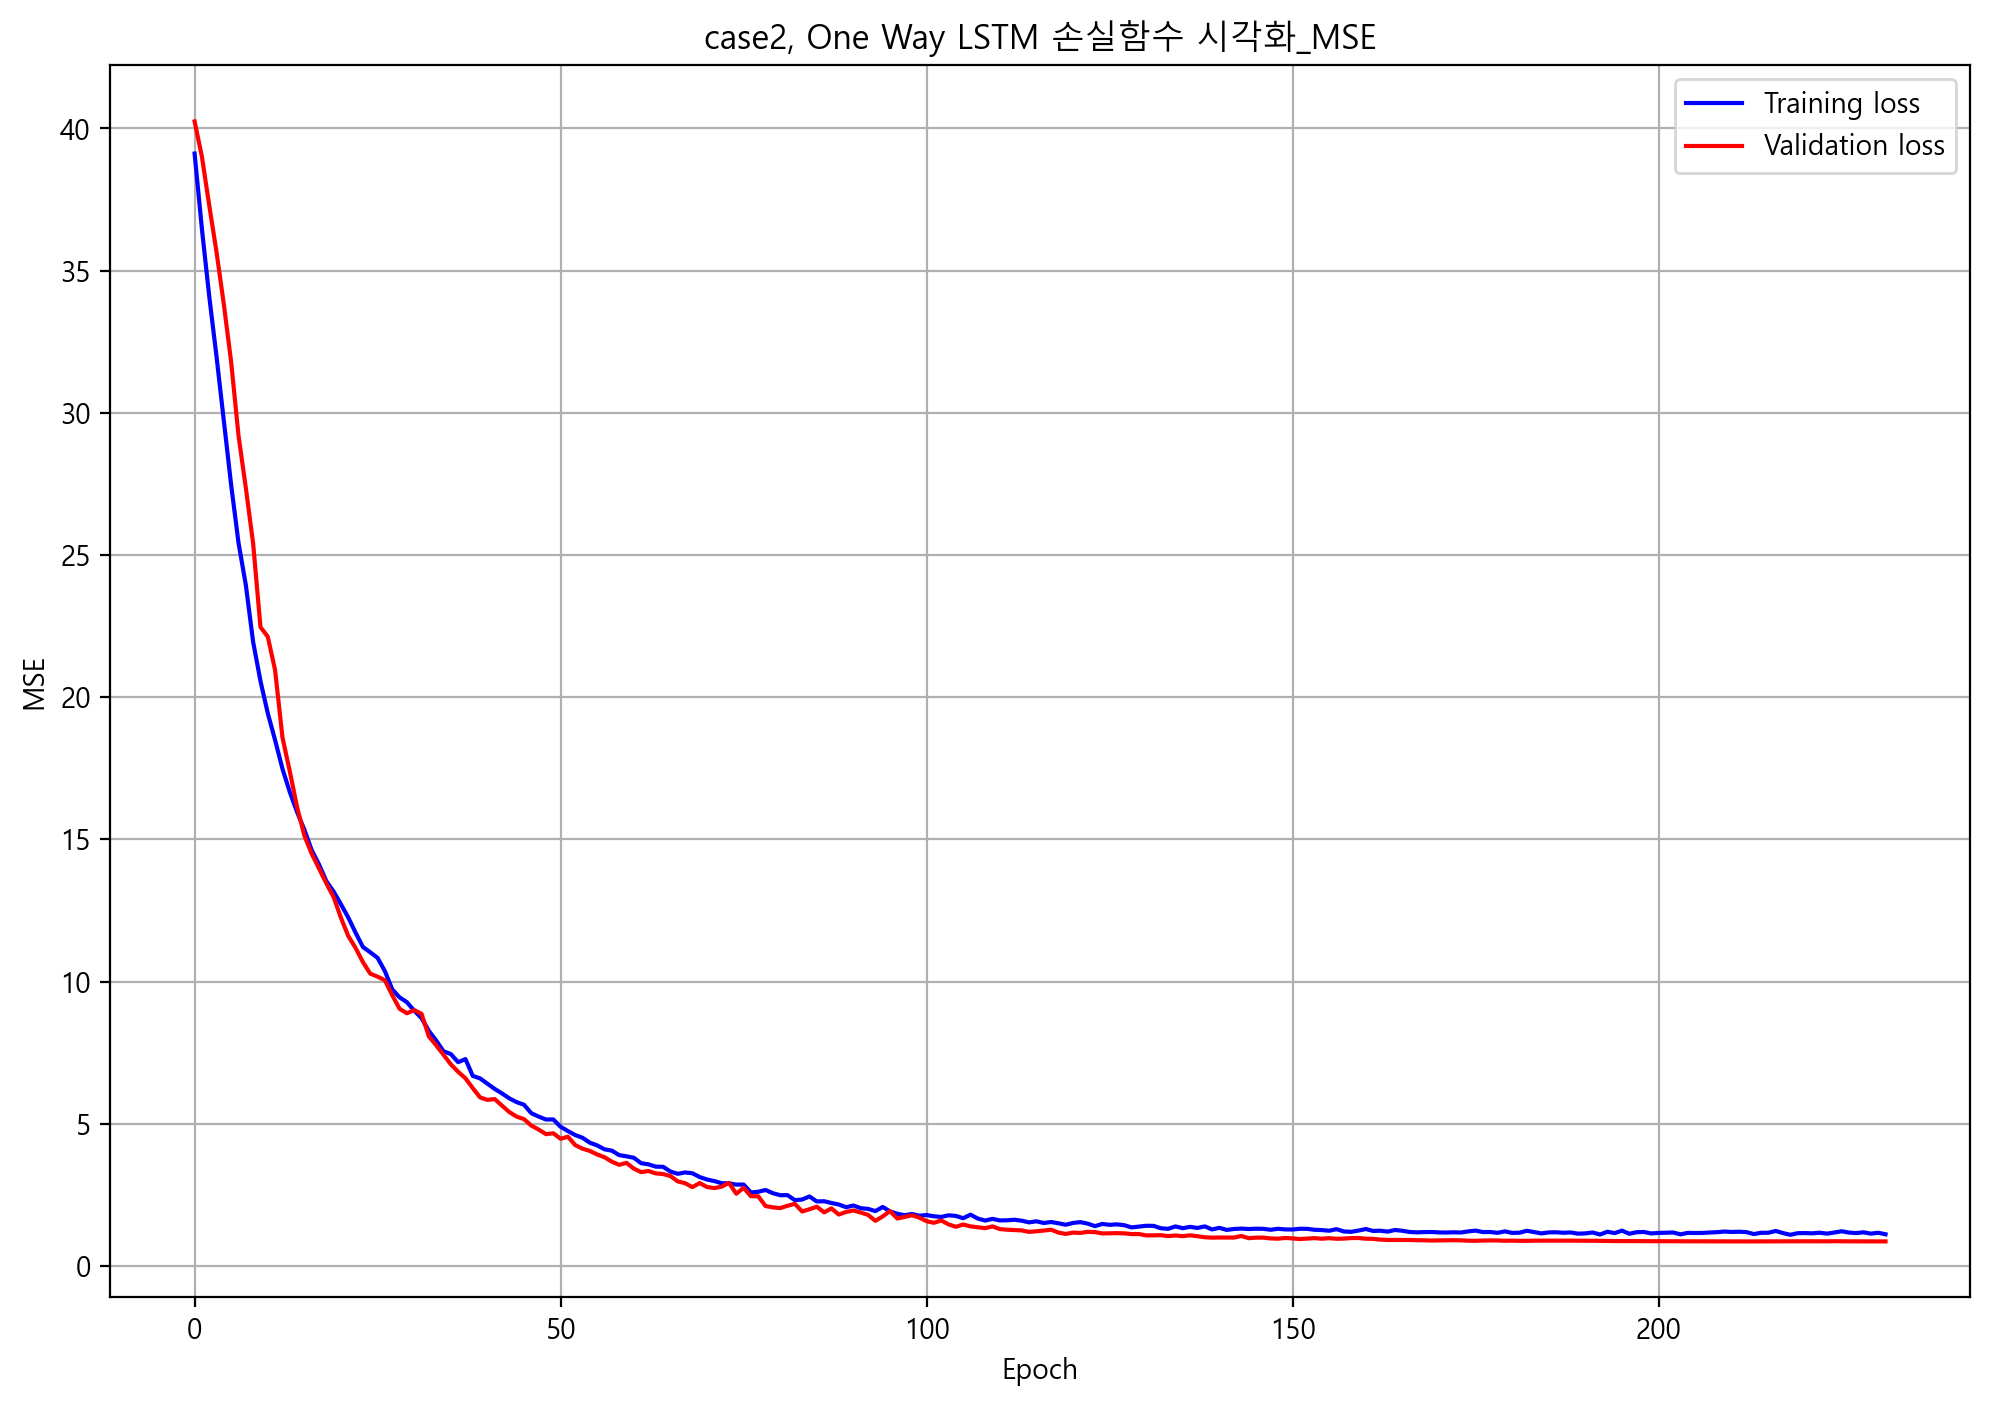

In [76]:
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization, Input, Embedding, Concatenate, Attention
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import legacy as legacy_optimizers
from tensorflow.keras import metrics

# Attention 레이어 정의
def attention_layer(inputs):
    attention = Attention()([inputs, inputs])
    return Concatenate()([inputs, attention])

# 옵티마이저 설정
initial_lr = 0.0005
optimizer = legacy_optimizers.Adam(learning_rate=initial_lr)

# 범주형 변수 설정
num_categories = 3
embedding_dim = 5

# 옵티마이저 및 콜백 설정
optimizer = Adam(learning_rate=initial_lr)
lr_restart = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# 모델 정의
numerical_input = Input(shape=(x_train_multi.shape[1], x_train_multi.shape[2]))
categorical_input = Input(shape=(x_train_label.shape[1], ))

# 임베딩 레이어
embedding = Embedding(input_dim=num_categories, output_dim=embedding_dim)(categorical_input)

# 입력 결합
combined_input = Concatenate(axis=-1)([numerical_input, embedding])

x = LSTM(128, return_sequences=True,
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(combined_input)
x = BatchNormalization()(x)
x = Dropout(0.3, seed = 40)(x)

x = LSTM(64, return_sequences=True,
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3, seed = 41)(x)

x = attention_layer(x)

x = LSTM(32, activation='relu',
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3, seed = 42)(x)

x = Dense(24, activation='relu')(x)
output = Dense(12)(x)

case2_uni_mse = Model(inputs=[numerical_input, categorical_input], outputs=output)
case2_uni_mse.compile(optimizer=optimizer, loss="mse")

# 모델 학습
case2_uni_mse_history = case2_uni_mse.fit(
    # 수치형 데이터와 범주형 데이터 분리    
    [x_train_multi, x_train_label],  
    y_train_multi,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    steps_per_epoch = x_train_multi.shape[0] // BATCH_SIZE, 
    validation_steps = x_val_multi.shape[0] // BATCH_SIZE,
    validation_data=([x_val_multi, x_val_label], y_val_multi),
    callbacks=[lr_restart, early_stop]
)

# 학습 결과 시각화
plot_train_history(case2_uni_mse_history, "case2, One Way LSTM", "MSE")

# 모델 저장
case2_uni_mse.save("./output/case2/case2_uni_mse.h5")

Epoch 1/300
16/16 [==============================] - 5s 86ms/step - loss: 40.8969 - root_mean_squared_error: 4.3922 - val_loss: 40.3336 - val_root_mean_squared_error: 4.3505 - lr: 5.0000e-04
Epoch 2/300
16/16 [==============================] - 0s 13ms/step - loss: 38.9363 - root_mean_squared_error: 4.2090 - val_loss: 39.5136 - val_root_mean_squared_error: 4.3020 - lr: 5.0000e-04
Epoch 3/300
16/16 [==============================] - 0s 12ms/step - loss: 36.5032 - root_mean_squared_error: 3.9609 - val_loss: 38.3717 - val_root_mean_squared_error: 4.2164 - lr: 5.0000e-04
Epoch 4/300
16/16 [==============================] - 0s 12ms/step - loss: 34.4271 - root_mean_squared_error: 3.7458 - val_loss: 37.0836 - val_root_mean_squared_error: 4.1125 - lr: 5.0000e-04
Epoch 5/300
16/16 [==============================] - 0s 12ms/step - loss: 32.2318 - root_mean_squared_error: 3.5020 - val_loss: 35.8630 - val_root_mean_squared_error: 4.0160 - lr: 5.0000e-04
Epoch 6/300
16/16 [==========================

Epoch 44/300
16/16 [==============================] - 0s 12ms/step - loss: 6.9817 - root_mean_squared_error: 0.8930 - val_loss: 6.3553 - val_root_mean_squared_error: 0.5109 - lr: 5.0000e-04
Epoch 45/300
16/16 [==============================] - 0s 12ms/step - loss: 6.7597 - root_mean_squared_error: 0.8608 - val_loss: 6.4238 - val_root_mean_squared_error: 0.6983 - lr: 5.0000e-04
Epoch 46/300
16/16 [==============================] - 0s 12ms/step - loss: 6.6184 - root_mean_squared_error: 0.8770 - val_loss: 6.0591 - val_root_mean_squared_error: 0.5568 - lr: 5.0000e-04
Epoch 47/300
16/16 [==============================] - 0s 12ms/step - loss: 6.4471 - root_mean_squared_error: 0.8798 - val_loss: 5.9430 - val_root_mean_squared_error: 0.5972 - lr: 5.0000e-04
Epoch 48/300
16/16 [==============================] - 0s 12ms/step - loss: 6.1871 - root_mean_squared_error: 0.8222 - val_loss: 5.8302 - val_root_mean_squared_error: 0.6323 - lr: 5.0000e-04
Epoch 49/300
16/16 [==============================

16/16 [==============================] - 0s 11ms/step - loss: 2.6532 - root_mean_squared_error: 0.7219 - val_loss: 2.6703 - val_root_mean_squared_error: 0.7438 - lr: 5.0000e-04
Epoch 88/300
13/16 [=======================>......] - ETA: 0s - loss: 2.6001 - root_mean_squared_error: 0.7120
Epoch 88: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
16/16 [==============================] - 0s 11ms/step - loss: 2.5832 - root_mean_squared_error: 0.7028 - val_loss: 2.7951 - val_root_mean_squared_error: 0.8526 - lr: 5.0000e-04
Epoch 89/300
16/16 [==============================] - 0s 12ms/step - loss: 2.4883 - root_mean_squared_error: 0.6655 - val_loss: 2.5704 - val_root_mean_squared_error: 0.7392 - lr: 2.5000e-04
Epoch 90/300
16/16 [==============================] - 0s 12ms/step - loss: 2.4164 - root_mean_squared_error: 0.6410 - val_loss: 2.4332 - val_root_mean_squared_error: 0.6662 - lr: 2.5000e-04
Epoch 91/300
16/16 [==============================] - 0s 12ms/step - loss: 2.5

16/16 [==============================] - 0s 12ms/step - loss: 1.7415 - root_mean_squared_error: 0.6538 - val_loss: 1.4738 - val_root_mean_squared_error: 0.4072 - lr: 2.5000e-04
Epoch 130/300
16/16 [==============================] - 0s 12ms/step - loss: 1.7106 - root_mean_squared_error: 0.6414 - val_loss: 1.5578 - val_root_mean_squared_error: 0.5124 - lr: 2.5000e-04
Epoch 131/300
16/16 [==============================] - 0s 12ms/step - loss: 1.7982 - root_mean_squared_error: 0.7057 - val_loss: 1.4181 - val_root_mean_squared_error: 0.3493 - lr: 2.5000e-04
Epoch 132/300
16/16 [==============================] - 0s 11ms/step - loss: 1.6855 - root_mean_squared_error: 0.6286 - val_loss: 1.3915 - val_root_mean_squared_error: 0.3329 - lr: 2.5000e-04
Epoch 133/300
16/16 [==============================] - 0s 12ms/step - loss: 1.6455 - root_mean_squared_error: 0.6163 - val_loss: 1.4009 - val_root_mean_squared_error: 0.3842 - lr: 2.5000e-04
Epoch 134/300
16/16 [==============================] - 0s 1

16/16 [==============================] - 0s 12ms/step - loss: 1.2573 - root_mean_squared_error: 0.6015 - val_loss: 0.9939 - val_root_mean_squared_error: 0.3160 - lr: 1.2500e-04
Epoch 172/300
16/16 [==============================] - 0s 12ms/step - loss: 1.2581 - root_mean_squared_error: 0.6035 - val_loss: 0.9843 - val_root_mean_squared_error: 0.3077 - lr: 1.2500e-04
Epoch 173/300
16/16 [==============================] - 0s 11ms/step - loss: 1.2161 - root_mean_squared_error: 0.5760 - val_loss: 0.9853 - val_root_mean_squared_error: 0.3232 - lr: 1.2500e-04
Epoch 174/300
16/16 [==============================] - 0s 12ms/step - loss: 1.2421 - root_mean_squared_error: 0.6027 - val_loss: 0.9807 - val_root_mean_squared_error: 0.3186 - lr: 1.2500e-04
Epoch 175/300
16/16 [==============================] - 0s 11ms/step - loss: 1.2597 - root_mean_squared_error: 0.6152 - val_loss: 0.9953 - val_root_mean_squared_error: 0.3359 - lr: 1.2500e-04
Epoch 176/300
16/16 [==============================] - 0s 1

13/16 [=======================>......] - ETA: 0s - loss: 1.0537 - root_mean_squared_error: 0.5628
Epoch 212: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
16/16 [==============================] - 0s 12ms/step - loss: 1.0799 - root_mean_squared_error: 0.5857 - val_loss: 0.8399 - val_root_mean_squared_error: 0.3226 - lr: 3.1250e-05
Epoch 213/300
16/16 [==============================] - 0s 12ms/step - loss: 1.1250 - root_mean_squared_error: 0.6248 - val_loss: 0.8370 - val_root_mean_squared_error: 0.3217 - lr: 1.5625e-05
Epoch 214/300
16/16 [==============================] - 0s 12ms/step - loss: 1.0585 - root_mean_squared_error: 0.5706 - val_loss: 0.8321 - val_root_mean_squared_error: 0.3152 - lr: 1.5625e-05
Epoch 215/300
16/16 [==============================] - 0s 12ms/step - loss: 1.0701 - root_mean_squared_error: 0.5810 - val_loss: 0.8403 - val_root_mean_squared_error: 0.3289 - lr: 1.5625e-05
Epoch 216/300
16/16 [==============================] - 0s 13ms/step - los

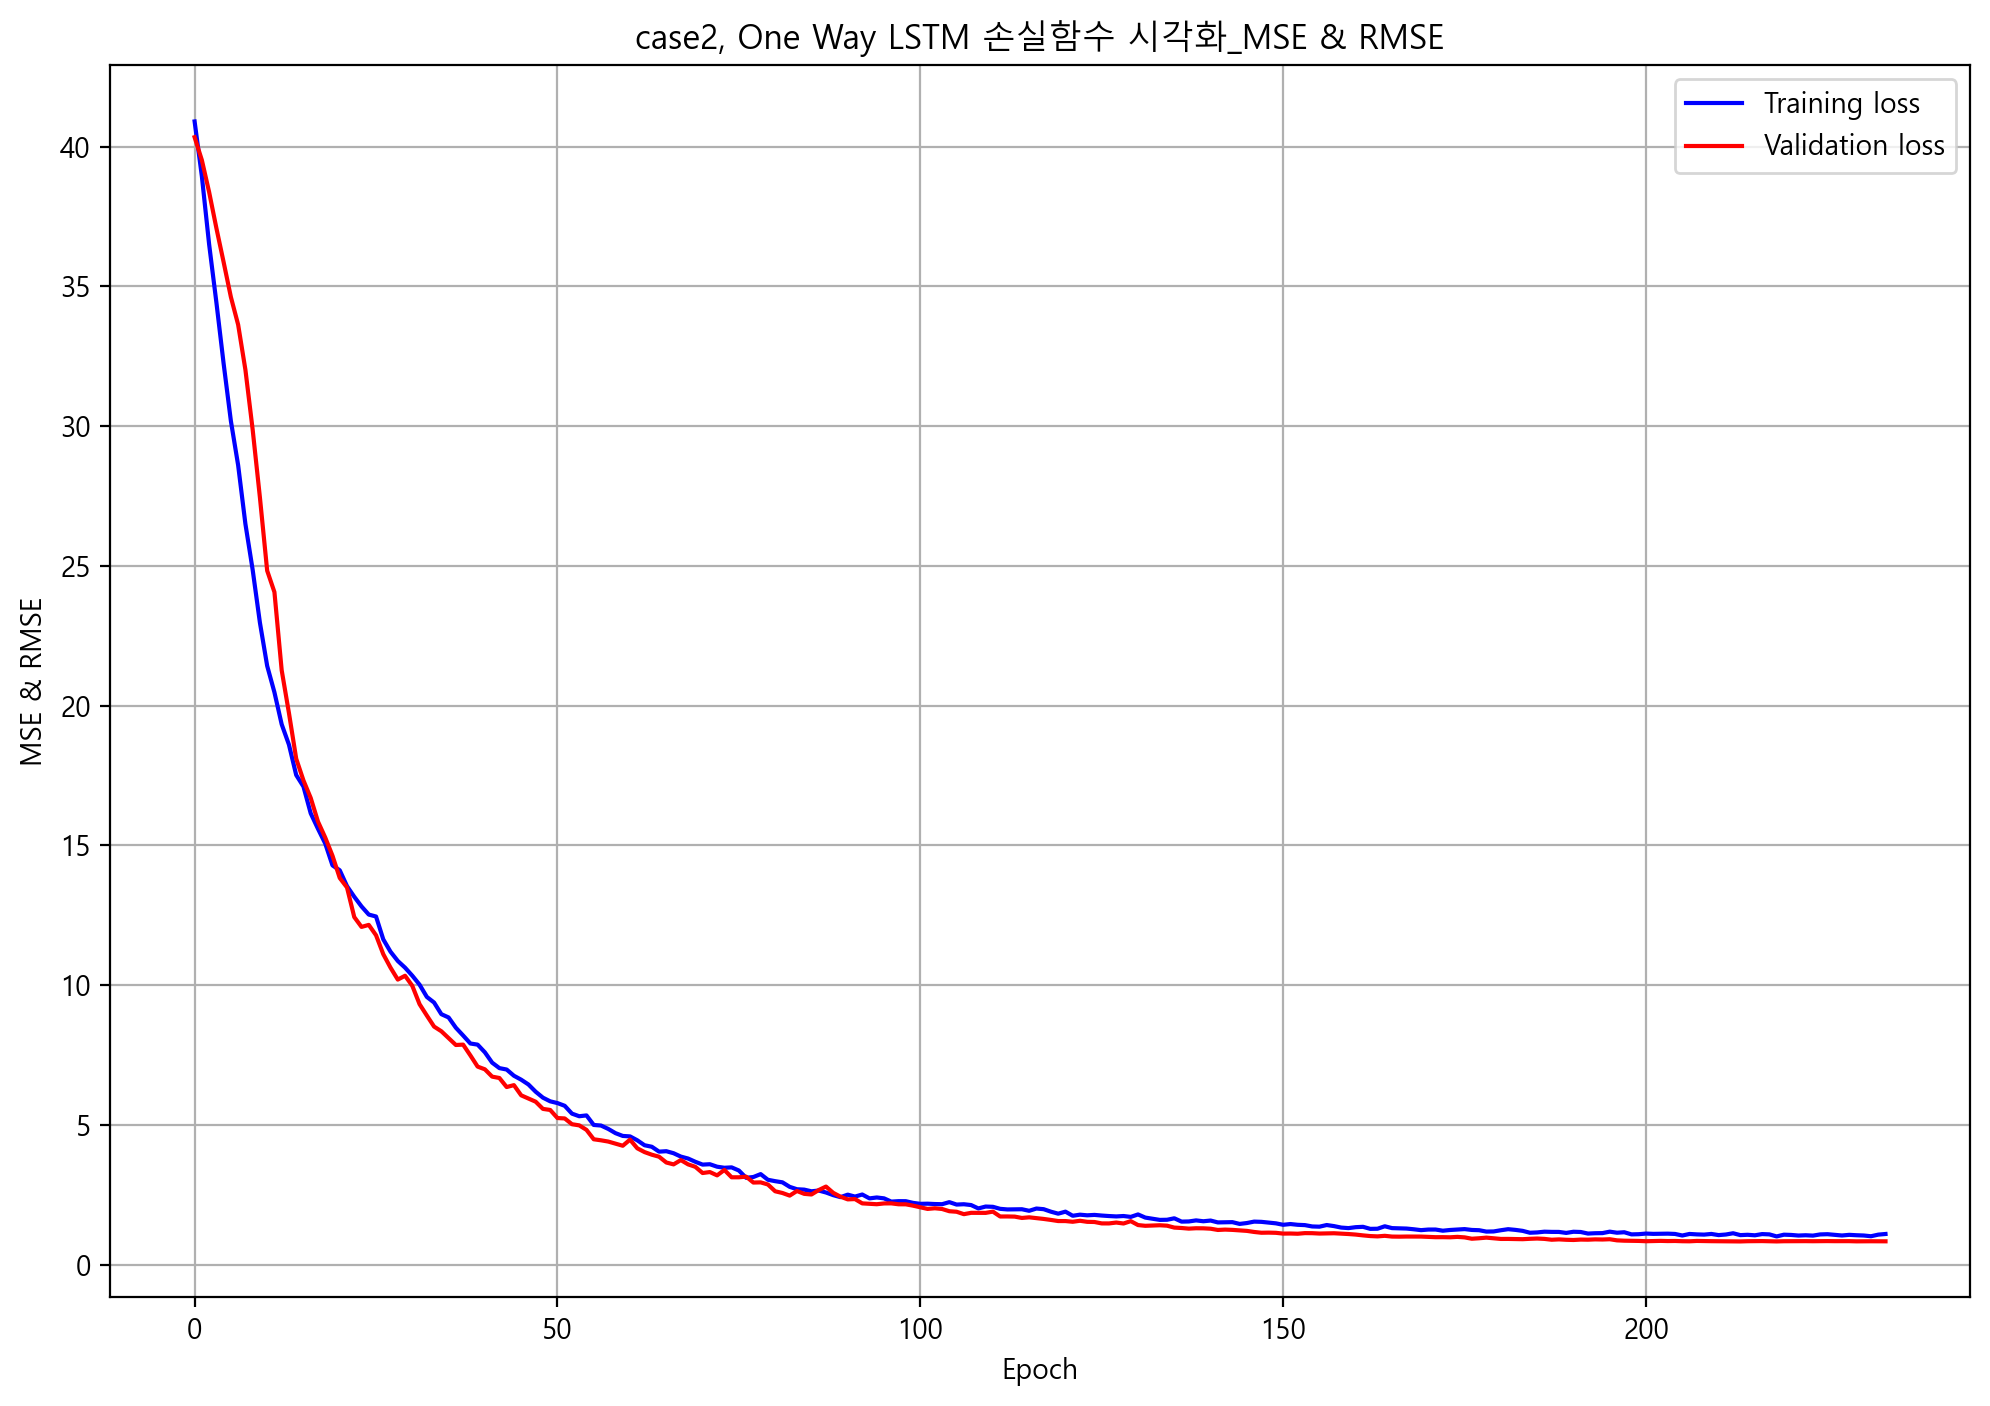

In [77]:
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization, Input, Embedding, Concatenate, Attention
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import legacy as legacy_optimizers
from tensorflow.keras import metrics

# Attention 레이어 정의
def attention_layer(inputs):
    attention = Attention()([inputs, inputs])
    return Concatenate()([inputs, attention])

# 옵티마이저 설정
initial_lr = 0.0005
optimizer = legacy_optimizers.Adam(learning_rate=initial_lr)

# 범주형 변수 설정
num_categories = 3
embedding_dim = 5

# 옵티마이저 및 콜백 설정
optimizer = Adam(learning_rate=initial_lr)
lr_restart = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# 모델 정의
numerical_input = Input(shape=(x_train_multi.shape[1], x_train_multi.shape[2]))
categorical_input = Input(shape=(x_train_label.shape[1], ))

# 임베딩 레이어
embedding = Embedding(input_dim=num_categories, output_dim=embedding_dim)(categorical_input)

# 입력 결합
combined_input = Concatenate(axis=-1)([numerical_input, embedding])

x = LSTM(128, return_sequences=True,
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(combined_input)
x = BatchNormalization()(x)
x = Dropout(0.3, seed = 40)(x)

x = LSTM(64, return_sequences=True,
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3, seed = 41)(x)

x = attention_layer(x)

x = LSTM(32, activation='relu',
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3, seed = 42)(x)

x = Dense(24, activation='relu')(x)
output = Dense(12)(x)

case2_uni_rmse = Model(inputs=[numerical_input, categorical_input], outputs=output)
case2_uni_rmse.compile(optimizer=optimizer
                       , loss="mse"
                       , metrics=[metrics.RootMeanSquaredError()]
                      )

# 모델 학습
case2_uni_rmse_history = case2_uni_rmse.fit(
    # 수치형 데이터와 범주형 데이터 분리    
    [x_train_multi, x_train_label],  
    y_train_multi,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    steps_per_epoch = x_train_multi.shape[0] // BATCH_SIZE, 
    validation_steps = x_val_multi.shape[0] // BATCH_SIZE,
    validation_data=([x_val_multi, x_val_label], y_val_multi),
    callbacks=[lr_restart, early_stop]
)

# 학습 결과 시각화
plot_train_history(case2_uni_rmse_history, "case2, One Way LSTM", "MSE & RMSE")

# 모델 저장
case2_uni_rmse.save("./output/case2/case2_uni_rmse.h5")

### 양방향 LSTM

Epoch 1/300
16/16 [==============================] - 6s 89ms/step - loss: 57.3152 - val_loss: 53.9460 - lr: 5.0000e-04
Epoch 2/300
16/16 [==============================] - 0s 17ms/step - loss: 50.6814 - val_loss: 47.7401 - lr: 5.0000e-04
Epoch 3/300
16/16 [==============================] - 0s 18ms/step - loss: 44.4825 - val_loss: 41.9913 - lr: 5.0000e-04
Epoch 4/300
16/16 [==============================] - 0s 18ms/step - loss: 38.8055 - val_loss: 36.7284 - lr: 5.0000e-04
Epoch 5/300
16/16 [==============================] - 0s 17ms/step - loss: 33.5482 - val_loss: 31.9475 - lr: 5.0000e-04
Epoch 6/300
16/16 [==============================] - 0s 18ms/step - loss: 28.7381 - val_loss: 27.6400 - lr: 5.0000e-04
Epoch 7/300
16/16 [==============================] - 0s 18ms/step - loss: 24.4345 - val_loss: 23.8648 - lr: 5.0000e-04
Epoch 8/300
16/16 [==============================] - 0s 18ms/step - loss: 20.5819 - val_loss: 20.4711 - lr: 5.0000e-04
Epoch 9/300
16/16 [=============================

Epoch 68/300
16/16 [==============================] - 0s 17ms/step - loss: 2.5525 - val_loss: 2.3769 - lr: 1.2500e-04
Epoch 69/300
16/16 [==============================] - 0s 17ms/step - loss: 2.5028 - val_loss: 2.3000 - lr: 1.2500e-04
Epoch 70/300
16/16 [==============================] - 0s 17ms/step - loss: 2.5019 - val_loss: 2.2793 - lr: 1.2500e-04
Epoch 71/300
16/16 [==============================] - 0s 17ms/step - loss: 2.4602 - val_loss: 2.2753 - lr: 1.2500e-04
Epoch 72/300
16/16 [==============================] - 0s 17ms/step - loss: 2.4877 - val_loss: 2.2226 - lr: 1.2500e-04
Epoch 73/300
16/16 [==============================] - 0s 18ms/step - loss: 2.4408 - val_loss: 2.2983 - lr: 1.2500e-04
Epoch 74/300
16/16 [==============================] - 0s 18ms/step - loss: 2.4628 - val_loss: 2.2307 - lr: 1.2500e-04
Epoch 75/300
16/16 [==============================] - 0s 17ms/step - loss: 2.4414 - val_loss: 2.2150 - lr: 1.2500e-04
Epoch 76/300
16/16 [==============================] - 0s

Epoch 136/300
16/16 [==============================] - 0s 18ms/step - loss: 1.9532 - val_loss: 1.7385 - lr: 6.2500e-05
Epoch 137/300
13/16 [=======================>......] - ETA: 0s - loss: 1.9271
Epoch 137: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
16/16 [==============================] - 0s 17ms/step - loss: 1.9248 - val_loss: 1.7353 - lr: 6.2500e-05
Epoch 138/300
16/16 [==============================] - 0s 17ms/step - loss: 1.9378 - val_loss: 1.7247 - lr: 3.1250e-05
Epoch 139/300
16/16 [==============================] - 0s 17ms/step - loss: 1.9703 - val_loss: 1.6967 - lr: 3.1250e-05
Epoch 140/300
16/16 [==============================] - 0s 17ms/step - loss: 1.9194 - val_loss: 1.7078 - lr: 3.1250e-05
Epoch 141/300
16/16 [==============================] - 0s 16ms/step - loss: 1.9578 - val_loss: 1.6999 - lr: 3.1250e-05
Epoch 142/300
16/16 [==============================] - 0s 17ms/step - loss: 1.9192 - val_loss: 1.6855 - lr: 3.1250e-05
Epoch 143/300
16/16 [====

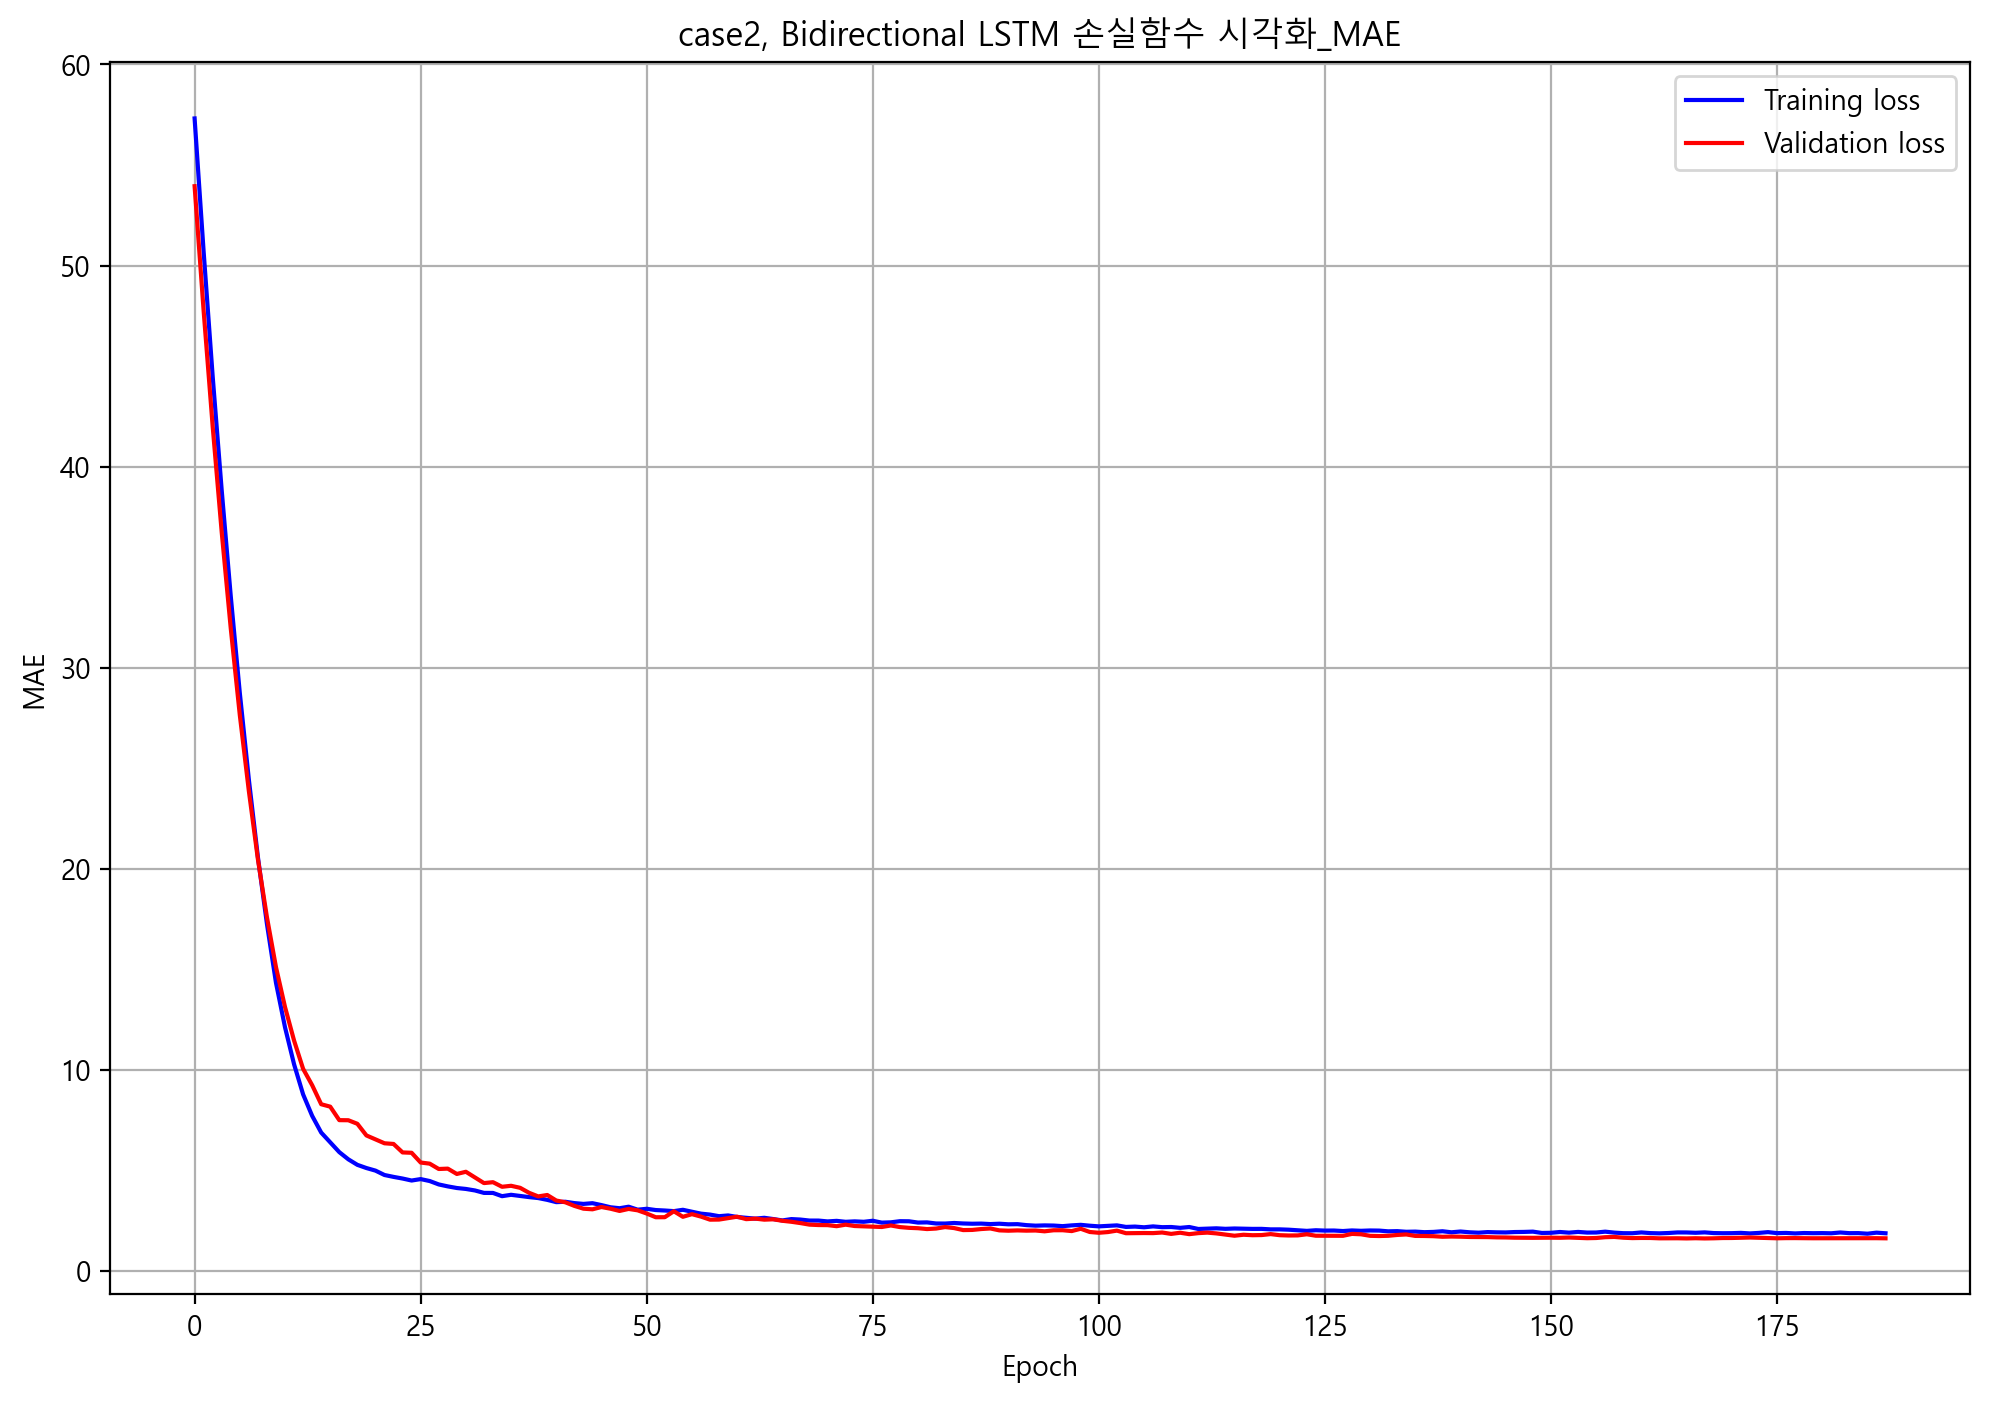

In [78]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization, Input, Embedding, Concatenate, Attention, Bidirectional
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import legacy as legacy_optimizers
from tensorflow.keras import metrics

# Attention 레이어 정의
def attention_layer(inputs):
    attention = Attention()([inputs, inputs])
    return Concatenate()([inputs, attention])

# 옵티마이저 설정
initial_lr = 0.0005
optimizer = legacy_optimizers.Adam(learning_rate=initial_lr)

# 범주형 변수 설정
num_categories = 3
embedding_dim = 5

# 옵티마이저 및 콜백 설정
optimizer = Adam(learning_rate=initial_lr)
lr_restart = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# 모델 정의
numerical_input = Input(shape=(x_train_multi.shape[1], x_train_multi.shape[2]))
categorical_input = Input(shape=(x_train_label.shape[1], ))

# 임베딩 레이어
embedding = Embedding(input_dim=num_categories, output_dim=embedding_dim)(categorical_input)

# 입력 결합
combined_input = Concatenate(axis=-1)([numerical_input, embedding])

x = Bidirectional(LSTM(128, return_sequences=True,
                   kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                   bias_regularizer=l1_l2(l1=0.005, l2=0.005)))(combined_input)
x = BatchNormalization()(x)
x = Dropout(0.3, seed = 40)(x)

x = Bidirectional(LSTM(64, return_sequences=True,
                   kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                   bias_regularizer=l1_l2(l1=0.005, l2=0.005)))(x)
x = BatchNormalization()(x)
x = Dropout(0.3, seed = 41)(x)

x = attention_layer(x)

x = LSTM(32, activation='relu',
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3, seed = 42)(x)

x = Dense(24, activation='relu')(x)
output = Dense(12)(x)

case2_bi_mae = Model(inputs=[numerical_input, categorical_input], outputs=output)
case2_bi_mae.compile(optimizer=optimizer, loss="mae")

# 모델 학습
case2_bi_mae_history = case2_bi_mae.fit(
    # 수치형 데이터와 범주형 데이터 분리    
    [x_train_multi, x_train_label],  
    y_train_multi,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    steps_per_epoch = x_train_multi.shape[0] // BATCH_SIZE, 
    validation_steps = x_val_multi.shape[0] // BATCH_SIZE,
    validation_data=([x_val_multi, x_val_label], y_val_multi),
    callbacks=[lr_restart, early_stop]
)

# 학습 결과 시각화
plot_train_history(case2_bi_mae_history, "case2, Bidirectional LSTM", "MAE")

case2_bi_mae.save("./output/case2/case2_bi_mae.h5")

Epoch 1/300
16/16 [==============================] - 6s 89ms/step - loss: 73.8760 - val_loss: 73.2851 - lr: 5.0000e-04
Epoch 2/300
16/16 [==============================] - 0s 18ms/step - loss: 69.8664 - val_loss: 70.8275 - lr: 5.0000e-04
Epoch 3/300
16/16 [==============================] - 0s 17ms/step - loss: 65.8233 - val_loss: 68.1702 - lr: 5.0000e-04
Epoch 4/300
16/16 [==============================] - 0s 17ms/step - loss: 61.7897 - val_loss: 65.3873 - lr: 5.0000e-04
Epoch 5/300
16/16 [==============================] - 0s 17ms/step - loss: 57.4797 - val_loss: 62.4290 - lr: 5.0000e-04
Epoch 6/300
16/16 [==============================] - 0s 19ms/step - loss: 53.2272 - val_loss: 59.3094 - lr: 5.0000e-04
Epoch 7/300
16/16 [==============================] - 0s 18ms/step - loss: 49.1088 - val_loss: 56.0257 - lr: 5.0000e-04
Epoch 8/300
16/16 [==============================] - 0s 17ms/step - loss: 45.3494 - val_loss: 52.3954 - lr: 5.0000e-04
Epoch 9/300
16/16 [=============================

Epoch 70/300
16/16 [==============================] - 0s 17ms/step - loss: 3.6331 - val_loss: 3.7587 - lr: 5.0000e-04
Epoch 71/300
16/16 [==============================] - 0s 17ms/step - loss: 3.6910 - val_loss: 3.8030 - lr: 5.0000e-04
Epoch 72/300
16/16 [==============================] - 0s 18ms/step - loss: 3.6126 - val_loss: 3.8242 - lr: 5.0000e-04
Epoch 73/300
16/16 [==============================] - 0s 17ms/step - loss: 3.4170 - val_loss: 3.5384 - lr: 5.0000e-04
Epoch 74/300
16/16 [==============================] - 0s 17ms/step - loss: 3.2528 - val_loss: 3.4574 - lr: 5.0000e-04
Epoch 75/300
16/16 [==============================] - 0s 17ms/step - loss: 3.2056 - val_loss: 3.4048 - lr: 5.0000e-04
Epoch 76/300
16/16 [==============================] - 0s 17ms/step - loss: 3.3056 - val_loss: 3.8200 - lr: 5.0000e-04
Epoch 77/300
16/16 [==============================] - 0s 17ms/step - loss: 3.0590 - val_loss: 3.0700 - lr: 5.0000e-04
Epoch 78/300
16/16 [==============================] - 0s

Epoch 137/300
16/16 [==============================] - 0s 17ms/step - loss: 1.4571 - val_loss: 1.2546 - lr: 1.2500e-04
Epoch 138/300
16/16 [==============================] - 0s 17ms/step - loss: 1.4842 - val_loss: 1.2461 - lr: 1.2500e-04
Epoch 139/300
16/16 [==============================] - 0s 17ms/step - loss: 1.4914 - val_loss: 1.2472 - lr: 1.2500e-04
Epoch 140/300
16/16 [==============================] - 0s 17ms/step - loss: 1.4391 - val_loss: 1.4293 - lr: 1.2500e-04
Epoch 141/300
13/16 [=======================>......] - ETA: 0s - loss: 1.5075
Epoch 141: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
16/16 [==============================] - 0s 17ms/step - loss: 1.5168 - val_loss: 1.3498 - lr: 1.2500e-04
Epoch 142/300
16/16 [==============================] - 0s 17ms/step - loss: 1.4696 - val_loss: 1.1813 - lr: 6.2500e-05
Epoch 143/300
16/16 [==============================] - 0s 17ms/step - loss: 1.4731 - val_loss: 1.1540 - lr: 6.2500e-05
Epoch 144/300
16/16 [=====

Epoch 200/300
13/16 [=======================>......] - ETA: 0s - loss: 1.3169
Epoch 200: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.
16/16 [==============================] - 0s 17ms/step - loss: 1.3048 - val_loss: 1.0133 - lr: 3.9063e-06
Epoch 201/300
16/16 [==============================] - 0s 17ms/step - loss: 1.2990 - val_loss: 1.0137 - lr: 1.9531e-06
Epoch 202/300
16/16 [==============================] - 0s 17ms/step - loss: 1.3013 - val_loss: 1.0147 - lr: 1.9531e-06
Epoch 203/300
16/16 [==============================] - 0s 17ms/step - loss: 1.3770 - val_loss: 1.0208 - lr: 1.9531e-06
Epoch 204/300
16/16 [==============================] - 0s 17ms/step - loss: 1.2606 - val_loss: 1.0183 - lr: 1.9531e-06
Epoch 205/300
13/16 [=======================>......] - ETA: 0s - loss: 1.3015
Epoch 205: ReduceLROnPlateau reducing learning rate to 1e-06.
16/16 [==============================] - 0s 17ms/step - loss: 1.2939 - val_loss: 1.0173 - lr: 1.9531e-06


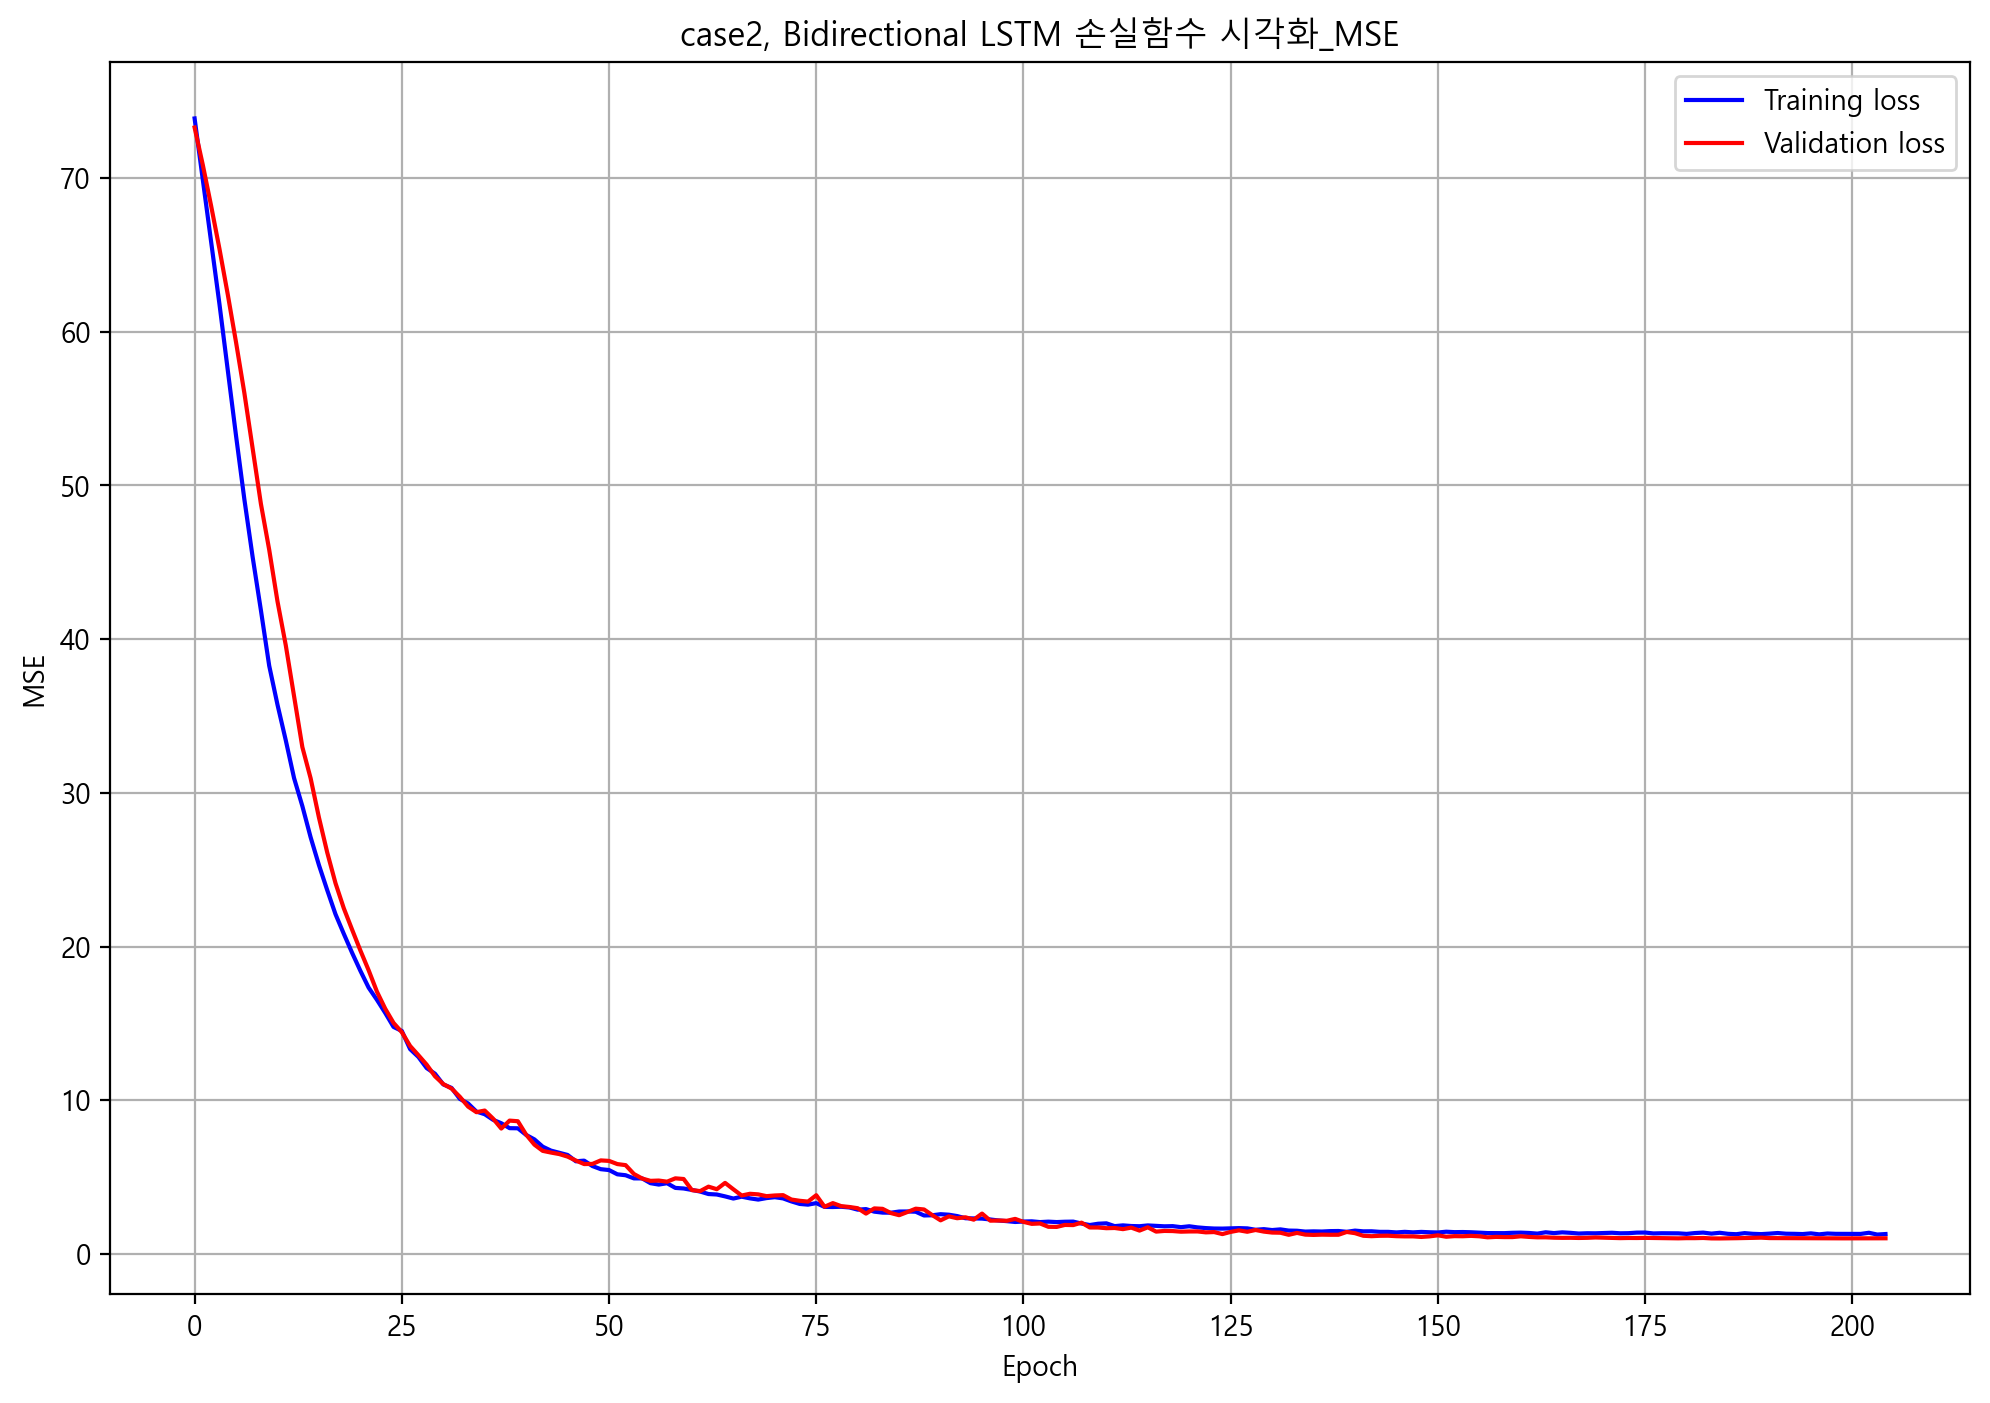

In [79]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization, Input, Embedding, Concatenate, Attention, Bidirectional
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import legacy as legacy_optimizers
from tensorflow.keras import metrics

# Attention 레이어 정의
def attention_layer(inputs):
    attention = Attention()([inputs, inputs])
    return Concatenate()([inputs, attention])

# 옵티마이저 설정
initial_lr = 0.0005
optimizer = legacy_optimizers.Adam(learning_rate=initial_lr)

# 범주형 변수 설정
num_categories = 3
embedding_dim = 5

# 옵티마이저 및 콜백 설정
optimizer = Adam(learning_rate=initial_lr)
lr_restart = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# 모델 정의
numerical_input = Input(shape=(x_train_multi.shape[1], x_train_multi.shape[2]))
categorical_input = Input(shape=(x_train_label.shape[1], ))

# 임베딩 레이어
embedding = Embedding(input_dim=num_categories, output_dim=embedding_dim)(categorical_input)

# 입력 결합
combined_input = Concatenate(axis=-1)([numerical_input, embedding])

x = Bidirectional(LSTM(128, return_sequences=True,
                   kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                   bias_regularizer=l1_l2(l1=0.005, l2=0.005)))(combined_input)
x = BatchNormalization()(x)
x = Dropout(0.3, seed = 40)(x)

x = Bidirectional(LSTM(64, return_sequences=True,
                   kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                   bias_regularizer=l1_l2(l1=0.005, l2=0.005)))(x)
x = BatchNormalization()(x)
x = Dropout(0.3, seed = 41)(x)

x = attention_layer(x)

x = LSTM(32, activation='relu',
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3, seed = 42)(x)

x = Dense(24, activation='relu')(x)
output = Dense(12)(x)

case2_bi_mse = Model(inputs=[numerical_input, categorical_input], outputs=output)
case2_bi_mse.compile(optimizer=optimizer, loss="mse")

# 모델 학습
case2_bi_mse_history = case2_bi_mse.fit(
    # 수치형 데이터와 범주형 데이터 분리    
    [x_train_multi, x_train_label],  
    y_train_multi,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    steps_per_epoch = x_train_multi.shape[0] // BATCH_SIZE, 
    validation_steps = x_val_multi.shape[0] // BATCH_SIZE,
    validation_data=([x_val_multi, x_val_label], y_val_multi),
    callbacks=[lr_restart, early_stop]
)

# 학습 결과 시각화
plot_train_history(case2_bi_mse_history, "case2, Bidirectional LSTM", "MSE")

# case2_bi_label.save("./output/case2/case2_lstm_bi_label_mae.h5")
case2_bi_mse.save("./output/case2/case2_bi_mse.h5")

Epoch 1/300
16/16 [==============================] - 7s 89ms/step - loss: 74.0454 - root_mean_squared_error: 4.3427 - val_loss: 72.9179 - val_root_mean_squared_error: 4.3599 - lr: 5.0000e-04
Epoch 2/300
16/16 [==============================] - 0s 18ms/step - loss: 70.1439 - root_mean_squared_error: 4.1740 - val_loss: 69.9350 - val_root_mean_squared_error: 4.3101 - lr: 5.0000e-04
Epoch 3/300
16/16 [==============================] - 0s 18ms/step - loss: 65.8693 - root_mean_squared_error: 3.9641 - val_loss: 66.6644 - val_root_mean_squared_error: 4.2268 - lr: 5.0000e-04
Epoch 4/300
16/16 [==============================] - 0s 17ms/step - loss: 61.9953 - root_mean_squared_error: 3.7930 - val_loss: 63.4383 - val_root_mean_squared_error: 4.1429 - lr: 5.0000e-04
Epoch 5/300
16/16 [==============================] - 0s 17ms/step - loss: 57.8850 - root_mean_squared_error: 3.5751 - val_loss: 60.1010 - val_root_mean_squared_error: 4.0403 - lr: 5.0000e-04
Epoch 6/300
16/16 [==========================

Epoch 44/300
16/16 [==============================] - 0s 17ms/step - loss: 6.3794 - root_mean_squared_error: 0.8860 - val_loss: 6.2870 - val_root_mean_squared_error: 0.8801 - lr: 5.0000e-04
Epoch 45/300
16/16 [==============================] - 0s 17ms/step - loss: 6.3380 - root_mean_squared_error: 0.9474 - val_loss: 6.8313 - val_root_mean_squared_error: 1.1962 - lr: 5.0000e-04
Epoch 46/300
16/16 [==============================] - 0s 16ms/step - loss: 6.3811 - root_mean_squared_error: 0.9418 - val_loss: 6.3114 - val_root_mean_squared_error: 0.9220 - lr: 5.0000e-04
Epoch 47/300
16/16 [==============================] - 0s 17ms/step - loss: 6.1188 - root_mean_squared_error: 0.9013 - val_loss: 6.0643 - val_root_mean_squared_error: 0.9455 - lr: 5.0000e-04
Epoch 48/300
16/16 [==============================] - 0s 17ms/step - loss: 5.7198 - root_mean_squared_error: 0.8271 - val_loss: 5.8741 - val_root_mean_squared_error: 0.9941 - lr: 5.0000e-04
Epoch 49/300
16/16 [==============================

16/16 [==============================] - 0s 17ms/step - loss: 2.6197 - root_mean_squared_error: 0.7634 - val_loss: 2.3356 - val_root_mean_squared_error: 0.5704 - lr: 5.0000e-04
Epoch 88/300
16/16 [==============================] - 0s 17ms/step - loss: 2.5453 - root_mean_squared_error: 0.7481 - val_loss: 2.3968 - val_root_mean_squared_error: 0.6569 - lr: 5.0000e-04
Epoch 89/300
16/16 [==============================] - 0s 17ms/step - loss: 2.4673 - root_mean_squared_error: 0.7308 - val_loss: 2.2875 - val_root_mean_squared_error: 0.6184 - lr: 5.0000e-04
Epoch 90/300
16/16 [==============================] - 0s 18ms/step - loss: 2.3363 - root_mean_squared_error: 0.6692 - val_loss: 1.9994 - val_root_mean_squared_error: 0.3426 - lr: 5.0000e-04
Epoch 91/300
16/16 [==============================] - 0s 17ms/step - loss: 2.3910 - root_mean_squared_error: 0.7102 - val_loss: 2.0704 - val_root_mean_squared_error: 0.4279 - lr: 5.0000e-04
Epoch 92/300
16/16 [==============================] - 0s 17ms/s

16/16 [==============================] - 0s 19ms/step - loss: 1.3094 - root_mean_squared_error: 0.6618 - val_loss: 1.0276 - val_root_mean_squared_error: 0.3949 - lr: 5.0000e-04
Epoch 131/300
16/16 [==============================] - 0s 17ms/step - loss: 1.2211 - root_mean_squared_error: 0.5997 - val_loss: 1.0617 - val_root_mean_squared_error: 0.4782 - lr: 5.0000e-04
Epoch 132/300
16/16 [==============================] - 0s 17ms/step - loss: 1.2673 - root_mean_squared_error: 0.6613 - val_loss: 0.9696 - val_root_mean_squared_error: 0.3813 - lr: 5.0000e-04
Epoch 133/300
16/16 [==============================] - 0s 17ms/step - loss: 1.2341 - root_mean_squared_error: 0.6352 - val_loss: 0.9473 - val_root_mean_squared_error: 0.3509 - lr: 5.0000e-04
Epoch 134/300
16/16 [==============================] - 0s 16ms/step - loss: 1.1261 - root_mean_squared_error: 0.5787 - val_loss: 0.8671 - val_root_mean_squared_error: 0.3344 - lr: 5.0000e-04
Epoch 135/300
16/16 [==============================] - 0s 1

Epoch 173/300
16/16 [==============================] - 0s 17ms/step - loss: 0.6157 - root_mean_squared_error: 0.5748 - val_loss: 0.3891 - val_root_mean_squared_error: 0.2961 - lr: 5.0000e-04
Epoch 174/300
16/16 [==============================] - 0s 17ms/step - loss: 0.5389 - root_mean_squared_error: 0.5072 - val_loss: 0.3523 - val_root_mean_squared_error: 0.2911 - lr: 5.0000e-04
Epoch 175/300
16/16 [==============================] - 0s 17ms/step - loss: 0.5225 - root_mean_squared_error: 0.5181 - val_loss: 0.3230 - val_root_mean_squared_error: 0.2813 - lr: 5.0000e-04
Epoch 176/300
16/16 [==============================] - 0s 17ms/step - loss: 0.5552 - root_mean_squared_error: 0.5502 - val_loss: 0.3088 - val_root_mean_squared_error: 0.2138 - lr: 5.0000e-04
Epoch 177/300
16/16 [==============================] - 0s 17ms/step - loss: 0.5565 - root_mean_squared_error: 0.5375 - val_loss: 0.3157 - val_root_mean_squared_error: 0.2195 - lr: 5.0000e-04
Epoch 178/300
16/16 [========================

16/16 [==============================] - 0s 17ms/step - loss: 0.3505 - root_mean_squared_error: 0.4560 - val_loss: 0.1987 - val_root_mean_squared_error: 0.2373 - lr: 2.5000e-04
Epoch 215/300
16/16 [==============================] - 0s 17ms/step - loss: 0.3360 - root_mean_squared_error: 0.4498 - val_loss: 0.1801 - val_root_mean_squared_error: 0.2258 - lr: 1.2500e-04
Epoch 216/300
16/16 [==============================] - 0s 19ms/step - loss: 0.3392 - root_mean_squared_error: 0.4604 - val_loss: 0.1767 - val_root_mean_squared_error: 0.2252 - lr: 1.2500e-04
Epoch 217/300
16/16 [==============================] - 0s 17ms/step - loss: 0.3489 - root_mean_squared_error: 0.4718 - val_loss: 0.1776 - val_root_mean_squared_error: 0.2305 - lr: 1.2500e-04
Epoch 218/300
16/16 [==============================] - 0s 18ms/step - loss: 0.3151 - root_mean_squared_error: 0.4389 - val_loss: 0.1759 - val_root_mean_squared_error: 0.2323 - lr: 1.2500e-04
Epoch 219/300
16/16 [==============================] - 0s 1

16/16 [==============================] - 0s 17ms/step - loss: 0.2999 - root_mean_squared_error: 0.4523 - val_loss: 0.1456 - val_root_mean_squared_error: 0.2246 - lr: 1.5625e-05
Epoch 255/300
16/16 [==============================] - 0s 17ms/step - loss: 0.2813 - root_mean_squared_error: 0.4316 - val_loss: 0.1470 - val_root_mean_squared_error: 0.2279 - lr: 1.5625e-05
Epoch 256/300
16/16 [==============================] - 0s 17ms/step - loss: 0.3006 - root_mean_squared_error: 0.4520 - val_loss: 0.1505 - val_root_mean_squared_error: 0.2319 - lr: 1.5625e-05
Epoch 257/300
16/16 [==============================] - 0s 17ms/step - loss: 0.2796 - root_mean_squared_error: 0.4283 - val_loss: 0.1494 - val_root_mean_squared_error: 0.2320 - lr: 1.5625e-05
Epoch 258/300
13/16 [=======================>......] - ETA: 0s - loss: 0.3035 - root_mean_squared_error: 0.4562
Epoch 258: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.
16/16 [==============================] - 0s 17ms/step - loss

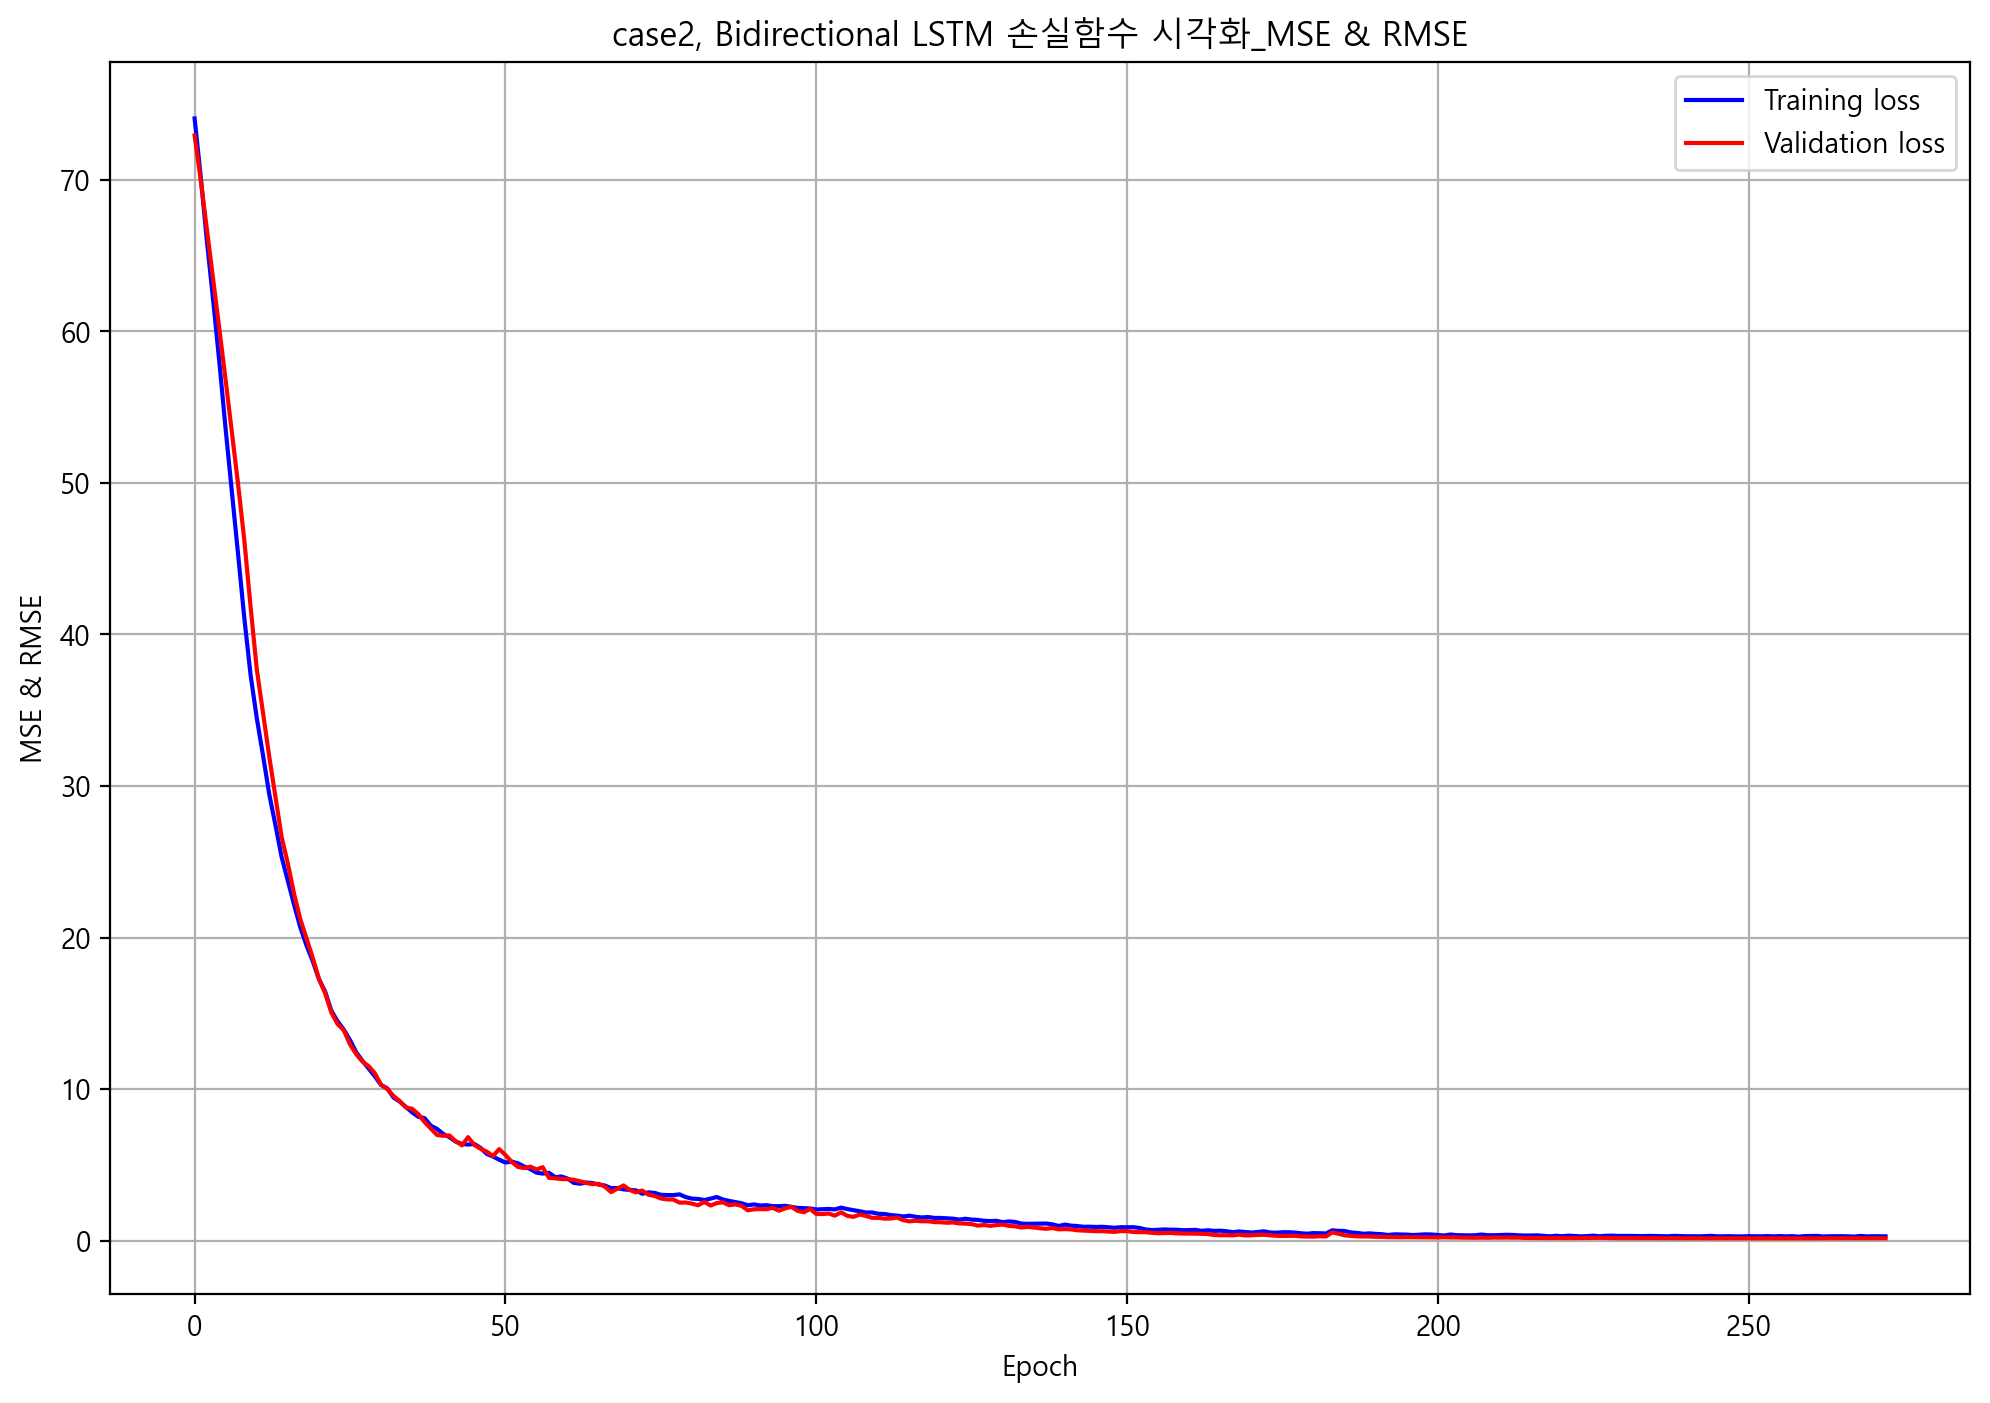

In [80]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization, Input, Embedding, Concatenate, Attention, Bidirectional
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import legacy as legacy_optimizers
from tensorflow.keras import metrics

# Attention 레이어 정의
def attention_layer(inputs):
    attention = Attention()([inputs, inputs])
    return Concatenate()([inputs, attention])

# 옵티마이저 설정
initial_lr = 0.0005
optimizer = legacy_optimizers.Adam(learning_rate=initial_lr)

# 범주형 변수 설정
num_categories = 3
embedding_dim = 5

# 옵티마이저 및 콜백 설정
optimizer = Adam(learning_rate=initial_lr)
lr_restart = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# 모델 정의
numerical_input = Input(shape=(x_train_multi.shape[1], x_train_multi.shape[2]))
categorical_input = Input(shape=(x_train_label.shape[1], ))

# 임베딩 레이어
embedding = Embedding(input_dim=num_categories, output_dim=embedding_dim)(categorical_input)

# 입력 결합
combined_input = Concatenate(axis=-1)([numerical_input, embedding])

x = Bidirectional(LSTM(128, return_sequences=True,
                   kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                   bias_regularizer=l1_l2(l1=0.005, l2=0.005)))(combined_input)
x = BatchNormalization()(x)
x = Dropout(0.3, seed = 40)(x)

x = Bidirectional(LSTM(64, return_sequences=True,
                   kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                   bias_regularizer=l1_l2(l1=0.005, l2=0.005)))(x)
x = BatchNormalization()(x)
x = Dropout(0.3, seed = 41)(x)

x = attention_layer(x)

x = LSTM(32, activation='relu',
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3, seed = 42)(x)

x = Dense(24, activation='relu')(x)
output = Dense(12)(x)

case2_bi_rmse = Model(inputs=[numerical_input, categorical_input], outputs=output)
case2_bi_rmse.compile(optimizer=optimizer
                       , loss="mse"
                       , metrics=[metrics.RootMeanSquaredError()]
                      )

# 모델 학습
case2_bi_rmse_history = case2_bi_rmse.fit(
    # 수치형 데이터와 범주형 데이터 분리    
    [x_train_multi, x_train_label],  
    y_train_multi,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    steps_per_epoch = x_train_multi.shape[0] // BATCH_SIZE, 
    validation_steps = x_val_multi.shape[0] // BATCH_SIZE,
    validation_data=([x_val_multi, x_val_label], y_val_multi),
    callbacks=[lr_restart, early_stop]
)

# 학습 결과 시각화
plot_train_history(case2_bi_rmse_history, "case2, Bidirectional LSTM", "MSE & RMSE")

case2_bi_rmse.save("./output/case2/case2_bi_rmse.h5")

# Case3) DMI & 표준화

## 데이터 전처리

In [81]:
os.mkdir("./output/case3")

case3_df = data[['DMI', 'ONI', 'SOI', 'ENSO', 'D20_SCTR']]

case3_dts = case3_df.values

case3_label = case3_dts[ : , 3]
case3_dts = case3_dts[ : , [0, 1, 2, 4]]

case3_mean = case3_dts.mean(axis=0)
case3_std = case3_dts.std(axis=0)
case3_dts = (case3_dts-case3_mean)/case3_std

## 데이터 분리

In [82]:
# 학습 데이터
x_train_multi, y_train_multi = multivariate_data(case3_dts, case3_dts[:, -1], 0, TRAIN_SPLIT - future_target, past_history, future_target, STEP)

x_train_label = label_split(case3_label, 0, TRAIN_SPLIT - future_target, past_history, future_target, STEP)

# 검증 데이터
x_val_multi, y_val_multi = multivariate_data(case3_dts, case3_dts[:, -1], TRAIN_SPLIT, TRAIN_SPLIT + VAL_SPLIT - future_target, past_history, future_target, STEP)

x_val_label = label_split(case3_label, TRAIN_SPLIT, TRAIN_SPLIT + VAL_SPLIT - future_target, past_history, future_target, STEP)

# 테스트 데이터
x_test_case3, y_test_case3 = multivariate_data(case3_dts, case3_dts[:, -1], TRAIN_SPLIT + VAL_SPLIT, None, past_history, future_target, STEP)

x_test_case3_label = label_split(case3_label, TRAIN_SPLIT + VAL_SPLIT, None, past_history, future_target, STEP)

## 모델 학습

### 단방향 LSTM

Epoch 1/300
16/16 [==============================] - 4s 56ms/step - loss: 21.7905 - val_loss: 20.6526 - lr: 5.0000e-04
Epoch 2/300
16/16 [==============================] - 0s 12ms/step - loss: 20.2142 - val_loss: 19.2093 - lr: 5.0000e-04
Epoch 3/300
16/16 [==============================] - 0s 12ms/step - loss: 18.7330 - val_loss: 17.8120 - lr: 5.0000e-04
Epoch 4/300
16/16 [==============================] - 0s 12ms/step - loss: 17.3039 - val_loss: 16.4690 - lr: 5.0000e-04
Epoch 5/300
16/16 [==============================] - 0s 12ms/step - loss: 15.9579 - val_loss: 15.1971 - lr: 5.0000e-04
Epoch 6/300
16/16 [==============================] - 0s 12ms/step - loss: 14.6884 - val_loss: 13.9860 - lr: 5.0000e-04
Epoch 7/300
16/16 [==============================] - 0s 11ms/step - loss: 13.4837 - val_loss: 12.8401 - lr: 5.0000e-04
Epoch 8/300
16/16 [==============================] - 0s 12ms/step - loss: 12.3775 - val_loss: 11.7681 - lr: 5.0000e-04
Epoch 9/300
16/16 [=============================

16/16 [==============================] - 0s 12ms/step - loss: 1.5586 - val_loss: 1.6518 - lr: 5.0000e-04
Epoch 71/300
16/16 [==============================] - 0s 12ms/step - loss: 1.5292 - val_loss: 1.6409 - lr: 5.0000e-04
Epoch 72/300
16/16 [==============================] - 0s 11ms/step - loss: 1.5166 - val_loss: 1.5980 - lr: 5.0000e-04
Epoch 73/300
16/16 [==============================] - 0s 11ms/step - loss: 1.4930 - val_loss: 1.6237 - lr: 5.0000e-04
Epoch 74/300
16/16 [==============================] - 0s 12ms/step - loss: 1.4721 - val_loss: 1.5881 - lr: 5.0000e-04
Epoch 75/300
16/16 [==============================] - 0s 11ms/step - loss: 1.4720 - val_loss: 1.6239 - lr: 5.0000e-04
Epoch 76/300
16/16 [==============================] - 0s 11ms/step - loss: 1.4533 - val_loss: 1.5696 - lr: 5.0000e-04
Epoch 77/300
16/16 [==============================] - 0s 11ms/step - loss: 1.4381 - val_loss: 1.5676 - lr: 5.0000e-04
Epoch 78/300
16/16 [==============================] - 0s 11ms/step - 

16/16 [==============================] - 0s 11ms/step - loss: 0.8063 - val_loss: 0.9537 - lr: 2.5000e-04
Epoch 139/300
16/16 [==============================] - 0s 11ms/step - loss: 0.7993 - val_loss: 0.9989 - lr: 2.5000e-04
Epoch 140/300
16/16 [==============================] - 0s 12ms/step - loss: 0.7908 - val_loss: 0.9369 - lr: 2.5000e-04
Epoch 141/300
16/16 [==============================] - 0s 11ms/step - loss: 0.7988 - val_loss: 0.9390 - lr: 2.5000e-04
Epoch 142/300
16/16 [==============================] - 0s 11ms/step - loss: 0.7842 - val_loss: 0.9428 - lr: 2.5000e-04
Epoch 143/300
16/16 [==============================] - 0s 11ms/step - loss: 0.7839 - val_loss: 0.9445 - lr: 2.5000e-04
Epoch 144/300
16/16 [==============================] - 0s 13ms/step - loss: 0.7737 - val_loss: 0.9565 - lr: 2.5000e-04
Epoch 145/300
16/16 [==============================] - 0s 12ms/step - loss: 0.7692 - val_loss: 0.9284 - lr: 2.5000e-04
Epoch 146/300
16/16 [==============================] - 0s 11ms

16/16 [==============================] - 0s 11ms/step - loss: 0.6180 - val_loss: 0.8213 - lr: 1.5625e-05
Epoch 203/300
13/16 [=======================>......] - ETA: 0s - loss: 0.6227
Epoch 203: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.
16/16 [==============================] - 0s 12ms/step - loss: 0.6191 - val_loss: 0.8167 - lr: 1.5625e-05
Epoch 204/300
16/16 [==============================] - 0s 11ms/step - loss: 0.6219 - val_loss: 0.8128 - lr: 7.8125e-06
Epoch 205/300
16/16 [==============================] - 0s 11ms/step - loss: 0.6150 - val_loss: 0.8093 - lr: 7.8125e-06
Epoch 206/300
16/16 [==============================] - 0s 13ms/step - loss: 0.6151 - val_loss: 0.8089 - lr: 7.8125e-06
Epoch 207/300
16/16 [==============================] - 0s 11ms/step - loss: 0.6255 - val_loss: 0.8103 - lr: 7.8125e-06
Epoch 208/300
13/16 [=======================>......] - ETA: 0s - loss: 0.6160
Epoch 208: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.
16

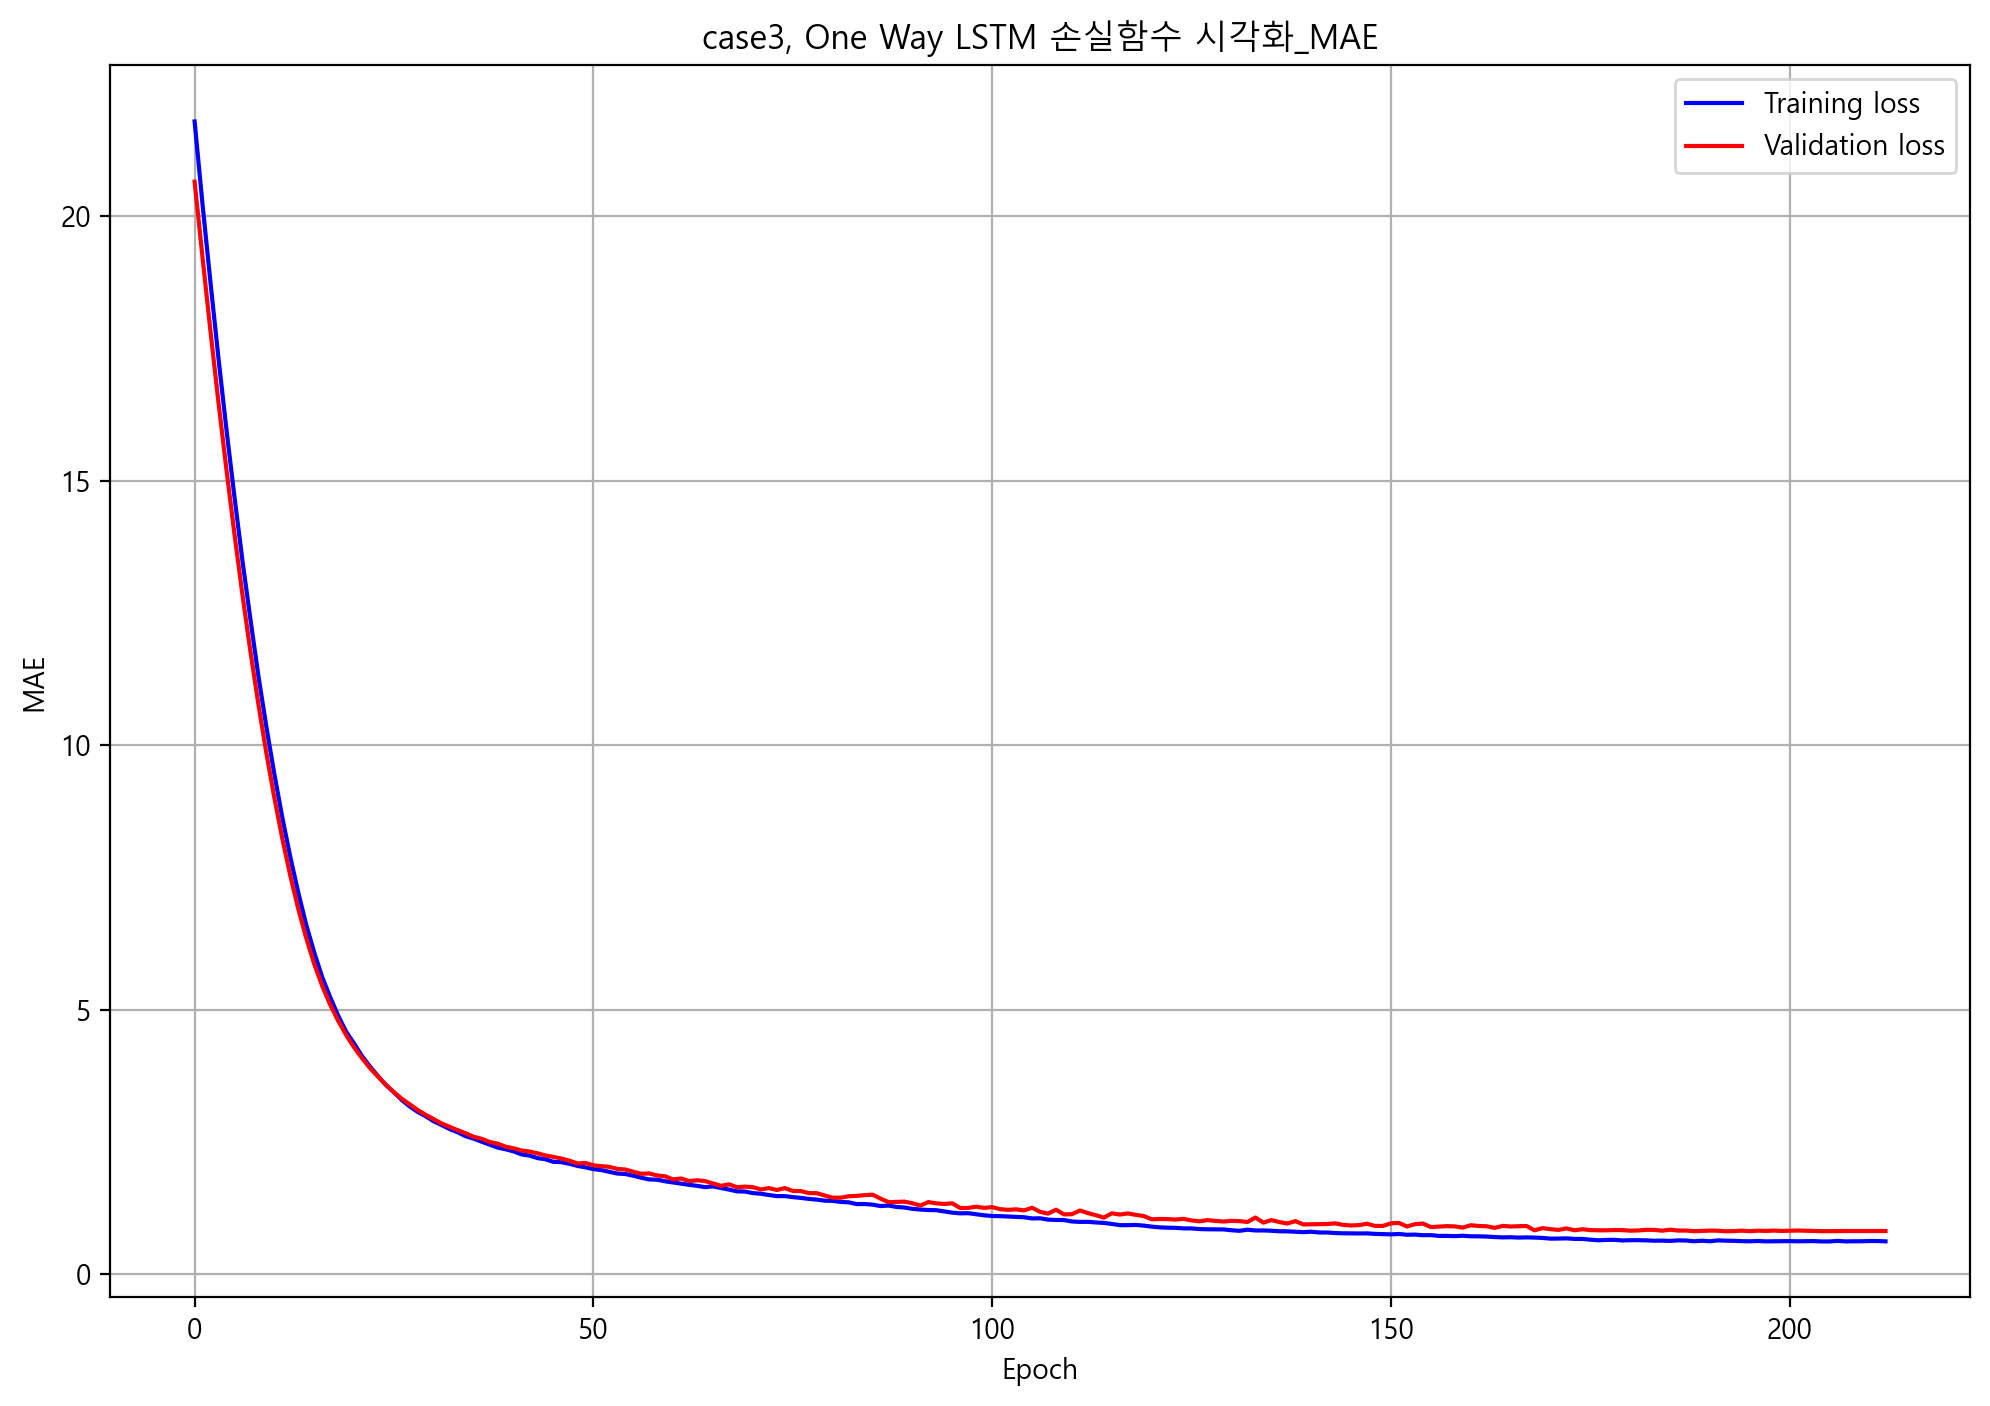

In [83]:
from tensorflow.keras.optimizers import legacy as legacy_optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization, Input, Embedding, Concatenate, Attention
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras import metrics

# Attention 레이어 정의
def attention_layer(inputs):
    attention = Attention()([inputs, inputs])
    return Concatenate()([inputs, attention])

# 옵티마이저 설정
initial_lr = 0.0005
optimizer = legacy_optimizers.Adam(learning_rate=initial_lr)

# 범주형 변수 설정
num_categories = 3
embedding_dim = 5

# 옵티마이저 및 콜백 설정
optimizer = Adam(learning_rate=initial_lr)
lr_restart = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# 모델 정의
numerical_input = Input(shape=(x_train_multi.shape[1], x_train_multi.shape[2]))
categorical_input = Input(shape=(x_train_label.shape[1], ))

# 임베딩 레이어
embedding = Embedding(input_dim=num_categories, output_dim=embedding_dim)(categorical_input)

# 입력 결합
combined_input = Concatenate(axis=-1)([numerical_input, embedding])

x = LSTM(128, return_sequences=True,
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(combined_input)
x = BatchNormalization()(x)
x = Dropout(0.3, seed = 40)(x)

x = LSTM(64, return_sequences=True,
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3, seed = 41)(x)

x = attention_layer(x)

x = LSTM(32, activation='relu',
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3, seed = 42)(x)

x = Dense(24, activation='relu')(x)
output = Dense(12)(x)

case3_uni_mae = Model(inputs=[numerical_input, categorical_input], outputs=output)
case3_uni_mae.compile(optimizer=optimizer, loss="mae")

# 모델 학습
case3_uni_mae_history = case3_uni_mae.fit(
    # 수치형 데이터와 범주형 데이터 분리    
    [x_train_multi, x_train_label],  
    y_train_multi,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    steps_per_epoch = x_train_multi.shape[0] // BATCH_SIZE, 
    validation_steps = x_val_multi.shape[0] // BATCH_SIZE,
    validation_data=([x_val_multi, x_val_label], y_val_multi),
    callbacks=[lr_restart, early_stop]
)

# 학습 결과 시각화
plot_train_history(case3_uni_mae_history, "case3, One Way LSTM" ,"MAE")

# 모델 저장
case3_uni_mae.save("./output/case3/case3_uni_mae.h5")

Epoch 1/300
16/16 [==============================] - 4s 58ms/step - loss: 22.7413 - val_loss: 21.7502 - lr: 5.0000e-04
Epoch 2/300
16/16 [==============================] - 0s 12ms/step - loss: 21.6298 - val_loss: 20.8342 - lr: 5.0000e-04
Epoch 3/300
16/16 [==============================] - 0s 12ms/step - loss: 20.5639 - val_loss: 19.8847 - lr: 5.0000e-04
Epoch 4/300
16/16 [==============================] - 0s 12ms/step - loss: 19.5187 - val_loss: 18.9323 - lr: 5.0000e-04
Epoch 5/300
16/16 [==============================] - 0s 12ms/step - loss: 18.4875 - val_loss: 17.9790 - lr: 5.0000e-04
Epoch 6/300
16/16 [==============================] - 0s 12ms/step - loss: 17.4774 - val_loss: 17.0375 - lr: 5.0000e-04
Epoch 7/300
16/16 [==============================] - 0s 12ms/step - loss: 16.4946 - val_loss: 16.1168 - lr: 5.0000e-04
Epoch 8/300
16/16 [==============================] - 0s 12ms/step - loss: 15.5782 - val_loss: 15.2176 - lr: 5.0000e-04
Epoch 9/300
16/16 [=============================

16/16 [==============================] - 0s 11ms/step - loss: 1.6661 - val_loss: 2.1761 - lr: 5.0000e-04
Epoch 71/300
16/16 [==============================] - 0s 11ms/step - loss: 1.6317 - val_loss: 2.1010 - lr: 5.0000e-04
Epoch 72/300
16/16 [==============================] - 0s 11ms/step - loss: 1.6330 - val_loss: 2.1530 - lr: 5.0000e-04
Epoch 73/300
16/16 [==============================] - 0s 11ms/step - loss: 1.6047 - val_loss: 2.1522 - lr: 5.0000e-04
Epoch 74/300
16/16 [==============================] - 0s 11ms/step - loss: 1.5782 - val_loss: 2.0296 - lr: 5.0000e-04
Epoch 75/300
16/16 [==============================] - 0s 11ms/step - loss: 1.5846 - val_loss: 1.9914 - lr: 5.0000e-04
Epoch 76/300
16/16 [==============================] - 0s 11ms/step - loss: 1.5701 - val_loss: 2.0072 - lr: 5.0000e-04
Epoch 77/300
16/16 [==============================] - 0s 11ms/step - loss: 1.5400 - val_loss: 1.9943 - lr: 5.0000e-04
Epoch 78/300
16/16 [==============================] - 0s 11ms/step - 

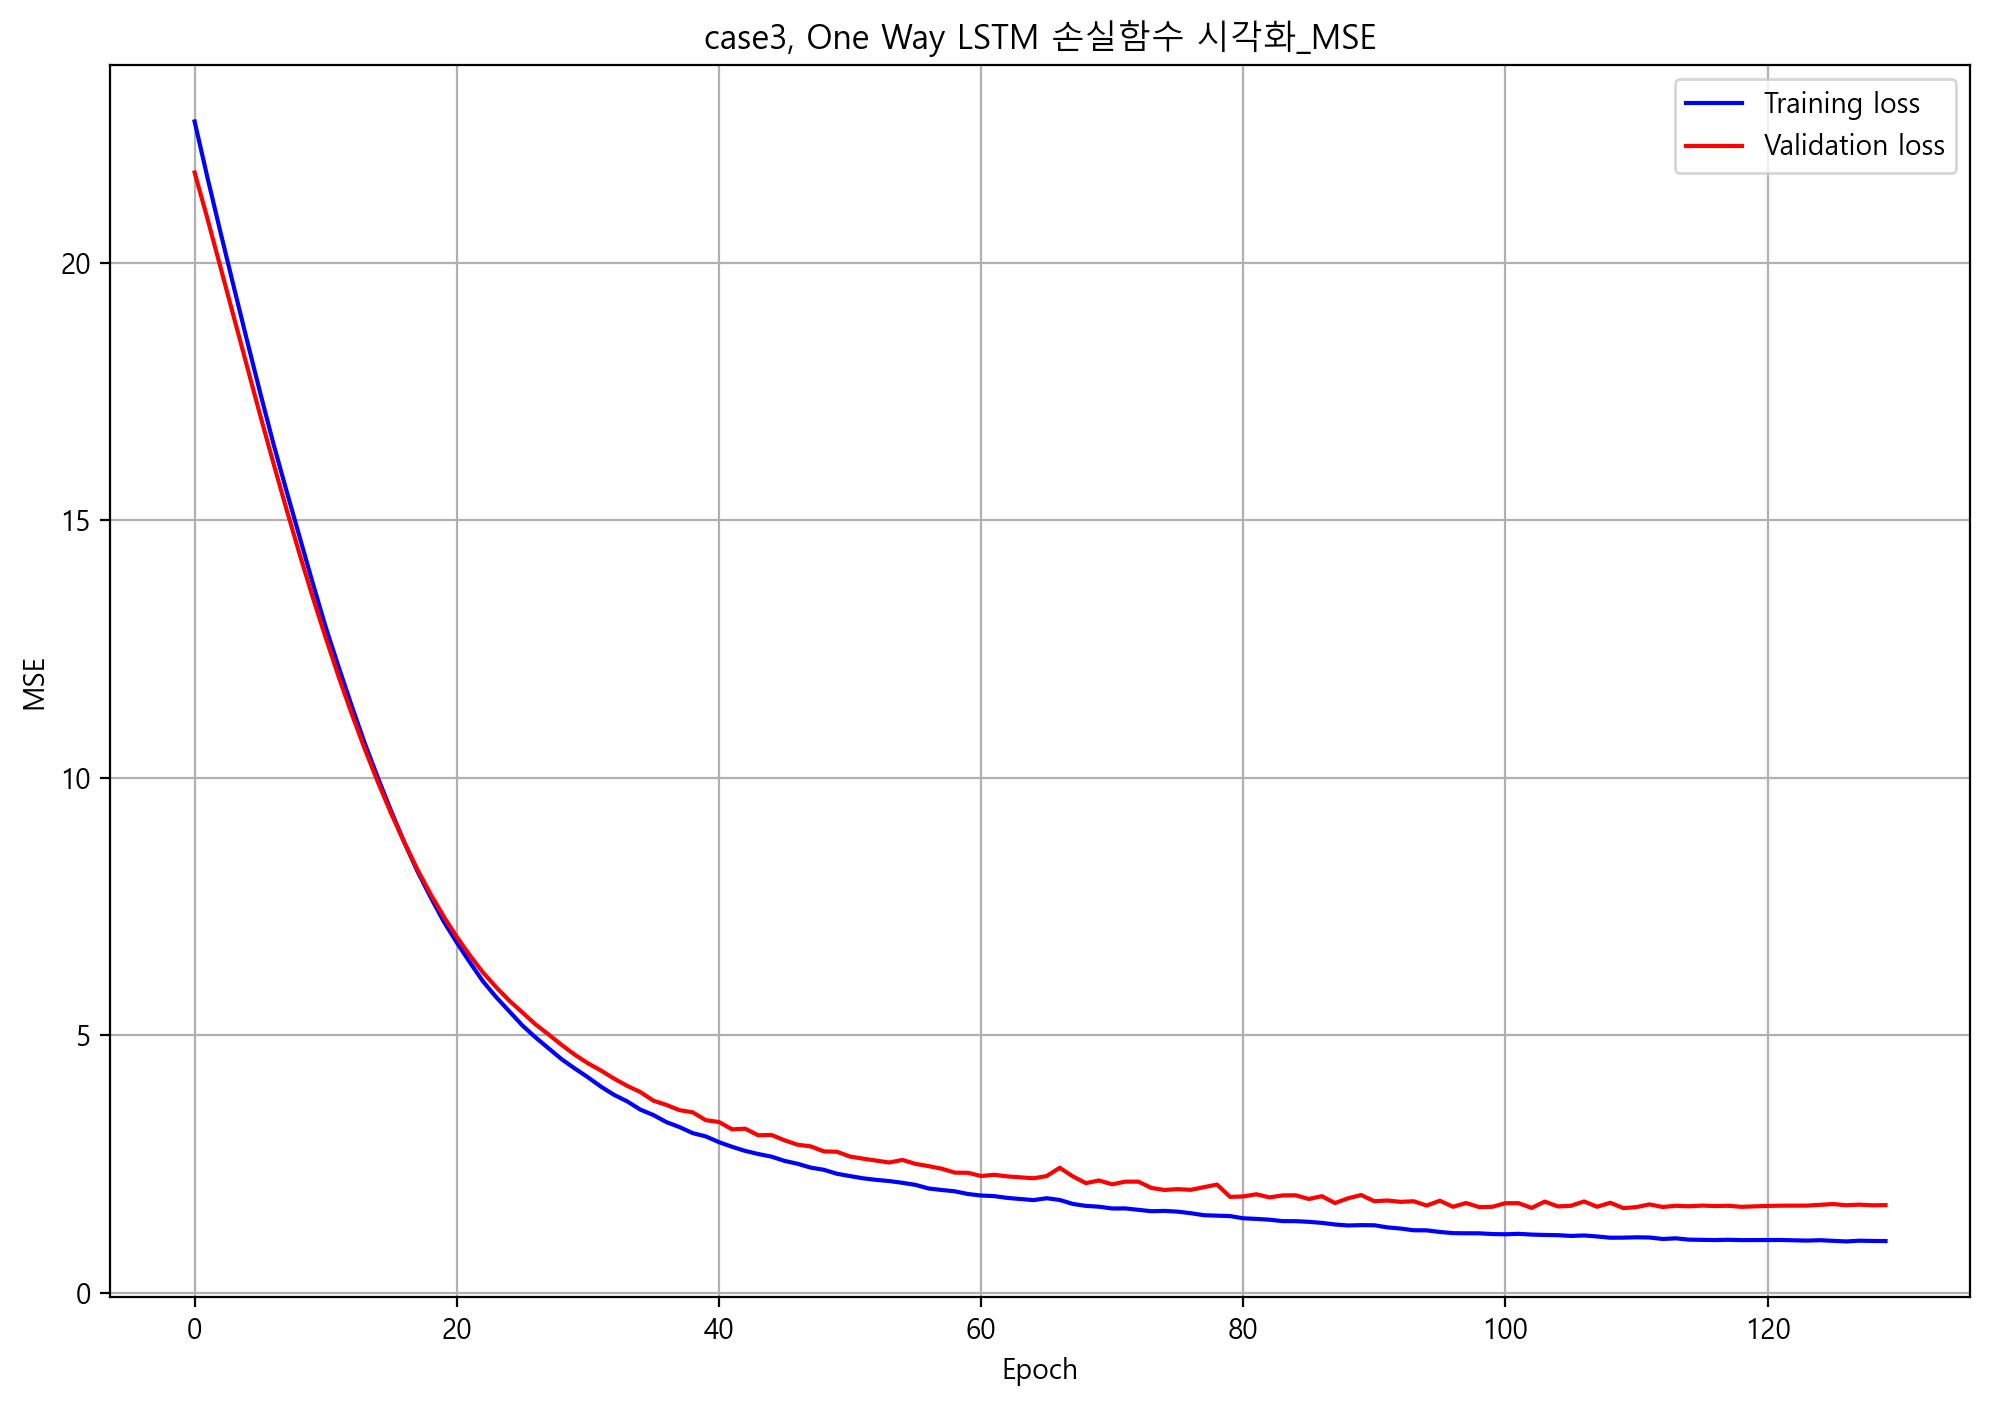

In [84]:
from tensorflow.keras.optimizers import legacy as legacy_optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization, Input, Embedding, Concatenate, Attention
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras import metrics

# Attention 레이어 정의
def attention_layer(inputs):
    attention = Attention()([inputs, inputs])
    return Concatenate()([inputs, attention])

# 옵티마이저 설정
initial_lr = 0.0005
optimizer = legacy_optimizers.Adam(learning_rate=initial_lr)

# 범주형 변수 설정
num_categories = 3
embedding_dim = 5

# 옵티마이저 및 콜백 설정
optimizer = Adam(learning_rate=initial_lr)
lr_restart = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# 모델 정의
numerical_input = Input(shape=(x_train_multi.shape[1], x_train_multi.shape[2]))
categorical_input = Input(shape=(x_train_label.shape[1], ))

# 임베딩 레이어
embedding = Embedding(input_dim=num_categories, output_dim=embedding_dim)(categorical_input)

# 입력 결합
combined_input = Concatenate(axis=-1)([numerical_input, embedding])

x = LSTM(128, return_sequences=True,
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(combined_input)
x = BatchNormalization()(x)
x = Dropout(0.3, seed = 40)(x)

x = LSTM(64, return_sequences=True,
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3, seed = 41)(x)

x = attention_layer(x)

x = LSTM(32, activation='relu',
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3, seed = 42)(x)

x = Dense(24, activation='relu')(x)
output = Dense(12)(x)

case3_uni_mse = Model(inputs=[numerical_input, categorical_input], outputs=output)
case3_uni_mse.compile(optimizer=optimizer, loss="mse")


# 모델 학습
case3_uni_mse_history = case3_uni_mse.fit(
    # 수치형 데이터와 범주형 데이터 분리    
    [x_train_multi, x_train_label],  
    y_train_multi,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    steps_per_epoch = x_train_multi.shape[0] // BATCH_SIZE, 
    validation_steps = x_val_multi.shape[0] // BATCH_SIZE,
    validation_data=([x_val_multi, x_val_label], y_val_multi),
    callbacks=[lr_restart, early_stop]
)

# 학습 결과 시각화
plot_train_history(case3_uni_mse_history, "case3, One Way LSTM" ,"MSE")

# 모델 저장
case3_uni_mse.save("./output/case3/case3_uni_mse.h5")

Epoch 1/300
16/16 [==============================] - 4s 57ms/step - loss: 22.8331 - root_mean_squared_error: 1.2713 - val_loss: 21.7682 - val_root_mean_squared_error: 0.9788 - lr: 5.0000e-04
Epoch 2/300
16/16 [==============================] - 0s 12ms/step - loss: 21.8136 - root_mean_squared_error: 1.1742 - val_loss: 20.9654 - val_root_mean_squared_error: 0.9815 - lr: 5.0000e-04
Epoch 3/300
16/16 [==============================] - 0s 13ms/step - loss: 20.8668 - root_mean_squared_error: 1.1206 - val_loss: 20.1312 - val_root_mean_squared_error: 0.9827 - lr: 5.0000e-04
Epoch 4/300
16/16 [==============================] - 0s 12ms/step - loss: 19.8953 - root_mean_squared_error: 1.0616 - val_loss: 19.2850 - val_root_mean_squared_error: 0.9837 - lr: 5.0000e-04
Epoch 5/300
16/16 [==============================] - 0s 12ms/step - loss: 18.9539 - root_mean_squared_error: 1.0180 - val_loss: 18.4325 - val_root_mean_squared_error: 0.9839 - lr: 5.0000e-04
Epoch 6/300
16/16 [==========================

Epoch 44/300
16/16 [==============================] - 0s 12ms/step - loss: 2.9207 - root_mean_squared_error: 0.7645 - val_loss: 3.2493 - val_root_mean_squared_error: 0.9784 - lr: 5.0000e-04
Epoch 45/300
16/16 [==============================] - 0s 12ms/step - loss: 2.8747 - root_mean_squared_error: 0.7843 - val_loss: 3.1949 - val_root_mean_squared_error: 0.9870 - lr: 5.0000e-04
Epoch 46/300
16/16 [==============================] - 0s 11ms/step - loss: 2.7675 - root_mean_squared_error: 0.7628 - val_loss: 3.1371 - val_root_mean_squared_error: 0.9972 - lr: 5.0000e-04
Epoch 47/300
16/16 [==============================] - 0s 11ms/step - loss: 2.6979 - root_mean_squared_error: 0.7676 - val_loss: 3.0763 - val_root_mean_squared_error: 1.0028 - lr: 5.0000e-04
Epoch 48/300
16/16 [==============================] - 0s 12ms/step - loss: 2.6366 - root_mean_squared_error: 0.7713 - val_loss: 3.0044 - val_root_mean_squared_error: 0.9967 - lr: 5.0000e-04
Epoch 49/300
16/16 [==============================

16/16 [==============================] - 0s 11ms/step - loss: 1.3735 - root_mean_squared_error: 0.7258 - val_loss: 1.8871 - val_root_mean_squared_error: 1.0257 - lr: 5.0000e-04
Epoch 88/300
16/16 [==============================] - 0s 12ms/step - loss: 1.3651 - root_mean_squared_error: 0.7342 - val_loss: 1.7374 - val_root_mean_squared_error: 0.9589 - lr: 5.0000e-04
Epoch 89/300
16/16 [==============================] - 0s 11ms/step - loss: 1.3347 - root_mean_squared_error: 0.7250 - val_loss: 1.7787 - val_root_mean_squared_error: 0.9894 - lr: 5.0000e-04
Epoch 90/300
16/16 [==============================] - 0s 11ms/step - loss: 1.3286 - root_mean_squared_error: 0.7318 - val_loss: 1.8276 - val_root_mean_squared_error: 1.0208 - lr: 5.0000e-04
Epoch 91/300
16/16 [==============================] - 0s 12ms/step - loss: 1.3093 - root_mean_squared_error: 0.7297 - val_loss: 1.7258 - val_root_mean_squared_error: 0.9784 - lr: 5.0000e-04
Epoch 92/300
16/16 [==============================] - 0s 12ms/s

16/16 [==============================] - 0s 11ms/step - loss: 1.0414 - root_mean_squared_error: 0.7050 - val_loss: 1.6318 - val_root_mean_squared_error: 1.0430 - lr: 1.5625e-05
Epoch 126/300
16/16 [==============================] - 0s 11ms/step - loss: 1.0285 - root_mean_squared_error: 0.6962 - val_loss: 1.6427 - val_root_mean_squared_error: 1.0484 - lr: 1.5625e-05
Epoch 127/300
13/16 [=======================>......] - ETA: 0s - loss: 1.0292 - root_mean_squared_error: 0.6971
Epoch 127: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.
16/16 [==============================] - 0s 12ms/step - loss: 1.0243 - root_mean_squared_error: 0.6936 - val_loss: 1.6204 - val_root_mean_squared_error: 1.0381 - lr: 1.5625e-05


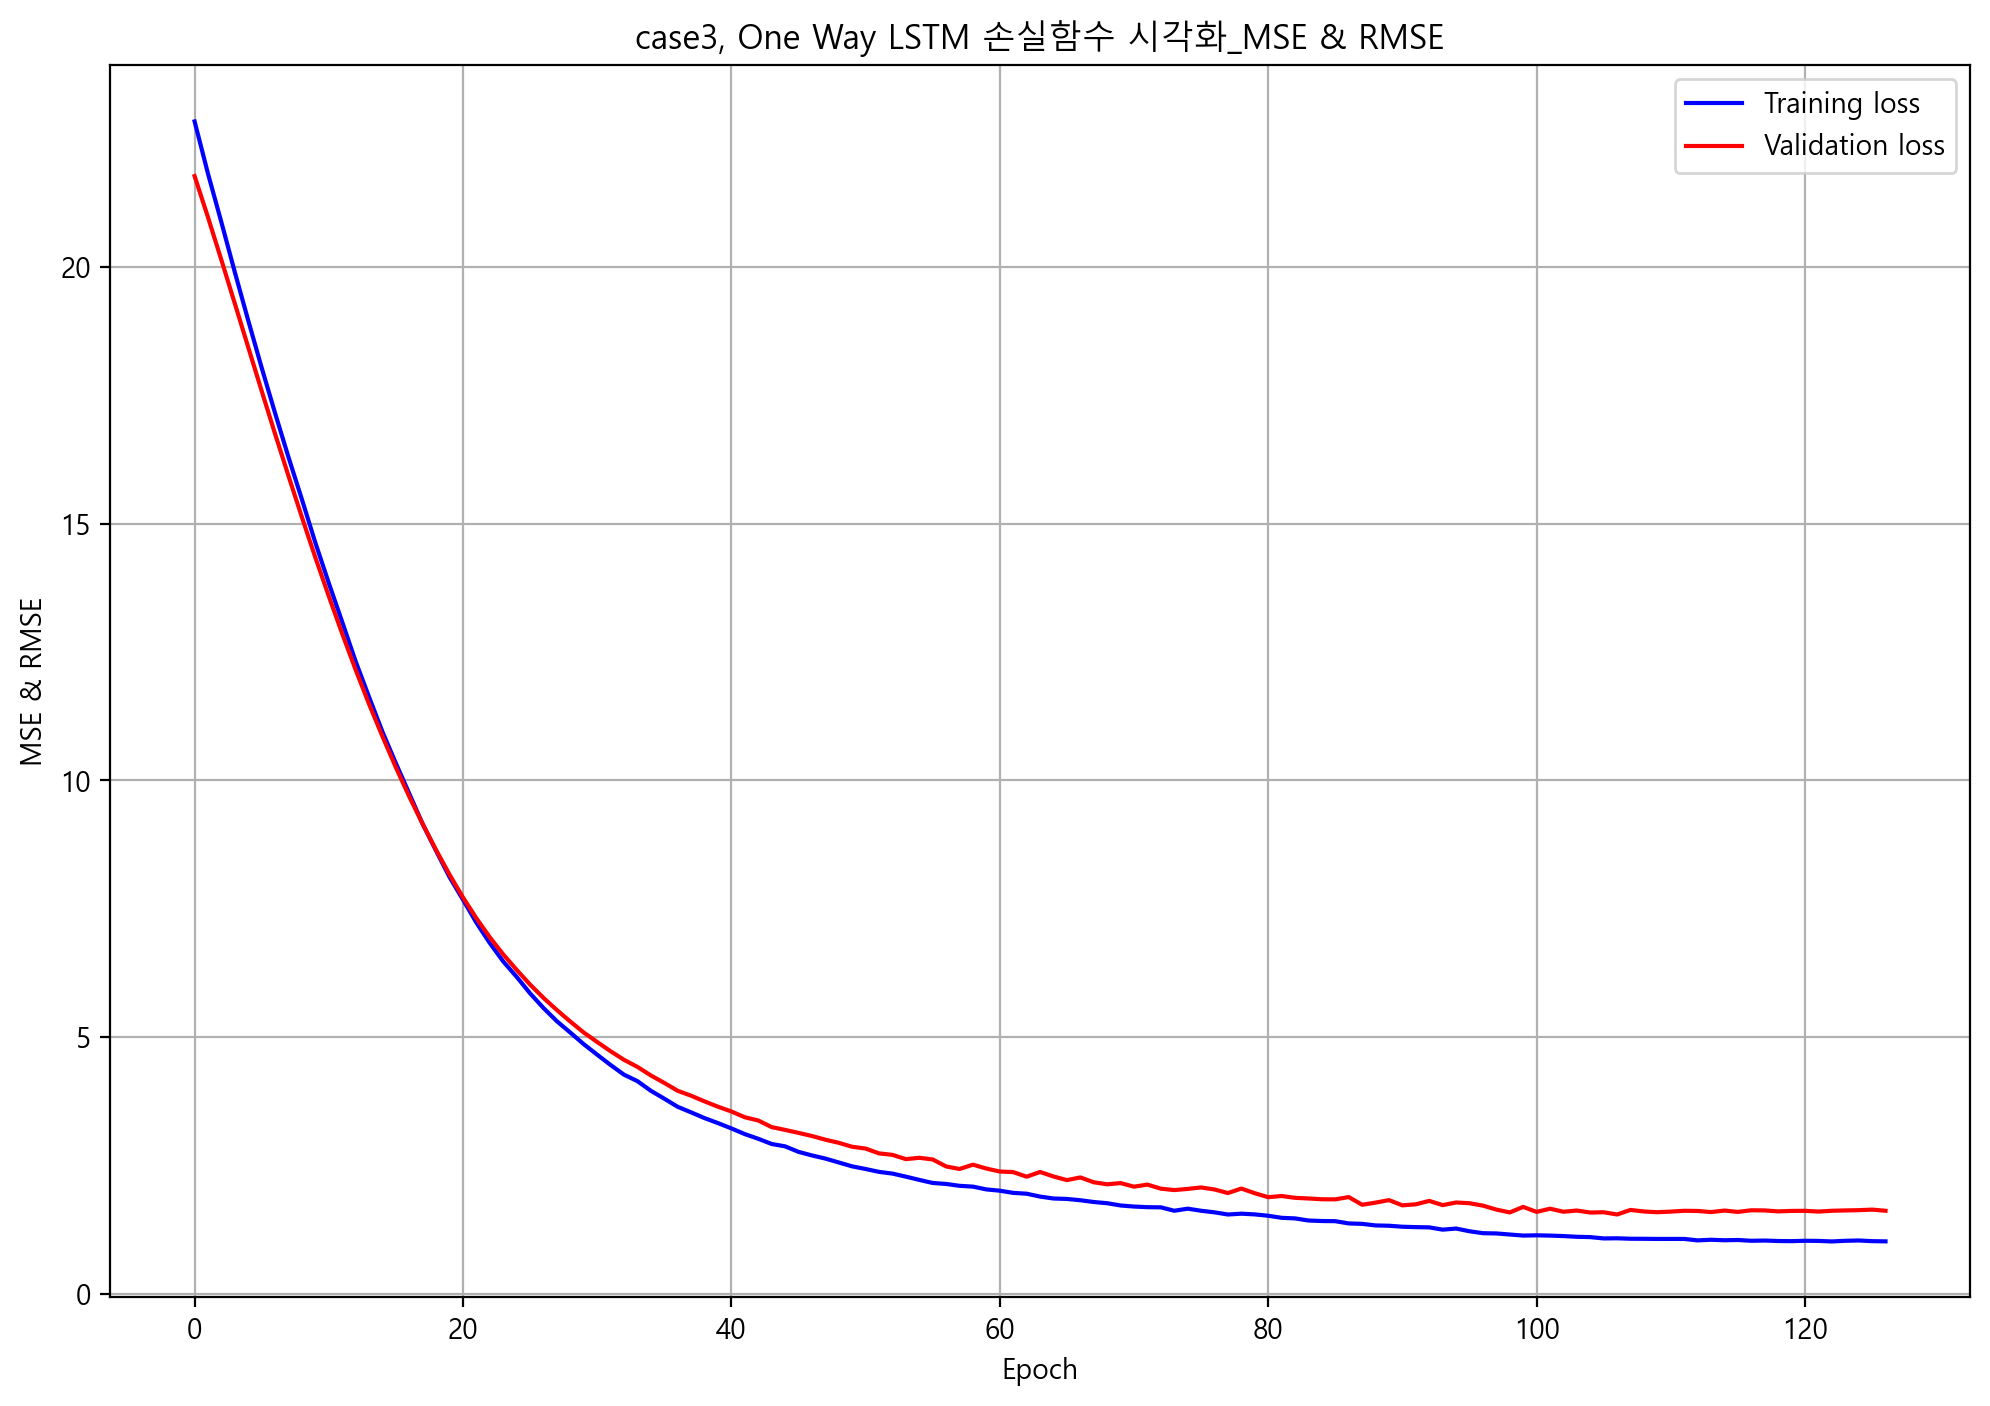

In [85]:
from tensorflow.keras.optimizers import legacy as legacy_optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization, Input, Embedding, Concatenate, Attention
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras import metrics

# Attention 레이어 정의
def attention_layer(inputs):
    attention = Attention()([inputs, inputs])
    return Concatenate()([inputs, attention])

# 옵티마이저 설정
initial_lr = 0.0005
optimizer = legacy_optimizers.Adam(learning_rate=initial_lr)

# 범주형 변수 설정
num_categories = 3
embedding_dim = 5

# 옵티마이저 및 콜백 설정
optimizer = Adam(learning_rate=initial_lr)
lr_restart = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# 모델 정의
numerical_input = Input(shape=(x_train_multi.shape[1], x_train_multi.shape[2]))
categorical_input = Input(shape=(x_train_label.shape[1], ))

# 임베딩 레이어
embedding = Embedding(input_dim=num_categories, output_dim=embedding_dim)(categorical_input)

# 입력 결합
combined_input = Concatenate(axis=-1)([numerical_input, embedding])

x = LSTM(128, return_sequences=True,
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(combined_input)
x = BatchNormalization()(x)
x = Dropout(0.3, seed = 40)(x)

x = LSTM(64, return_sequences=True,
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3, seed = 41)(x)

x = attention_layer(x)

x = LSTM(32, activation='relu',
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3, seed = 42)(x)

x = Dense(24, activation='relu')(x)
output = Dense(12)(x)

case3_uni_rmse = Model(inputs=[numerical_input, categorical_input], outputs=output)
case3_uni_rmse.compile(optimizer=optimizer
                       , loss="mse"
                       , metrics=[metrics.RootMeanSquaredError()]
                      )


# 모델 학습
case3_uni_rmse_history = case3_uni_rmse.fit(
    # 수치형 데이터와 범주형 데이터 분리    
    [x_train_multi, x_train_label],  
    y_train_multi,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    steps_per_epoch = x_train_multi.shape[0] // BATCH_SIZE, 
    validation_steps = x_val_multi.shape[0] // BATCH_SIZE,
    validation_data=([x_val_multi, x_val_label], y_val_multi),
    callbacks=[lr_restart, early_stop]
)

# 학습 결과 시각화
plot_train_history(case3_uni_rmse_history, "case3, One Way LSTM" ,"MSE & RMSE")

# 모델 저장
case3_uni_rmse.save("./output/case3/case3_uni_rmse.h5")

### 양방향 LSTM

Epoch 1/300
16/16 [==============================] - 6s 88ms/step - loss: 54.2499 - val_loss: 50.9531 - lr: 5.0000e-04
Epoch 2/300
16/16 [==============================] - 0s 17ms/step - loss: 48.5230 - val_loss: 45.4363 - lr: 5.0000e-04
Epoch 3/300
16/16 [==============================] - 0s 17ms/step - loss: 43.1154 - val_loss: 40.2821 - lr: 5.0000e-04
Epoch 4/300
16/16 [==============================] - 0s 17ms/step - loss: 38.0790 - val_loss: 35.4982 - lr: 5.0000e-04
Epoch 5/300
16/16 [==============================] - 0s 17ms/step - loss: 33.4463 - val_loss: 31.0995 - lr: 5.0000e-04
Epoch 6/300
16/16 [==============================] - 0s 17ms/step - loss: 29.2089 - val_loss: 27.0755 - lr: 5.0000e-04
Epoch 7/300
16/16 [==============================] - 0s 17ms/step - loss: 25.3392 - val_loss: 23.4232 - lr: 5.0000e-04
Epoch 8/300
16/16 [==============================] - 0s 17ms/step - loss: 21.8484 - val_loss: 20.1540 - lr: 5.0000e-04
Epoch 9/300
16/16 [=============================

16/16 [==============================] - 0s 19ms/step - loss: 2.2446 - val_loss: 2.3578 - lr: 5.0000e-04
Epoch 71/300
16/16 [==============================] - 0s 17ms/step - loss: 2.2142 - val_loss: 2.3603 - lr: 5.0000e-04
Epoch 72/300
16/16 [==============================] - 0s 17ms/step - loss: 2.1919 - val_loss: 2.3053 - lr: 5.0000e-04
Epoch 73/300
16/16 [==============================] - 0s 17ms/step - loss: 2.1627 - val_loss: 2.2775 - lr: 5.0000e-04
Epoch 74/300
16/16 [==============================] - 0s 17ms/step - loss: 2.1346 - val_loss: 2.2543 - lr: 5.0000e-04
Epoch 75/300
16/16 [==============================] - 0s 17ms/step - loss: 2.1245 - val_loss: 2.2741 - lr: 5.0000e-04
Epoch 76/300
16/16 [==============================] - 0s 17ms/step - loss: 2.0898 - val_loss: 2.1764 - lr: 5.0000e-04
Epoch 77/300
16/16 [==============================] - 0s 17ms/step - loss: 2.0509 - val_loss: 2.1625 - lr: 5.0000e-04
Epoch 78/300
16/16 [==============================] - 0s 16ms/step - 

16/16 [==============================] - 0s 18ms/step - loss: 0.8571 - val_loss: 1.0477 - lr: 5.0000e-04
Epoch 140/300
16/16 [==============================] - 0s 17ms/step - loss: 0.8529 - val_loss: 0.9841 - lr: 5.0000e-04
Epoch 141/300
16/16 [==============================] - 0s 17ms/step - loss: 0.8512 - val_loss: 0.9890 - lr: 5.0000e-04
Epoch 142/300
16/16 [==============================] - 0s 16ms/step - loss: 0.8331 - val_loss: 0.9699 - lr: 5.0000e-04
Epoch 143/300
16/16 [==============================] - 0s 16ms/step - loss: 0.8098 - val_loss: 0.9592 - lr: 5.0000e-04
Epoch 144/300
16/16 [==============================] - 0s 17ms/step - loss: 0.8046 - val_loss: 0.9269 - lr: 5.0000e-04
Epoch 145/300
16/16 [==============================] - 0s 17ms/step - loss: 0.8039 - val_loss: 0.9747 - lr: 5.0000e-04
Epoch 146/300
16/16 [==============================] - 0s 17ms/step - loss: 0.7793 - val_loss: 0.9147 - lr: 5.0000e-04
Epoch 147/300
16/16 [==============================] - 0s 17ms

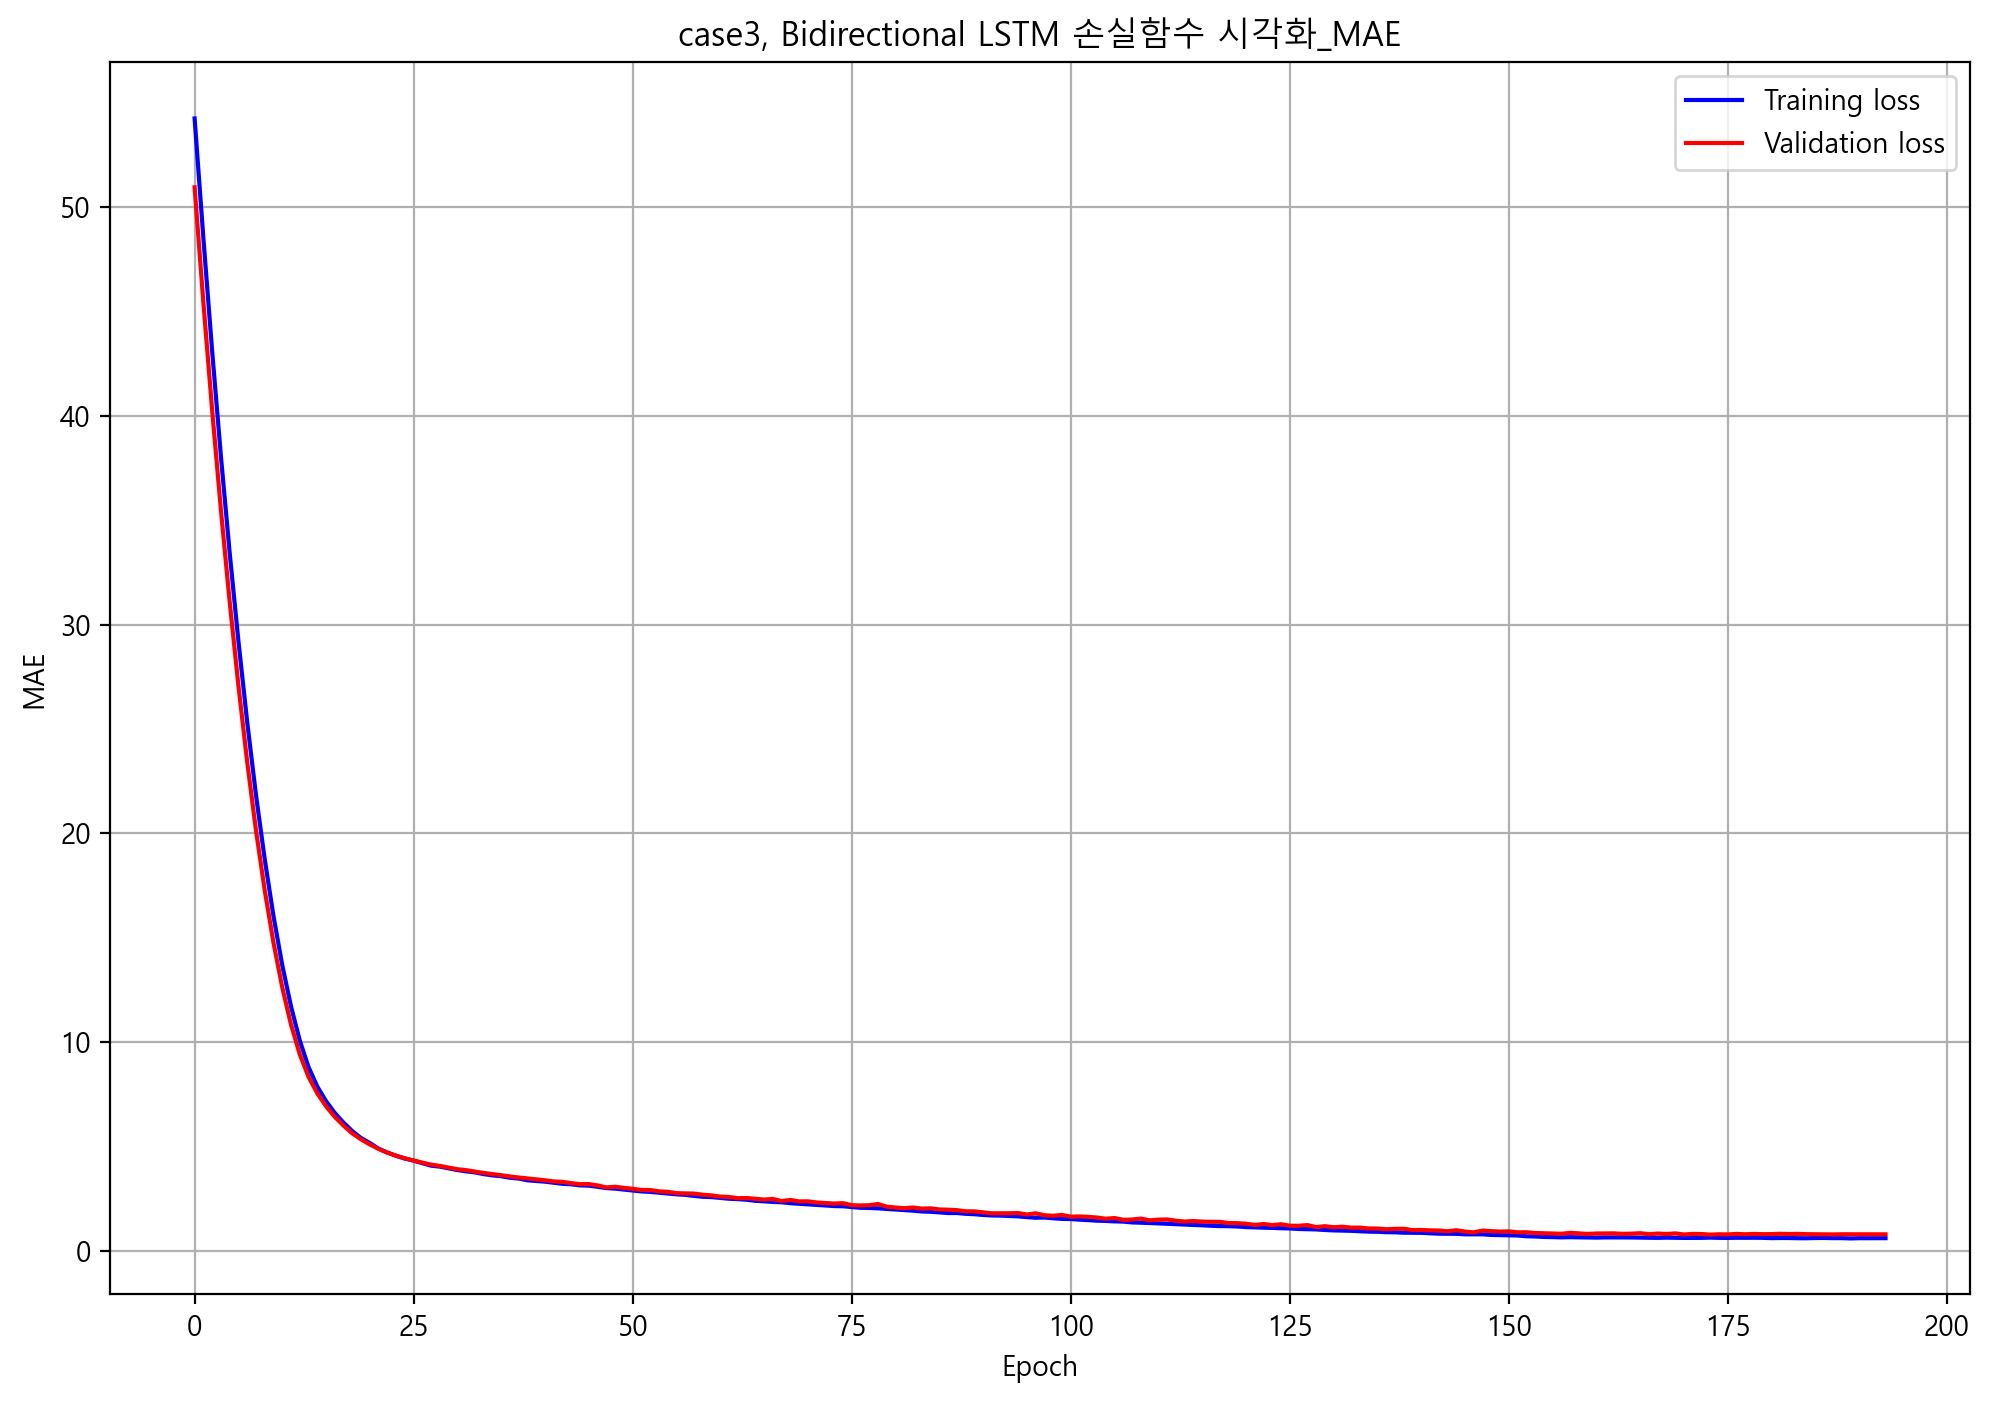

In [86]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization, Input, Embedding, Concatenate, Attention, Bidirectional
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import legacy as legacy_optimizers
from tensorflow.keras import metrics

# Attention 레이어 정의
def attention_layer(inputs):
    attention = Attention()([inputs, inputs])
    return Concatenate()([inputs, attention])

# 옵티마이저 설정
initial_lr = 0.0005
optimizer = legacy_optimizers.Adam(learning_rate=initial_lr)

# 범주형 변수 설정
num_categories = 3
embedding_dim = 5

# 옵티마이저 및 콜백 설정
optimizer = Adam(learning_rate=initial_lr)
lr_restart = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# 모델 정의
numerical_input = Input(shape=(x_train_multi.shape[1], x_train_multi.shape[2]))
categorical_input = Input(shape=(x_train_label.shape[1], ))

# 임베딩 레이어
embedding = Embedding(input_dim=num_categories, output_dim=embedding_dim)(categorical_input)

# 입력 결합
combined_input = Concatenate(axis=-1)([numerical_input, embedding])

x = Bidirectional(LSTM(128, return_sequences=True,
                   kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                   bias_regularizer=l1_l2(l1=0.005, l2=0.005)))(combined_input)
x = BatchNormalization()(x)
x = Dropout(0.3, seed = 40)(x)

x = Bidirectional(LSTM(64, return_sequences=True,
                   kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                   bias_regularizer=l1_l2(l1=0.005, l2=0.005)))(x)
x = BatchNormalization()(x)
x = Dropout(0.3, seed = 41)(x)

x = attention_layer(x)

x = LSTM(32, activation='relu',
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3, seed = 42)(x)

x = Dense(24, activation='relu')(x)
output = Dense(12)(x)

case3_bi_mae = Model(inputs=[numerical_input, categorical_input], outputs=output)
case3_bi_mae.compile(optimizer=optimizer, loss="mae")

# 모델 학습
case3_bi_mae_history = case3_bi_mae.fit(
    # 수치형 데이터와 범주형 데이터 분리    
    [x_train_multi, x_train_label],  
    y_train_multi,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    steps_per_epoch = x_train_multi.shape[0] // BATCH_SIZE, 
    validation_steps = x_val_multi.shape[0] // BATCH_SIZE,
    validation_data=([x_val_multi, x_val_label], y_val_multi),
    callbacks=[lr_restart, early_stop]
)

# 학습 결과 시각화
plot_train_history(case3_bi_mae_history, "case3, Bidirectional LSTM", "MAE")

# 모델 학습
case3_bi_mae.save("./output/case3/case3_bi_mae.h5")

Epoch 1/300
16/16 [==============================] - 6s 89ms/step - loss: 56.2759 - val_loss: 53.9042 - lr: 5.0000e-04
Epoch 2/300
16/16 [==============================] - 0s 17ms/step - loss: 52.8773 - val_loss: 50.6185 - lr: 5.0000e-04
Epoch 3/300
16/16 [==============================] - 0s 17ms/step - loss: 49.3149 - val_loss: 47.2185 - lr: 5.0000e-04
Epoch 4/300
16/16 [==============================] - 0s 18ms/step - loss: 45.8157 - val_loss: 43.8160 - lr: 5.0000e-04
Epoch 5/300
16/16 [==============================] - 0s 17ms/step - loss: 42.3033 - val_loss: 40.4751 - lr: 5.0000e-04
Epoch 6/300
16/16 [==============================] - 0s 17ms/step - loss: 38.9913 - val_loss: 37.2267 - lr: 5.0000e-04
Epoch 7/300
16/16 [==============================] - 0s 17ms/step - loss: 35.7508 - val_loss: 34.1162 - lr: 5.0000e-04
Epoch 8/300
16/16 [==============================] - 0s 17ms/step - loss: 32.6487 - val_loss: 31.1697 - lr: 5.0000e-04
Epoch 9/300
16/16 [=============================

16/16 [==============================] - 0s 18ms/step - loss: 2.3868 - val_loss: 2.7865 - lr: 5.0000e-04
Epoch 71/300
16/16 [==============================] - 0s 18ms/step - loss: 2.3510 - val_loss: 2.7734 - lr: 5.0000e-04
Epoch 72/300
16/16 [==============================] - 0s 17ms/step - loss: 2.3486 - val_loss: 2.8142 - lr: 5.0000e-04
Epoch 73/300
16/16 [==============================] - 0s 17ms/step - loss: 2.3153 - val_loss: 2.6603 - lr: 5.0000e-04
Epoch 74/300
16/16 [==============================] - 0s 17ms/step - loss: 2.2668 - val_loss: 2.6307 - lr: 5.0000e-04
Epoch 75/300
16/16 [==============================] - 0s 16ms/step - loss: 2.2431 - val_loss: 2.6326 - lr: 5.0000e-04
Epoch 76/300
16/16 [==============================] - 0s 17ms/step - loss: 2.1946 - val_loss: 2.5695 - lr: 5.0000e-04
Epoch 77/300
16/16 [==============================] - 0s 17ms/step - loss: 2.1739 - val_loss: 2.6285 - lr: 5.0000e-04
Epoch 78/300
16/16 [==============================] - 0s 17ms/step - 

13/16 [=======================>......] - ETA: 0s - loss: 1.2463
Epoch 134: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
16/16 [==============================] - 0s 17ms/step - loss: 1.2384 - val_loss: 1.8615 - lr: 3.1250e-05
Epoch 135/300
16/16 [==============================] - 0s 16ms/step - loss: 1.2190 - val_loss: 1.8560 - lr: 1.5625e-05
Epoch 136/300
16/16 [==============================] - 0s 17ms/step - loss: 1.2238 - val_loss: 1.8470 - lr: 1.5625e-05
Epoch 137/300
16/16 [==============================] - 0s 17ms/step - loss: 1.2270 - val_loss: 1.8260 - lr: 1.5625e-05
Epoch 138/300
16/16 [==============================] - 0s 17ms/step - loss: 1.2347 - val_loss: 1.8389 - lr: 1.5625e-05
Epoch 139/300
13/16 [=======================>......] - ETA: 0s - loss: 1.2241
Epoch 139: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.
16/16 [==============================] - 0s 17ms/step - loss: 1.2225 - val_loss: 1.8379 - lr: 1.5625e-05
Epoch 140/300
1

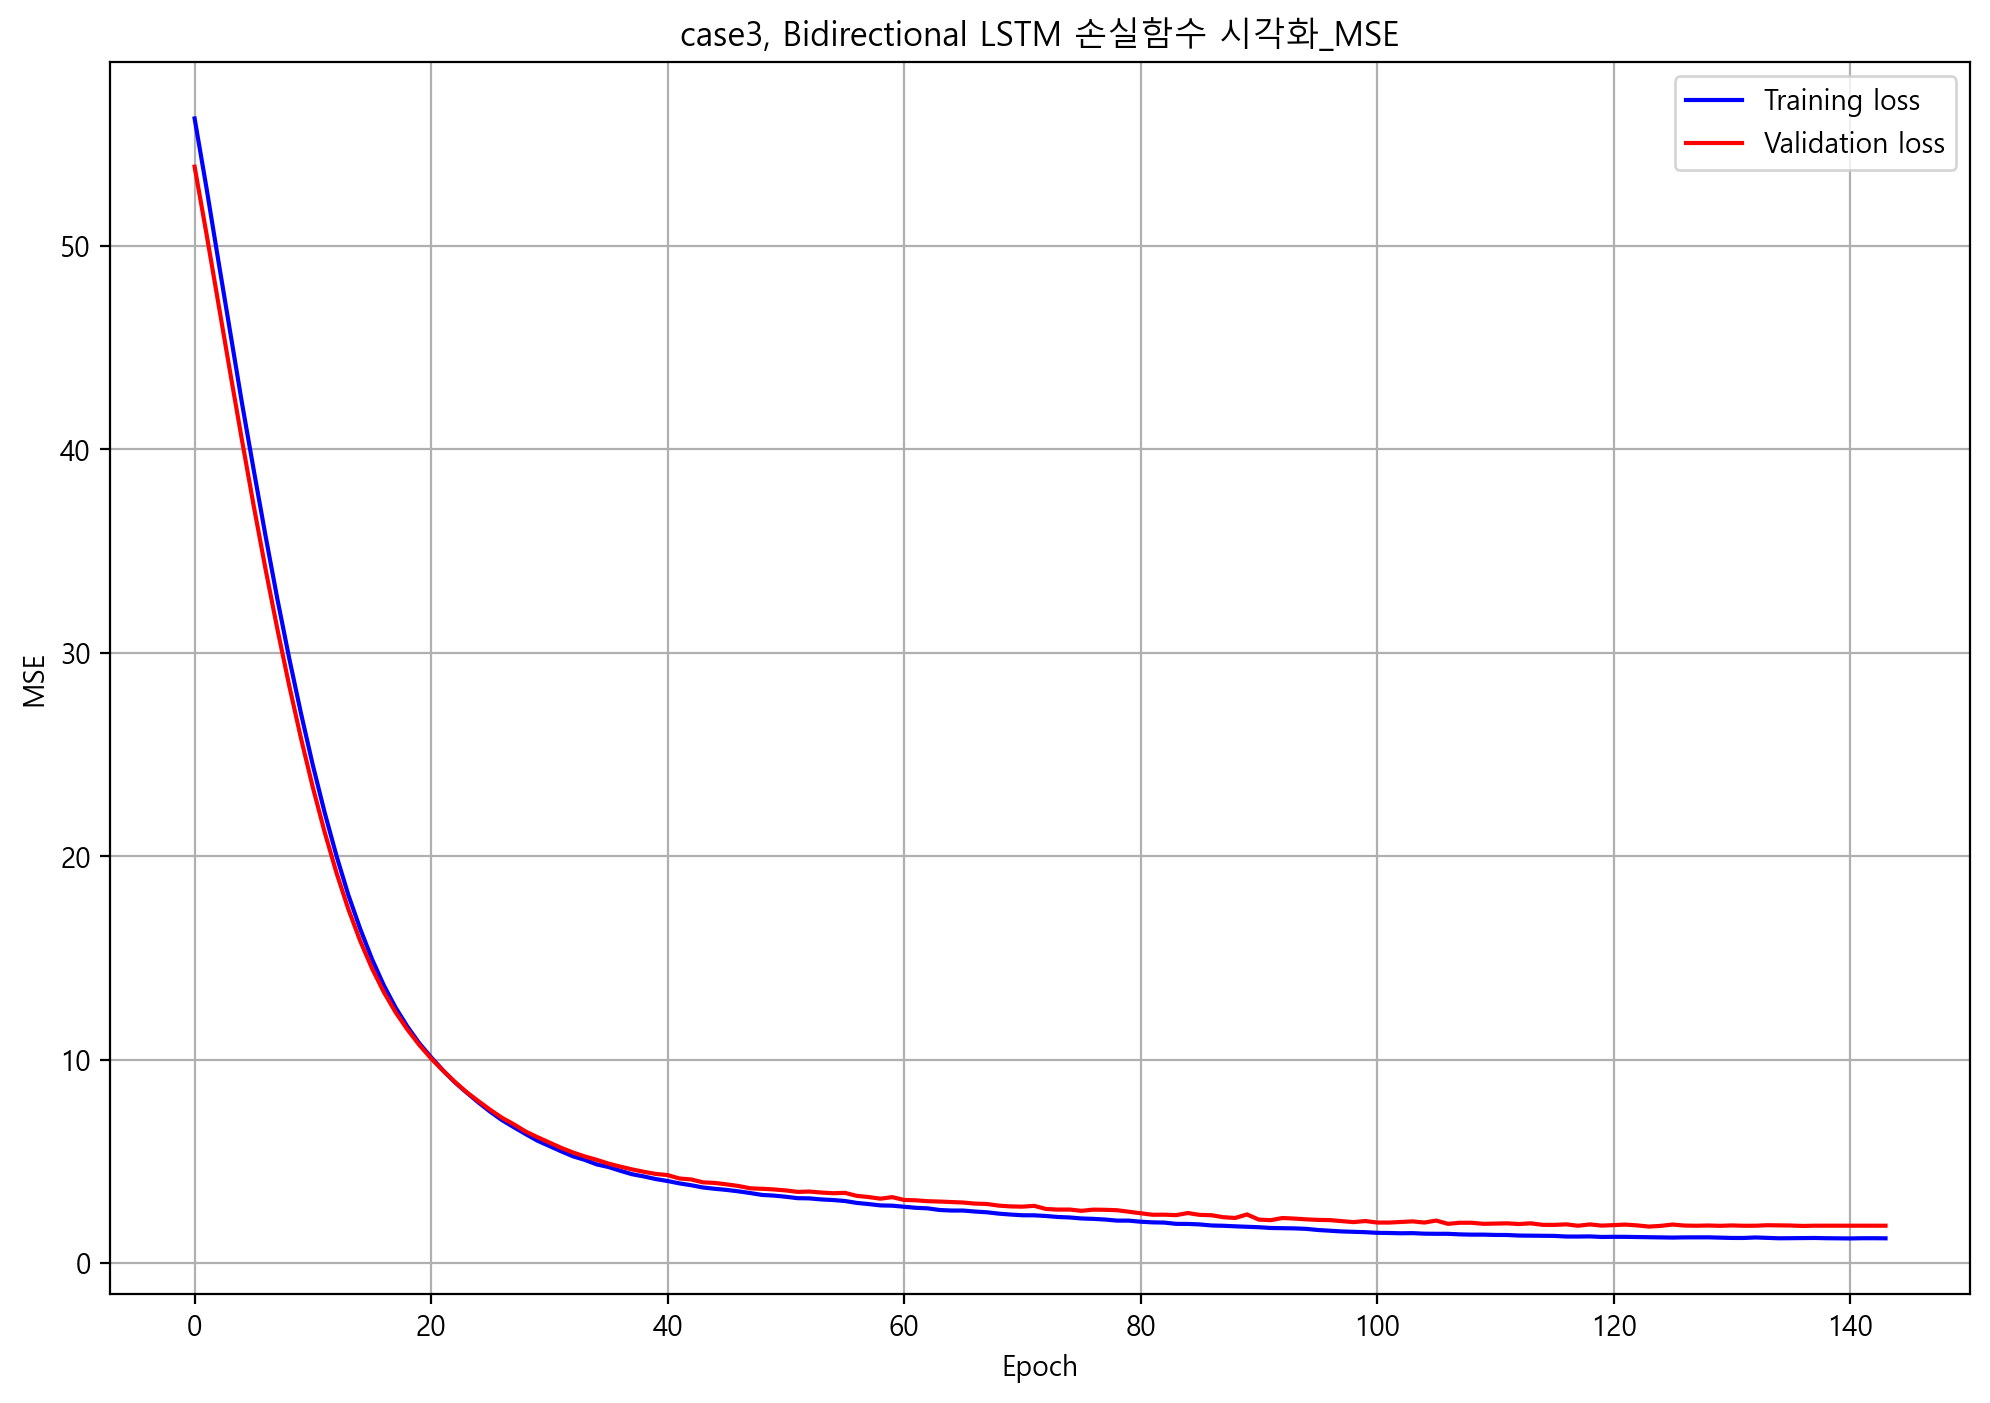

In [87]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization, Input, Embedding, Concatenate, Attention, Bidirectional
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import legacy as legacy_optimizers
from tensorflow.keras import metrics

# Attention 레이어 정의
def attention_layer(inputs):
    attention = Attention()([inputs, inputs])
    return Concatenate()([inputs, attention])

# 옵티마이저 설정
initial_lr = 0.0005
optimizer = legacy_optimizers.Adam(learning_rate=initial_lr)

# 범주형 변수 설정
num_categories = 3
embedding_dim = 5

# 옵티마이저 및 콜백 설정
optimizer = Adam(learning_rate=initial_lr)
lr_restart = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# 모델 정의
numerical_input = Input(shape=(x_train_multi.shape[1], x_train_multi.shape[2]))
categorical_input = Input(shape=(x_train_label.shape[1], ))

# 임베딩 레이어
embedding = Embedding(input_dim=num_categories, output_dim=embedding_dim)(categorical_input)

# 입력 결합
combined_input = Concatenate(axis=-1)([numerical_input, embedding])

x = Bidirectional(LSTM(128, return_sequences=True,
                   kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                   bias_regularizer=l1_l2(l1=0.005, l2=0.005)))(combined_input)
x = BatchNormalization()(x)
x = Dropout(0.3, seed = 40)(x)

x = Bidirectional(LSTM(64, return_sequences=True,
                   kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                   bias_regularizer=l1_l2(l1=0.005, l2=0.005)))(x)
x = BatchNormalization()(x)
x = Dropout(0.3, seed = 41)(x)

x = attention_layer(x)

x = LSTM(32, activation='relu',
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3, seed = 42)(x)

x = Dense(24, activation='relu')(x)
output = Dense(12)(x)

case3_bi_mse = Model(inputs=[numerical_input, categorical_input], outputs=output)
case3_bi_mse.compile(optimizer=optimizer, loss="mse")

# 모델 학습
case3_bi_mse_history = case3_bi_mse.fit(
    # 수치형 데이터와 범주형 데이터 분리    
    [x_train_multi, x_train_label],  
    y_train_multi,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    steps_per_epoch = x_train_multi.shape[0] // BATCH_SIZE, 
    validation_steps = x_val_multi.shape[0] // BATCH_SIZE,
    validation_data=([x_val_multi, x_val_label], y_val_multi),
    callbacks=[lr_restart, early_stop]
)

# 학습 결과 시각화
plot_train_history(case3_bi_mse_history, "case3, Bidirectional LSTM", "MSE")

# 모델 학습
case3_bi_mse.save("./output/case3/case3_bi_mse.h5")

Epoch 1/300
16/16 [==============================] - 6s 90ms/step - loss: 56.0471 - root_mean_squared_error: 1.2416 - val_loss: 53.6761 - val_root_mean_squared_error: 0.9782 - lr: 5.0000e-04
Epoch 2/300
16/16 [==============================] - 0s 17ms/step - loss: 52.4151 - root_mean_squared_error: 1.1585 - val_loss: 50.1435 - val_root_mean_squared_error: 0.9823 - lr: 5.0000e-04
Epoch 3/300
16/16 [==============================] - 0s 17ms/step - loss: 48.5949 - root_mean_squared_error: 1.0555 - val_loss: 46.5280 - val_root_mean_squared_error: 0.9853 - lr: 5.0000e-04
Epoch 4/300
16/16 [==============================] - 0s 17ms/step - loss: 44.9547 - root_mean_squared_error: 1.0382 - val_loss: 42.9649 - val_root_mean_squared_error: 0.9885 - lr: 5.0000e-04
Epoch 5/300
16/16 [==============================] - 0s 17ms/step - loss: 41.3373 - root_mean_squared_error: 0.9936 - val_loss: 39.4913 - val_root_mean_squared_error: 0.9902 - lr: 5.0000e-04
Epoch 6/300
16/16 [==========================

Epoch 44/300
16/16 [==============================] - 0s 17ms/step - loss: 3.6763 - root_mean_squared_error: 0.7740 - val_loss: 3.9877 - val_root_mean_squared_error: 0.9784 - lr: 5.0000e-04
Epoch 45/300
16/16 [==============================] - 0s 18ms/step - loss: 3.5838 - root_mean_squared_error: 0.7707 - val_loss: 3.9362 - val_root_mean_squared_error: 0.9909 - lr: 5.0000e-04
Epoch 46/300
16/16 [==============================] - 0s 18ms/step - loss: 3.5610 - root_mean_squared_error: 0.7852 - val_loss: 3.8970 - val_root_mean_squared_error: 0.9902 - lr: 5.0000e-04
Epoch 47/300
16/16 [==============================] - 0s 17ms/step - loss: 3.5016 - root_mean_squared_error: 0.7873 - val_loss: 3.7978 - val_root_mean_squared_error: 0.9741 - lr: 5.0000e-04
Epoch 48/300
16/16 [==============================] - 0s 17ms/step - loss: 3.4095 - root_mean_squared_error: 0.7679 - val_loss: 3.7304 - val_root_mean_squared_error: 0.9774 - lr: 5.0000e-04
Epoch 49/300
16/16 [==============================

16/16 [==============================] - 0s 17ms/step - loss: 1.8489 - root_mean_squared_error: 0.7208 - val_loss: 2.3845 - val_root_mean_squared_error: 1.0324 - lr: 5.0000e-04
Epoch 88/300
16/16 [==============================] - 0s 17ms/step - loss: 1.8189 - root_mean_squared_error: 0.7167 - val_loss: 2.2091 - val_root_mean_squared_error: 0.9588 - lr: 5.0000e-04
Epoch 89/300
16/16 [==============================] - 0s 17ms/step - loss: 1.8021 - root_mean_squared_error: 0.7209 - val_loss: 2.1853 - val_root_mean_squared_error: 0.9546 - lr: 5.0000e-04
Epoch 90/300
16/16 [==============================] - 0s 17ms/step - loss: 1.7907 - root_mean_squared_error: 0.7268 - val_loss: 2.3283 - val_root_mean_squared_error: 1.0389 - lr: 5.0000e-04
Epoch 91/300
16/16 [==============================] - 0s 17ms/step - loss: 1.7506 - root_mean_squared_error: 0.7186 - val_loss: 2.2259 - val_root_mean_squared_error: 1.0039 - lr: 5.0000e-04
Epoch 92/300
16/16 [==============================] - 0s 17ms/s

16/16 [==============================] - 0s 17ms/step - loss: 0.9673 - root_mean_squared_error: 0.6937 - val_loss: 1.4975 - val_root_mean_squared_error: 1.0096 - lr: 2.5000e-04
Epoch 130/300
16/16 [==============================] - 0s 17ms/step - loss: 0.9393 - root_mean_squared_error: 0.6838 - val_loss: 1.4954 - val_root_mean_squared_error: 1.0151 - lr: 2.5000e-04
Epoch 131/300
16/16 [==============================] - 0s 17ms/step - loss: 0.9206 - root_mean_squared_error: 0.6783 - val_loss: 1.5590 - val_root_mean_squared_error: 1.0505 - lr: 2.5000e-04
Epoch 132/300
16/16 [==============================] - 0s 16ms/step - loss: 0.9125 - root_mean_squared_error: 0.6785 - val_loss: 1.4999 - val_root_mean_squared_error: 1.0255 - lr: 2.5000e-04
Epoch 133/300
16/16 [==============================] - 0s 17ms/step - loss: 0.9233 - root_mean_squared_error: 0.6925 - val_loss: 1.4424 - val_root_mean_squared_error: 1.0012 - lr: 2.5000e-04
Epoch 134/300
16/16 [==============================] - 0s 1

16/16 [==============================] - 0s 16ms/step - loss: 0.7519 - root_mean_squared_error: 0.6662 - val_loss: 1.3598 - val_root_mean_squared_error: 1.0257 - lr: 7.8125e-06
Epoch 168/300
16/16 [==============================] - 0s 16ms/step - loss: 0.7518 - root_mean_squared_error: 0.6665 - val_loss: 1.3613 - val_root_mean_squared_error: 1.0266 - lr: 7.8125e-06
Epoch 169/300
16/16 [==============================] - 0s 17ms/step - loss: 0.7659 - root_mean_squared_error: 0.6773 - val_loss: 1.3564 - val_root_mean_squared_error: 1.0244 - lr: 7.8125e-06
Epoch 170/300
16/16 [==============================] - 0s 16ms/step - loss: 0.7501 - root_mean_squared_error: 0.6658 - val_loss: 1.3559 - val_root_mean_squared_error: 1.0243 - lr: 7.8125e-06
Epoch 171/300
13/16 [=======================>......] - ETA: 0s - loss: 0.7553 - root_mean_squared_error: 0.6699
Epoch 171: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.
16/16 [==============================] - 0s 17ms/step - loss

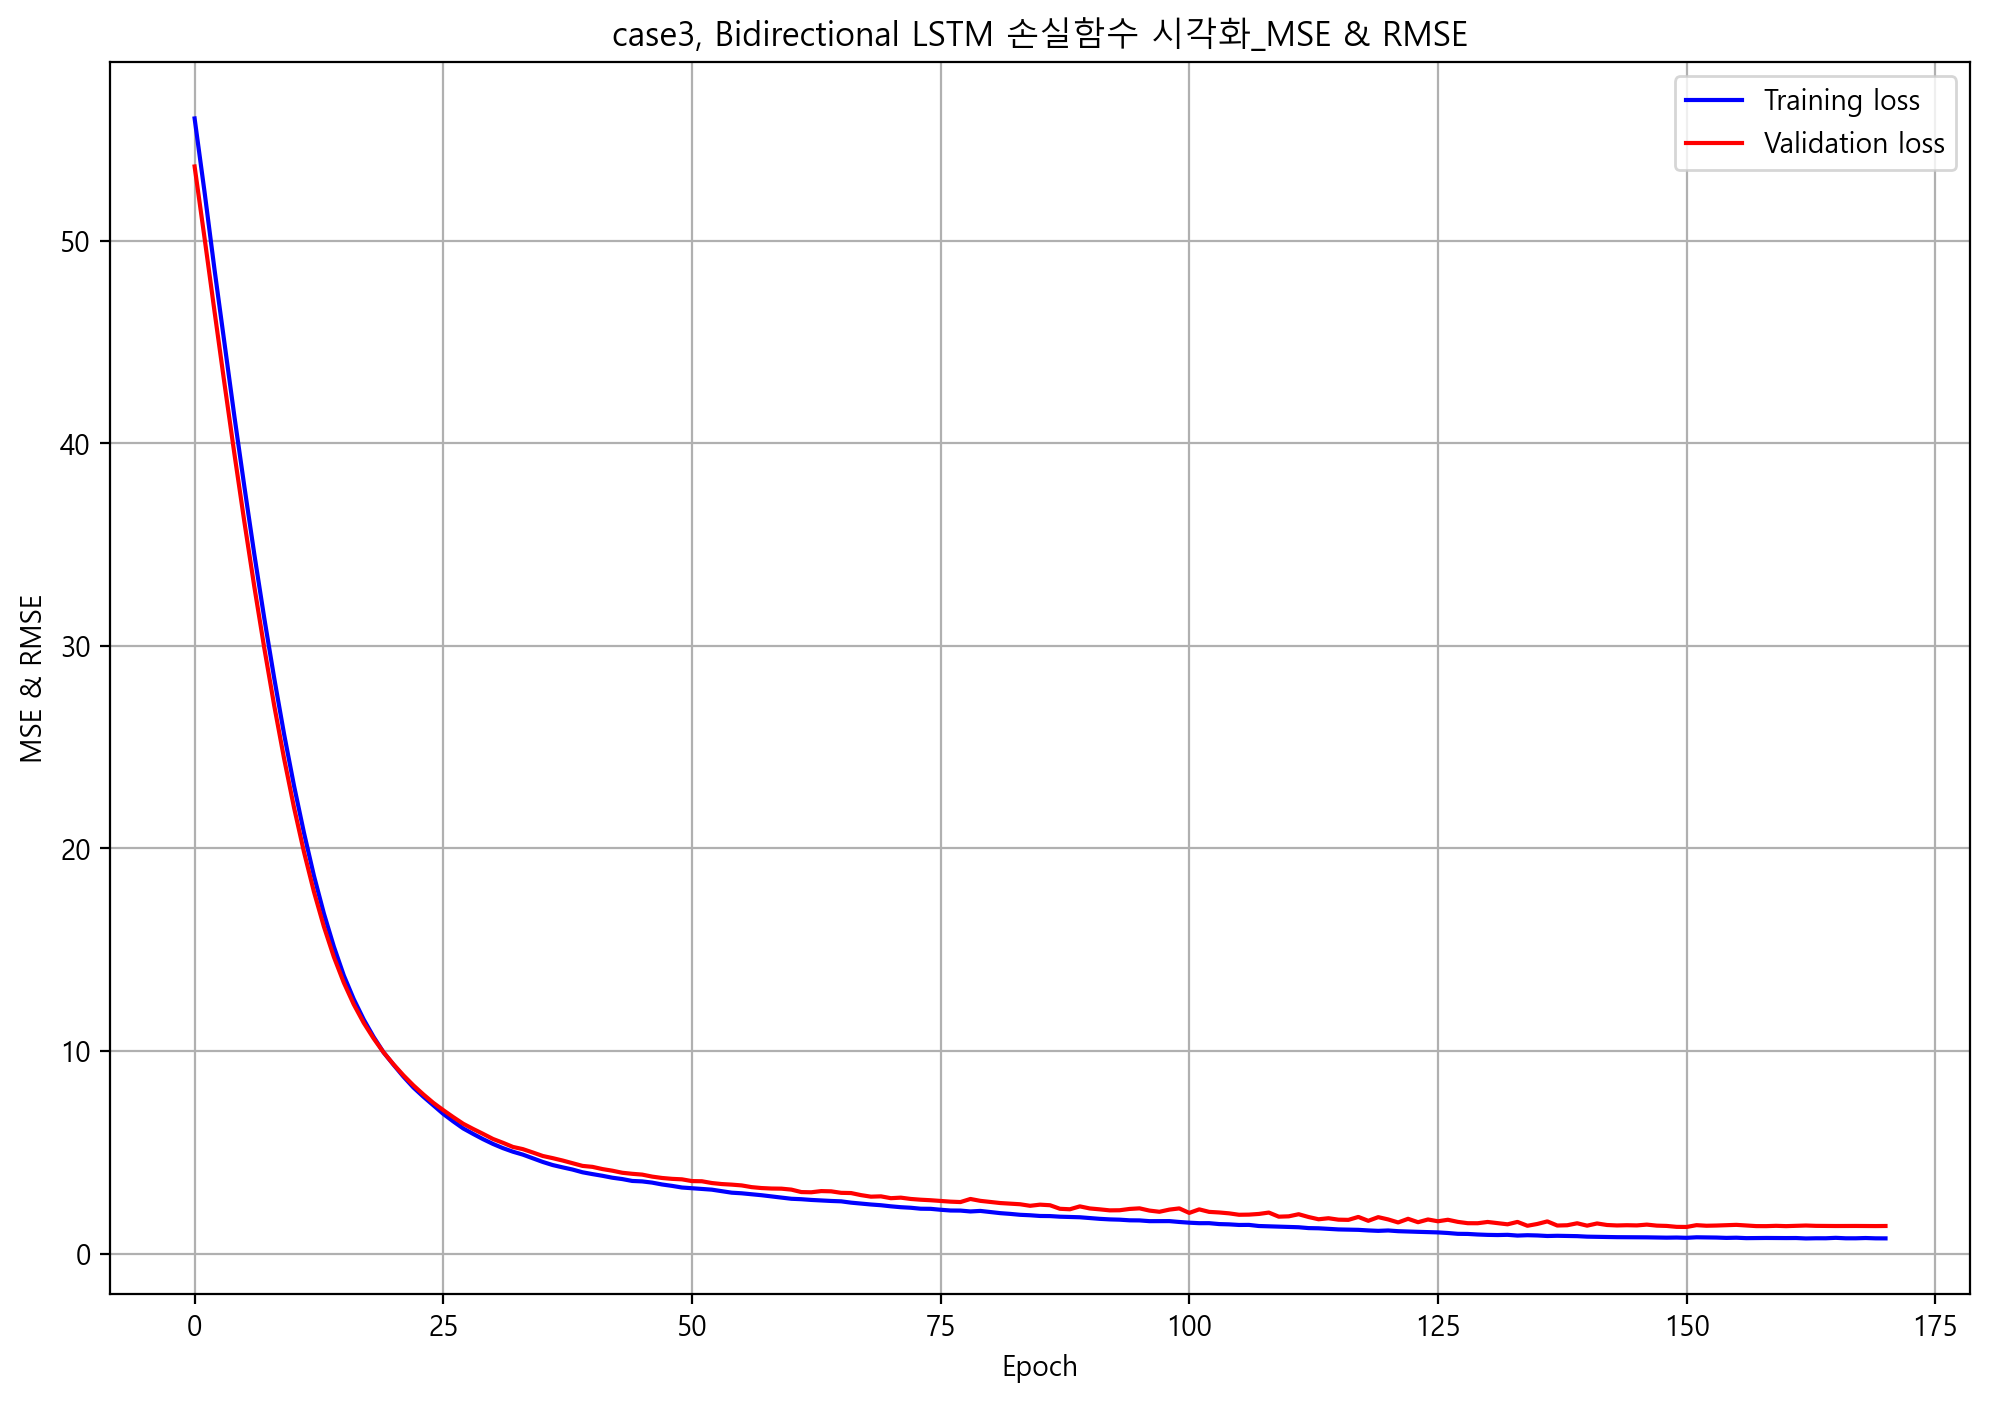

In [88]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization, Input, Embedding, Concatenate, Attention, Bidirectional
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import legacy as legacy_optimizers
from tensorflow.keras import metrics

# Attention 레이어 정의
def attention_layer(inputs):
    attention = Attention()([inputs, inputs])
    return Concatenate()([inputs, attention])

# 옵티마이저 설정
initial_lr = 0.0005
optimizer = legacy_optimizers.Adam(learning_rate=initial_lr)

# 범주형 변수 설정
num_categories = 3
embedding_dim = 5

# 옵티마이저 및 콜백 설정
optimizer = Adam(learning_rate=initial_lr)
lr_restart = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# 모델 정의
numerical_input = Input(shape=(x_train_multi.shape[1], x_train_multi.shape[2]))
categorical_input = Input(shape=(x_train_label.shape[1], ))

# 임베딩 레이어
embedding = Embedding(input_dim=num_categories, output_dim=embedding_dim)(categorical_input)

# 입력 결합
combined_input = Concatenate(axis=-1)([numerical_input, embedding])

x = Bidirectional(LSTM(128, return_sequences=True,
                   kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                   bias_regularizer=l1_l2(l1=0.005, l2=0.005)))(combined_input)
x = BatchNormalization()(x)
x = Dropout(0.3, seed = 40)(x)

x = Bidirectional(LSTM(64, return_sequences=True,
                   kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                   bias_regularizer=l1_l2(l1=0.005, l2=0.005)))(x)
x = BatchNormalization()(x)
x = Dropout(0.3, seed = 41)(x)

x = attention_layer(x)

x = LSTM(32, activation='relu',
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3, seed = 42)(x)

x = Dense(24, activation='relu')(x)
output = Dense(12)(x)

case3_bi_rmse = Model(inputs=[numerical_input, categorical_input], outputs=output)
case3_bi_rmse.compile(optimizer=optimizer
                       , loss="mse"
                       , metrics=[metrics.RootMeanSquaredError()]
                      )

# 모델 학습
case3_bi_rmse_history = case3_bi_rmse.fit(
    # 수치형 데이터와 범주형 데이터 분리    
    [x_train_multi, x_train_label],  
    y_train_multi,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    steps_per_epoch = x_train_multi.shape[0] // BATCH_SIZE, 
    validation_steps = x_val_multi.shape[0] // BATCH_SIZE,
    validation_data=([x_val_multi, x_val_label], y_val_multi),
    callbacks=[lr_restart, early_stop]
)

# 학습 결과 시각화
plot_train_history(case3_bi_rmse_history, "case3, Bidirectional LSTM", "MSE & RMSE")

# 모델 학습
case3_bi_rmse.save("./output/case3/case3_bi_rmse.h5")

# Case4) DMI & 로그 변환

## 데이터 전처리

In [89]:
os.mkdir("./output/case4")

case4_df = data[['DMI', 'ONI', 'SOI', 'ENSO', 'D20_SCTR']]

case4_dts = case4_df.values

case4_label = case4_dts[ : , 3]
case4_dts = case4_dts[ : , [0, 1, 2, 4]]

case4_dts = np.sign(case4_dts) * np.log1p(np.abs(case4_dts))

## 데이터 분리

In [90]:
# 학습 데이터
x_train_multi, y_train_multi = multivariate_data(case4_dts, case4_dts[:, -1], 0, TRAIN_SPLIT - future_target, past_history, future_target, STEP)

x_train_label = label_split(case4_label, 0, TRAIN_SPLIT - future_target, past_history, future_target, STEP)

# 검증 데이터
x_val_multi, y_val_multi = multivariate_data(case4_dts, case4_dts[:, -1], TRAIN_SPLIT, TRAIN_SPLIT + VAL_SPLIT - future_target, past_history, future_target, STEP)

x_val_label = label_split(case4_label, TRAIN_SPLIT, TRAIN_SPLIT + VAL_SPLIT - future_target, past_history, future_target, STEP)

# 테스트 데이터
x_test_case4, y_test_case4 = multivariate_data(case4_dts, case4_dts[:, -1], TRAIN_SPLIT + VAL_SPLIT, None, past_history, future_target, STEP)

x_test_case4_label = label_split(case4_label, TRAIN_SPLIT + VAL_SPLIT, None, past_history, future_target, STEP)

## 모델 학습

### 단방향 LSTM

Epoch 1/300
16/16 [==============================] - 4s 56ms/step - loss: 24.9411 - val_loss: 24.2021 - lr: 5.0000e-04
Epoch 2/300
16/16 [==============================] - 0s 12ms/step - loss: 22.9801 - val_loss: 22.4954 - lr: 5.0000e-04
Epoch 3/300
16/16 [==============================] - 0s 12ms/step - loss: 21.1448 - val_loss: 20.8746 - lr: 5.0000e-04
Epoch 4/300
16/16 [==============================] - 0s 12ms/step - loss: 19.3809 - val_loss: 19.2997 - lr: 5.0000e-04
Epoch 5/300
16/16 [==============================] - 0s 12ms/step - loss: 17.6889 - val_loss: 17.7879 - lr: 5.0000e-04
Epoch 6/300
16/16 [==============================] - 0s 12ms/step - loss: 16.0612 - val_loss: 16.3223 - lr: 5.0000e-04
Epoch 7/300
16/16 [==============================] - 0s 12ms/step - loss: 14.5650 - val_loss: 14.9106 - lr: 5.0000e-04
Epoch 8/300
16/16 [==============================] - 0s 12ms/step - loss: 13.1607 - val_loss: 13.5997 - lr: 5.0000e-04
Epoch 9/300
16/16 [=============================

16/16 [==============================] - 0s 11ms/step - loss: 1.6232 - val_loss: 1.2975 - lr: 2.5000e-04
Epoch 70/300
16/16 [==============================] - 0s 11ms/step - loss: 1.5909 - val_loss: 1.3206 - lr: 2.5000e-04
Epoch 71/300
16/16 [==============================] - 0s 11ms/step - loss: 1.6336 - val_loss: 1.3230 - lr: 2.5000e-04
Epoch 72/300
16/16 [==============================] - 0s 11ms/step - loss: 1.6004 - val_loss: 1.3697 - lr: 2.5000e-04
Epoch 73/300
16/16 [==============================] - 0s 11ms/step - loss: 1.5811 - val_loss: 1.3207 - lr: 2.5000e-04
Epoch 74/300
16/16 [==============================] - 0s 11ms/step - loss: 1.6142 - val_loss: 1.2645 - lr: 2.5000e-04
Epoch 75/300
16/16 [==============================] - 0s 12ms/step - loss: 1.6099 - val_loss: 1.2740 - lr: 2.5000e-04
Epoch 76/300
16/16 [==============================] - 0s 11ms/step - loss: 1.5973 - val_loss: 1.2048 - lr: 2.5000e-04
Epoch 77/300
16/16 [==============================] - 0s 12ms/step - 

16/16 [==============================] - 0s 11ms/step - loss: 1.2871 - val_loss: 1.0147 - lr: 1.5625e-05
Epoch 134/300
16/16 [==============================] - 0s 11ms/step - loss: 1.2322 - val_loss: 1.0135 - lr: 1.5625e-05
Epoch 135/300
16/16 [==============================] - 0s 11ms/step - loss: 1.2640 - val_loss: 1.0201 - lr: 1.5625e-05
Epoch 136/300
13/16 [=======================>......] - ETA: 0s - loss: 1.2609
Epoch 136: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.
16/16 [==============================] - 0s 11ms/step - loss: 1.2699 - val_loss: 1.0247 - lr: 1.5625e-05
Epoch 137/300
16/16 [==============================] - 0s 12ms/step - loss: 1.2163 - val_loss: 1.0167 - lr: 7.8125e-06
Epoch 138/300
16/16 [==============================] - 0s 12ms/step - loss: 1.2658 - val_loss: 1.0139 - lr: 7.8125e-06
Epoch 139/300
16/16 [==============================] - 0s 11ms/step - loss: 1.2557 - val_loss: 1.0102 - lr: 7.8125e-06
Epoch 140/300
16/16 [==================

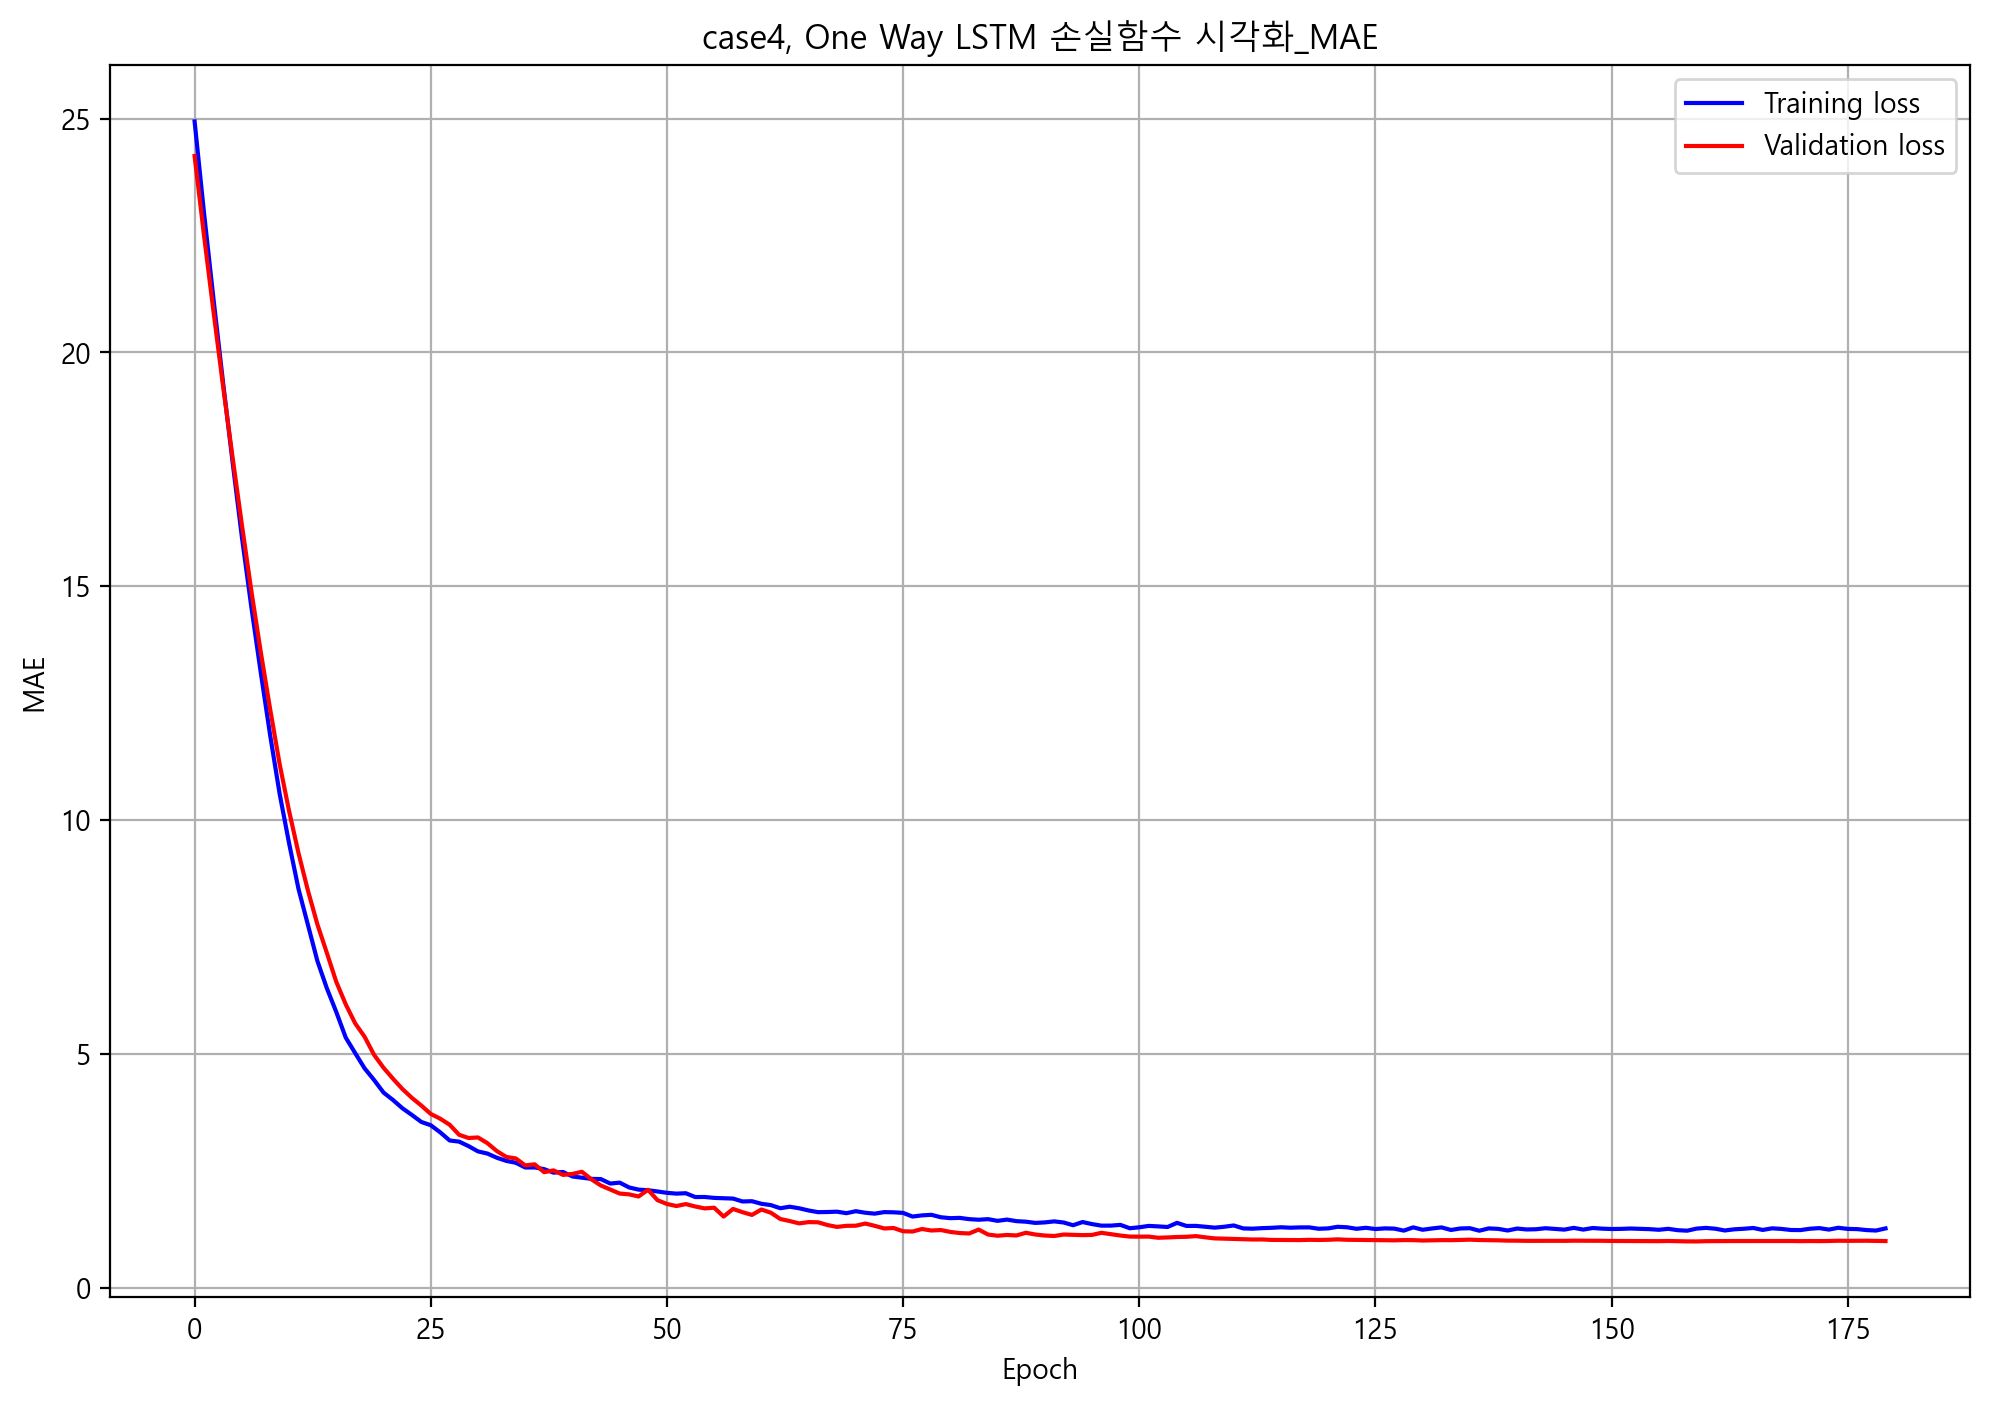

In [91]:
from tensorflow.keras.optimizers import legacy as legacy_optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization, Input, Embedding, Concatenate, Attention
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras import metrics

# Attention 레이어 정의
def attention_layer(inputs):
    attention = Attention()([inputs, inputs])
    return Concatenate()([inputs, attention])

# 옵티마이저 설정
initial_lr = 0.0005
optimizer = legacy_optimizers.Adam(learning_rate=initial_lr)

# 범주형 변수 설정
num_categories = 3
embedding_dim = 5

# 옵티마이저 및 콜백 설정
optimizer = Adam(learning_rate=initial_lr)
lr_restart = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# 모델 정의
numerical_input = Input(shape=(x_train_multi.shape[1], x_train_multi.shape[2]))
categorical_input = Input(shape=(x_train_label.shape[1], ))

# 임베딩 레이어
embedding = Embedding(input_dim=num_categories, output_dim=embedding_dim)(categorical_input)

# 입력 결합
combined_input = Concatenate(axis=-1)([numerical_input, embedding])

x = LSTM(128, return_sequences=True,
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(combined_input)
x = BatchNormalization()(x)
x = Dropout(0.3, seed = 40)(x)

x = LSTM(64, return_sequences=True,
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3, seed = 41)(x)

x = attention_layer(x)

x = LSTM(32, activation='relu',
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3, seed = 42)(x)

x = Dense(24, activation='relu')(x)
output = Dense(12)(x)

case4_uni_mae = Model(inputs=[numerical_input, categorical_input], outputs=output)
case4_uni_mae.compile(optimizer=optimizer, loss="mae" )

# 모델 학습
case4_uni_mae_history = case4_uni_mae.fit(
    # 수치형 데이터와 범주형 데이터 분리    
    [x_train_multi, x_train_label],  
    y_train_multi,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    steps_per_epoch = x_train_multi.shape[0] // BATCH_SIZE, 
    validation_steps = x_val_multi.shape[0] // BATCH_SIZE,
    validation_data=([x_val_multi, x_val_label], y_val_multi),
    callbacks=[lr_restart, early_stop]
)

# 학습 결과 시각화
plot_train_history(case4_uni_mae_history, "case4, One Way LSTM", "MAE")

# 모델 저장
case4_uni_mae.save("./output/case4/case4_uni_mae.h5")

Epoch 1/300
16/16 [==============================] - 4s 57ms/step - loss: 38.8666 - val_loss: 40.0671 - lr: 5.0000e-04
Epoch 2/300
16/16 [==============================] - 0s 12ms/step - loss: 36.3695 - val_loss: 38.7687 - lr: 5.0000e-04
Epoch 3/300
16/16 [==============================] - 0s 13ms/step - loss: 34.4477 - val_loss: 37.1252 - lr: 5.0000e-04
Epoch 4/300
16/16 [==============================] - 0s 13ms/step - loss: 32.4194 - val_loss: 36.0598 - lr: 5.0000e-04
Epoch 5/300
16/16 [==============================] - 0s 12ms/step - loss: 30.0321 - val_loss: 34.4621 - lr: 5.0000e-04
Epoch 6/300
16/16 [==============================] - 0s 11ms/step - loss: 27.8892 - val_loss: 33.0950 - lr: 5.0000e-04
Epoch 7/300
16/16 [==============================] - 0s 12ms/step - loss: 25.9443 - val_loss: 31.3059 - lr: 5.0000e-04
Epoch 8/300
16/16 [==============================] - 0s 11ms/step - loss: 24.0735 - val_loss: 29.1523 - lr: 5.0000e-04
Epoch 9/300
16/16 [=============================

16/16 [==============================] - 0s 11ms/step - loss: 2.6262 - val_loss: 2.5605 - lr: 5.0000e-04
Epoch 71/300
16/16 [==============================] - 0s 11ms/step - loss: 2.5785 - val_loss: 2.3125 - lr: 5.0000e-04
Epoch 72/300
16/16 [==============================] - 0s 11ms/step - loss: 2.6599 - val_loss: 2.4129 - lr: 5.0000e-04
Epoch 73/300
16/16 [==============================] - 0s 11ms/step - loss: 2.4892 - val_loss: 2.2989 - lr: 5.0000e-04
Epoch 74/300
16/16 [==============================] - 0s 12ms/step - loss: 2.4864 - val_loss: 2.2102 - lr: 5.0000e-04
Epoch 75/300
16/16 [==============================] - 0s 12ms/step - loss: 2.3669 - val_loss: 2.2292 - lr: 5.0000e-04
Epoch 76/300
16/16 [==============================] - 0s 12ms/step - loss: 2.3832 - val_loss: 2.0004 - lr: 5.0000e-04
Epoch 77/300
16/16 [==============================] - 0s 11ms/step - loss: 2.2169 - val_loss: 2.0186 - lr: 5.0000e-04
Epoch 78/300
16/16 [==============================] - 0s 11ms/step - 

16/16 [==============================] - 0s 11ms/step - loss: 1.1133 - val_loss: 0.8572 - lr: 6.2500e-05
Epoch 136/300
16/16 [==============================] - 0s 11ms/step - loss: 1.0865 - val_loss: 0.8743 - lr: 6.2500e-05
Epoch 137/300
16/16 [==============================] - 0s 11ms/step - loss: 1.0374 - val_loss: 0.8517 - lr: 6.2500e-05
Epoch 138/300
16/16 [==============================] - 0s 12ms/step - loss: 1.0965 - val_loss: 0.8318 - lr: 6.2500e-05
Epoch 139/300
16/16 [==============================] - 0s 11ms/step - loss: 1.0773 - val_loss: 0.8600 - lr: 6.2500e-05
Epoch 140/300
16/16 [==============================] - 0s 11ms/step - loss: 1.0586 - val_loss: 0.8367 - lr: 6.2500e-05
Epoch 141/300
16/16 [==============================] - 0s 12ms/step - loss: 1.0817 - val_loss: 0.8095 - lr: 6.2500e-05
Epoch 142/300
16/16 [==============================] - 0s 11ms/step - loss: 1.0527 - val_loss: 0.8272 - lr: 6.2500e-05
Epoch 143/300
16/16 [==============================] - 0s 12ms

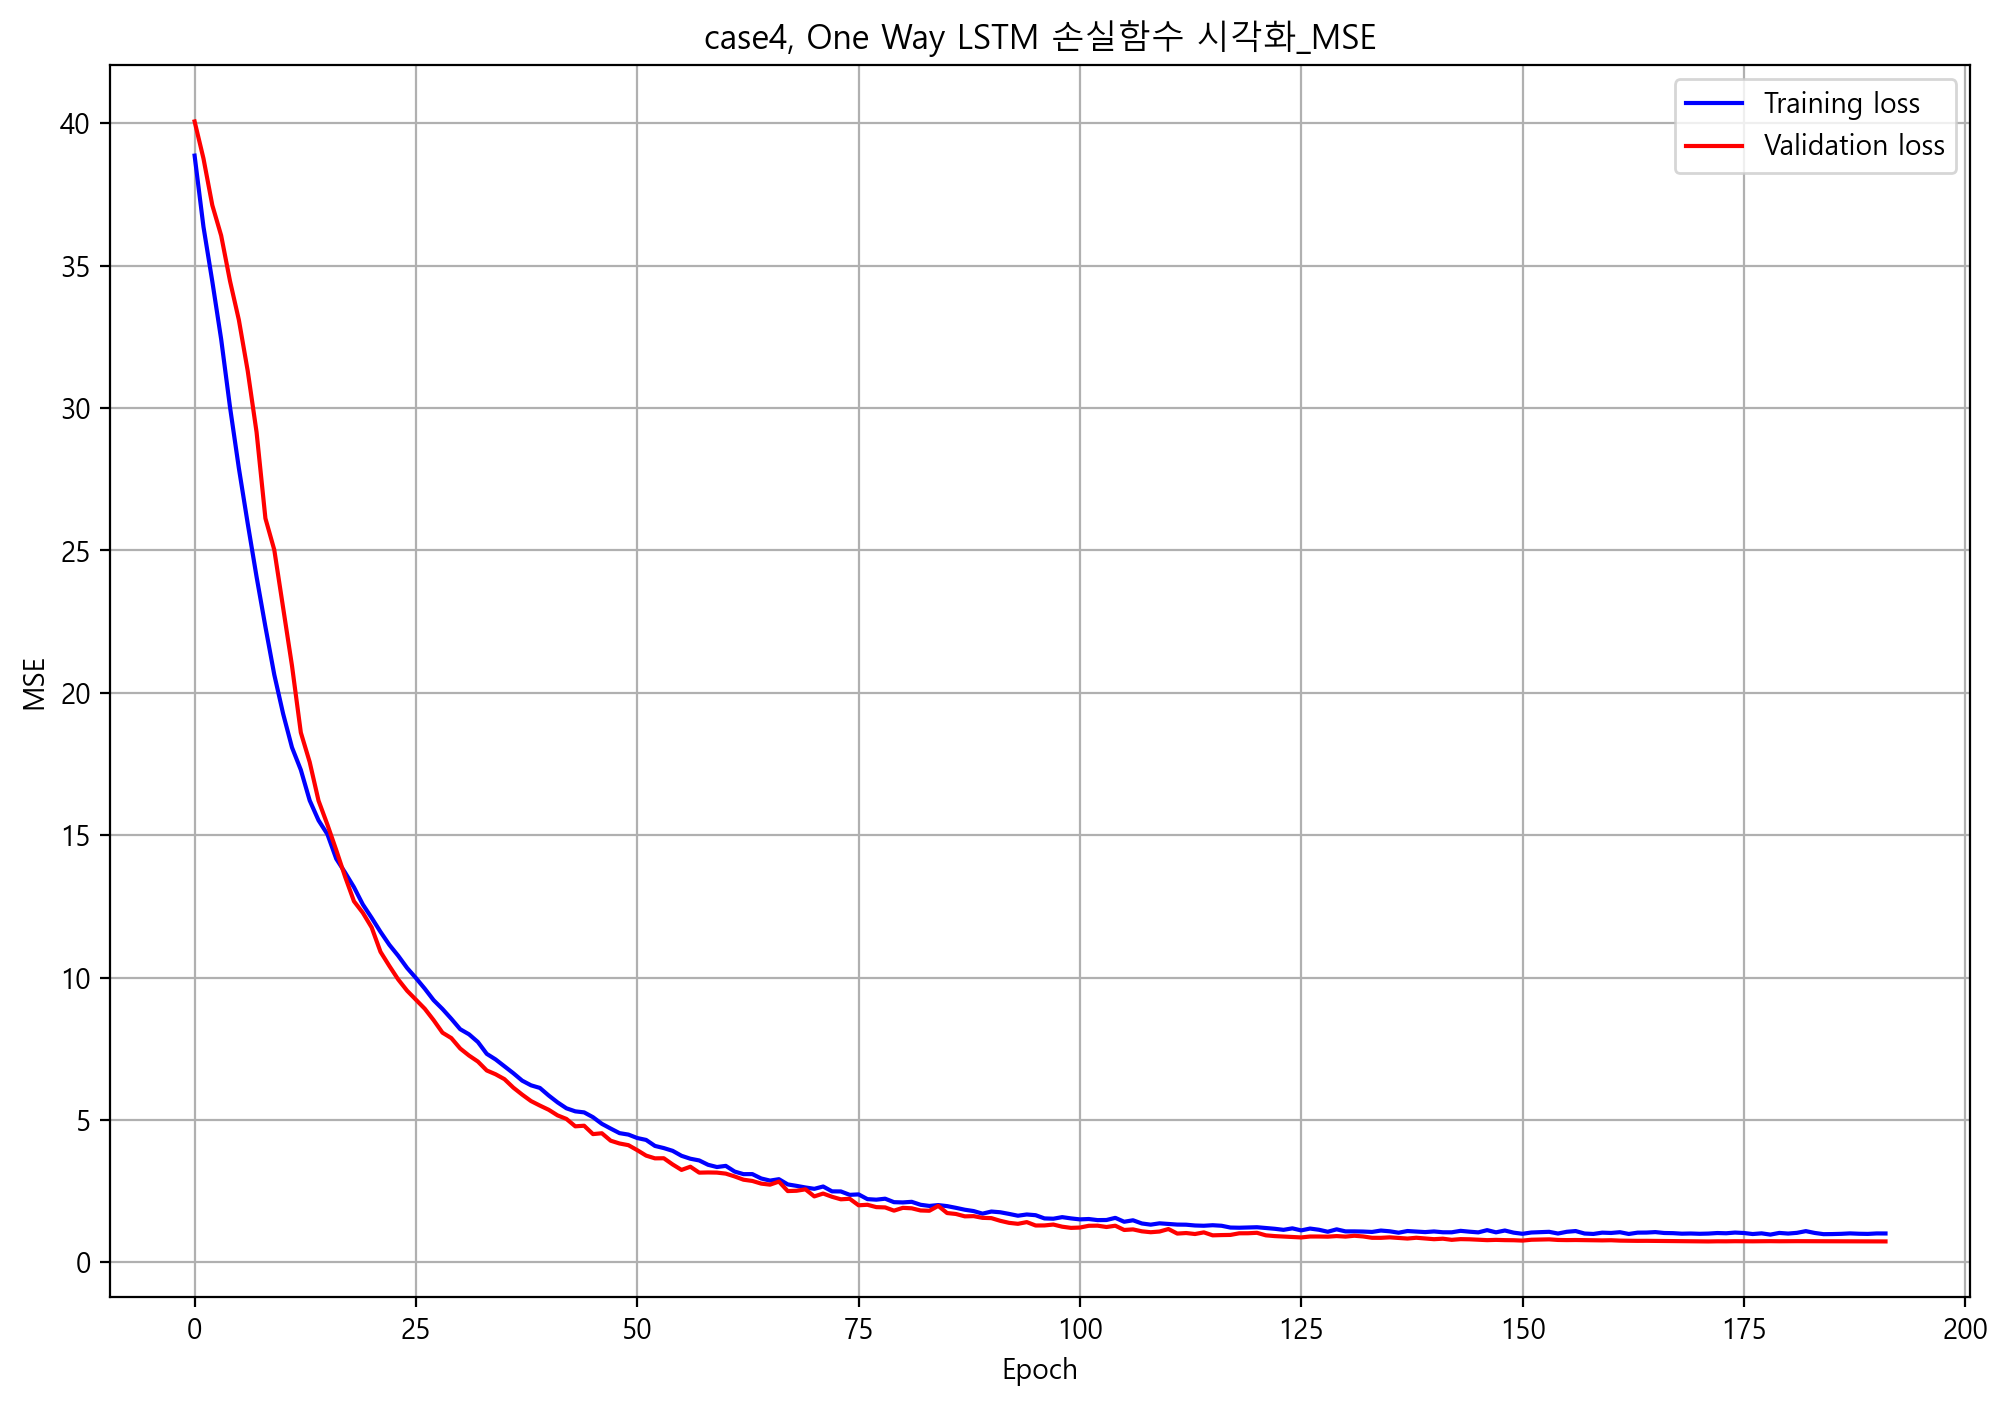

In [92]:
from tensorflow.keras.optimizers import legacy as legacy_optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization, Input, Embedding, Concatenate, Attention
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras import metrics

# Attention 레이어 정의
def attention_layer(inputs):
    attention = Attention()([inputs, inputs])
    return Concatenate()([inputs, attention])

# 옵티마이저 설정
initial_lr = 0.0005
optimizer = legacy_optimizers.Adam(learning_rate=initial_lr)

# 범주형 변수 설정
num_categories = 3
embedding_dim = 5

# 옵티마이저 및 콜백 설정
optimizer = Adam(learning_rate=initial_lr)
lr_restart = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# 모델 정의
numerical_input = Input(shape=(x_train_multi.shape[1], x_train_multi.shape[2]))
categorical_input = Input(shape=(x_train_label.shape[1], ))

# 임베딩 레이어
embedding = Embedding(input_dim=num_categories, output_dim=embedding_dim)(categorical_input)

# 입력 결합
combined_input = Concatenate(axis=-1)([numerical_input, embedding])

x = LSTM(128, return_sequences=True,
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(combined_input)
x = BatchNormalization()(x)
x = Dropout(0.3, seed = 40)(x)

x = LSTM(64, return_sequences=True,
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3, seed = 41)(x)

x = attention_layer(x)

x = LSTM(32, activation='relu',
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3, seed = 42)(x)

x = Dense(24, activation='relu')(x)
output = Dense(12)(x)

case4_uni_mse = Model(inputs=[numerical_input, categorical_input], outputs=output)
case4_uni_mse.compile(optimizer=optimizer, loss="mse" )

# 모델 학습
case4_uni_mse_history = case4_uni_mse.fit(
    # 수치형 데이터와 범주형 데이터 분리    
    [x_train_multi, x_train_label],  
    y_train_multi,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    steps_per_epoch = x_train_multi.shape[0] // BATCH_SIZE, 
    validation_steps = x_val_multi.shape[0] // BATCH_SIZE,
    validation_data=([x_val_multi, x_val_label], y_val_multi),
    callbacks=[lr_restart, early_stop]
)

# 학습 결과 시각화
plot_train_history(case4_uni_mse_history, "case4, One Way LSTM", "MSE")

# 모델 저장
case4_uni_mse.save("./output/case4/case4_uni_mse.h5")

Epoch 1/300
16/16 [==============================] - 4s 56ms/step - loss: 38.4755 - root_mean_squared_error: 4.1392 - val_loss: 39.9138 - val_root_mean_squared_error: 4.3405 - lr: 5.0000e-04
Epoch 2/300
16/16 [==============================] - 0s 13ms/step - loss: 36.0165 - root_mean_squared_error: 3.8987 - val_loss: 38.9903 - val_root_mean_squared_error: 4.2982 - lr: 5.0000e-04
Epoch 3/300
16/16 [==============================] - 0s 13ms/step - loss: 33.5817 - root_mean_squared_error: 3.6530 - val_loss: 37.7740 - val_root_mean_squared_error: 4.2258 - lr: 5.0000e-04
Epoch 4/300
16/16 [==============================] - 0s 12ms/step - loss: 31.4503 - root_mean_squared_error: 3.4382 - val_loss: 36.2037 - val_root_mean_squared_error: 4.1108 - lr: 5.0000e-04
Epoch 5/300
16/16 [==============================] - 0s 12ms/step - loss: 29.2446 - root_mean_squared_error: 3.1979 - val_loss: 34.6578 - val_root_mean_squared_error: 3.9959 - lr: 5.0000e-04
Epoch 6/300
16/16 [==========================

Epoch 44/300
16/16 [==============================] - 0s 12ms/step - loss: 4.8863 - root_mean_squared_error: 0.7840 - val_loss: 4.6419 - val_root_mean_squared_error: 0.6715 - lr: 5.0000e-04
Epoch 45/300
16/16 [==============================] - 0s 12ms/step - loss: 4.8761 - root_mean_squared_error: 0.8625 - val_loss: 4.4916 - val_root_mean_squared_error: 0.6438 - lr: 5.0000e-04
Epoch 46/300
16/16 [==============================] - 0s 12ms/step - loss: 4.9323 - root_mean_squared_error: 0.9407 - val_loss: 4.7483 - val_root_mean_squared_error: 0.8597 - lr: 5.0000e-04
Epoch 47/300
16/16 [==============================] - 0s 12ms/step - loss: 4.5937 - root_mean_squared_error: 0.8001 - val_loss: 4.6441 - val_root_mean_squared_error: 0.8755 - lr: 5.0000e-04
Epoch 48/300
16/16 [==============================] - 0s 12ms/step - loss: 4.4548 - root_mean_squared_error: 0.8026 - val_loss: 4.5469 - val_root_mean_squared_error: 0.9025 - lr: 5.0000e-04
Epoch 49/300
16/16 [==============================

16/16 [==============================] - 0s 11ms/step - loss: 2.0175 - root_mean_squared_error: 0.7168 - val_loss: 1.7366 - val_root_mean_squared_error: 0.5003 - lr: 5.0000e-04
Epoch 88/300
16/16 [==============================] - 0s 12ms/step - loss: 1.9636 - root_mean_squared_error: 0.7117 - val_loss: 1.6436 - val_root_mean_squared_error: 0.4582 - lr: 5.0000e-04
Epoch 89/300
16/16 [==============================] - 0s 12ms/step - loss: 1.9238 - root_mean_squared_error: 0.7111 - val_loss: 1.5278 - val_root_mean_squared_error: 0.3602 - lr: 5.0000e-04
Epoch 90/300
16/16 [==============================] - 0s 11ms/step - loss: 1.8685 - root_mean_squared_error: 0.6919 - val_loss: 1.5787 - val_root_mean_squared_error: 0.4432 - lr: 5.0000e-04
Epoch 91/300
16/16 [==============================] - 0s 12ms/step - loss: 1.8726 - root_mean_squared_error: 0.7086 - val_loss: 1.6229 - val_root_mean_squared_error: 0.5004 - lr: 5.0000e-04
Epoch 92/300
16/16 [==============================] - 0s 12ms/s

16/16 [==============================] - 0s 12ms/step - loss: 1.2173 - root_mean_squared_error: 0.5828 - val_loss: 0.9583 - val_root_mean_squared_error: 0.3018 - lr: 2.5000e-04
Epoch 130/300
16/16 [==============================] - 0s 12ms/step - loss: 1.2816 - root_mean_squared_error: 0.6443 - val_loss: 0.9940 - val_root_mean_squared_error: 0.3617 - lr: 2.5000e-04
Epoch 131/300
16/16 [==============================] - 0s 11ms/step - loss: 1.2322 - root_mean_squared_error: 0.6104 - val_loss: 1.0255 - val_root_mean_squared_error: 0.4146 - lr: 2.5000e-04
Epoch 132/300
16/16 [==============================] - 0s 11ms/step - loss: 1.2770 - root_mean_squared_error: 0.6498 - val_loss: 0.9774 - val_root_mean_squared_error: 0.3490 - lr: 2.5000e-04
Epoch 133/300
16/16 [==============================] - 0s 11ms/step - loss: 1.1939 - root_mean_squared_error: 0.5885 - val_loss: 0.9536 - val_root_mean_squared_error: 0.3399 - lr: 2.5000e-04
Epoch 134/300
16/16 [==============================] - 0s 1

16/16 [==============================] - 0s 11ms/step - loss: 0.9456 - root_mean_squared_error: 0.5915 - val_loss: 0.6984 - val_root_mean_squared_error: 0.3098 - lr: 1.2500e-04
Epoch 172/300
16/16 [==============================] - 0s 11ms/step - loss: 1.0126 - root_mean_squared_error: 0.6399 - val_loss: 0.7016 - val_root_mean_squared_error: 0.3111 - lr: 1.2500e-04
Epoch 173/300
16/16 [==============================] - 0s 11ms/step - loss: 0.9460 - root_mean_squared_error: 0.5882 - val_loss: 0.6614 - val_root_mean_squared_error: 0.2599 - lr: 1.2500e-04
Epoch 174/300
16/16 [==============================] - 0s 11ms/step - loss: 0.9631 - root_mean_squared_error: 0.6114 - val_loss: 0.6902 - val_root_mean_squared_error: 0.3246 - lr: 1.2500e-04
Epoch 175/300
16/16 [==============================] - 0s 11ms/step - loss: 0.9830 - root_mean_squared_error: 0.6295 - val_loss: 0.6905 - val_root_mean_squared_error: 0.3150 - lr: 1.2500e-04
Epoch 176/300
16/16 [==============================] - 0s 1

16/16 [==============================] - 0s 12ms/step - loss: 0.8048 - root_mean_squared_error: 0.5622 - val_loss: 0.5846 - val_root_mean_squared_error: 0.3102 - lr: 1.5625e-05
Epoch 212/300
16/16 [==============================] - 0s 12ms/step - loss: 0.8276 - root_mean_squared_error: 0.5828 - val_loss: 0.5809 - val_root_mean_squared_error: 0.3059 - lr: 1.5625e-05
Epoch 213/300
16/16 [==============================] - 0s 11ms/step - loss: 0.8334 - root_mean_squared_error: 0.5883 - val_loss: 0.5794 - val_root_mean_squared_error: 0.3039 - lr: 1.5625e-05
Epoch 214/300
16/16 [==============================] - 0s 11ms/step - loss: 0.8079 - root_mean_squared_error: 0.5664 - val_loss: 0.5690 - val_root_mean_squared_error: 0.2865 - lr: 1.5625e-05
Epoch 215/300
16/16 [==============================] - 0s 11ms/step - loss: 0.8407 - root_mean_squared_error: 0.5952 - val_loss: 0.5799 - val_root_mean_squared_error: 0.3057 - lr: 1.5625e-05
Epoch 216/300
16/16 [==============================] - 0s 1

16/16 [==============================] - 0s 11ms/step - loss: 0.8178 - root_mean_squared_error: 0.5834 - val_loss: 0.5677 - val_root_mean_squared_error: 0.3006 - lr: 1.0000e-06
Epoch 251/300
16/16 [==============================] - 0s 11ms/step - loss: 0.7937 - root_mean_squared_error: 0.5624 - val_loss: 0.5655 - val_root_mean_squared_error: 0.2970 - lr: 1.0000e-06
Epoch 252/300
16/16 [==============================] - 0s 11ms/step - loss: 0.7815 - root_mean_squared_error: 0.5516 - val_loss: 0.5661 - val_root_mean_squared_error: 0.2983 - lr: 1.0000e-06
Epoch 253/300
16/16 [==============================] - 0s 11ms/step - loss: 0.7621 - root_mean_squared_error: 0.5338 - val_loss: 0.5678 - val_root_mean_squared_error: 0.3011 - lr: 1.0000e-06
Epoch 254/300
16/16 [==============================] - 0s 12ms/step - loss: 0.8282 - root_mean_squared_error: 0.5926 - val_loss: 0.5659 - val_root_mean_squared_error: 0.2982 - lr: 1.0000e-06
Epoch 255/300
16/16 [==============================] - 0s 1

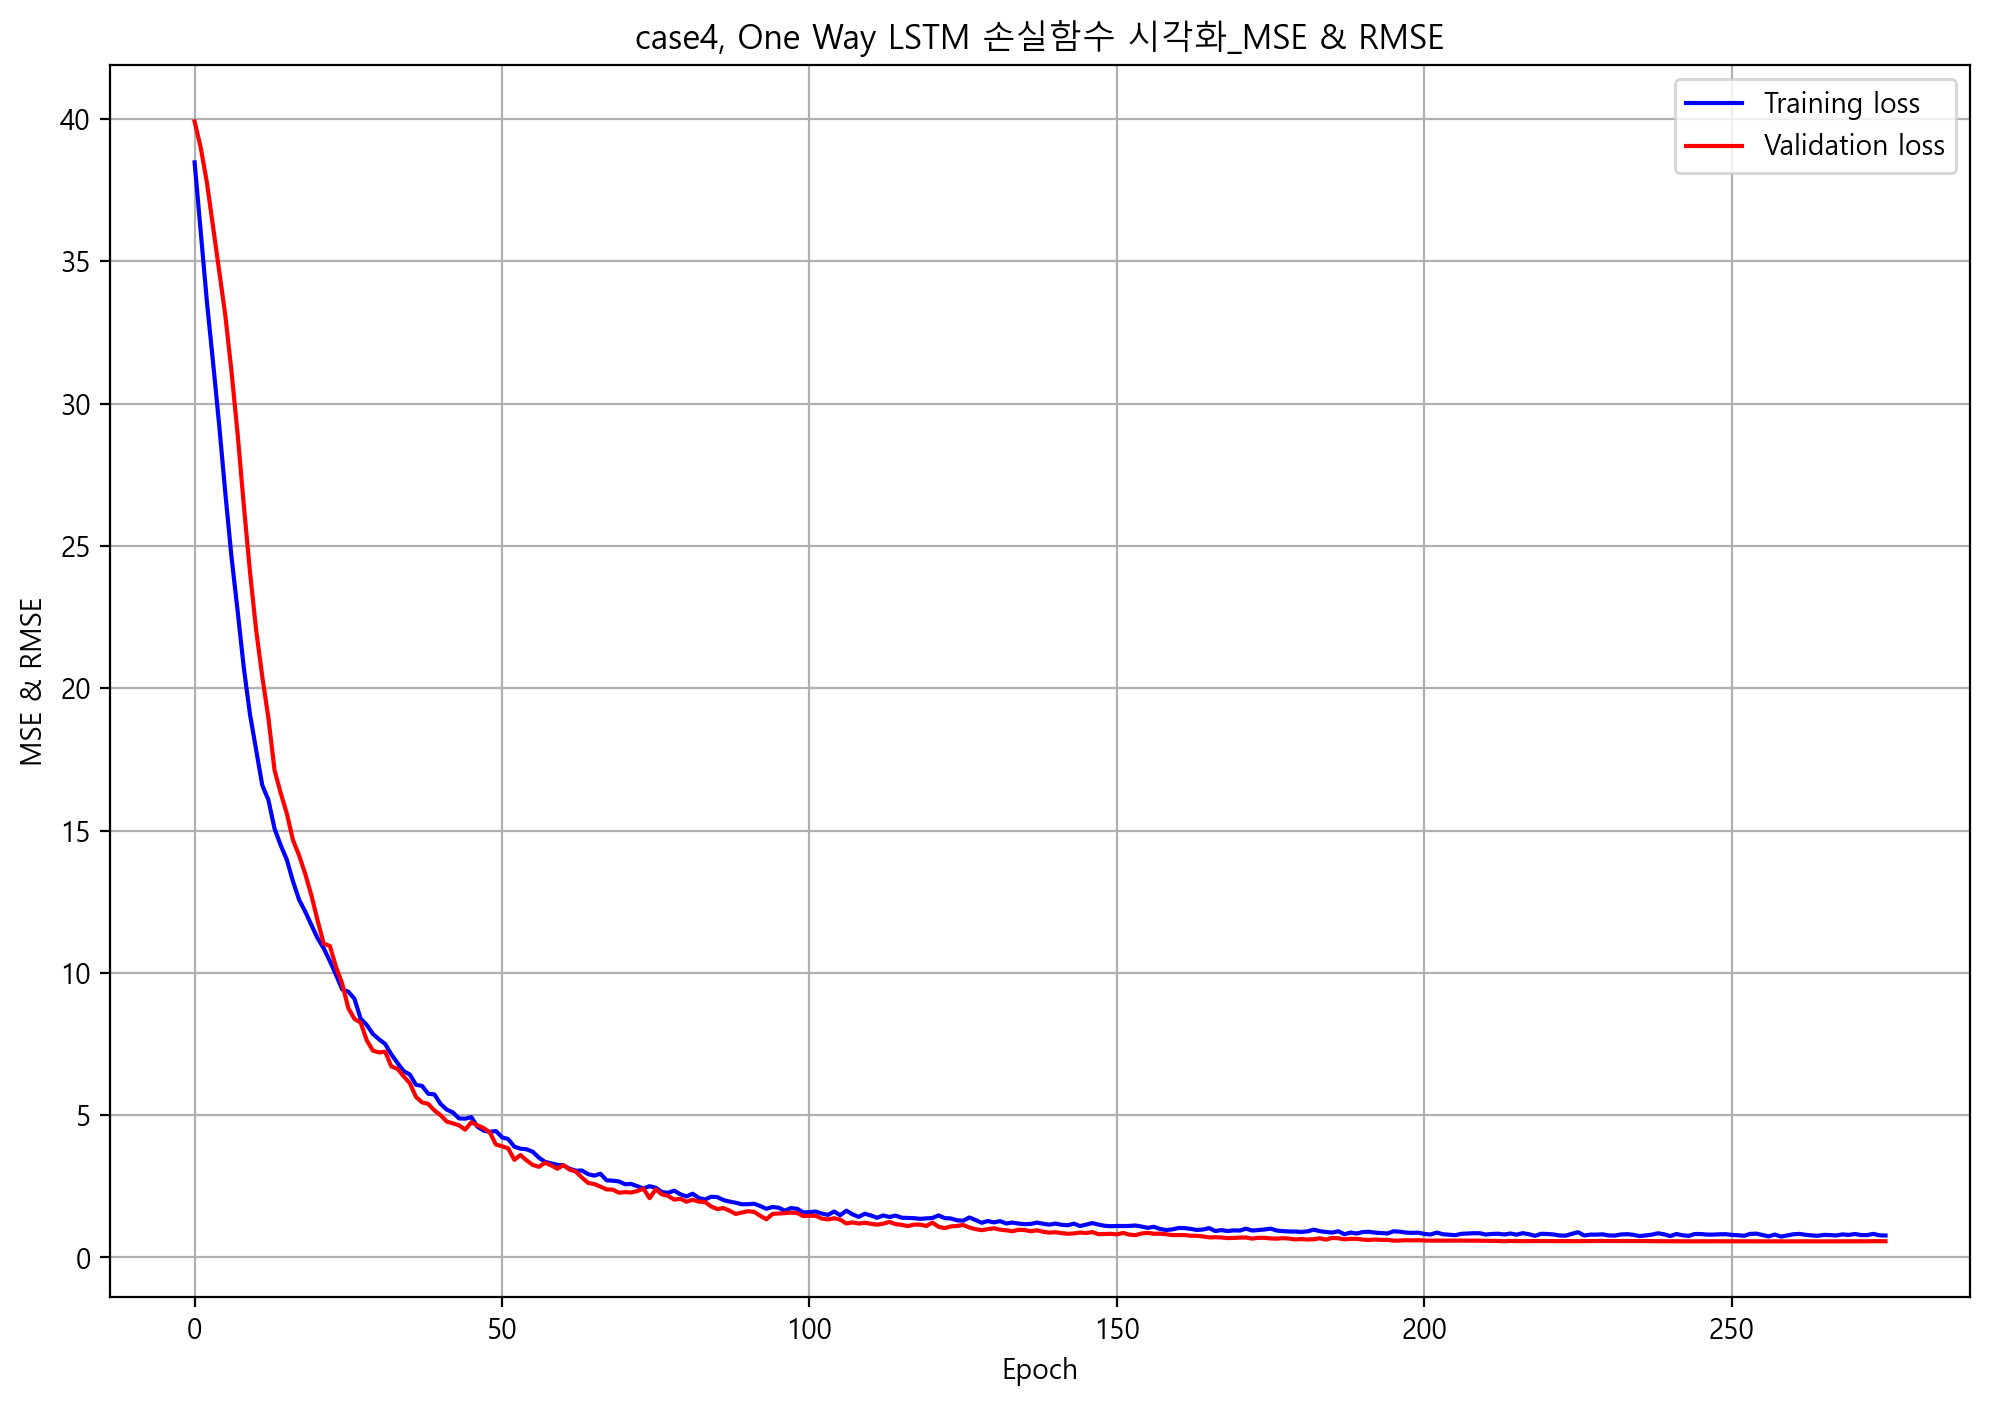

In [93]:
from tensorflow.keras.optimizers import legacy as legacy_optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization, Input, Embedding, Concatenate, Attention
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras import metrics

# Attention 레이어 정의
def attention_layer(inputs):
    attention = Attention()([inputs, inputs])
    return Concatenate()([inputs, attention])

# 옵티마이저 설정
initial_lr = 0.0005
optimizer = legacy_optimizers.Adam(learning_rate=initial_lr)

# 범주형 변수 설정
num_categories = 3
embedding_dim = 5

# 옵티마이저 및 콜백 설정
optimizer = Adam(learning_rate=initial_lr)
lr_restart = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# 모델 정의
numerical_input = Input(shape=(x_train_multi.shape[1], x_train_multi.shape[2]))
categorical_input = Input(shape=(x_train_label.shape[1], ))

# 임베딩 레이어
embedding = Embedding(input_dim=num_categories, output_dim=embedding_dim)(categorical_input)

# 입력 결합
combined_input = Concatenate(axis=-1)([numerical_input, embedding])

x = LSTM(128, return_sequences=True,
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(combined_input)
x = BatchNormalization()(x)
x = Dropout(0.3, seed = 40)(x)

x = LSTM(64, return_sequences=True,
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3, seed = 41)(x)

x = attention_layer(x)

x = LSTM(32, activation='relu',
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3, seed = 42)(x)

x = Dense(24, activation='relu')(x)
output = Dense(12)(x)

case4_uni_rmse = Model(inputs=[numerical_input, categorical_input], outputs=output)
case4_uni_rmse.compile(optimizer=optimizer
                       , loss="mse"
                       , metrics=[metrics.RootMeanSquaredError()]
                      )

# 모델 학습
case4_uni_rmse_history = case4_uni_rmse.fit(
    # 수치형 데이터와 범주형 데이터 분리    
    [x_train_multi, x_train_label],  
    y_train_multi,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    steps_per_epoch = x_train_multi.shape[0] // BATCH_SIZE, 
    validation_steps = x_val_multi.shape[0] // BATCH_SIZE,
    validation_data=([x_val_multi, x_val_label], y_val_multi),
    callbacks=[lr_restart, early_stop]
)

# 학습 결과 시각화
plot_train_history(case4_uni_rmse_history, "case4, One Way LSTM", "MSE & RMSE")

# 모델 저장
case4_uni_rmse.save("./output/case4/case4_uni_rmse.h5")

### 양방향 LSTM

Epoch 1/300
16/16 [==============================] - 6s 89ms/step - loss: 57.5701 - val_loss: 54.2544 - lr: 5.0000e-04
Epoch 2/300
16/16 [==============================] - 0s 18ms/step - loss: 51.5265 - val_loss: 48.4954 - lr: 5.0000e-04
Epoch 3/300
16/16 [==============================] - 0s 18ms/step - loss: 45.7586 - val_loss: 43.1054 - lr: 5.0000e-04
Epoch 4/300
16/16 [==============================] - 0s 18ms/step - loss: 40.4262 - val_loss: 38.1054 - lr: 5.0000e-04
Epoch 5/300
16/16 [==============================] - 0s 19ms/step - loss: 35.4184 - val_loss: 33.4884 - lr: 5.0000e-04
Epoch 6/300
16/16 [==============================] - 0s 18ms/step - loss: 30.8054 - val_loss: 29.2881 - lr: 5.0000e-04
Epoch 7/300
16/16 [==============================] - 0s 18ms/step - loss: 26.6272 - val_loss: 25.4816 - lr: 5.0000e-04
Epoch 8/300
16/16 [==============================] - 0s 18ms/step - loss: 22.8074 - val_loss: 22.0935 - lr: 5.0000e-04
Epoch 9/300
16/16 [=============================

16/16 [==============================] - 0s 17ms/step - loss: 2.8765 - val_loss: 3.5871 - lr: 5.0000e-04
Epoch 71/300
16/16 [==============================] - 0s 17ms/step - loss: 2.9972 - val_loss: 2.8512 - lr: 5.0000e-04
Epoch 72/300
16/16 [==============================] - 0s 17ms/step - loss: 2.7326 - val_loss: 2.3853 - lr: 5.0000e-04
Epoch 73/300
13/16 [=======================>......] - ETA: 0s - loss: 2.5564
Epoch 73: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
16/16 [==============================] - 0s 17ms/step - loss: 2.5520 - val_loss: 2.3947 - lr: 5.0000e-04
Epoch 74/300
16/16 [==============================] - 0s 17ms/step - loss: 2.4695 - val_loss: 2.2147 - lr: 2.5000e-04
Epoch 75/300
16/16 [==============================] - 0s 17ms/step - loss: 2.3914 - val_loss: 2.2141 - lr: 2.5000e-04
Epoch 76/300
16/16 [==============================] - 0s 17ms/step - loss: 2.3733 - val_loss: 2.0458 - lr: 2.5000e-04
Epoch 77/300
16/16 [==========================

16/16 [==============================] - 0s 17ms/step - loss: 1.8760 - val_loss: 1.5939 - lr: 7.8125e-06
Epoch 133/300
16/16 [==============================] - 0s 17ms/step - loss: 1.8273 - val_loss: 1.5905 - lr: 7.8125e-06
Epoch 134/300
16/16 [==============================] - 0s 17ms/step - loss: 1.8100 - val_loss: 1.5739 - lr: 7.8125e-06
Epoch 135/300
16/16 [==============================] - 0s 17ms/step - loss: 1.8206 - val_loss: 1.5655 - lr: 7.8125e-06
Epoch 136/300
16/16 [==============================] - 0s 17ms/step - loss: 1.8195 - val_loss: 1.5694 - lr: 7.8125e-06
Epoch 137/300
16/16 [==============================] - 0s 17ms/step - loss: 1.8442 - val_loss: 1.5803 - lr: 7.8125e-06
Epoch 138/300
16/16 [==============================] - 0s 17ms/step - loss: 1.8326 - val_loss: 1.5886 - lr: 7.8125e-06
Epoch 139/300
16/16 [==============================] - 0s 17ms/step - loss: 1.8426 - val_loss: 1.5994 - lr: 7.8125e-06
Epoch 140/300
13/16 [=======================>......] - ETA: 0s

16/16 [==============================] - 0s 17ms/step - loss: 1.7776 - val_loss: 1.5412 - lr: 1.0000e-06
Epoch 198/300
16/16 [==============================] - 0s 17ms/step - loss: 1.8154 - val_loss: 1.5377 - lr: 1.0000e-06
Epoch 199/300
16/16 [==============================] - 0s 17ms/step - loss: 1.8467 - val_loss: 1.5364 - lr: 1.0000e-06
Epoch 200/300
16/16 [==============================] - 0s 17ms/step - loss: 1.8153 - val_loss: 1.5338 - lr: 1.0000e-06
Epoch 201/300
16/16 [==============================] - 0s 17ms/step - loss: 1.8110 - val_loss: 1.5348 - lr: 1.0000e-06
Epoch 202/300
16/16 [==============================] - 0s 17ms/step - loss: 1.8170 - val_loss: 1.5328 - lr: 1.0000e-06
Epoch 203/300
16/16 [==============================] - 0s 17ms/step - loss: 1.8581 - val_loss: 1.5359 - lr: 1.0000e-06
Epoch 204/300
16/16 [==============================] - 0s 17ms/step - loss: 1.8126 - val_loss: 1.5366 - lr: 1.0000e-06
Epoch 205/300
16/16 [==============================] - 0s 18ms

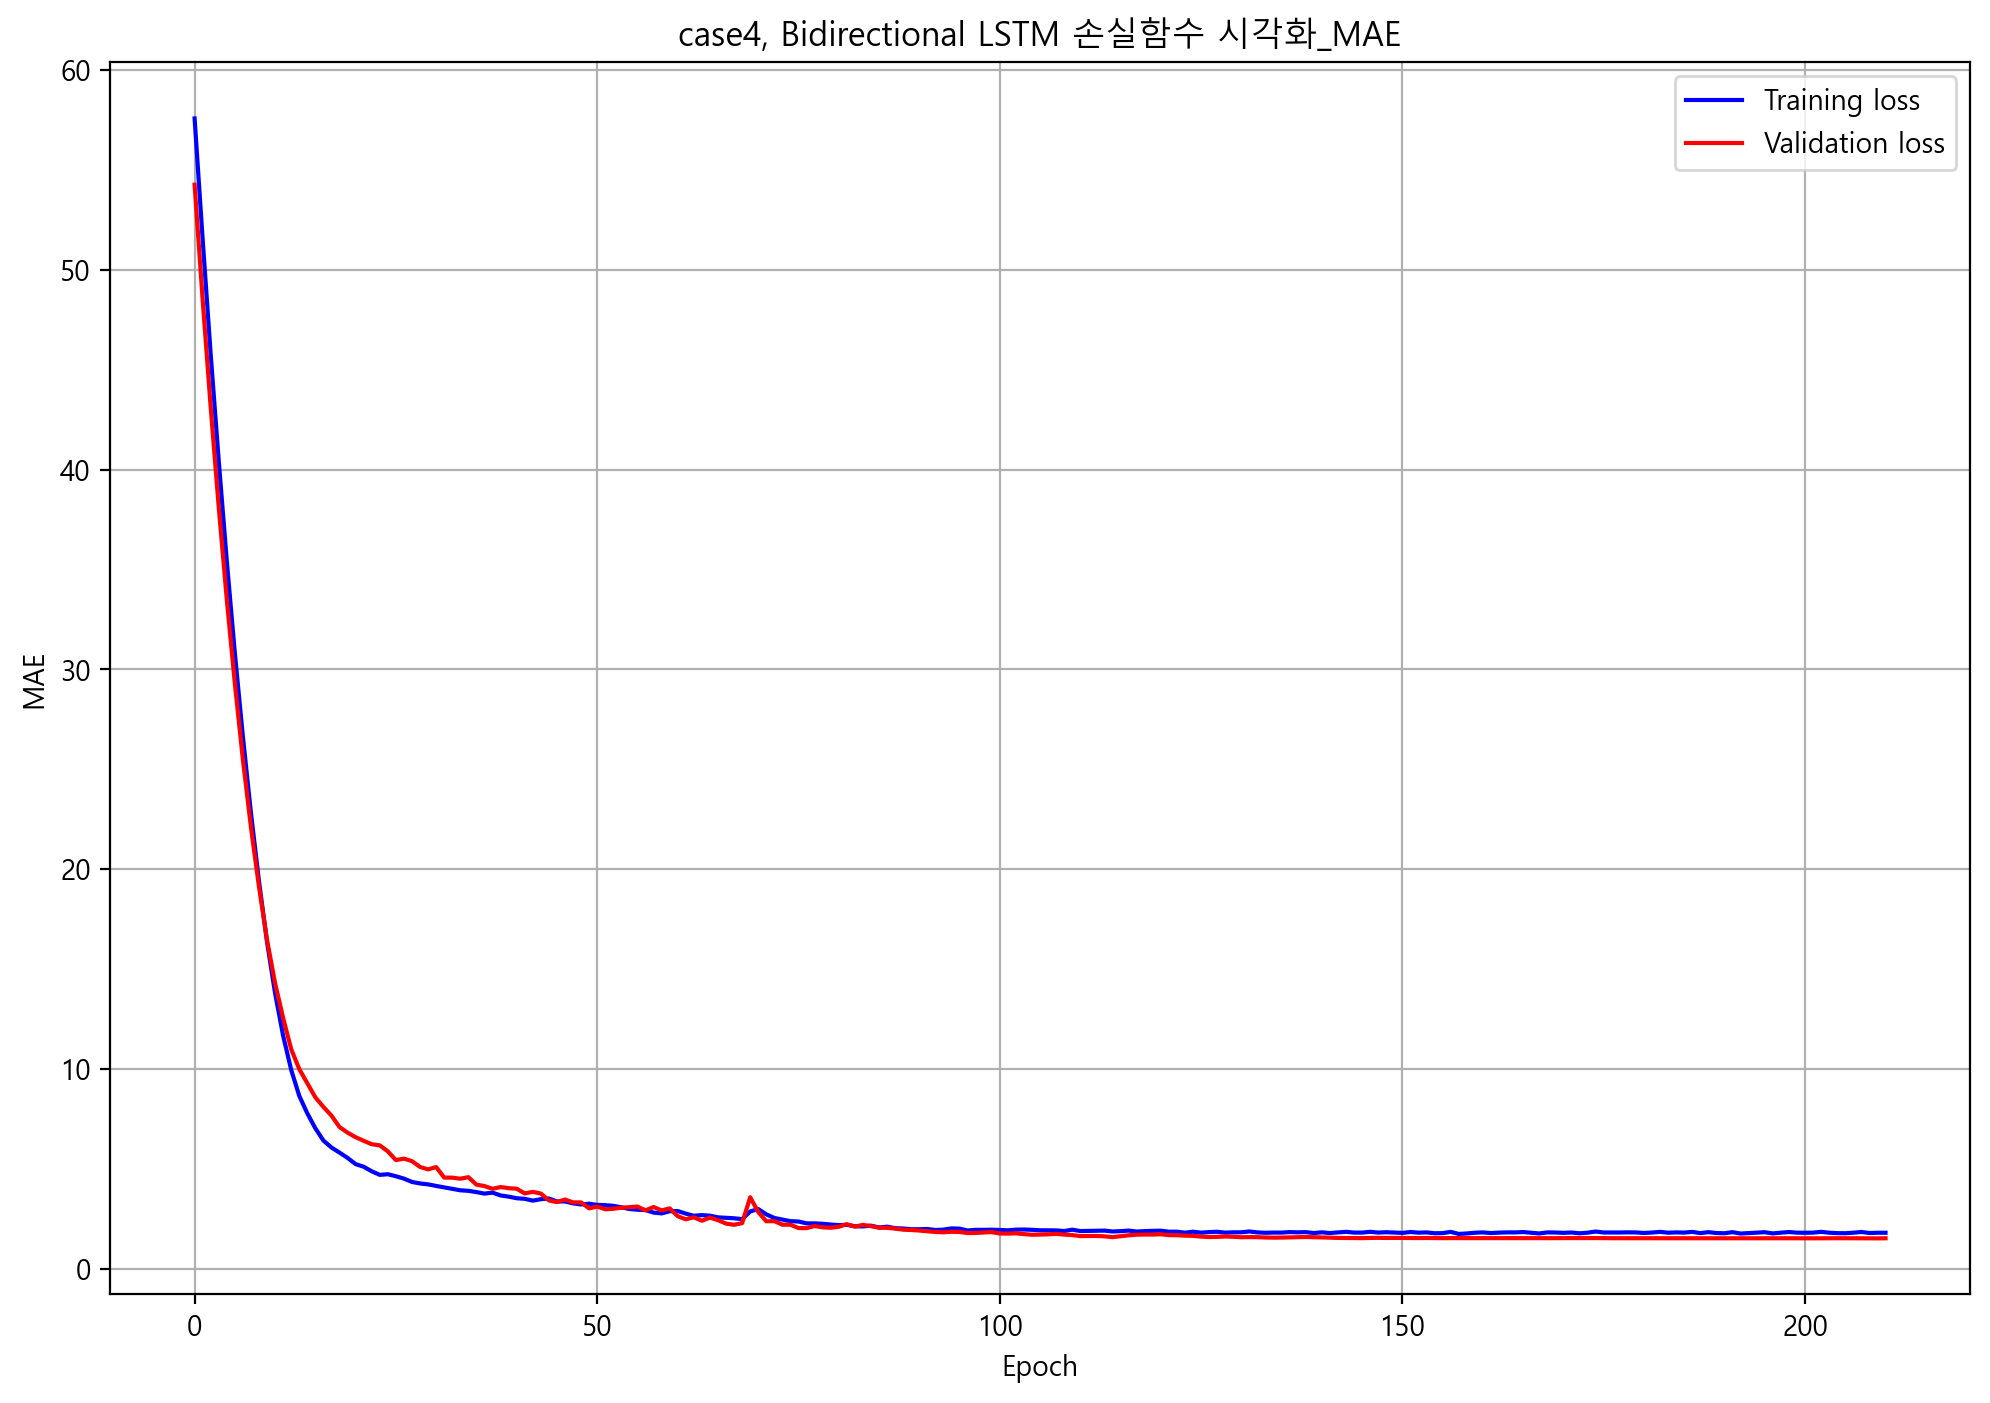

In [94]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization, Input, Embedding, Concatenate, Attention, Bidirectional
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import legacy as legacy_optimizers
from tensorflow.keras import metrics

# Attention 레이어 정의
def attention_layer(inputs):
    attention = Attention()([inputs, inputs])
    return Concatenate()([inputs, attention])

# 옵티마이저 설정
initial_lr = 0.0005
optimizer = legacy_optimizers.Adam(learning_rate=initial_lr)

# 범주형 변수 설정
num_categories = 3
embedding_dim = 5

# 옵티마이저 및 콜백 설정
optimizer = Adam(learning_rate=initial_lr)
lr_restart = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# 모델 정의
numerical_input = Input(shape=(x_train_multi.shape[1], x_train_multi.shape[2]))
categorical_input = Input(shape=(x_train_label.shape[1], ))

# 임베딩 레이어
embedding = Embedding(input_dim=num_categories, output_dim=embedding_dim)(categorical_input)

# 입력 결합
combined_input = Concatenate(axis=-1)([numerical_input, embedding])

x = Bidirectional(LSTM(128, return_sequences=True,
                   kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                   bias_regularizer=l1_l2(l1=0.005, l2=0.005)))(combined_input)
x = BatchNormalization()(x)
x = Dropout(0.3, seed = 40)(x)

x = Bidirectional(LSTM(64, return_sequences=True,
                   kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                   bias_regularizer=l1_l2(l1=0.005, l2=0.005)))(x)
x = BatchNormalization()(x)
x = Dropout(0.3, seed = 41)(x)

x = attention_layer(x)

x = LSTM(32, activation='relu',
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3, seed = 42)(x)

x = Dense(24, activation='relu')(x)
output = Dense(12)(x)

case4_bi_mae = Model(inputs=[numerical_input, categorical_input], outputs=output)
case4_bi_mae.compile(optimizer=optimizer, loss="mae")

# 모델 학습
case4_bi_mae_history = case4_bi_mae.fit(
    # 수치형 데이터와 범주형 데이터 분리    
    [x_train_multi, x_train_label],  
    y_train_multi,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    steps_per_epoch = x_train_multi.shape[0] // BATCH_SIZE, 
    validation_steps = x_val_multi.shape[0] // BATCH_SIZE,
    validation_data=([x_val_multi, x_val_label], y_val_multi),
    callbacks=[lr_restart, early_stop]
)

# 학습 결과 시각화
plot_train_history(case4_bi_mae_history, "case4, Bidirectional LSTM", "MAE")

# 모델 학습
case4_bi_mae.save("./output/case4/case4_bi_mae.h5")

Epoch 1/300
16/16 [==============================] - 6s 88ms/step - loss: 74.9621 - val_loss: 73.2139 - lr: 5.0000e-04
Epoch 2/300
16/16 [==============================] - 0s 18ms/step - loss: 70.9040 - val_loss: 71.1892 - lr: 5.0000e-04
Epoch 3/300
16/16 [==============================] - 0s 17ms/step - loss: 66.6730 - val_loss: 69.0522 - lr: 5.0000e-04
Epoch 4/300
16/16 [==============================] - 0s 18ms/step - loss: 63.0658 - val_loss: 66.8595 - lr: 5.0000e-04
Epoch 5/300
16/16 [==============================] - 0s 18ms/step - loss: 59.1728 - val_loss: 64.4758 - lr: 5.0000e-04
Epoch 6/300
16/16 [==============================] - 0s 17ms/step - loss: 55.4428 - val_loss: 61.9897 - lr: 5.0000e-04
Epoch 7/300
16/16 [==============================] - 0s 17ms/step - loss: 51.9287 - val_loss: 59.3286 - lr: 5.0000e-04
Epoch 8/300
16/16 [==============================] - 0s 17ms/step - loss: 48.5404 - val_loss: 56.5723 - lr: 5.0000e-04
Epoch 9/300
16/16 [=============================

Epoch 70/300
16/16 [==============================] - 0s 17ms/step - loss: 3.6150 - val_loss: 3.6899 - lr: 5.0000e-04
Epoch 71/300
16/16 [==============================] - 0s 17ms/step - loss: 3.4747 - val_loss: 3.4859 - lr: 5.0000e-04
Epoch 72/300
16/16 [==============================] - 0s 17ms/step - loss: 3.6582 - val_loss: 3.3202 - lr: 5.0000e-04
Epoch 73/300
16/16 [==============================] - 0s 17ms/step - loss: 3.5788 - val_loss: 3.2947 - lr: 5.0000e-04
Epoch 74/300
16/16 [==============================] - 0s 17ms/step - loss: 3.4423 - val_loss: 3.6126 - lr: 5.0000e-04
Epoch 75/300
16/16 [==============================] - 0s 17ms/step - loss: 3.2764 - val_loss: 3.4763 - lr: 5.0000e-04
Epoch 76/300
16/16 [==============================] - 0s 17ms/step - loss: 3.2094 - val_loss: 3.4449 - lr: 5.0000e-04
Epoch 77/300
16/16 [==============================] - 0s 17ms/step - loss: 3.1432 - val_loss: 3.0823 - lr: 5.0000e-04
Epoch 78/300
16/16 [==============================] - 0s

13/16 [=======================>......] - ETA: 0s - loss: 1.2106
Epoch 139: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
16/16 [==============================] - 0s 17ms/step - loss: 1.2337 - val_loss: 0.9797 - lr: 5.0000e-04
Epoch 140/300
16/16 [==============================] - 0s 17ms/step - loss: 1.1728 - val_loss: 0.9137 - lr: 2.5000e-04
Epoch 141/300
16/16 [==============================] - 0s 17ms/step - loss: 1.1101 - val_loss: 0.8929 - lr: 2.5000e-04
Epoch 142/300
16/16 [==============================] - 0s 18ms/step - loss: 1.0130 - val_loss: 0.8680 - lr: 2.5000e-04
Epoch 143/300
16/16 [==============================] - 0s 17ms/step - loss: 1.0500 - val_loss: 0.8651 - lr: 2.5000e-04
Epoch 144/300
16/16 [==============================] - 0s 17ms/step - loss: 1.0736 - val_loss: 0.7913 - lr: 2.5000e-04
Epoch 145/300
16/16 [==============================] - 0s 17ms/step - loss: 1.0074 - val_loss: 0.8066 - lr: 2.5000e-04
Epoch 146/300
16/16 [==================

16/16 [==============================] - 0s 17ms/step - loss: 0.6444 - val_loss: 0.3768 - lr: 6.2500e-05
Epoch 205/300
16/16 [==============================] - 0s 18ms/step - loss: 0.6084 - val_loss: 0.3691 - lr: 6.2500e-05
Epoch 206/300
16/16 [==============================] - 0s 18ms/step - loss: 0.5926 - val_loss: 0.3621 - lr: 6.2500e-05
Epoch 207/300
16/16 [==============================] - 0s 17ms/step - loss: 0.6044 - val_loss: 0.3671 - lr: 6.2500e-05
Epoch 208/300
16/16 [==============================] - 0s 17ms/step - loss: 0.6052 - val_loss: 0.3714 - lr: 6.2500e-05
Epoch 209/300
16/16 [==============================] - 0s 17ms/step - loss: 0.6019 - val_loss: 0.3700 - lr: 6.2500e-05
Epoch 210/300
16/16 [==============================] - 0s 17ms/step - loss: 0.6271 - val_loss: 0.3747 - lr: 6.2500e-05
Epoch 211/300
13/16 [=======================>......] - ETA: 0s - loss: 0.5945
Epoch 211: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
16/16 [==================

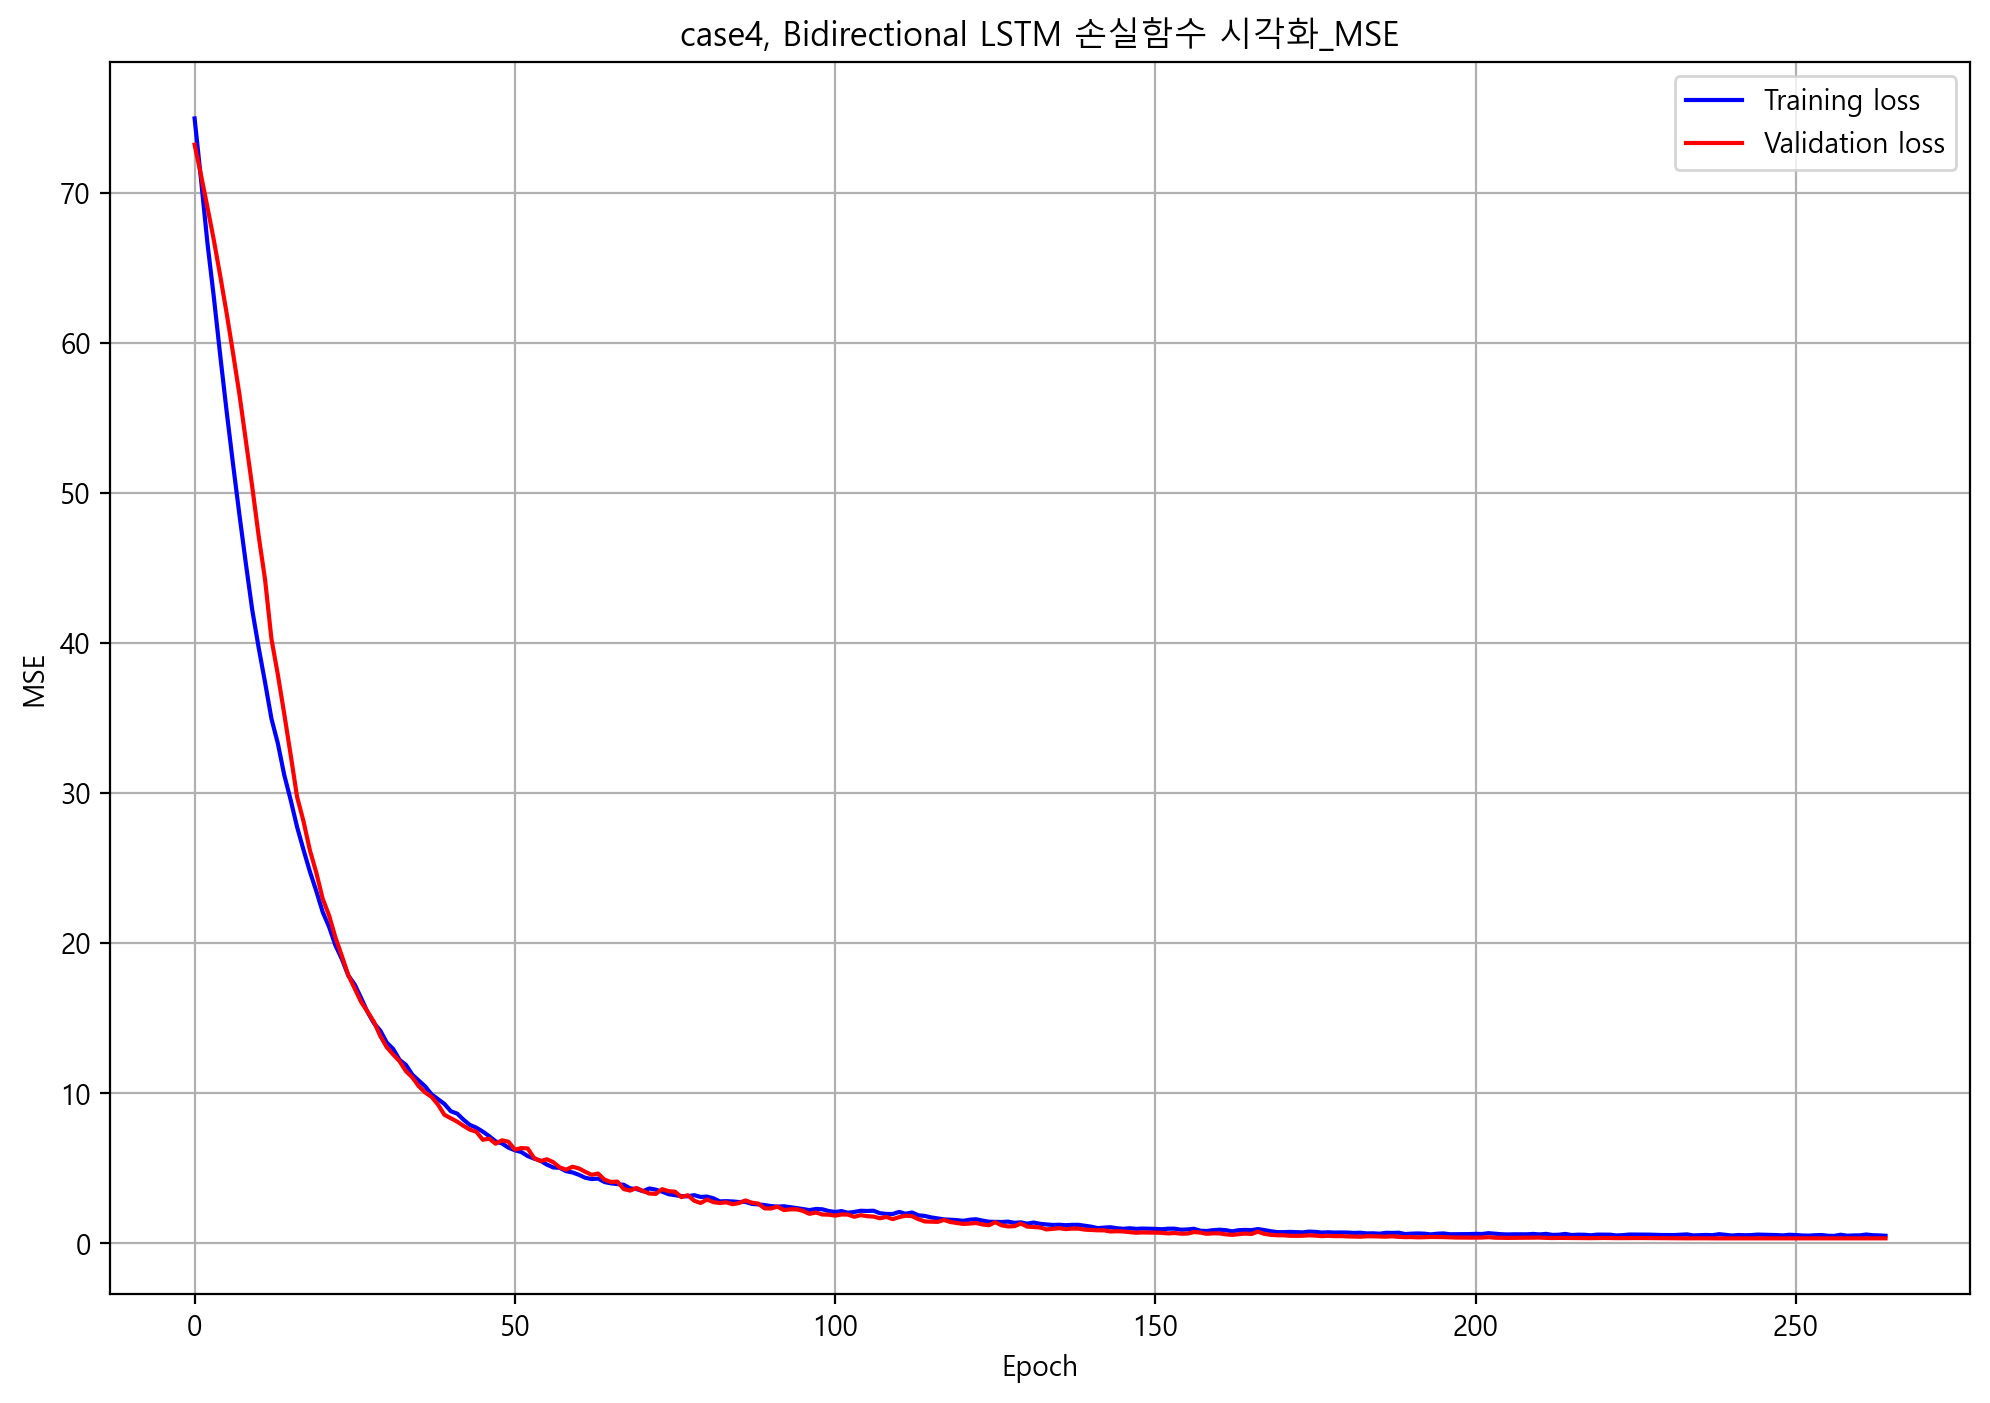

In [95]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization, Input, Embedding, Concatenate, Attention, Bidirectional
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import legacy as legacy_optimizers
from tensorflow.keras import metrics

# Attention 레이어 정의
def attention_layer(inputs):
    attention = Attention()([inputs, inputs])
    return Concatenate()([inputs, attention])

# 옵티마이저 설정
initial_lr = 0.0005
optimizer = legacy_optimizers.Adam(learning_rate=initial_lr)

# 범주형 변수 설정
num_categories = 3
embedding_dim = 5

# 옵티마이저 및 콜백 설정
optimizer = Adam(learning_rate=initial_lr)
lr_restart = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# 모델 정의
numerical_input = Input(shape=(x_train_multi.shape[1], x_train_multi.shape[2]))
categorical_input = Input(shape=(x_train_label.shape[1], ))

# 임베딩 레이어
embedding = Embedding(input_dim=num_categories, output_dim=embedding_dim)(categorical_input)

# 입력 결합
combined_input = Concatenate(axis=-1)([numerical_input, embedding])

x = Bidirectional(LSTM(128, return_sequences=True,
                   kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                   bias_regularizer=l1_l2(l1=0.005, l2=0.005)))(combined_input)
x = BatchNormalization()(x)
x = Dropout(0.3, seed = 40)(x)

x = Bidirectional(LSTM(64, return_sequences=True,
                   kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                   bias_regularizer=l1_l2(l1=0.005, l2=0.005)))(x)
x = BatchNormalization()(x)
x = Dropout(0.3, seed = 41)(x)

x = attention_layer(x)

x = LSTM(32, activation='relu',
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3, seed = 42)(x)

x = Dense(24, activation='relu')(x)
output = Dense(12)(x)

case4_bi_mse = Model(inputs=[numerical_input, categorical_input], outputs=output)
case4_bi_mse.compile(optimizer=optimizer, loss="mse")

# 모델 학습
case4_bi_mse_history = case4_bi_mse.fit(
    # 수치형 데이터와 범주형 데이터 분리    
    [x_train_multi, x_train_label],  
    y_train_multi,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    steps_per_epoch = x_train_multi.shape[0] // BATCH_SIZE, 
    validation_steps = x_val_multi.shape[0] // BATCH_SIZE,
    validation_data=([x_val_multi, x_val_label], y_val_multi),
    callbacks=[lr_restart, early_stop]
)

# 학습 결과 시각화
plot_train_history(case4_bi_mse_history, "case4, Bidirectional LSTM", "MSE")

# 모델 학습
case4_bi_mse.save("./output/case4/case4_bi_mse.h5")

Epoch 1/300
16/16 [==============================] - 6s 89ms/step - loss: 73.9097 - root_mean_squared_error: 4.3374 - val_loss: 72.8121 - val_root_mean_squared_error: 4.3249 - lr: 5.0000e-04
Epoch 2/300
16/16 [==============================] - 0s 18ms/step - loss: 70.0698 - root_mean_squared_error: 4.1094 - val_loss: 69.9998 - val_root_mean_squared_error: 4.2302 - lr: 5.0000e-04
Epoch 3/300
16/16 [==============================] - 0s 17ms/step - loss: 66.5831 - root_mean_squared_error: 3.9305 - val_loss: 66.8426 - val_root_mean_squared_error: 4.1006 - lr: 5.0000e-04
Epoch 4/300
16/16 [==============================] - 0s 17ms/step - loss: 62.8514 - root_mean_squared_error: 3.7154 - val_loss: 63.8022 - val_root_mean_squared_error: 3.9830 - lr: 5.0000e-04
Epoch 5/300
16/16 [==============================] - 0s 17ms/step - loss: 59.0446 - root_mean_squared_error: 3.4772 - val_loss: 60.5474 - val_root_mean_squared_error: 3.8359 - lr: 5.0000e-04
Epoch 6/300
16/16 [==========================

Epoch 44/300
16/16 [==============================] - 0s 17ms/step - loss: 8.3370 - root_mean_squared_error: 0.8861 - val_loss: 8.0287 - val_root_mean_squared_error: 0.7852 - lr: 5.0000e-04
Epoch 45/300
16/16 [==============================] - 0s 17ms/step - loss: 8.2645 - root_mean_squared_error: 0.9692 - val_loss: 7.9087 - val_root_mean_squared_error: 0.8029 - lr: 5.0000e-04
Epoch 46/300
16/16 [==============================] - 0s 17ms/step - loss: 7.9286 - root_mean_squared_error: 0.8854 - val_loss: 7.4496 - val_root_mean_squared_error: 0.6750 - lr: 5.0000e-04
Epoch 47/300
16/16 [==============================] - 0s 17ms/step - loss: 7.6200 - root_mean_squared_error: 0.8721 - val_loss: 7.3633 - val_root_mean_squared_error: 0.8009 - lr: 5.0000e-04
Epoch 48/300
16/16 [==============================] - 0s 17ms/step - loss: 7.2644 - root_mean_squared_error: 0.8012 - val_loss: 6.9361 - val_root_mean_squared_error: 0.6413 - lr: 5.0000e-04
Epoch 49/300
16/16 [==============================

16/16 [==============================] - 0s 17ms/step - loss: 3.1590 - root_mean_squared_error: 0.7624 - val_loss: 2.8729 - val_root_mean_squared_error: 0.5819 - lr: 5.0000e-04
Epoch 88/300
16/16 [==============================] - 0s 18ms/step - loss: 3.1213 - root_mean_squared_error: 0.7898 - val_loss: 2.7745 - val_root_mean_squared_error: 0.5441 - lr: 5.0000e-04
Epoch 89/300
16/16 [==============================] - 0s 17ms/step - loss: 2.9693 - root_mean_squared_error: 0.7256 - val_loss: 2.8856 - val_root_mean_squared_error: 0.6910 - lr: 5.0000e-04
Epoch 90/300
16/16 [==============================] - 0s 17ms/step - loss: 2.8921 - root_mean_squared_error: 0.7097 - val_loss: 2.8039 - val_root_mean_squared_error: 0.6569 - lr: 5.0000e-04
Epoch 91/300
16/16 [==============================] - 0s 17ms/step - loss: 2.9064 - root_mean_squared_error: 0.7458 - val_loss: 2.8671 - val_root_mean_squared_error: 0.7375 - lr: 5.0000e-04
Epoch 92/300
16/16 [==============================] - 0s 18ms/s

16/16 [==============================] - 0s 17ms/step - loss: 1.6157 - root_mean_squared_error: 0.6953 - val_loss: 1.2425 - val_root_mean_squared_error: 0.3523 - lr: 5.0000e-04
Epoch 131/300
16/16 [==============================] - 0s 17ms/step - loss: 1.6241 - root_mean_squared_error: 0.7125 - val_loss: 1.3373 - val_root_mean_squared_error: 0.4284 - lr: 5.0000e-04
Epoch 132/300
16/16 [==============================] - 0s 17ms/step - loss: 1.5462 - root_mean_squared_error: 0.6475 - val_loss: 1.2670 - val_root_mean_squared_error: 0.4156 - lr: 5.0000e-04
Epoch 133/300
16/16 [==============================] - 0s 17ms/step - loss: 1.4483 - root_mean_squared_error: 0.6170 - val_loss: 1.3113 - val_root_mean_squared_error: 0.5111 - lr: 5.0000e-04
Epoch 134/300
16/16 [==============================] - 0s 17ms/step - loss: 1.3564 - root_mean_squared_error: 0.5757 - val_loss: 1.1597 - val_root_mean_squared_error: 0.4030 - lr: 5.0000e-04
Epoch 135/300
16/16 [==============================] - 0s 1

16/16 [==============================] - 0s 17ms/step - loss: 0.8272 - root_mean_squared_error: 0.5883 - val_loss: 0.5439 - val_root_mean_squared_error: 0.2902 - lr: 1.2500e-04
Epoch 172/300
16/16 [==============================] - 0s 17ms/step - loss: 0.7704 - root_mean_squared_error: 0.5680 - val_loss: 0.5338 - val_root_mean_squared_error: 0.3082 - lr: 1.2500e-04
Epoch 173/300
16/16 [==============================] - 0s 17ms/step - loss: 0.7424 - root_mean_squared_error: 0.5548 - val_loss: 0.5489 - val_root_mean_squared_error: 0.3482 - lr: 1.2500e-04
Epoch 174/300
16/16 [==============================] - 0s 17ms/step - loss: 0.7334 - root_mean_squared_error: 0.5527 - val_loss: 0.5678 - val_root_mean_squared_error: 0.3688 - lr: 1.2500e-04
Epoch 175/300
16/16 [==============================] - 0s 17ms/step - loss: 0.7609 - root_mean_squared_error: 0.5799 - val_loss: 0.5361 - val_root_mean_squared_error: 0.3465 - lr: 1.2500e-04
Epoch 176/300
16/16 [==============================] - 0s 1

16/16 [==============================] - 0s 17ms/step - loss: 0.5970 - root_mean_squared_error: 0.5363 - val_loss: 0.3767 - val_root_mean_squared_error: 0.2661 - lr: 6.2500e-05
Epoch 214/300
16/16 [==============================] - 0s 17ms/step - loss: 0.5819 - root_mean_squared_error: 0.5251 - val_loss: 0.3812 - val_root_mean_squared_error: 0.2739 - lr: 6.2500e-05
Epoch 215/300
16/16 [==============================] - 0s 17ms/step - loss: 0.5769 - root_mean_squared_error: 0.5228 - val_loss: 0.3865 - val_root_mean_squared_error: 0.2942 - lr: 6.2500e-05
Epoch 216/300
16/16 [==============================] - 0s 17ms/step - loss: 0.5657 - root_mean_squared_error: 0.5161 - val_loss: 0.3724 - val_root_mean_squared_error: 0.2718 - lr: 6.2500e-05
Epoch 217/300
16/16 [==============================] - 0s 17ms/step - loss: 0.6480 - root_mean_squared_error: 0.5907 - val_loss: 0.3845 - val_root_mean_squared_error: 0.2920 - lr: 6.2500e-05
Epoch 218/300
16/16 [==============================] - 0s 1

16/16 [==============================] - 0s 18ms/step - loss: 0.5151 - root_mean_squared_error: 0.5088 - val_loss: 0.3258 - val_root_mean_squared_error: 0.2640 - lr: 1.5625e-05
Epoch 255/300
16/16 [==============================] - 0s 17ms/step - loss: 0.5442 - root_mean_squared_error: 0.5368 - val_loss: 0.3270 - val_root_mean_squared_error: 0.2655 - lr: 1.5625e-05
Epoch 256/300
16/16 [==============================] - 0s 16ms/step - loss: 0.5356 - root_mean_squared_error: 0.5279 - val_loss: 0.3265 - val_root_mean_squared_error: 0.2640 - lr: 1.5625e-05
Epoch 257/300
16/16 [==============================] - 0s 17ms/step - loss: 0.5000 - root_mean_squared_error: 0.4936 - val_loss: 0.3312 - val_root_mean_squared_error: 0.2740 - lr: 1.5625e-05
Epoch 258/300
13/16 [=======================>......] - ETA: 0s - loss: 0.5589 - root_mean_squared_error: 0.5490
Epoch 258: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.
16/16 [==============================] - 0s 17ms/step - loss

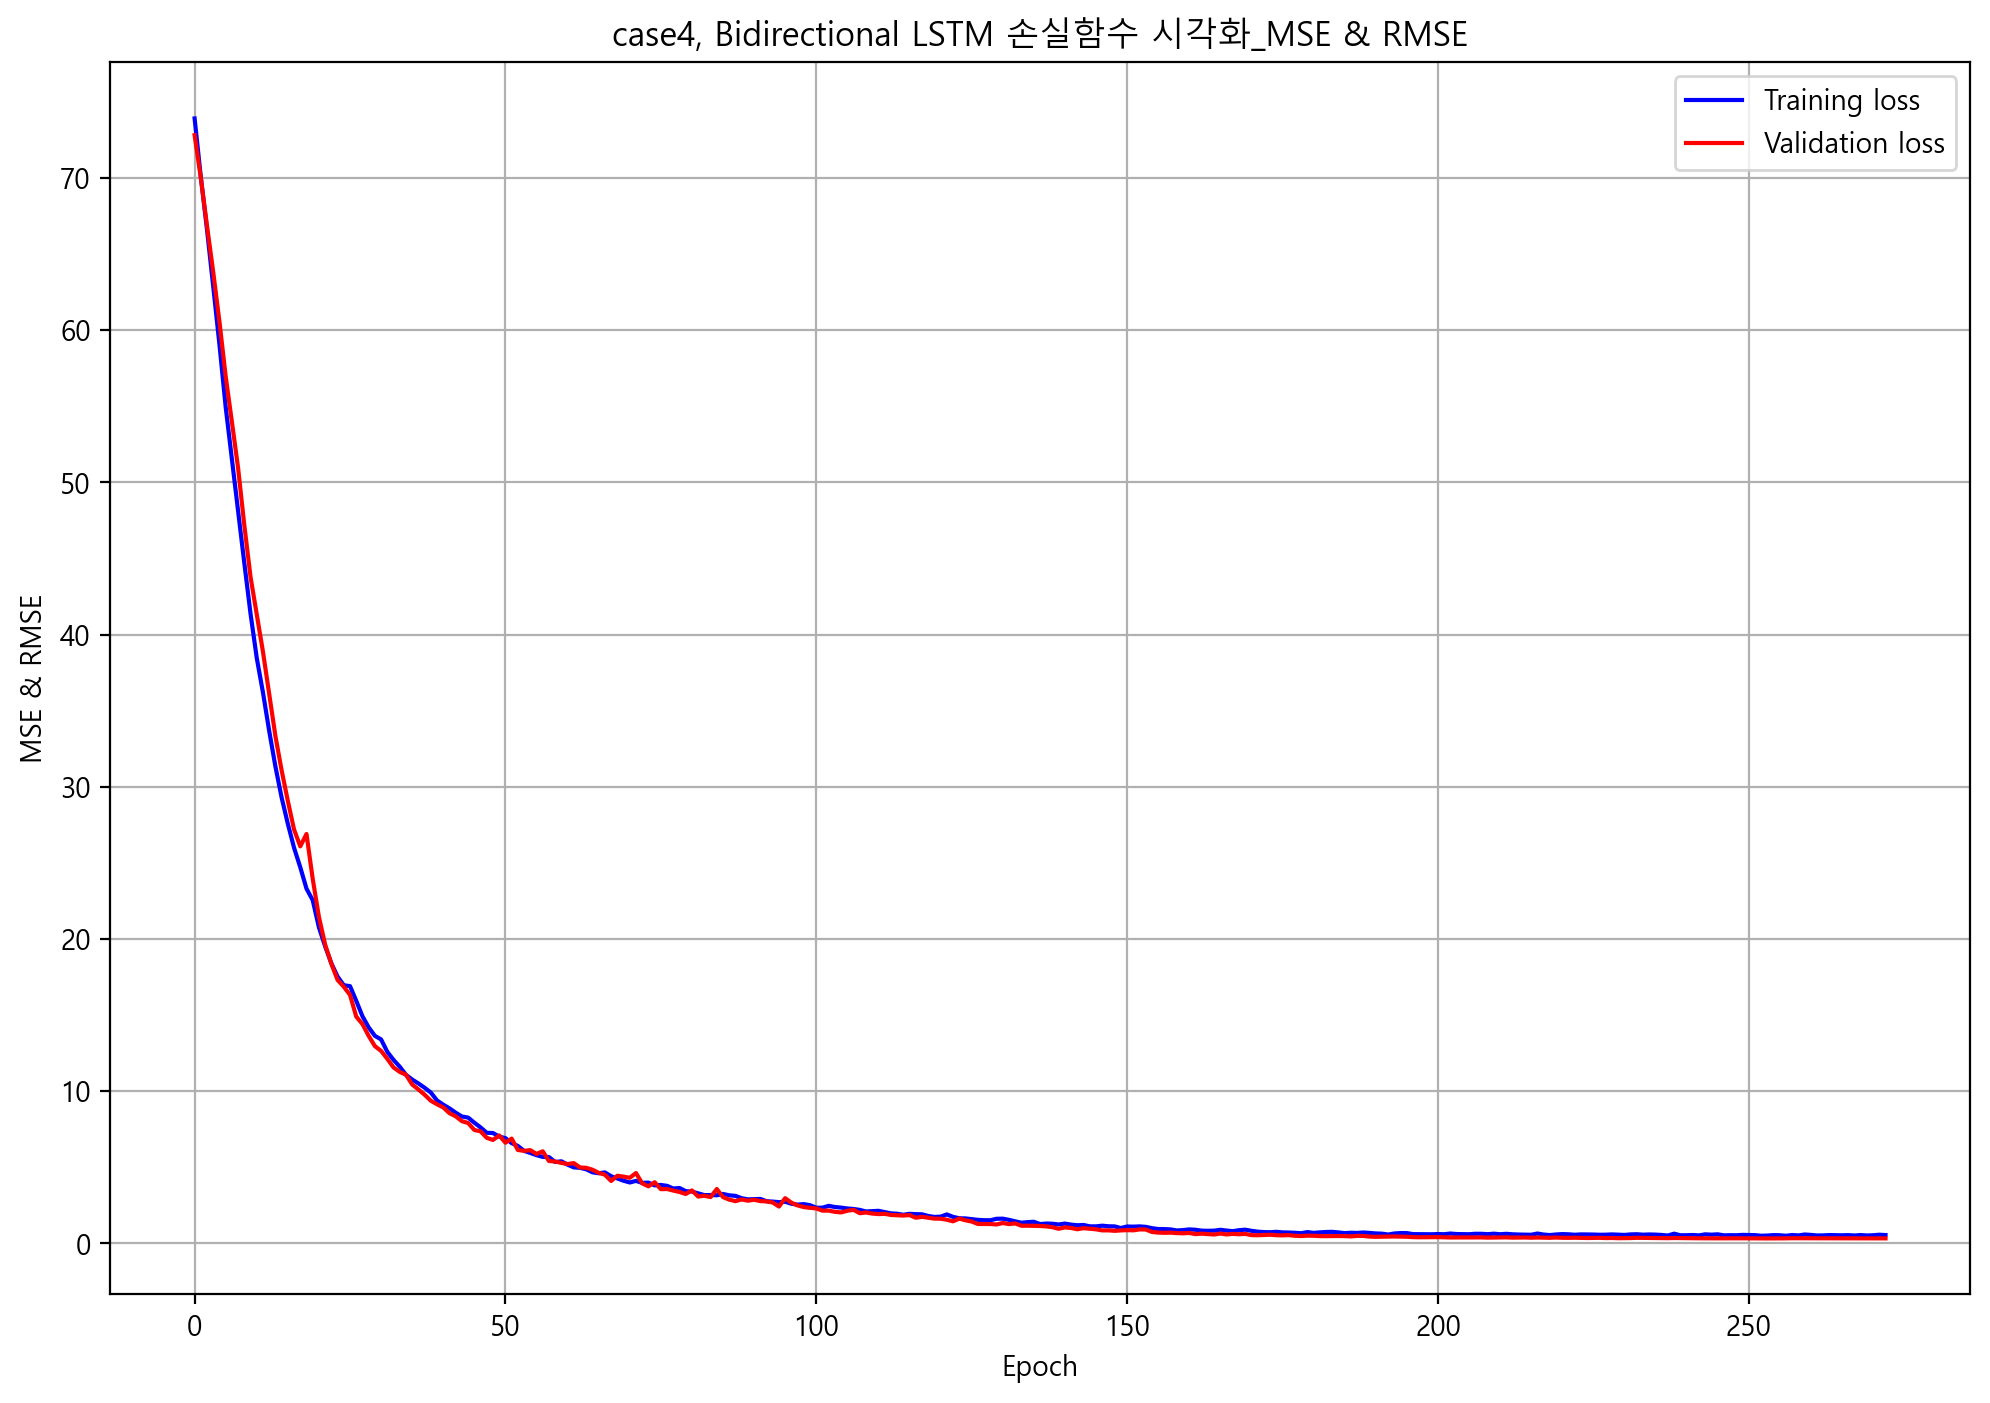

In [96]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization, Input, Embedding, Concatenate, Attention, Bidirectional
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import legacy as legacy_optimizers
from tensorflow.keras import metrics

# Attention 레이어 정의
def attention_layer(inputs):
    attention = Attention()([inputs, inputs])
    return Concatenate()([inputs, attention])

# 옵티마이저 설정
initial_lr = 0.0005
optimizer = legacy_optimizers.Adam(learning_rate=initial_lr)

# 범주형 변수 설정
num_categories = 3
embedding_dim = 5

# 옵티마이저 및 콜백 설정
optimizer = Adam(learning_rate=initial_lr)
lr_restart = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# 모델 정의
numerical_input = Input(shape=(x_train_multi.shape[1], x_train_multi.shape[2]))
categorical_input = Input(shape=(x_train_label.shape[1], ))

# 임베딩 레이어
embedding = Embedding(input_dim=num_categories, output_dim=embedding_dim)(categorical_input)

# 입력 결합
combined_input = Concatenate(axis=-1)([numerical_input, embedding])

x = Bidirectional(LSTM(128, return_sequences=True,
                   kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                   bias_regularizer=l1_l2(l1=0.005, l2=0.005)))(combined_input)
x = BatchNormalization()(x)
x = Dropout(0.3, seed = 40)(x)

x = Bidirectional(LSTM(64, return_sequences=True,
                   kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                   bias_regularizer=l1_l2(l1=0.005, l2=0.005)))(x)
x = BatchNormalization()(x)
x = Dropout(0.3, seed = 41)(x)

x = attention_layer(x)

x = LSTM(32, activation='relu',
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3, seed = 42)(x)

x = Dense(24, activation='relu')(x)
output = Dense(12)(x)

case4_bi_rmse = Model(inputs=[numerical_input, categorical_input], outputs=output)
case4_bi_rmse.compile(optimizer=optimizer
                       , loss="mse"
                       , metrics=[metrics.RootMeanSquaredError()]
                      )

# 모델 학습
case4_bi_rmse_history = case4_bi_rmse.fit(
    # 수치형 데이터와 범주형 데이터 분리    
    [x_train_multi, x_train_label],  
    y_train_multi,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    steps_per_epoch = x_train_multi.shape[0] // BATCH_SIZE, 
    validation_steps = x_val_multi.shape[0] // BATCH_SIZE,
    validation_data=([x_val_multi, x_val_label], y_val_multi),
    callbacks=[lr_restart, early_stop]
)

# 학습 결과 시각화
plot_train_history(case4_bi_rmse_history, "case4, Bidirectional LSTM", "MSE & RMSE")

# 모델 학습
case4_bi_rmse.save("./output/case4/case4_bi_rmse.h5")

# Case5) 3개 다 & 표준화

## 데이터 전처리

In [97]:
os.mkdir("./output/case5")

case5_df = data[['WTIO', 'SETIO', 'DMI', 'ONI', 'SOI', 'ENSO', 'D20_SCTR']]

case5_dts = case5_df.values

case5_label = case5_dts[ : , 5]
case5_dts = case5_dts[ : , [0, 1, 2, 3, 4, 6]]

case5_mean = case5_dts.mean(axis=0)
case5_std = case5_dts.std(axis=0)
case5_dts = (case5_dts-case5_mean)/case5_std

## 데이터 분리

In [98]:
# 학습 데이터
x_train_multi, y_train_multi = multivariate_data(case5_dts, case5_dts[:, -1], 0, TRAIN_SPLIT - future_target, past_history, future_target, STEP)

x_train_label = label_split(case5_label, 0, TRAIN_SPLIT - future_target, past_history, future_target, STEP)

# 검증 데이터
x_val_multi, y_val_multi = multivariate_data(case5_dts, case5_dts[:, -1], TRAIN_SPLIT, TRAIN_SPLIT + VAL_SPLIT - future_target, past_history, future_target, STEP)

x_val_label = label_split(case5_label, TRAIN_SPLIT, TRAIN_SPLIT + VAL_SPLIT - future_target, past_history, future_target, STEP)

# 테스트 데이터
x_test_case5, y_test_case5 = multivariate_data(case5_dts, case5_dts[:, -1], TRAIN_SPLIT + VAL_SPLIT, None, past_history, future_target, STEP)

x_test_case5_label = label_split(case5_label, TRAIN_SPLIT + VAL_SPLIT, None, past_history, future_target, STEP)

## 모델 학습

### 단방향 LSTM

Epoch 1/300
16/16 [==============================] - 4s 59ms/step - loss: 22.2897 - val_loss: 21.1752 - lr: 5.0000e-04
Epoch 2/300
16/16 [==============================] - 0s 12ms/step - loss: 20.6687 - val_loss: 19.6627 - lr: 5.0000e-04
Epoch 3/300
16/16 [==============================] - 0s 13ms/step - loss: 19.1596 - val_loss: 18.2211 - lr: 5.0000e-04
Epoch 4/300
16/16 [==============================] - 0s 12ms/step - loss: 17.7044 - val_loss: 16.8409 - lr: 5.0000e-04
Epoch 5/300
16/16 [==============================] - 0s 12ms/step - loss: 16.3401 - val_loss: 15.5287 - lr: 5.0000e-04
Epoch 6/300
16/16 [==============================] - 0s 12ms/step - loss: 15.0256 - val_loss: 14.2893 - lr: 5.0000e-04
Epoch 7/300
16/16 [==============================] - 0s 12ms/step - loss: 13.7564 - val_loss: 13.1163 - lr: 5.0000e-04
Epoch 8/300
16/16 [==============================] - 0s 11ms/step - loss: 12.6255 - val_loss: 12.0162 - lr: 5.0000e-04
Epoch 9/300
16/16 [=============================

16/16 [==============================] - 0s 11ms/step - loss: 1.5320 - val_loss: 1.6042 - lr: 5.0000e-04
Epoch 71/300
16/16 [==============================] - 0s 11ms/step - loss: 1.5074 - val_loss: 1.5871 - lr: 5.0000e-04
Epoch 72/300
16/16 [==============================] - 0s 11ms/step - loss: 1.5083 - val_loss: 1.5572 - lr: 5.0000e-04
Epoch 73/300
16/16 [==============================] - 0s 11ms/step - loss: 1.4947 - val_loss: 1.5649 - lr: 5.0000e-04
Epoch 74/300
16/16 [==============================] - 0s 12ms/step - loss: 1.4601 - val_loss: 1.5181 - lr: 5.0000e-04
Epoch 75/300
16/16 [==============================] - 0s 12ms/step - loss: 1.4477 - val_loss: 1.4826 - lr: 5.0000e-04
Epoch 76/300
16/16 [==============================] - 0s 12ms/step - loss: 1.4349 - val_loss: 1.4793 - lr: 5.0000e-04
Epoch 77/300
16/16 [==============================] - 0s 11ms/step - loss: 1.4274 - val_loss: 1.4884 - lr: 5.0000e-04
Epoch 78/300
16/16 [==============================] - 0s 11ms/step - 

16/16 [==============================] - 0s 11ms/step - loss: 0.7513 - val_loss: 0.8934 - lr: 5.0000e-04
Epoch 140/300
16/16 [==============================] - 0s 11ms/step - loss: 0.7441 - val_loss: 0.8513 - lr: 5.0000e-04
Epoch 141/300
16/16 [==============================] - 0s 11ms/step - loss: 0.7358 - val_loss: 0.9148 - lr: 5.0000e-04
Epoch 142/300
16/16 [==============================] - 0s 11ms/step - loss: 0.7214 - val_loss: 0.8441 - lr: 5.0000e-04
Epoch 143/300
16/16 [==============================] - 0s 11ms/step - loss: 0.7135 - val_loss: 0.8948 - lr: 5.0000e-04
Epoch 144/300
16/16 [==============================] - 0s 12ms/step - loss: 0.7128 - val_loss: 0.9023 - lr: 5.0000e-04
Epoch 145/300
16/16 [==============================] - 0s 11ms/step - loss: 0.7095 - val_loss: 0.8334 - lr: 5.0000e-04
Epoch 146/300
16/16 [==============================] - 0s 11ms/step - loss: 0.6942 - val_loss: 0.8173 - lr: 5.0000e-04
Epoch 147/300
16/16 [==============================] - 0s 12ms

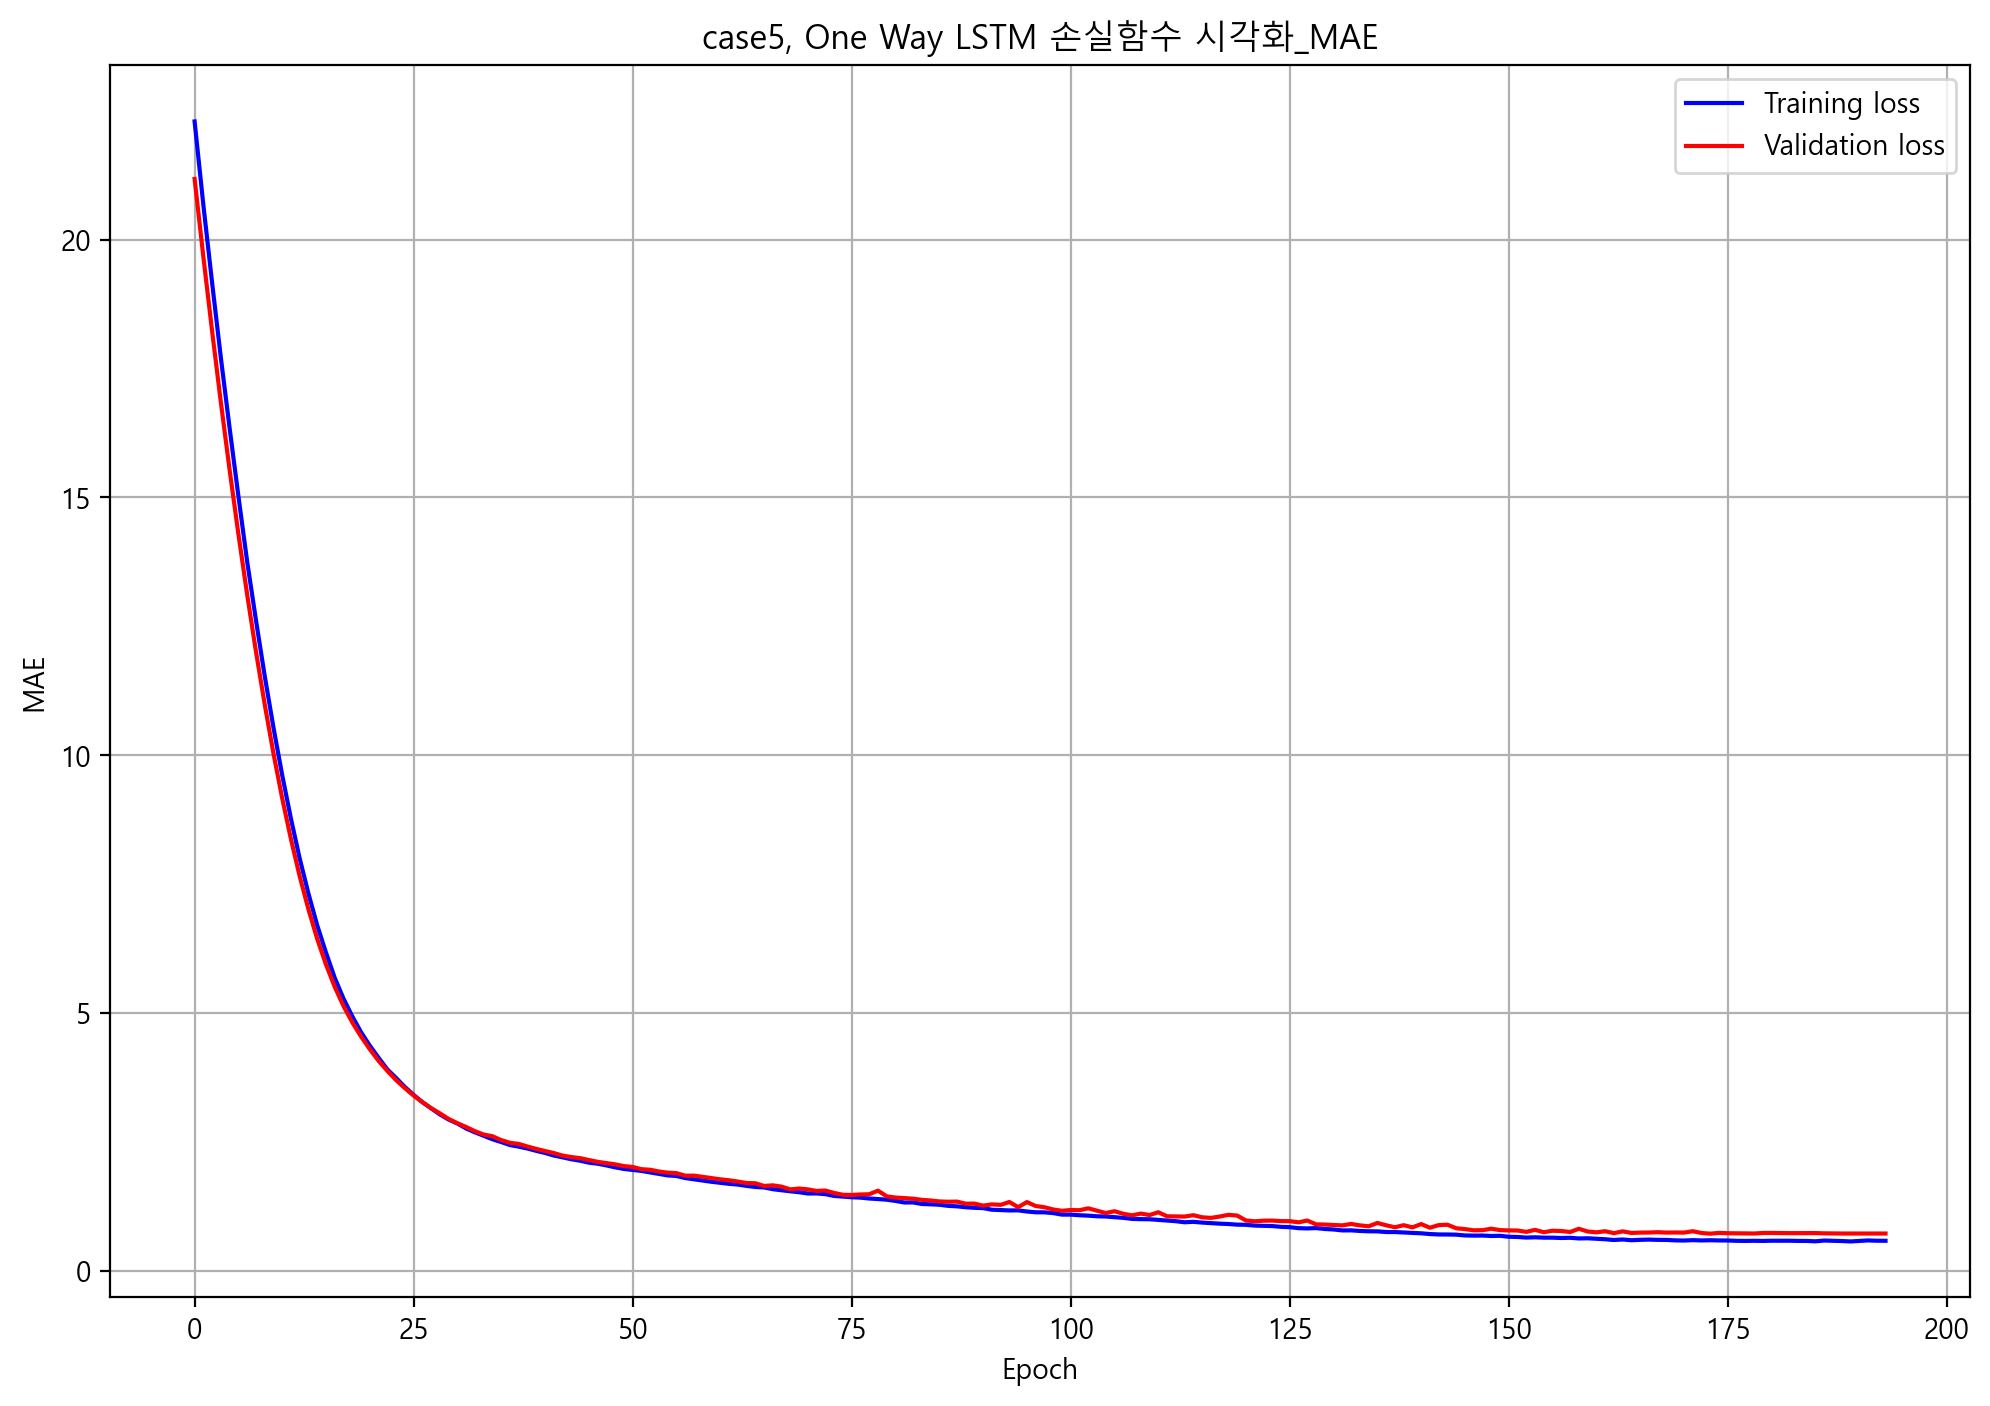

In [99]:
from tensorflow.keras.optimizers import legacy as legacy_optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization, Input, Embedding, Concatenate, Attention
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras import metrics

# Attention 레이어 정의
def attention_layer(inputs):
    attention = Attention()([inputs, inputs])
    return Concatenate()([inputs, attention])

# 범주형 변수 설정
num_categories = 3
embedding_dim = 5

# 옵티마이저 및 콜백 설정
initial_lr = 0.0005

optimizer = legacy_optimizers.Adam(learning_rate=initial_lr)
lr_restart = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# 모델 정의
numerical_input = Input(shape=(x_train_multi.shape[1], x_train_multi.shape[2]))
categorical_input = Input(shape=(x_train_label.shape[1], ))

# 임베딩 레이어
embedding = Embedding(input_dim=num_categories, output_dim=embedding_dim)(categorical_input)

# 입력 결합
combined_input = Concatenate(axis=-1)([numerical_input, embedding])

x = LSTM(128, return_sequences=True,
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(combined_input)
x = BatchNormalization()(x)
x = Dropout(0.3, seed = 40)(x)

x = LSTM(64, return_sequences=True,
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3, seed = 41)(x)

x = attention_layer(x)

x = LSTM(32, activation='relu',
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3, seed = 42)(x)

x = Dense(24, activation='relu')(x)
output = Dense(12)(x)

case5_uni_mae = Model(inputs=[numerical_input, categorical_input], outputs=output)
case5_uni_mae.compile(optimizer=optimizer, loss="mae")

# 모델 학습
case5_uni_mae_history = case5_uni_mae.fit( 
    [x_train_multi, x_train_label],  
    y_train_multi,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    steps_per_epoch = x_train_multi.shape[0] // BATCH_SIZE, 
    validation_steps = x_val_multi.shape[0] // BATCH_SIZE,
    validation_data=([x_val_multi, x_val_label], y_val_multi),
    callbacks=[lr_restart, early_stop]
)

# 학습 결과 시각화
plot_train_history(case5_uni_mae_history, "case5, One Way LSTM", "MAE")

# 모델 학습
case5_uni_mae.save("./output/case5/case5_uni_mae.h5")

Epoch 1/300
16/16 [==============================] - 4s 56ms/step - loss: 23.2213 - val_loss: 22.1236 - lr: 5.0000e-04
Epoch 2/300
16/16 [==============================] - 0s 11ms/step - loss: 22.2828 - val_loss: 21.3532 - lr: 5.0000e-04
Epoch 3/300
16/16 [==============================] - 0s 12ms/step - loss: 21.2709 - val_loss: 20.5555 - lr: 5.0000e-04
Epoch 4/300
16/16 [==============================] - 0s 12ms/step - loss: 20.3250 - val_loss: 19.7341 - lr: 5.0000e-04
Epoch 5/300
16/16 [==============================] - 0s 13ms/step - loss: 19.4214 - val_loss: 18.9036 - lr: 5.0000e-04
Epoch 6/300
16/16 [==============================] - 0s 12ms/step - loss: 18.5492 - val_loss: 18.0743 - lr: 5.0000e-04
Epoch 7/300
16/16 [==============================] - 0s 12ms/step - loss: 17.6132 - val_loss: 17.2478 - lr: 5.0000e-04
Epoch 8/300
16/16 [==============================] - 0s 12ms/step - loss: 16.7597 - val_loss: 16.4283 - lr: 5.0000e-04
Epoch 9/300
16/16 [=============================

16/16 [==============================] - 0s 11ms/step - loss: 1.7629 - val_loss: 2.2011 - lr: 5.0000e-04
Epoch 71/300
16/16 [==============================] - 0s 11ms/step - loss: 1.7352 - val_loss: 2.1401 - lr: 5.0000e-04
Epoch 72/300
16/16 [==============================] - 0s 11ms/step - loss: 1.7029 - val_loss: 2.1865 - lr: 5.0000e-04
Epoch 73/300
16/16 [==============================] - 0s 11ms/step - loss: 1.7064 - val_loss: 2.1020 - lr: 5.0000e-04
Epoch 74/300
16/16 [==============================] - 0s 11ms/step - loss: 1.6596 - val_loss: 2.0466 - lr: 5.0000e-04
Epoch 75/300
16/16 [==============================] - 0s 11ms/step - loss: 1.6501 - val_loss: 2.0596 - lr: 5.0000e-04
Epoch 76/300
16/16 [==============================] - 0s 11ms/step - loss: 1.6079 - val_loss: 2.0230 - lr: 5.0000e-04
Epoch 77/300
16/16 [==============================] - 0s 11ms/step - loss: 1.5921 - val_loss: 2.1126 - lr: 5.0000e-04
Epoch 78/300
16/16 [==============================] - 0s 12ms/step - 

Epoch 136/300
16/16 [==============================] - 0s 11ms/step - loss: 0.8773 - val_loss: 1.3630 - lr: 6.2500e-05
Epoch 137/300
16/16 [==============================] - 0s 11ms/step - loss: 0.8670 - val_loss: 1.3646 - lr: 6.2500e-05
Epoch 138/300
16/16 [==============================] - 0s 11ms/step - loss: 0.8587 - val_loss: 1.3381 - lr: 6.2500e-05
Epoch 139/300
16/16 [==============================] - 0s 11ms/step - loss: 0.8621 - val_loss: 1.3761 - lr: 6.2500e-05
Epoch 140/300
16/16 [==============================] - 0s 11ms/step - loss: 0.8612 - val_loss: 1.3629 - lr: 6.2500e-05
Epoch 141/300
16/16 [==============================] - 0s 11ms/step - loss: 0.8681 - val_loss: 1.3188 - lr: 6.2500e-05
Epoch 142/300
16/16 [==============================] - 0s 11ms/step - loss: 0.8598 - val_loss: 1.3669 - lr: 6.2500e-05
Epoch 143/300
16/16 [==============================] - 0s 11ms/step - loss: 0.8655 - val_loss: 1.3362 - lr: 6.2500e-05
Epoch 144/300
16/16 [===========================

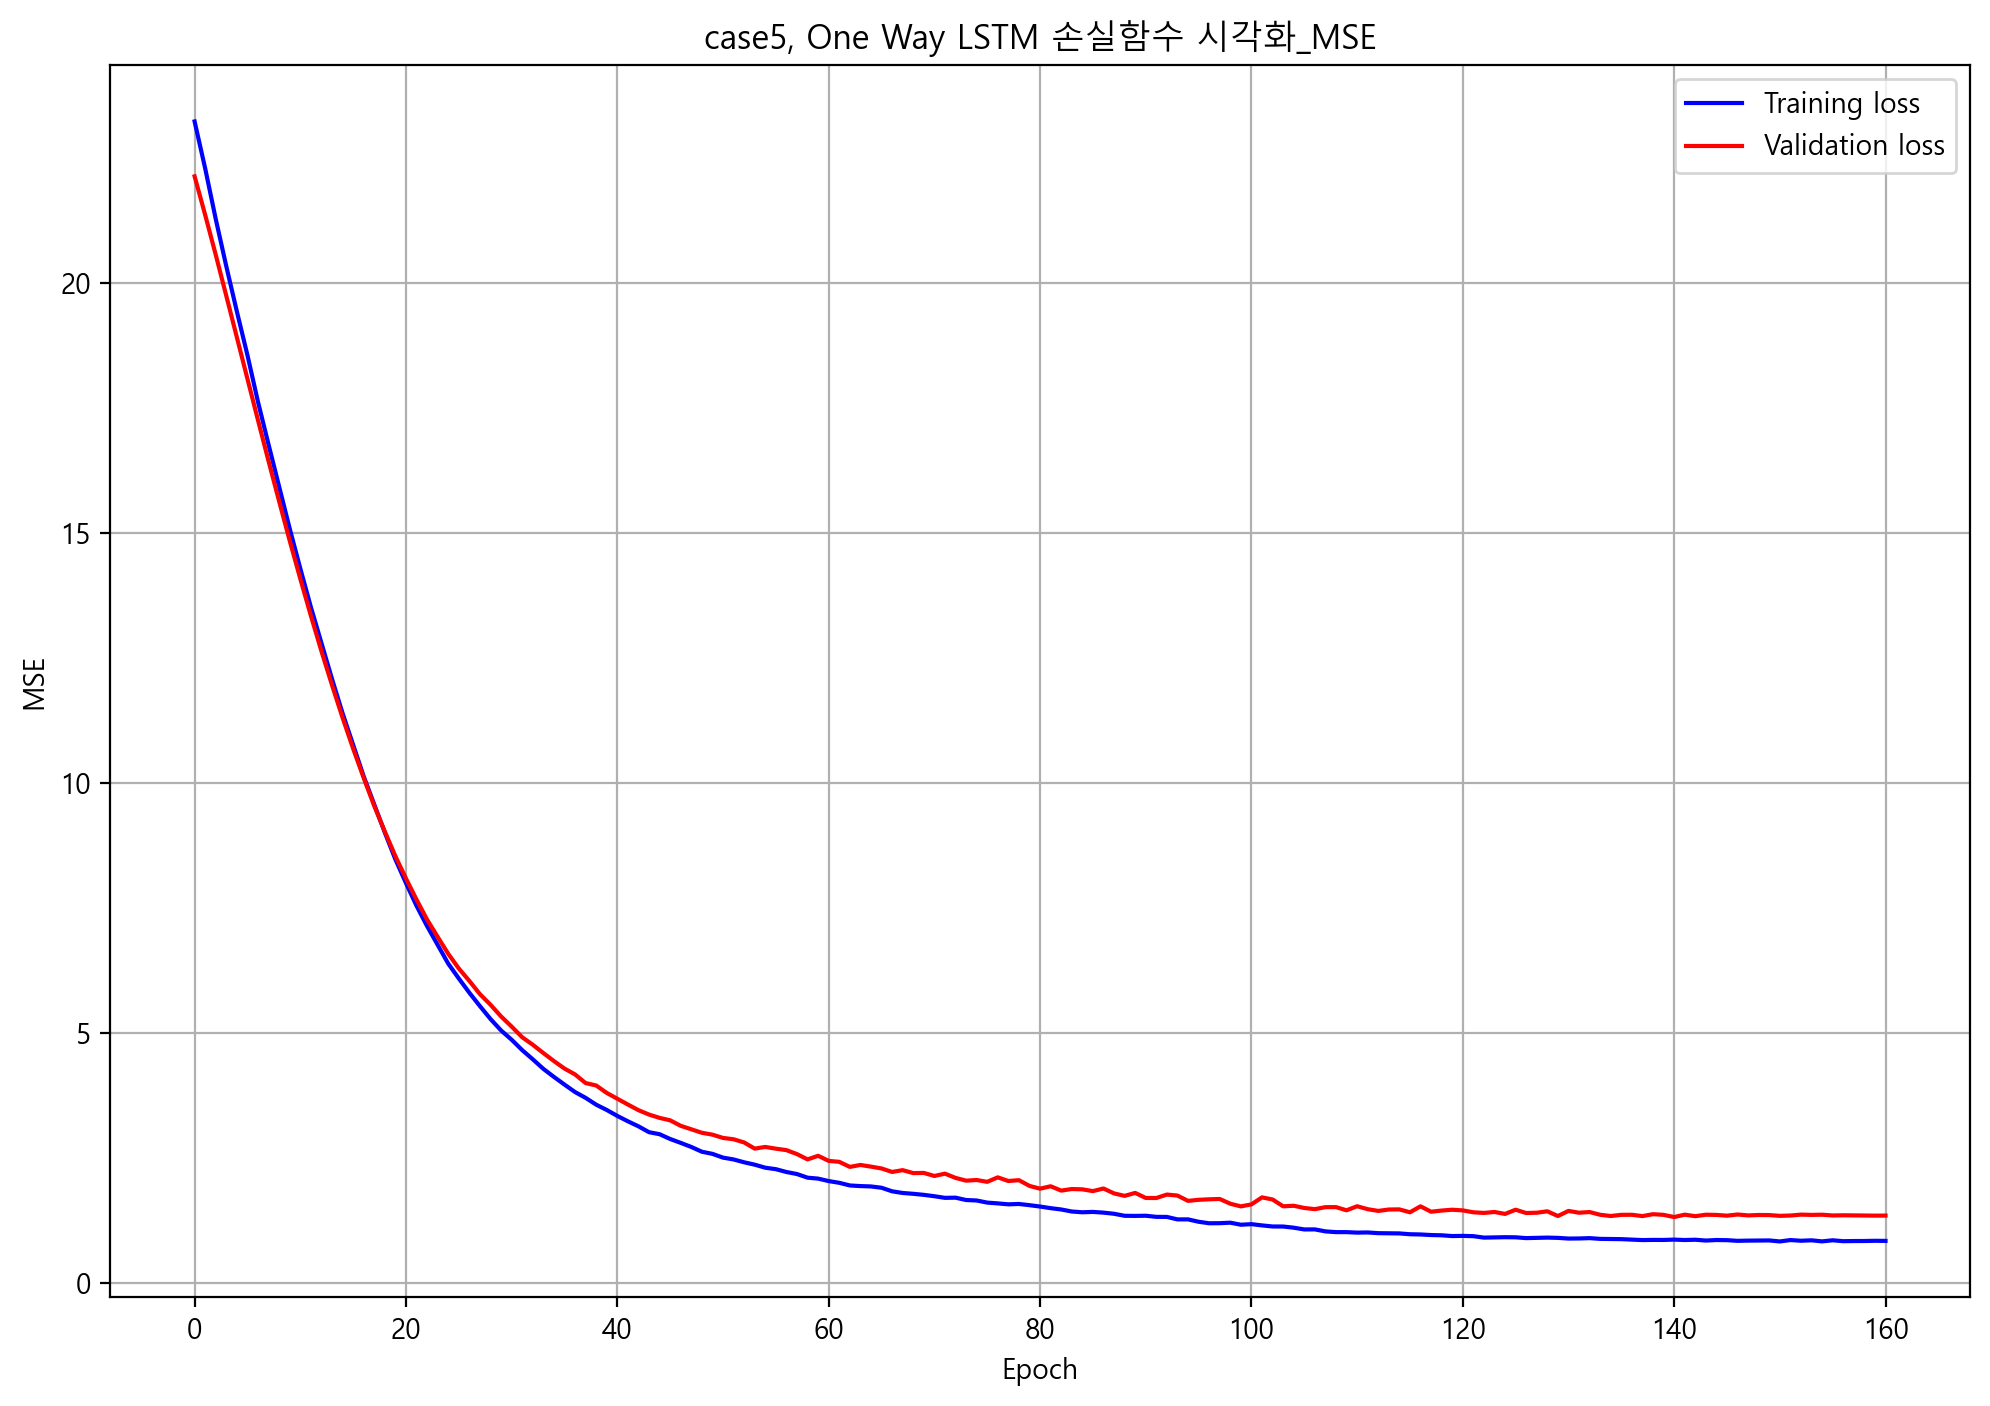

In [100]:
from tensorflow.keras.optimizers import legacy as legacy_optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization, Input, Embedding, Concatenate, Attention
from tensorflow.keras.regularizers import l1_l2

# Attention 레이어 정의
def attention_layer(inputs):
    attention = Attention()([inputs, inputs])
    return Concatenate()([inputs, attention])

# 범주형 변수 설정
num_categories = 3
embedding_dim = 5

# 옵티마이저 및 콜백 설정
initial_lr = 0.0005

optimizer = legacy_optimizers.Adam(learning_rate=initial_lr)
lr_restart = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# 모델 정의
numerical_input = Input(shape=(x_train_multi.shape[1], x_train_multi.shape[2]))
categorical_input = Input(shape=(x_train_label.shape[1], ))

# 임베딩 레이어
embedding = Embedding(input_dim=num_categories, output_dim=embedding_dim)(categorical_input)

# 입력 결합
combined_input = Concatenate(axis=-1)([numerical_input, embedding])

x = LSTM(128, return_sequences=True,
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(combined_input)
x = BatchNormalization()(x)
x = Dropout(0.3, seed = 40)(x)

x = LSTM(64, return_sequences=True,
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3, seed = 41)(x)

x = attention_layer(x)

x = LSTM(32, activation='relu',
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3, seed = 42)(x)

x = Dense(24, activation='relu')(x)
output = Dense(12)(x)

case5_uni_mse = Model(inputs=[numerical_input, categorical_input], outputs=output)
case5_uni_mse.compile(optimizer=optimizer, loss="mse")

# 모델 학습
case5_uni_mse_history = case5_uni_mse.fit(
    [x_train_multi, x_train_label],  
    y_train_multi,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    steps_per_epoch = x_train_multi.shape[0] // BATCH_SIZE, 
    validation_steps = x_val_multi.shape[0] // BATCH_SIZE,
    validation_data=([x_val_multi, x_val_label], y_val_multi),
    callbacks=[lr_restart, early_stop]
)

# 학습 결과 시각화
plot_train_history(case5_uni_mse_history, "case5, One Way LSTM", "MSE")

# 모델 학습
case5_uni_mse.save("./output/case5/case5_uni_mse.h5")

Epoch 1/300
16/16 [==============================] - 4s 56ms/step - loss: 23.1118 - root_mean_squared_error: 1.2802 - val_loss: 22.0325 - val_root_mean_squared_error: 0.9781 - lr: 5.0000e-04
Epoch 2/300
16/16 [==============================] - 0s 12ms/step - loss: 22.0188 - root_mean_squared_error: 1.1487 - val_loss: 21.2197 - val_root_mean_squared_error: 0.9792 - lr: 5.0000e-04
Epoch 3/300
16/16 [==============================] - 0s 12ms/step - loss: 21.0748 - root_mean_squared_error: 1.0998 - val_loss: 20.3801 - val_root_mean_squared_error: 0.9822 - lr: 5.0000e-04
Epoch 4/300
16/16 [==============================] - 0s 12ms/step - loss: 20.1002 - root_mean_squared_error: 1.0434 - val_loss: 19.5241 - val_root_mean_squared_error: 0.9863 - lr: 5.0000e-04
Epoch 5/300
16/16 [==============================] - 0s 12ms/step - loss: 19.1757 - root_mean_squared_error: 1.0155 - val_loss: 18.6603 - val_root_mean_squared_error: 0.9888 - lr: 5.0000e-04
Epoch 6/300
16/16 [==========================

Epoch 44/300
16/16 [==============================] - 0s 11ms/step - loss: 2.8996 - root_mean_squared_error: 0.7638 - val_loss: 3.2605 - val_root_mean_squared_error: 0.9942 - lr: 5.0000e-04
Epoch 45/300
16/16 [==============================] - 0s 12ms/step - loss: 2.8327 - root_mean_squared_error: 0.7729 - val_loss: 3.1946 - val_root_mean_squared_error: 0.9981 - lr: 5.0000e-04
Epoch 46/300
16/16 [==============================] - 0s 12ms/step - loss: 2.7538 - root_mean_squared_error: 0.7650 - val_loss: 3.1034 - val_root_mean_squared_error: 0.9850 - lr: 5.0000e-04
Epoch 47/300
16/16 [==============================] - 0s 12ms/step - loss: 2.6995 - root_mean_squared_error: 0.7751 - val_loss: 3.0630 - val_root_mean_squared_error: 1.0008 - lr: 5.0000e-04
Epoch 48/300
16/16 [==============================] - 0s 11ms/step - loss: 2.6115 - root_mean_squared_error: 0.7625 - val_loss: 2.9922 - val_root_mean_squared_error: 0.9988 - lr: 5.0000e-04
Epoch 49/300
16/16 [==============================

16/16 [==============================] - 0s 12ms/step - loss: 1.3844 - root_mean_squared_error: 0.7327 - val_loss: 1.8156 - val_root_mean_squared_error: 0.9885 - lr: 5.0000e-04
Epoch 88/300
16/16 [==============================] - 0s 11ms/step - loss: 1.3691 - root_mean_squared_error: 0.7334 - val_loss: 1.8009 - val_root_mean_squared_error: 0.9890 - lr: 5.0000e-04
Epoch 89/300
16/16 [==============================] - 0s 11ms/step - loss: 1.3496 - root_mean_squared_error: 0.7305 - val_loss: 1.8064 - val_root_mean_squared_error: 0.9990 - lr: 5.0000e-04
Epoch 90/300
16/16 [==============================] - 0s 11ms/step - loss: 1.3408 - root_mean_squared_error: 0.7344 - val_loss: 1.8325 - val_root_mean_squared_error: 1.0195 - lr: 5.0000e-04
Epoch 91/300
16/16 [==============================] - 0s 11ms/step - loss: 1.3389 - root_mean_squared_error: 0.7424 - val_loss: 1.7147 - val_root_mean_squared_error: 0.9655 - lr: 5.0000e-04
Epoch 92/300
16/16 [==============================] - 0s 11ms/s

16/16 [==============================] - 0s 11ms/step - loss: 0.8653 - root_mean_squared_error: 0.6974 - val_loss: 1.3378 - val_root_mean_squared_error: 0.9800 - lr: 1.2500e-04
Epoch 129/300
16/16 [==============================] - 0s 11ms/step - loss: 0.8576 - root_mean_squared_error: 0.6939 - val_loss: 1.4024 - val_root_mean_squared_error: 1.0140 - lr: 1.2500e-04
Epoch 130/300
16/16 [==============================] - 0s 11ms/step - loss: 0.8385 - root_mean_squared_error: 0.6826 - val_loss: 1.3475 - val_root_mean_squared_error: 0.9881 - lr: 1.2500e-04
Epoch 131/300
16/16 [==============================] - 0s 12ms/step - loss: 0.8397 - root_mean_squared_error: 0.6854 - val_loss: 1.3822 - val_root_mean_squared_error: 1.0068 - lr: 1.2500e-04
Epoch 132/300
16/16 [==============================] - 0s 11ms/step - loss: 0.8436 - root_mean_squared_error: 0.6897 - val_loss: 1.3468 - val_root_mean_squared_error: 0.9901 - lr: 1.2500e-04
Epoch 133/300
13/16 [=======================>......] - ETA:

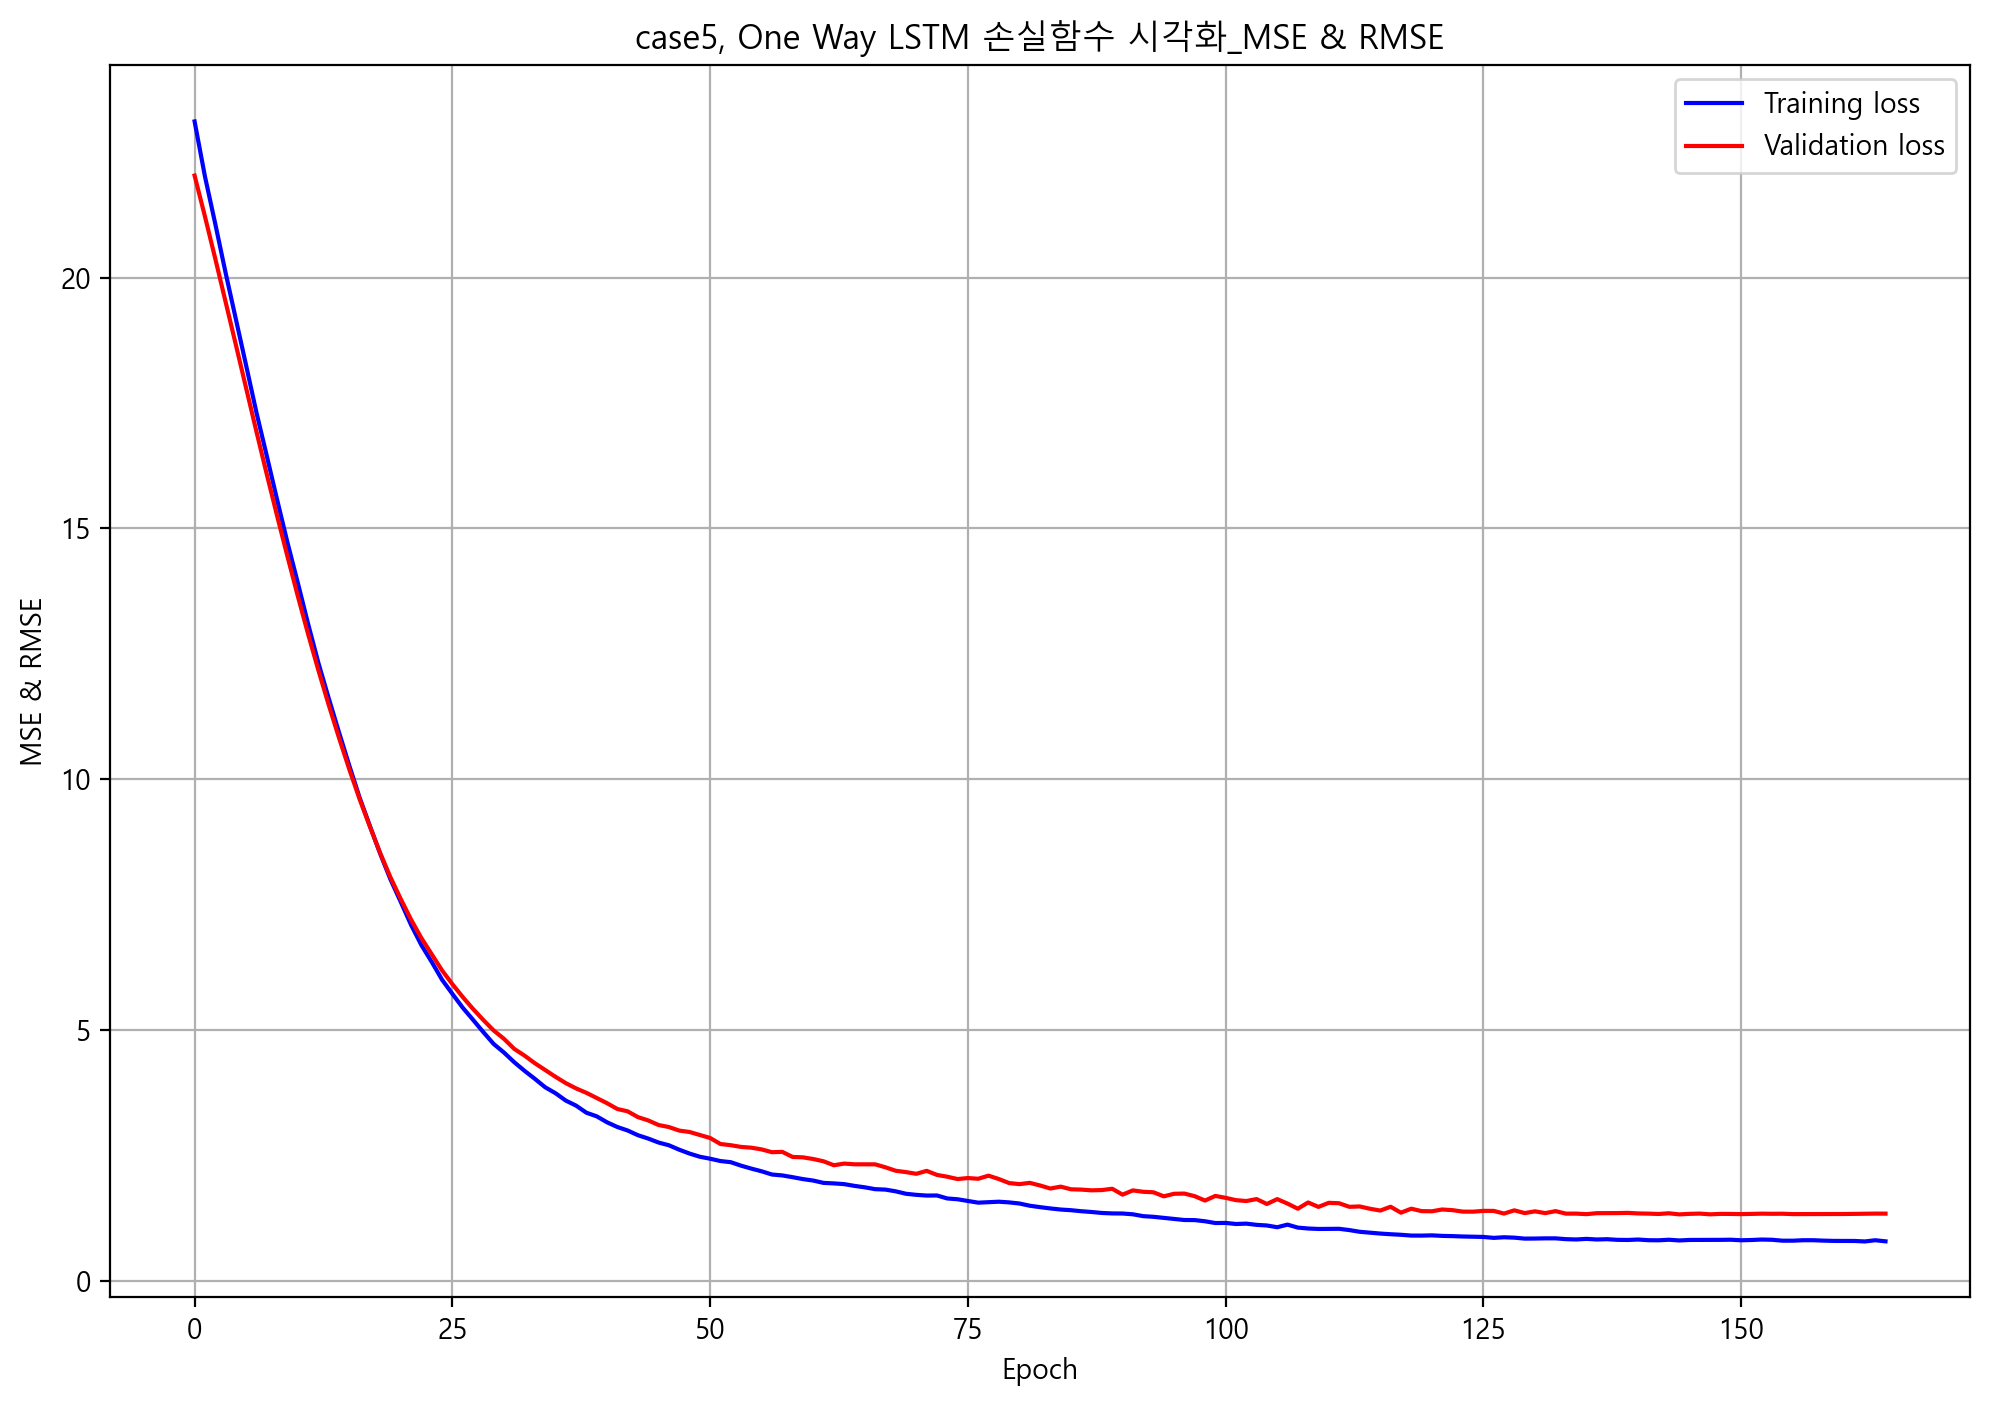

In [101]:
from tensorflow.keras.optimizers import legacy as legacy_optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization, Input, Embedding, Concatenate, Attention
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras import metrics

# Attention 레이어 정의
def attention_layer(inputs):
    attention = Attention()([inputs, inputs])
    return Concatenate()([inputs, attention])

# 범주형 변수 설정
num_categories = 3
embedding_dim = 5

# 옵티마이저 및 콜백 설정
initial_lr = 0.0005

optimizer = legacy_optimizers.Adam(learning_rate=initial_lr)
lr_restart = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# 모델 정의
numerical_input = Input(shape=(x_train_multi.shape[1], x_train_multi.shape[2]))
categorical_input = Input(shape=(x_train_label.shape[1], ))

# 임베딩 레이어
embedding = Embedding(input_dim=num_categories, output_dim=embedding_dim)(categorical_input)

# 입력 결합
combined_input = Concatenate(axis=-1)([numerical_input, embedding])

x = LSTM(128, return_sequences=True,
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(combined_input)
x = BatchNormalization()(x)
x = Dropout(0.3, seed = 40)(x)

x = LSTM(64, return_sequences=True,
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3, seed = 41)(x)

x = attention_layer(x)

x = LSTM(32, activation='relu',
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3, seed = 42)(x)

x = Dense(24, activation='relu')(x)
output = Dense(12)(x)

case5_uni_rmse = Model(inputs=[numerical_input, categorical_input], outputs=output)
case5_uni_rmse.compile(optimizer=optimizer
                       , loss="mse"
                       , metrics=[metrics.RootMeanSquaredError()]
                      )

# 모델 학습
case5_uni_rmse_history = case5_uni_rmse.fit(
    # 수치형 데이터와 범주형 데이터 분리    
    [x_train_multi, x_train_label],  
    y_train_multi,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    steps_per_epoch = x_train_multi.shape[0] // BATCH_SIZE, 
    validation_steps = x_val_multi.shape[0] // BATCH_SIZE,
    validation_data=([x_val_multi, x_val_label], y_val_multi),
    callbacks=[lr_restart, early_stop]
)

# 학습 결과 시각화
plot_train_history(case5_uni_rmse_history, "case5, One Way LSTM", "MSE & RMSE")

# 모델 학습
case5_uni_rmse.save("./output/case5/case5_uni_rmse.h5")

### 양방향 LSTM

Epoch 1/300
16/16 [==============================] - 5s 88ms/step - loss: 54.7847 - val_loss: 51.5112 - lr: 5.0000e-04
Epoch 2/300
16/16 [==============================] - 0s 17ms/step - loss: 49.1170 - val_loss: 46.1075 - lr: 5.0000e-04
Epoch 3/300
16/16 [==============================] - 0s 17ms/step - loss: 43.7991 - val_loss: 40.9939 - lr: 5.0000e-04
Epoch 4/300
16/16 [==============================] - 0s 17ms/step - loss: 38.8194 - val_loss: 36.2336 - lr: 5.0000e-04
Epoch 5/300
16/16 [==============================] - 0s 17ms/step - loss: 34.1803 - val_loss: 31.8354 - lr: 5.0000e-04
Epoch 6/300
16/16 [==============================] - 0s 17ms/step - loss: 29.9255 - val_loss: 27.8031 - lr: 5.0000e-04
Epoch 7/300
16/16 [==============================] - 0s 17ms/step - loss: 26.0440 - val_loss: 24.1340 - lr: 5.0000e-04
Epoch 8/300
16/16 [==============================] - 0s 17ms/step - loss: 22.5613 - val_loss: 20.8308 - lr: 5.0000e-04
Epoch 9/300
16/16 [=============================

16/16 [==============================] - 0s 17ms/step - loss: 2.2401 - val_loss: 2.3380 - lr: 5.0000e-04
Epoch 71/300
16/16 [==============================] - 0s 17ms/step - loss: 2.2007 - val_loss: 2.3342 - lr: 5.0000e-04
Epoch 72/300
16/16 [==============================] - 0s 16ms/step - loss: 2.1971 - val_loss: 2.3484 - lr: 5.0000e-04
Epoch 73/300
16/16 [==============================] - 0s 17ms/step - loss: 2.1692 - val_loss: 2.2288 - lr: 5.0000e-04
Epoch 74/300
16/16 [==============================] - 0s 16ms/step - loss: 2.1284 - val_loss: 2.2026 - lr: 5.0000e-04
Epoch 75/300
16/16 [==============================] - 0s 18ms/step - loss: 2.1094 - val_loss: 2.1829 - lr: 5.0000e-04
Epoch 76/300
16/16 [==============================] - 0s 17ms/step - loss: 2.0776 - val_loss: 2.1659 - lr: 5.0000e-04
Epoch 77/300
16/16 [==============================] - 0s 16ms/step - loss: 2.0432 - val_loss: 2.1409 - lr: 5.0000e-04
Epoch 78/300
16/16 [==============================] - 0s 16ms/step - 

16/16 [==============================] - 0s 17ms/step - loss: 0.8610 - val_loss: 1.0136 - lr: 5.0000e-04
Epoch 140/300
16/16 [==============================] - 0s 17ms/step - loss: 0.8479 - val_loss: 0.9658 - lr: 5.0000e-04
Epoch 141/300
16/16 [==============================] - 0s 16ms/step - loss: 0.8366 - val_loss: 0.9700 - lr: 5.0000e-04
Epoch 142/300
16/16 [==============================] - 0s 16ms/step - loss: 0.8140 - val_loss: 0.9550 - lr: 5.0000e-04
Epoch 143/300
16/16 [==============================] - 0s 16ms/step - loss: 0.8020 - val_loss: 0.9730 - lr: 5.0000e-04
Epoch 144/300
16/16 [==============================] - 0s 17ms/step - loss: 0.7920 - val_loss: 0.9398 - lr: 5.0000e-04
Epoch 145/300
16/16 [==============================] - 0s 16ms/step - loss: 0.7820 - val_loss: 0.9276 - lr: 5.0000e-04
Epoch 146/300
16/16 [==============================] - 0s 16ms/step - loss: 0.7819 - val_loss: 0.9301 - lr: 5.0000e-04
Epoch 147/300
16/16 [==============================] - 0s 16ms

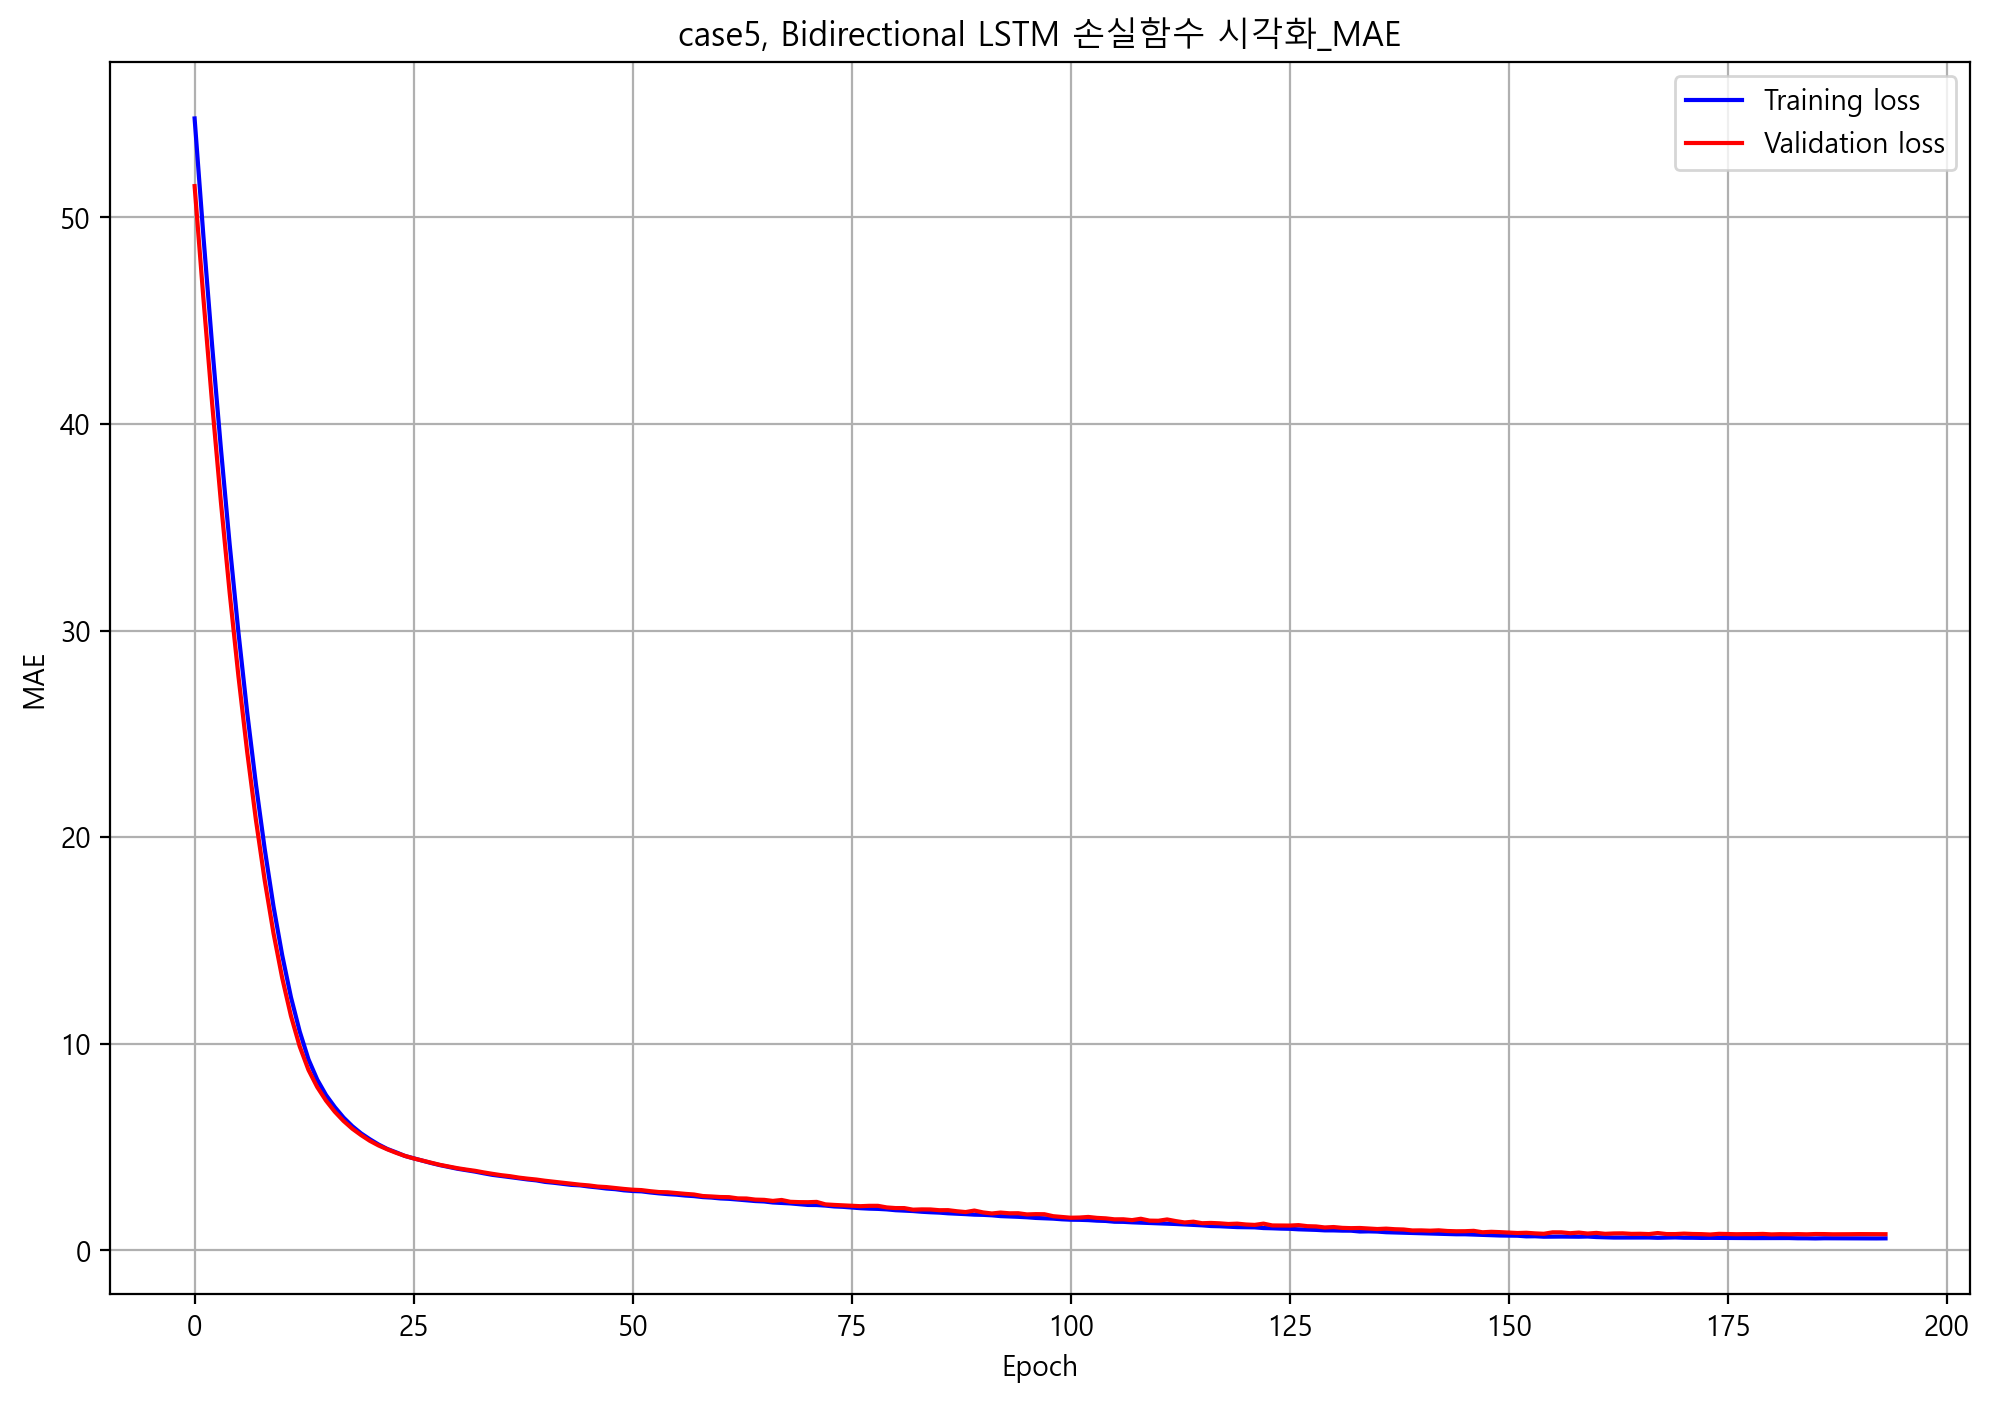

In [102]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization, Input, Embedding, Concatenate, Attention, Bidirectional
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import legacy as legacy_optimizers
from tensorflow.keras import metrics

# Attention 레이어 정의
def attention_layer(inputs):
    attention = Attention()([inputs, inputs])
    return Concatenate()([inputs, attention])

# 범주형 변수 설정
num_categories = 3
embedding_dim = 5

# 옵티마이저 및 콜백 설정
initial_lr = 0.0005

optimizer = legacy_optimizers.Adam(learning_rate=initial_lr)
lr_restart = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# 모델 정의
numerical_input = Input(shape=(x_train_multi.shape[1], x_train_multi.shape[2]))
categorical_input = Input(shape=(x_train_label.shape[1], ))

# 임베딩 레이어
embedding = Embedding(input_dim=num_categories, output_dim=embedding_dim)(categorical_input)

# 입력 결합
combined_input = Concatenate(axis=-1)([numerical_input, embedding])

x = Bidirectional(LSTM(128, return_sequences=True,
                   kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                   bias_regularizer=l1_l2(l1=0.005, l2=0.005)))(combined_input)
x = BatchNormalization()(x)
x = Dropout(0.3, seed = 40)(x)

x = Bidirectional(LSTM(64, return_sequences=True,
                   kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                   bias_regularizer=l1_l2(l1=0.005, l2=0.005)))(x)
x = BatchNormalization()(x)
x = Dropout(0.3, seed = 41)(x)

x = attention_layer(x)

x = LSTM(32, activation='relu',
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3, seed = 42)(x)

x = Dense(24, activation='relu')(x)
output = Dense(12)(x)

case5_bi_mae = Model(inputs=[numerical_input, categorical_input], outputs=output)
case5_bi_mae.compile(optimizer=optimizer, loss="mae")

# 모델 학습
case5_bi_mae_history = case5_bi_mae.fit(
    # 수치형 데이터와 범주형 데이터 분리    
    [x_train_multi, x_train_label],  
    y_train_multi,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    steps_per_epoch = x_train_multi.shape[0] // BATCH_SIZE, 
    validation_steps = x_val_multi.shape[0] // BATCH_SIZE,
    validation_data=([x_val_multi, x_val_label], y_val_multi),
    callbacks=[lr_restart, early_stop]
)

# 학습 결과 시각화
plot_train_history(case5_bi_mae_history, "case5, Bidirectional LSTM", "MAE")

# 모델 저장
case5_bi_mae.save("./output/case5/case5_bi_mae.h5")

Epoch 1/300
16/16 [==============================] - 6s 91ms/step - loss: 56.2935 - val_loss: 53.7455 - lr: 5.0000e-04
Epoch 2/300
16/16 [==============================] - 0s 17ms/step - loss: 52.0974 - val_loss: 49.7433 - lr: 5.0000e-04
Epoch 3/300
16/16 [==============================] - 0s 17ms/step - loss: 47.9712 - val_loss: 45.7477 - lr: 5.0000e-04
Epoch 4/300
16/16 [==============================] - 0s 18ms/step - loss: 43.9263 - val_loss: 41.8430 - lr: 5.0000e-04
Epoch 5/300
16/16 [==============================] - 0s 18ms/step - loss: 40.0247 - val_loss: 38.0783 - lr: 5.0000e-04
Epoch 6/300
16/16 [==============================] - 0s 17ms/step - loss: 36.2934 - val_loss: 34.4936 - lr: 5.0000e-04
Epoch 7/300
16/16 [==============================] - 0s 18ms/step - loss: 32.7507 - val_loss: 31.1162 - lr: 5.0000e-04
Epoch 8/300
16/16 [==============================] - 0s 17ms/step - loss: 29.4794 - val_loss: 27.9713 - lr: 5.0000e-04
Epoch 9/300
16/16 [=============================

16/16 [==============================] - 0s 17ms/step - loss: 2.3312 - val_loss: 2.6947 - lr: 5.0000e-04
Epoch 71/300
16/16 [==============================] - 0s 17ms/step - loss: 2.2656 - val_loss: 2.7523 - lr: 5.0000e-04
Epoch 72/300
16/16 [==============================] - 0s 17ms/step - loss: 2.3050 - val_loss: 2.7158 - lr: 5.0000e-04
Epoch 73/300
16/16 [==============================] - 0s 17ms/step - loss: 2.2613 - val_loss: 2.6902 - lr: 5.0000e-04
Epoch 74/300
16/16 [==============================] - 0s 18ms/step - loss: 2.2016 - val_loss: 2.6089 - lr: 5.0000e-04
Epoch 75/300
16/16 [==============================] - 0s 17ms/step - loss: 2.1888 - val_loss: 2.6645 - lr: 5.0000e-04
Epoch 76/300
16/16 [==============================] - 0s 17ms/step - loss: 2.1899 - val_loss: 2.6314 - lr: 5.0000e-04
Epoch 77/300
16/16 [==============================] - 0s 17ms/step - loss: 2.1233 - val_loss: 2.5233 - lr: 5.0000e-04
Epoch 78/300
16/16 [==============================] - 0s 17ms/step - 

Epoch 137/300
16/16 [==============================] - 0s 17ms/step - loss: 0.8708 - val_loss: 1.3776 - lr: 1.2500e-04
Epoch 138/300
16/16 [==============================] - 0s 17ms/step - loss: 0.8694 - val_loss: 1.3422 - lr: 1.2500e-04
Epoch 139/300
16/16 [==============================] - 0s 17ms/step - loss: 0.8545 - val_loss: 1.4052 - lr: 1.2500e-04
Epoch 140/300
16/16 [==============================] - 0s 17ms/step - loss: 0.8469 - val_loss: 1.3545 - lr: 1.2500e-04
Epoch 141/300
16/16 [==============================] - 0s 17ms/step - loss: 0.8472 - val_loss: 1.3874 - lr: 1.2500e-04
Epoch 142/300
16/16 [==============================] - 0s 16ms/step - loss: 0.8375 - val_loss: 1.3894 - lr: 1.2500e-04
Epoch 143/300
16/16 [==============================] - 0s 17ms/step - loss: 0.8315 - val_loss: 1.3329 - lr: 1.2500e-04
Epoch 144/300
16/16 [==============================] - 0s 16ms/step - loss: 0.8345 - val_loss: 1.3388 - lr: 1.2500e-04
Epoch 145/300
16/16 [===========================

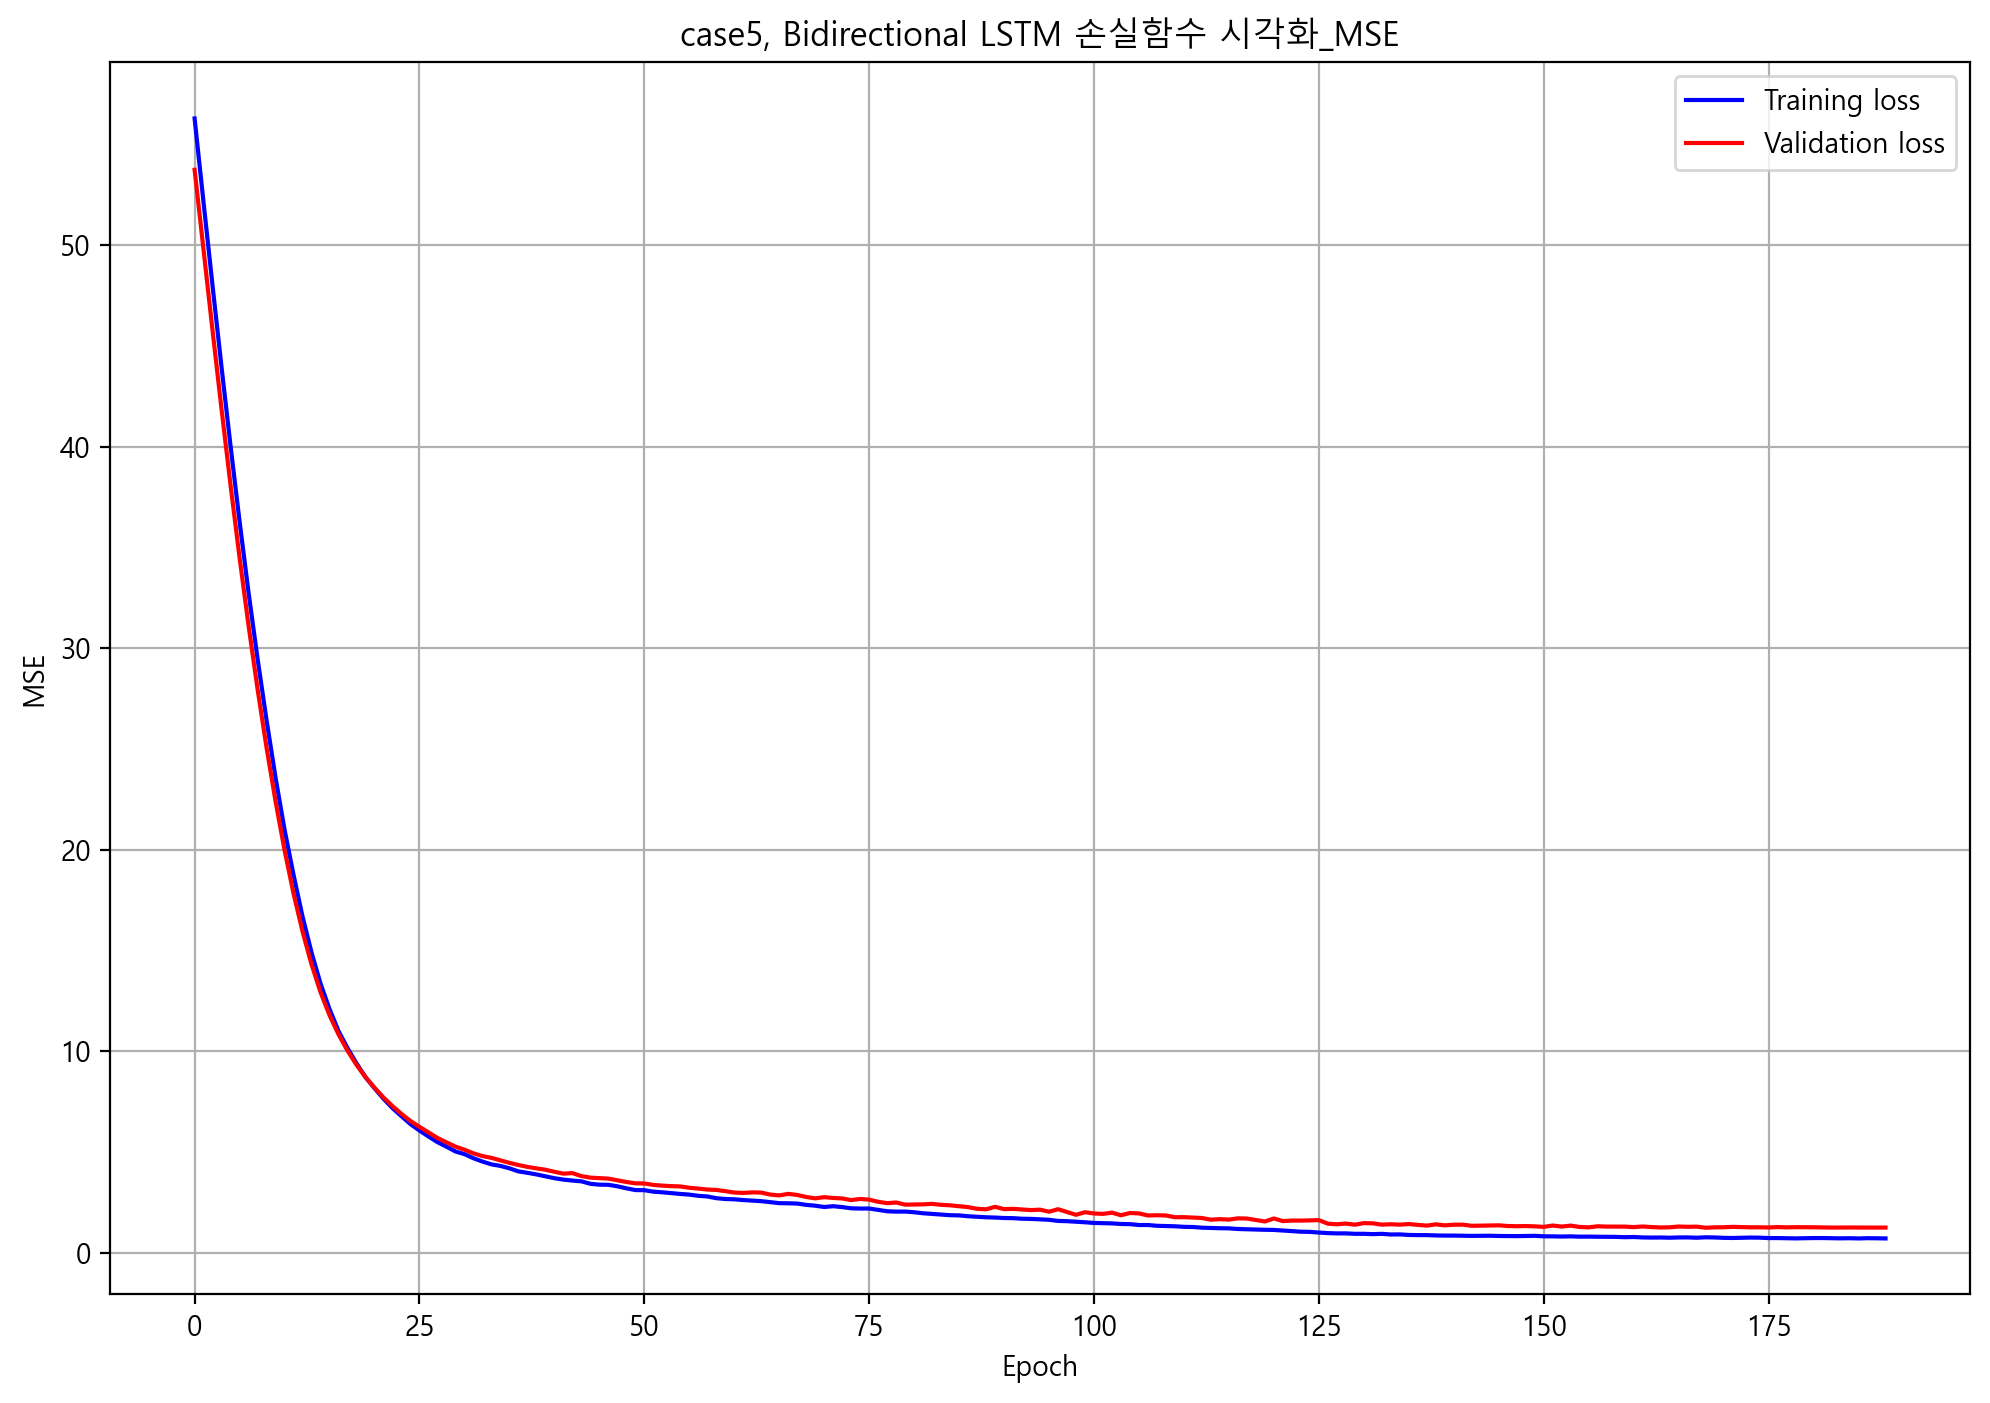

In [103]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization, Input, Embedding, Concatenate, Attention, Bidirectional
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import legacy as legacy_optimizers
from tensorflow.keras import metrics

# Attention 레이어 정의
def attention_layer(inputs):
    attention = Attention()([inputs, inputs])
    return Concatenate()([inputs, attention])

# 범주형 변수 설정
num_categories = 3
embedding_dim = 5

# 옵티마이저 및 콜백 설정
initial_lr = 0.0005

optimizer = legacy_optimizers.Adam(learning_rate=initial_lr)
lr_restart = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# 모델 정의
numerical_input = Input(shape=(x_train_multi.shape[1], x_train_multi.shape[2]))
categorical_input = Input(shape=(x_train_label.shape[1], ))

# 임베딩 레이어
embedding = Embedding(input_dim=num_categories, output_dim=embedding_dim)(categorical_input)

# 입력 결합
combined_input = Concatenate(axis=-1)([numerical_input, embedding])

x = Bidirectional(LSTM(128, return_sequences=True,
                   kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                   bias_regularizer=l1_l2(l1=0.005, l2=0.005)))(combined_input)
x = BatchNormalization()(x)
x = Dropout(0.3, seed = 40)(x)

x = Bidirectional(LSTM(64, return_sequences=True,
                   kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                   bias_regularizer=l1_l2(l1=0.005, l2=0.005)))(x)
x = BatchNormalization()(x)
x = Dropout(0.3, seed = 41)(x)

x = attention_layer(x)

x = LSTM(32, activation='relu',
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3, seed = 42)(x)

x = Dense(24, activation='relu')(x)
output = Dense(12)(x)

case5_bi_mse = Model(inputs=[numerical_input, categorical_input], outputs=output)
case5_bi_mse.compile(optimizer=optimizer, loss="mse")

# 모델 학습
case5_bi_mse_history = case5_bi_mse.fit(
    # 수치형 데이터와 범주형 데이터 분리    
    [x_train_multi, x_train_label],  
    y_train_multi,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    steps_per_epoch = x_train_multi.shape[0] // BATCH_SIZE, 
    validation_steps = x_val_multi.shape[0] // BATCH_SIZE,
    validation_data=([x_val_multi, x_val_label], y_val_multi),
    callbacks=[lr_restart, early_stop]
)

# 학습 결과 시각화
plot_train_history(case5_bi_mse_history, "case5, Bidirectional LSTM", "MSE")

# 모델 저장
case5_bi_mse.save("./output/case5/case5_bi_mse.h5")

Epoch 1/300
16/16 [==============================] - 6s 89ms/step - loss: 56.0736 - root_mean_squared_error: 1.2357 - val_loss: 53.3962 - val_root_mean_squared_error: 0.9779 - lr: 5.0000e-04
Epoch 2/300
16/16 [==============================] - 0s 18ms/step - loss: 51.7902 - root_mean_squared_error: 1.1228 - val_loss: 49.3154 - val_root_mean_squared_error: 0.9791 - lr: 5.0000e-04
Epoch 3/300
16/16 [==============================] - 0s 17ms/step - loss: 47.5342 - root_mean_squared_error: 1.0460 - val_loss: 45.2454 - val_root_mean_squared_error: 0.9815 - lr: 5.0000e-04
Epoch 4/300
16/16 [==============================] - 0s 17ms/step - loss: 43.4053 - root_mean_squared_error: 0.9927 - val_loss: 41.3078 - val_root_mean_squared_error: 0.9831 - lr: 5.0000e-04
Epoch 5/300
16/16 [==============================] - 0s 17ms/step - loss: 39.5184 - root_mean_squared_error: 0.9792 - val_loss: 37.5439 - val_root_mean_squared_error: 0.9845 - lr: 5.0000e-04
Epoch 6/300
16/16 [==========================

Epoch 44/300
16/16 [==============================] - 0s 17ms/step - loss: 3.4568 - root_mean_squared_error: 0.7512 - val_loss: 3.8054 - val_root_mean_squared_error: 0.9736 - lr: 5.0000e-04
Epoch 45/300
16/16 [==============================] - 0s 17ms/step - loss: 3.4652 - root_mean_squared_error: 0.7918 - val_loss: 3.7627 - val_root_mean_squared_error: 0.9707 - lr: 5.0000e-04
Epoch 46/300
16/16 [==============================] - 0s 17ms/step - loss: 3.3533 - root_mean_squared_error: 0.7477 - val_loss: 3.7256 - val_root_mean_squared_error: 0.9841 - lr: 5.0000e-04
Epoch 47/300
16/16 [==============================] - 0s 17ms/step - loss: 3.3186 - root_mean_squared_error: 0.7700 - val_loss: 3.6167 - val_root_mean_squared_error: 0.9592 - lr: 5.0000e-04
Epoch 48/300
16/16 [==============================] - 0s 16ms/step - loss: 3.2505 - root_mean_squared_error: 0.7616 - val_loss: 3.5770 - val_root_mean_squared_error: 0.9682 - lr: 5.0000e-04
Epoch 49/300
16/16 [==============================

16/16 [==============================] - 0s 17ms/step - loss: 1.8439 - root_mean_squared_error: 0.7298 - val_loss: 2.2807 - val_root_mean_squared_error: 0.9900 - lr: 5.0000e-04
Epoch 88/300
16/16 [==============================] - 0s 17ms/step - loss: 1.8328 - root_mean_squared_error: 0.7343 - val_loss: 2.2503 - val_root_mean_squared_error: 0.9849 - lr: 5.0000e-04
Epoch 89/300
16/16 [==============================] - 0s 18ms/step - loss: 1.7892 - root_mean_squared_error: 0.7224 - val_loss: 2.2348 - val_root_mean_squared_error: 0.9924 - lr: 5.0000e-04
Epoch 90/300
16/16 [==============================] - 0s 17ms/step - loss: 1.7360 - root_mean_squared_error: 0.7067 - val_loss: 2.2728 - val_root_mean_squared_error: 1.0248 - lr: 5.0000e-04
Epoch 91/300
16/16 [==============================] - 0s 17ms/step - loss: 1.7278 - root_mean_squared_error: 0.7190 - val_loss: 2.1627 - val_root_mean_squared_error: 0.9824 - lr: 5.0000e-04
Epoch 92/300
16/16 [==============================] - 0s 17ms/s

16/16 [==============================] - 0s 17ms/step - loss: 1.0380 - root_mean_squared_error: 0.6829 - val_loss: 1.5442 - val_root_mean_squared_error: 0.9890 - lr: 2.5000e-04
Epoch 130/300
16/16 [==============================] - 0s 17ms/step - loss: 1.0269 - root_mean_squared_error: 0.6817 - val_loss: 1.5013 - val_root_mean_squared_error: 0.9712 - lr: 2.5000e-04
Epoch 131/300
16/16 [==============================] - 0s 16ms/step - loss: 1.0391 - root_mean_squared_error: 0.6964 - val_loss: 1.5730 - val_root_mean_squared_error: 1.0117 - lr: 2.5000e-04
Epoch 132/300
16/16 [==============================] - 0s 16ms/step - loss: 1.0091 - root_mean_squared_error: 0.6801 - val_loss: 1.5485 - val_root_mean_squared_error: 1.0030 - lr: 2.5000e-04
Epoch 133/300
16/16 [==============================] - 0s 17ms/step - loss: 1.0365 - root_mean_squared_error: 0.7043 - val_loss: 1.5050 - val_root_mean_squared_error: 0.9825 - lr: 2.5000e-04
Epoch 134/300
16/16 [==============================] - 0s 1

16/16 [==============================] - 0s 16ms/step - loss: 0.7885 - root_mean_squared_error: 0.6674 - val_loss: 1.3458 - val_root_mean_squared_error: 1.0015 - lr: 3.1250e-05
Epoch 170/300
16/16 [==============================] - 0s 16ms/step - loss: 0.7858 - root_mean_squared_error: 0.6661 - val_loss: 1.3249 - val_root_mean_squared_error: 0.9918 - lr: 3.1250e-05
Epoch 171/300
16/16 [==============================] - 0s 17ms/step - loss: 0.7779 - root_mean_squared_error: 0.6612 - val_loss: 1.3187 - val_root_mean_squared_error: 0.9893 - lr: 3.1250e-05
Epoch 172/300
13/16 [=======================>......] - ETA: 0s - loss: 0.7697 - root_mean_squared_error: 0.6558
Epoch 172: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
16/16 [==============================] - 0s 17ms/step - loss: 0.7725 - root_mean_squared_error: 0.6581 - val_loss: 1.3303 - val_root_mean_squared_error: 0.9958 - lr: 3.1250e-05
Epoch 173/300
16/16 [==============================] - 0s 17ms/step - los

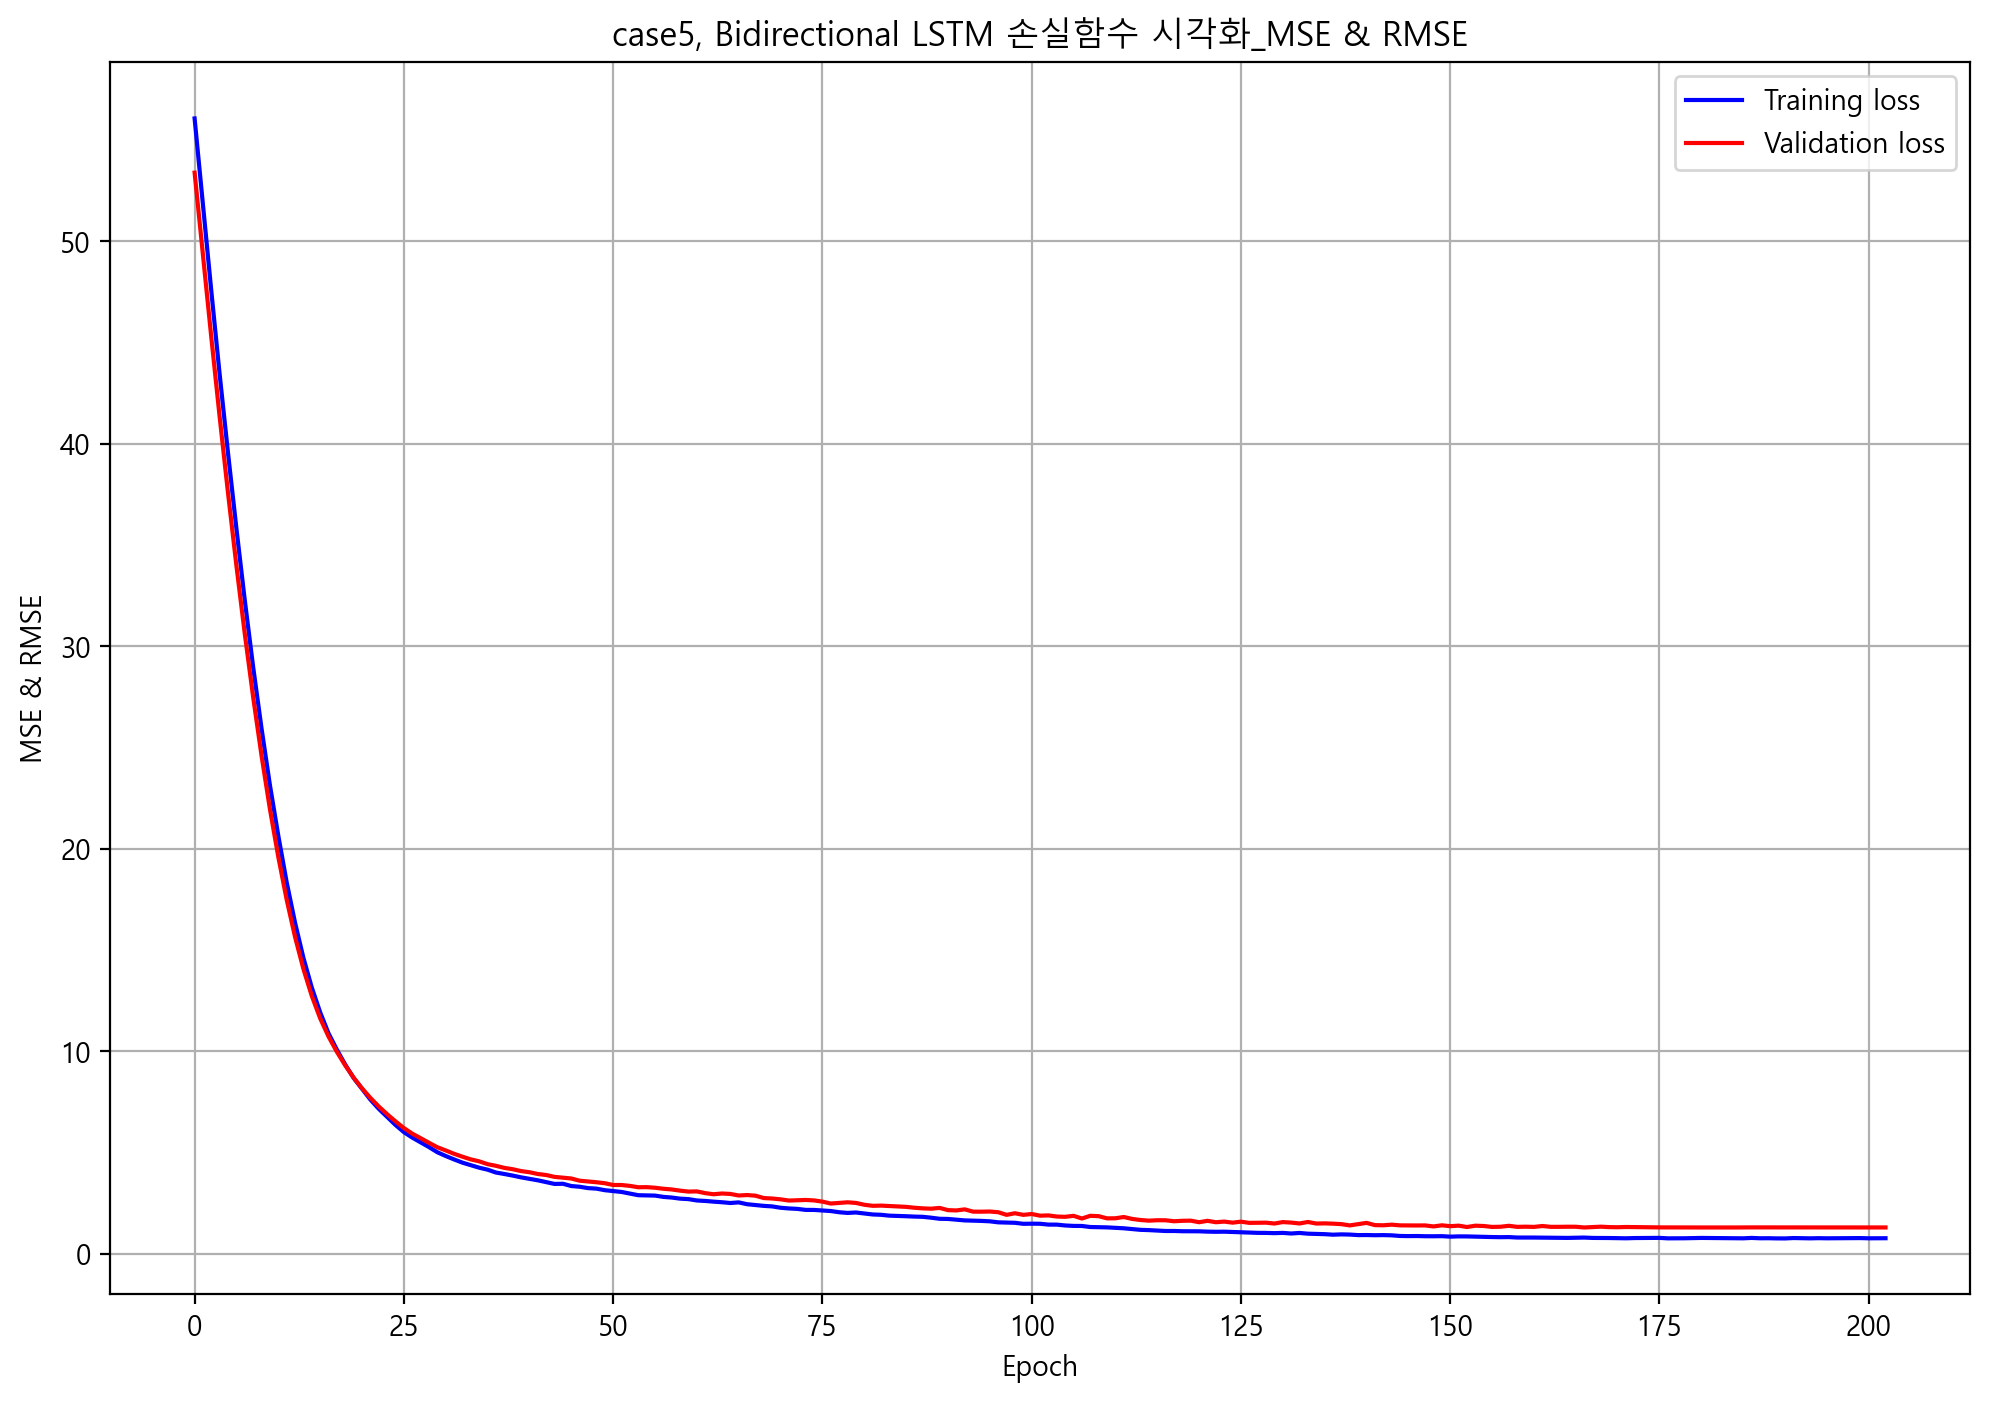

In [104]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization, Input, Embedding, Concatenate, Attention, Bidirectional
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import legacy as legacy_optimizers
from tensorflow.keras import metrics

# Attention 레이어 정의
def attention_layer(inputs):
    attention = Attention()([inputs, inputs])
    return Concatenate()([inputs, attention])

# 범주형 변수 설정
num_categories = 3
embedding_dim = 5

# 옵티마이저 및 콜백 설정
initial_lr = 0.0005

optimizer = legacy_optimizers.Adam(learning_rate=initial_lr)
lr_restart = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# 모델 정의
numerical_input = Input(shape=(x_train_multi.shape[1], x_train_multi.shape[2]))
categorical_input = Input(shape=(x_train_label.shape[1], ))

# 임베딩 레이어
embedding = Embedding(input_dim=num_categories, output_dim=embedding_dim)(categorical_input)

# 입력 결합
combined_input = Concatenate(axis=-1)([numerical_input, embedding])

x = Bidirectional(LSTM(128, return_sequences=True,
                   kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                   bias_regularizer=l1_l2(l1=0.005, l2=0.005)))(combined_input)
x = BatchNormalization()(x)
x = Dropout(0.3, seed = 40)(x)

x = Bidirectional(LSTM(64, return_sequences=True,
                   kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                   bias_regularizer=l1_l2(l1=0.005, l2=0.005)))(x)
x = BatchNormalization()(x)
x = Dropout(0.3, seed = 41)(x)

x = attention_layer(x)

x = LSTM(32, activation='relu',
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3, seed = 42)(x)

x = Dense(24, activation='relu')(x)
output = Dense(12)(x)

case5_bi_rmse = Model(inputs=[numerical_input, categorical_input], outputs=output)
case5_bi_rmse.compile(optimizer=optimizer
                       , loss="mse"
                       , metrics=[metrics.RootMeanSquaredError()]
                      )

# 모델 학습
case5_bi_rmse_history = case5_bi_rmse.fit(
    # 수치형 데이터와 범주형 데이터 분리    
    [x_train_multi, x_train_label],  
    y_train_multi,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    steps_per_epoch = x_train_multi.shape[0] // BATCH_SIZE, 
    validation_steps = x_val_multi.shape[0] // BATCH_SIZE,
    validation_data=([x_val_multi, x_val_label], y_val_multi),
    callbacks=[lr_restart, early_stop]
)

# 학습 결과 시각화
plot_train_history(case5_bi_rmse_history, "case5, Bidirectional LSTM", "MSE & RMSE")

# 모델 저장
case5_bi_rmse.save("./output/case5/case5_bi_rmse.h5")

# Case6) 3개 다 & 로그 변환

## 데이터 전처리

In [105]:
os.mkdir("./output/case6")

case6_df = data[['WTIO', 'SETIO', 'DMI', 'ONI', 'SOI', 'ENSO', 'D20_SCTR']]

case6_dts = case6_df.values

case6_label = case6_dts[ : , 5]
case6_dts = case6_dts[ : , [0, 1, 2, 3, 4, 6]]

case6_dts = np.sign(case6_dts) * np.log1p(np.abs(case6_dts))

## 데이터 분리

In [106]:
# 학습 데이터
x_train_multi, y_train_multi = multivariate_data(case6_dts, case6_dts[:, -1], 0, TRAIN_SPLIT - future_target, past_history, future_target, STEP)

x_train_label = label_split(case6_label, 0, TRAIN_SPLIT - future_target, past_history, future_target, STEP)

# 검증 데이터
x_val_multi, y_val_multi = multivariate_data(case6_dts, case6_dts[:, -1], TRAIN_SPLIT, TRAIN_SPLIT + VAL_SPLIT - future_target, past_history, future_target, STEP)

x_val_label = label_split(case6_label, TRAIN_SPLIT, TRAIN_SPLIT + VAL_SPLIT - future_target, past_history, future_target, STEP)

# 테스트 데이터
x_test_case6, y_test_case6 = multivariate_data(case6_dts, case6_dts[:, -1], TRAIN_SPLIT + VAL_SPLIT, None, past_history, future_target, STEP)

x_test_case6_label = label_split(case6_label, TRAIN_SPLIT + VAL_SPLIT, None, past_history, future_target, STEP)

## 모델 학습

### 단방향 LSTM

Epoch 1/300
16/16 [==============================] - 4s 57ms/step - loss: 25.3125 - val_loss: 24.5121 - lr: 5.0000e-04
Epoch 2/300
16/16 [==============================] - 0s 12ms/step - loss: 23.3574 - val_loss: 22.8518 - lr: 5.0000e-04
Epoch 3/300
16/16 [==============================] - 0s 12ms/step - loss: 21.4467 - val_loss: 21.2246 - lr: 5.0000e-04
Epoch 4/300
16/16 [==============================] - 0s 12ms/step - loss: 19.6413 - val_loss: 19.6771 - lr: 5.0000e-04
Epoch 5/300
16/16 [==============================] - 0s 12ms/step - loss: 17.8621 - val_loss: 18.2117 - lr: 5.0000e-04
Epoch 6/300
16/16 [==============================] - 0s 12ms/step - loss: 16.1847 - val_loss: 16.8115 - lr: 5.0000e-04
Epoch 7/300
16/16 [==============================] - 0s 12ms/step - loss: 14.6838 - val_loss: 15.4515 - lr: 5.0000e-04
Epoch 8/300
16/16 [==============================] - 0s 12ms/step - loss: 13.2425 - val_loss: 14.1410 - lr: 5.0000e-04
Epoch 9/300
16/16 [=============================

16/16 [==============================] - 0s 12ms/step - loss: 1.7171 - val_loss: 1.6696 - lr: 5.0000e-04
Epoch 71/300
16/16 [==============================] - 0s 11ms/step - loss: 1.7022 - val_loss: 1.6097 - lr: 5.0000e-04
Epoch 72/300
13/16 [=======================>......] - ETA: 0s - loss: 1.7057
Epoch 72: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
16/16 [==============================] - 0s 11ms/step - loss: 1.6887 - val_loss: 1.7388 - lr: 5.0000e-04
Epoch 73/300
16/16 [==============================] - 0s 11ms/step - loss: 1.6080 - val_loss: 1.6593 - lr: 2.5000e-04
Epoch 74/300
16/16 [==============================] - 0s 11ms/step - loss: 1.6002 - val_loss: 1.5187 - lr: 2.5000e-04
Epoch 75/300
16/16 [==============================] - 0s 12ms/step - loss: 1.6204 - val_loss: 1.3976 - lr: 2.5000e-04
Epoch 76/300
16/16 [==============================] - 0s 11ms/step - loss: 1.6008 - val_loss: 1.5240 - lr: 2.5000e-04
Epoch 77/300
16/16 [==========================

16/16 [==============================] - 0s 12ms/step - loss: 1.1524 - val_loss: 0.8743 - lr: 3.1250e-05
Epoch 135/300
16/16 [==============================] - 0s 12ms/step - loss: 1.1436 - val_loss: 0.8737 - lr: 3.1250e-05
Epoch 136/300
16/16 [==============================] - 0s 12ms/step - loss: 1.1501 - val_loss: 0.8742 - lr: 3.1250e-05
Epoch 137/300
16/16 [==============================] - 0s 12ms/step - loss: 1.1622 - val_loss: 0.8719 - lr: 3.1250e-05
Epoch 138/300
16/16 [==============================] - 0s 11ms/step - loss: 1.1987 - val_loss: 0.8763 - lr: 3.1250e-05
Epoch 139/300
16/16 [==============================] - 0s 12ms/step - loss: 1.1741 - val_loss: 0.8657 - lr: 3.1250e-05
Epoch 140/300
16/16 [==============================] - 0s 12ms/step - loss: 1.1179 - val_loss: 0.8569 - lr: 3.1250e-05
Epoch 141/300
16/16 [==============================] - 0s 11ms/step - loss: 1.1730 - val_loss: 0.8602 - lr: 3.1250e-05
Epoch 142/300
16/16 [==============================] - 0s 12ms

16/16 [==============================] - 0s 11ms/step - loss: 1.1358 - val_loss: 0.8365 - lr: 1.0000e-06
Epoch 198/300
16/16 [==============================] - 0s 11ms/step - loss: 1.1705 - val_loss: 0.8363 - lr: 1.0000e-06
Epoch 199/300
16/16 [==============================] - 0s 12ms/step - loss: 1.1846 - val_loss: 0.8370 - lr: 1.0000e-06
Epoch 200/300
16/16 [==============================] - 0s 11ms/step - loss: 1.1345 - val_loss: 0.8368 - lr: 1.0000e-06
Epoch 201/300
16/16 [==============================] - 0s 11ms/step - loss: 1.1054 - val_loss: 0.8375 - lr: 1.0000e-06
Epoch 202/300
16/16 [==============================] - 0s 11ms/step - loss: 1.1375 - val_loss: 0.8374 - lr: 1.0000e-06
Epoch 203/300
16/16 [==============================] - 0s 11ms/step - loss: 1.1889 - val_loss: 0.8379 - lr: 1.0000e-06
Epoch 204/300
16/16 [==============================] - 0s 12ms/step - loss: 1.1337 - val_loss: 0.8385 - lr: 1.0000e-06
Epoch 205/300
16/16 [==============================] - 0s 11ms

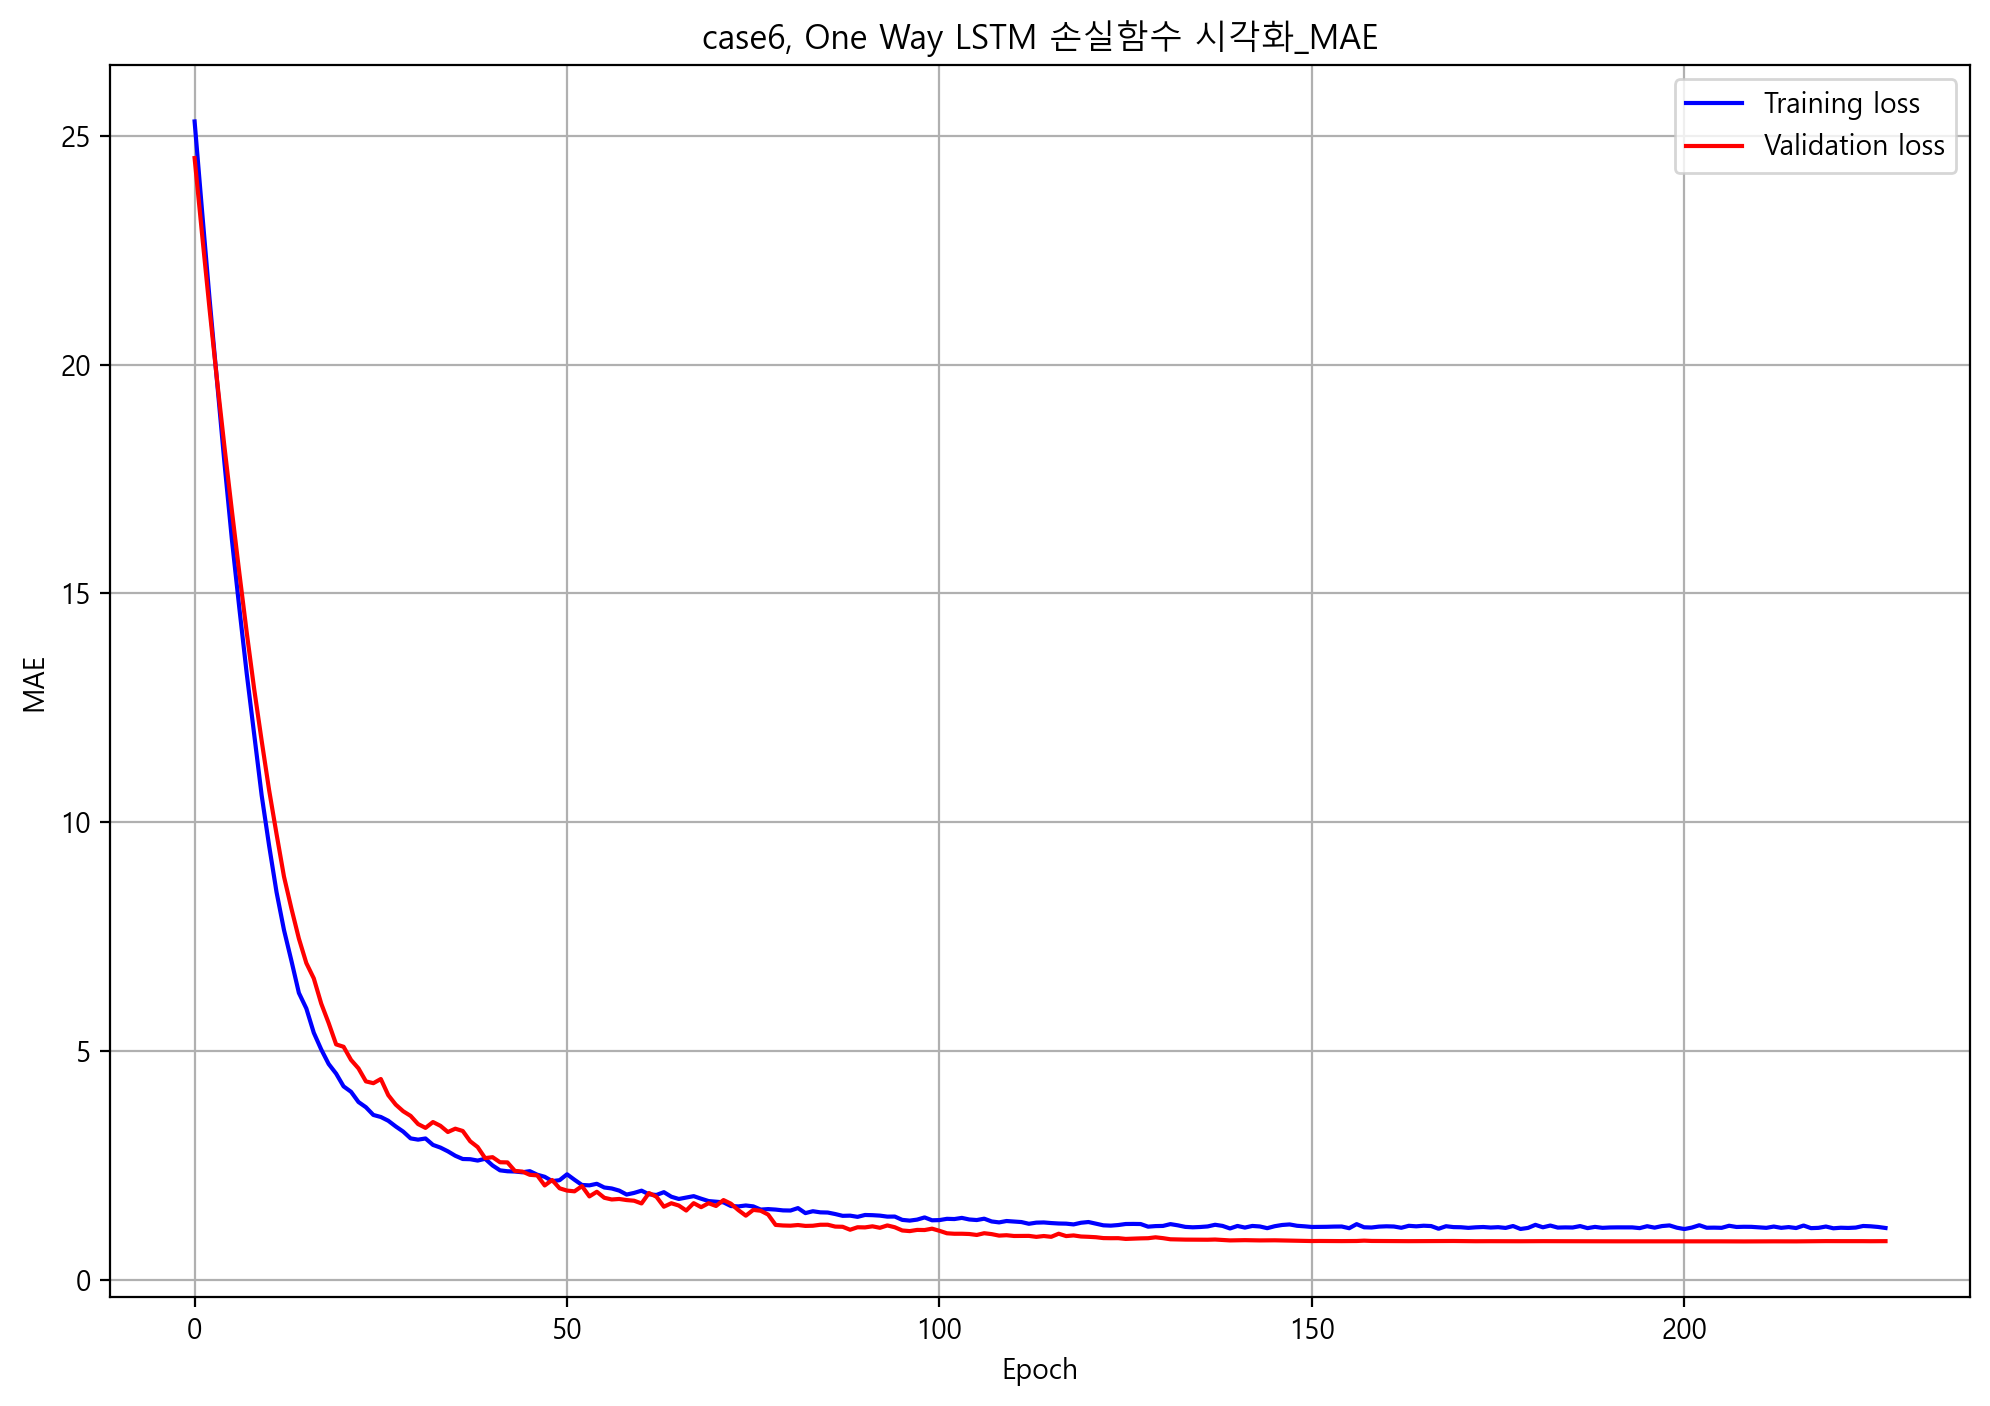

In [107]:
from tensorflow.keras.optimizers import legacy as legacy_optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization, Input, Embedding, Concatenate, Attention
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras import metrics

# Attention 레이어 정의
def attention_layer(inputs):
    attention = Attention()([inputs, inputs])
    return Concatenate()([inputs, attention])

# 옵티마이저 설정
initial_lr = 0.0005
optimizer = legacy_optimizers.Adam(learning_rate=initial_lr)

# 범주형 변수 설정
num_categories = 3
embedding_dim = 5

# 옵티마이저 및 콜백 설정
optimizer = Adam(learning_rate=initial_lr)
lr_restart = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# 모델 정의
numerical_input = Input(shape=(x_train_multi.shape[1], x_train_multi.shape[2]))
categorical_input = Input(shape=(x_train_label.shape[1], ))

# 임베딩 레이어
embedding = Embedding(input_dim=num_categories, output_dim=embedding_dim)(categorical_input)

# 입력 결합
combined_input = Concatenate(axis=-1)([numerical_input, embedding])

x = LSTM(128, return_sequences=True,
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(combined_input)
x = BatchNormalization()(x)
x = Dropout(0.3, seed = 40)(x)

x = LSTM(64, return_sequences=True,
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3, seed = 41)(x)

x = attention_layer(x)

x = LSTM(32, activation='relu',
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3, seed = 42)(x)

x = Dense(24, activation='relu')(x)
output = Dense(12)(x)

case6_uni_mae = Model(inputs=[numerical_input, categorical_input], outputs=output)
case6_uni_mae.compile(optimizer=optimizer, loss="mae")

# 모델 학습
case6_uni_mae_history = case6_uni_mae.fit(
    # 수치형 데이터와 범주형 데이터 분리    
    [x_train_multi, x_train_label],  
    y_train_multi,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    steps_per_epoch = x_train_multi.shape[0] // BATCH_SIZE, 
    validation_steps = x_val_multi.shape[0] // BATCH_SIZE,
    validation_data=([x_val_multi, x_val_label], y_val_multi),
    callbacks=[lr_restart, early_stop]
)

# 학습 결과 시각화
plot_train_history(case6_uni_mae_history, "case6, One Way LSTM", "MAE")

# 모델 저장
case6_uni_mae.save("./output/case6/case6_uni_mae.h5")

Epoch 1/300
16/16 [==============================] - 4s 56ms/step - loss: 40.4898 - val_loss: 40.4367 - lr: 5.0000e-04
Epoch 2/300
16/16 [==============================] - 0s 12ms/step - loss: 38.1502 - val_loss: 39.5225 - lr: 5.0000e-04
Epoch 3/300
16/16 [==============================] - 0s 12ms/step - loss: 36.0947 - val_loss: 38.3886 - lr: 5.0000e-04
Epoch 4/300
16/16 [==============================] - 0s 12ms/step - loss: 33.9283 - val_loss: 37.1407 - lr: 5.0000e-04
Epoch 5/300
16/16 [==============================] - 0s 12ms/step - loss: 31.7371 - val_loss: 35.6755 - lr: 5.0000e-04
Epoch 6/300
16/16 [==============================] - 0s 12ms/step - loss: 29.3553 - val_loss: 33.9188 - lr: 5.0000e-04
Epoch 7/300
16/16 [==============================] - 0s 13ms/step - loss: 27.2197 - val_loss: 31.9944 - lr: 5.0000e-04
Epoch 8/300
16/16 [==============================] - 0s 12ms/step - loss: 25.5367 - val_loss: 29.8324 - lr: 5.0000e-04
Epoch 9/300
16/16 [=============================

16/16 [==============================] - 0s 12ms/step - loss: 2.7724 - val_loss: 2.5567 - lr: 5.0000e-04
Epoch 71/300
16/16 [==============================] - 0s 12ms/step - loss: 2.7793 - val_loss: 2.6884 - lr: 5.0000e-04
Epoch 72/300
16/16 [==============================] - 0s 11ms/step - loss: 2.8789 - val_loss: 2.6097 - lr: 5.0000e-04
Epoch 73/300
16/16 [==============================] - 0s 11ms/step - loss: 2.7505 - val_loss: 2.3680 - lr: 5.0000e-04
Epoch 74/300
16/16 [==============================] - 0s 12ms/step - loss: 2.6776 - val_loss: 2.2955 - lr: 5.0000e-04
Epoch 75/300
16/16 [==============================] - 0s 12ms/step - loss: 2.6620 - val_loss: 2.2586 - lr: 5.0000e-04
Epoch 76/300
16/16 [==============================] - 0s 12ms/step - loss: 2.5859 - val_loss: 2.2297 - lr: 5.0000e-04
Epoch 77/300
16/16 [==============================] - 0s 12ms/step - loss: 2.4282 - val_loss: 2.1351 - lr: 5.0000e-04
Epoch 78/300
16/16 [==============================] - 0s 13ms/step - 

16/16 [==============================] - 0s 12ms/step - loss: 1.0146 - val_loss: 0.7731 - lr: 5.0000e-04
Epoch 140/300
16/16 [==============================] - 0s 11ms/step - loss: 0.8722 - val_loss: 0.7857 - lr: 5.0000e-04
Epoch 141/300
16/16 [==============================] - 0s 12ms/step - loss: 0.9607 - val_loss: 0.7421 - lr: 5.0000e-04
Epoch 142/300
16/16 [==============================] - 0s 12ms/step - loss: 0.8791 - val_loss: 0.7534 - lr: 5.0000e-04
Epoch 143/300
16/16 [==============================] - 0s 11ms/step - loss: 0.9101 - val_loss: 0.6716 - lr: 5.0000e-04
Epoch 144/300
16/16 [==============================] - 0s 11ms/step - loss: 0.9362 - val_loss: 0.6827 - lr: 5.0000e-04
Epoch 145/300
16/16 [==============================] - 0s 11ms/step - loss: 0.9077 - val_loss: 0.7274 - lr: 5.0000e-04
Epoch 146/300
16/16 [==============================] - 0s 12ms/step - loss: 0.8944 - val_loss: 0.6754 - lr: 5.0000e-04
Epoch 147/300
16/16 [==============================] - 0s 11ms

Epoch 202/300
16/16 [==============================] - 0s 11ms/step - loss: 0.5893 - val_loss: 0.3924 - lr: 1.5625e-05
Epoch 203/300
16/16 [==============================] - 0s 11ms/step - loss: 0.6153 - val_loss: 0.3956 - lr: 1.5625e-05
Epoch 204/300
16/16 [==============================] - 0s 11ms/step - loss: 0.6091 - val_loss: 0.3933 - lr: 1.5625e-05
Epoch 205/300
16/16 [==============================] - 0s 12ms/step - loss: 0.5886 - val_loss: 0.3940 - lr: 1.5625e-05
Epoch 206/300
16/16 [==============================] - 0s 12ms/step - loss: 0.5507 - val_loss: 0.3923 - lr: 1.5625e-05
Epoch 207/300
16/16 [==============================] - 0s 12ms/step - loss: 0.5922 - val_loss: 0.3897 - lr: 1.5625e-05
Epoch 208/300
16/16 [==============================] - 0s 12ms/step - loss: 0.5927 - val_loss: 0.3896 - lr: 1.5625e-05
Epoch 209/300
16/16 [==============================] - 0s 12ms/step - loss: 0.5804 - val_loss: 0.3867 - lr: 1.5625e-05
Epoch 210/300
16/16 [===========================

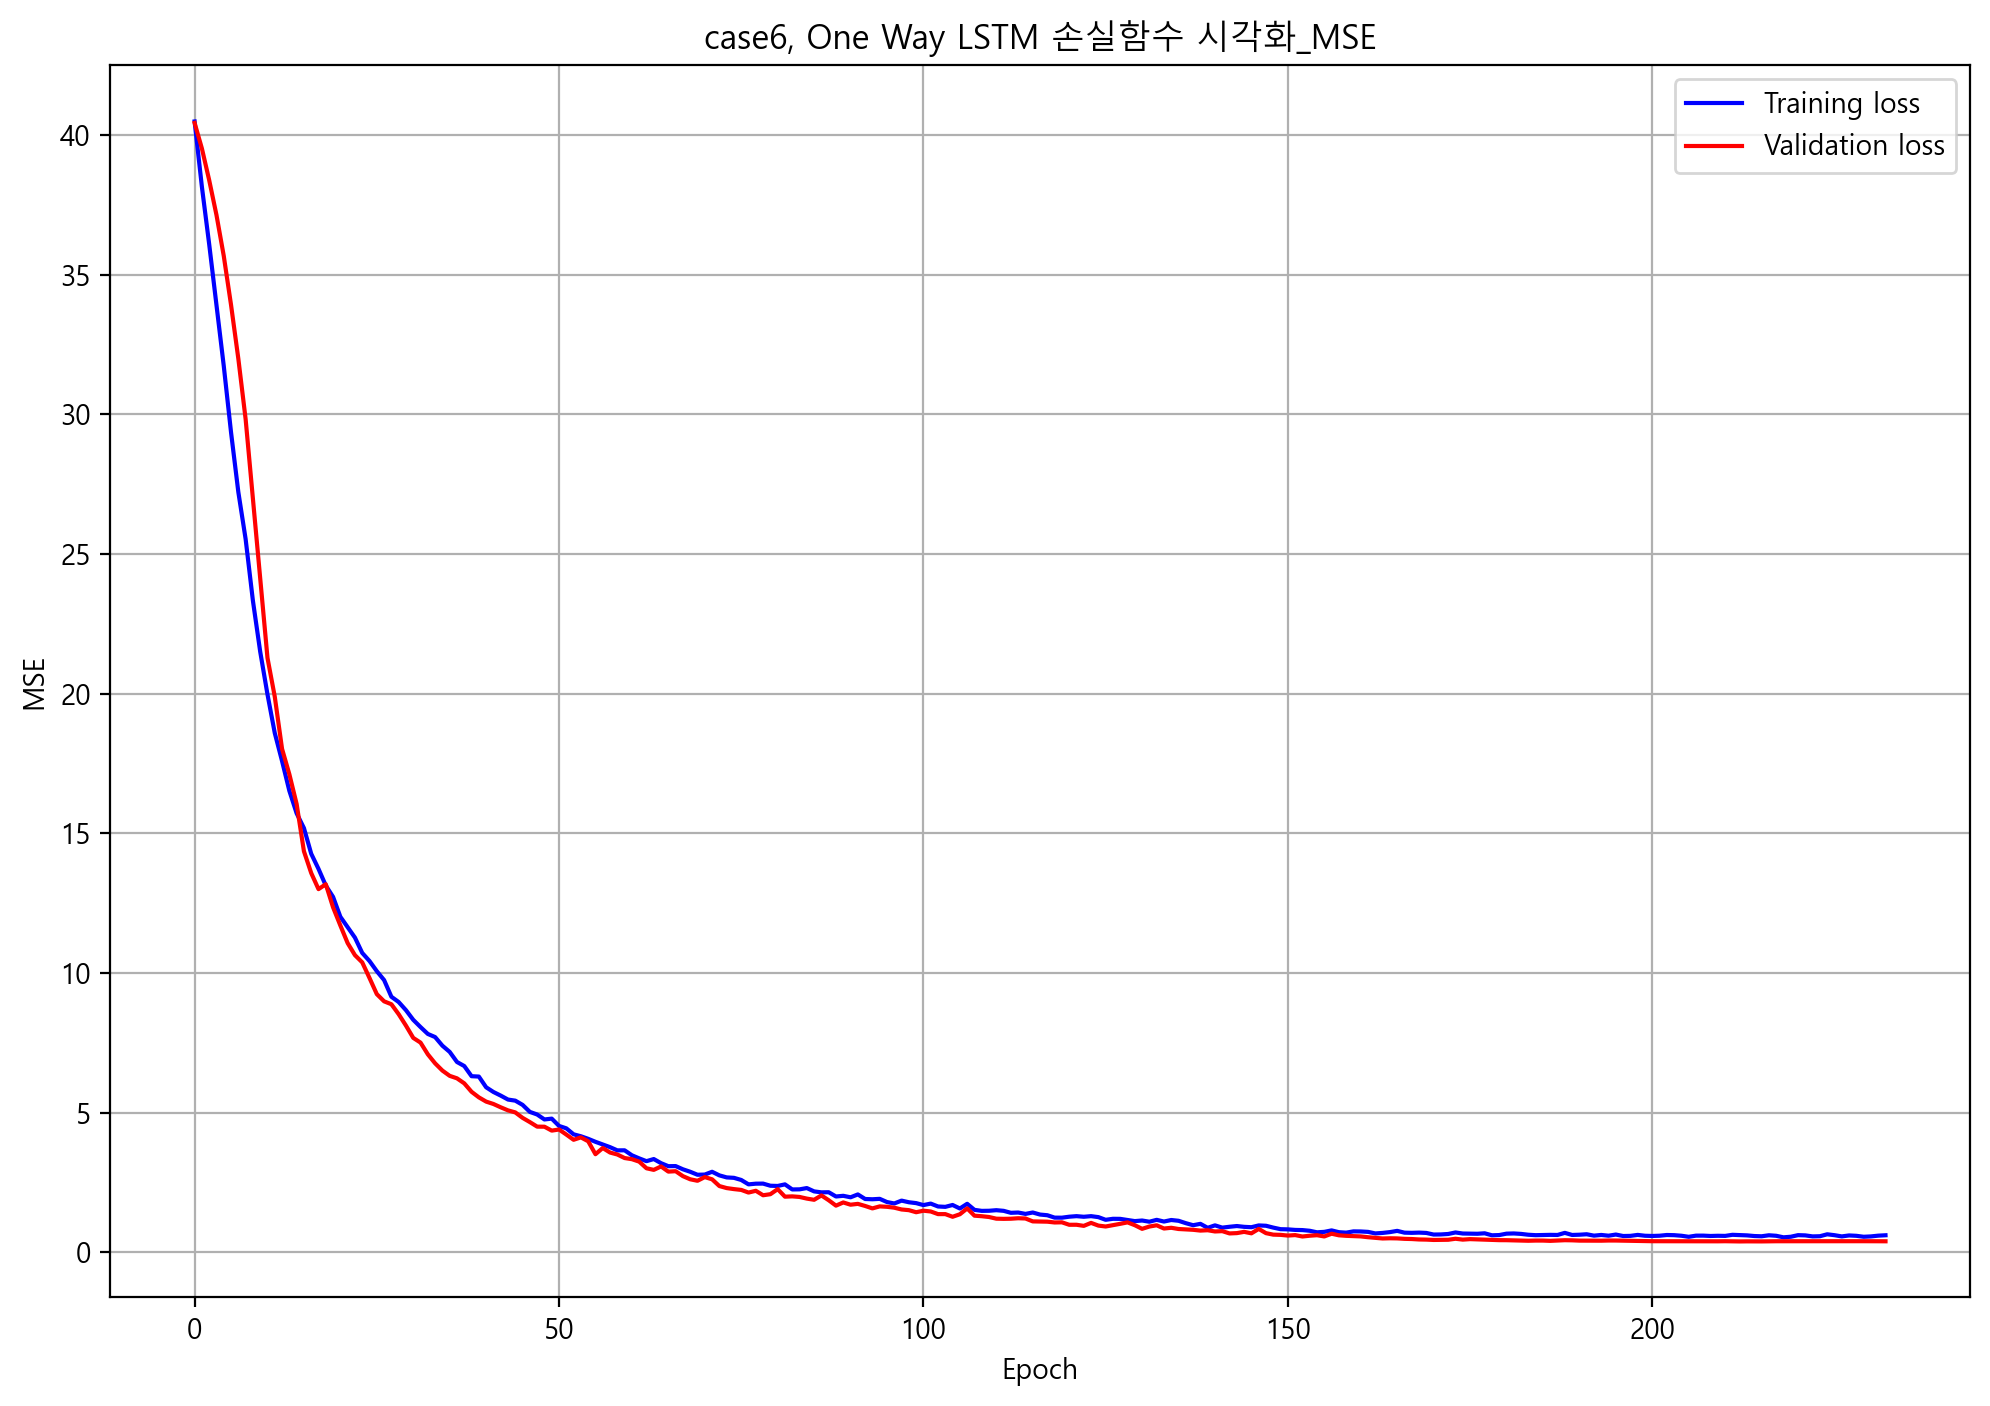

In [108]:
from tensorflow.keras.optimizers import legacy as legacy_optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization, Input, Embedding, Concatenate, Attention
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras import metrics

# Attention 레이어 정의
def attention_layer(inputs):
    attention = Attention()([inputs, inputs])
    return Concatenate()([inputs, attention])

# 옵티마이저 설정
initial_lr = 0.0005
optimizer = legacy_optimizers.Adam(learning_rate=initial_lr)

# 범주형 변수 설정
num_categories = 3
embedding_dim = 5

# 옵티마이저 및 콜백 설정
optimizer = Adam(learning_rate=initial_lr)
lr_restart = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# 모델 정의
numerical_input = Input(shape=(x_train_multi.shape[1], x_train_multi.shape[2]))
categorical_input = Input(shape=(x_train_label.shape[1], ))

# 임베딩 레이어
embedding = Embedding(input_dim=num_categories, output_dim=embedding_dim)(categorical_input)

# 입력 결합
combined_input = Concatenate(axis=-1)([numerical_input, embedding])

x = LSTM(128, return_sequences=True,
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(combined_input)
x = BatchNormalization()(x)
x = Dropout(0.3, seed = 40)(x)

x = LSTM(64, return_sequences=True,
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3, seed = 41)(x)

x = attention_layer(x)

x = LSTM(32, activation='relu',
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3, seed = 42)(x)

x = Dense(24, activation='relu')(x)
output = Dense(12)(x)

case6_uni_mse = Model(inputs=[numerical_input, categorical_input], outputs=output)
case6_uni_mse.compile(optimizer=optimizer, loss="mse")

# 모델 학습
case6_uni_mse_history = case6_uni_mse.fit(
    # 수치형 데이터와 범주형 데이터 분리    
    [x_train_multi, x_train_label],  
    y_train_multi,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    steps_per_epoch = x_train_multi.shape[0] // BATCH_SIZE, 
    validation_steps = x_val_multi.shape[0] // BATCH_SIZE,
    validation_data=([x_val_multi, x_val_label], y_val_multi),
    callbacks=[lr_restart, early_stop]
)

# 학습 결과 시각화
plot_train_history(case6_uni_mse_history, "case6, One Way LSTM", "MSE")

# 모델 저장
case6_uni_mse.save("./output/case6/case6_uni_mse.h5")

Epoch 1/300
16/16 [==============================] - 4s 58ms/step - loss: 41.7263 - root_mean_squared_error: 4.4763 - val_loss: 40.5542 - val_root_mean_squared_error: 4.3719 - lr: 5.0000e-04
Epoch 2/300
16/16 [==============================] - 0s 12ms/step - loss: 39.3942 - root_mean_squared_error: 4.2639 - val_loss: 39.7120 - val_root_mean_squared_error: 4.3317 - lr: 5.0000e-04
Epoch 3/300
16/16 [==============================] - 0s 12ms/step - loss: 37.2483 - root_mean_squared_error: 4.0673 - val_loss: 38.6649 - val_root_mean_squared_error: 4.2708 - lr: 5.0000e-04
Epoch 4/300
16/16 [==============================] - 0s 12ms/step - loss: 35.2913 - root_mean_squared_error: 3.8883 - val_loss: 37.5954 - val_root_mean_squared_error: 4.2086 - lr: 5.0000e-04
Epoch 5/300
16/16 [==============================] - 0s 12ms/step - loss: 33.3407 - root_mean_squared_error: 3.7034 - val_loss: 36.2904 - val_root_mean_squared_error: 4.1181 - lr: 5.0000e-04
Epoch 6/300
16/16 [==========================

Epoch 44/300
16/16 [==============================] - 0s 12ms/step - loss: 5.6495 - root_mean_squared_error: 0.8030 - val_loss: 5.2155 - val_root_mean_squared_error: 0.5477 - lr: 5.0000e-04
Epoch 45/300
16/16 [==============================] - 0s 12ms/step - loss: 5.6086 - root_mean_squared_error: 0.8723 - val_loss: 5.2122 - val_root_mean_squared_error: 0.6652 - lr: 5.0000e-04
Epoch 46/300
16/16 [==============================] - 0s 12ms/step - loss: 5.5166 - root_mean_squared_error: 0.8975 - val_loss: 5.1773 - val_root_mean_squared_error: 0.7325 - lr: 5.0000e-04
Epoch 47/300
16/16 [==============================] - 0s 12ms/step - loss: 5.3125 - root_mean_squared_error: 0.8602 - val_loss: 5.0393 - val_root_mean_squared_error: 0.7353 - lr: 5.0000e-04
Epoch 48/300
16/16 [==============================] - 0s 12ms/step - loss: 5.0776 - root_mean_squared_error: 0.8028 - val_loss: 4.6825 - val_root_mean_squared_error: 0.5701 - lr: 5.0000e-04
Epoch 49/300
16/16 [==============================

16/16 [==============================] - 0s 13ms/step - loss: 2.3120 - root_mean_squared_error: 0.7894 - val_loss: 2.0661 - val_root_mean_squared_error: 0.6255 - lr: 5.0000e-04
Epoch 88/300
16/16 [==============================] - 0s 12ms/step - loss: 2.1750 - root_mean_squared_error: 0.7250 - val_loss: 2.0777 - val_root_mean_squared_error: 0.6657 - lr: 5.0000e-04
Epoch 89/300
13/16 [=======================>......] - ETA: 0s - loss: 2.0957 - root_mean_squared_error: 0.6942
Epoch 89: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
16/16 [==============================] - 0s 12ms/step - loss: 2.0638 - root_mean_squared_error: 0.6746 - val_loss: 2.0801 - val_root_mean_squared_error: 0.7060 - lr: 5.0000e-04
Epoch 90/300
16/16 [==============================] - 0s 12ms/step - loss: 2.0513 - root_mean_squared_error: 0.6952 - val_loss: 1.8706 - val_root_mean_squared_error: 0.5633 - lr: 2.5000e-04
Epoch 91/300
16/16 [==============================] - 0s 12ms/step - loss: 2.0

16/16 [==============================] - 0s 12ms/step - loss: 1.5379 - root_mean_squared_error: 0.6786 - val_loss: 1.1969 - val_root_mean_squared_error: 0.3488 - lr: 1.2500e-04
Epoch 129/300
16/16 [==============================] - 0s 12ms/step - loss: 1.5024 - root_mean_squared_error: 0.6562 - val_loss: 1.1808 - val_root_mean_squared_error: 0.3377 - lr: 1.2500e-04
Epoch 130/300
16/16 [==============================] - 0s 12ms/step - loss: 1.4701 - root_mean_squared_error: 0.6395 - val_loss: 1.1941 - val_root_mean_squared_error: 0.3705 - lr: 1.2500e-04
Epoch 131/300
16/16 [==============================] - 0s 12ms/step - loss: 1.4695 - root_mean_squared_error: 0.6442 - val_loss: 1.1712 - val_root_mean_squared_error: 0.3434 - lr: 1.2500e-04
Epoch 132/300
16/16 [==============================] - 0s 12ms/step - loss: 1.4845 - root_mean_squared_error: 0.6571 - val_loss: 1.1364 - val_root_mean_squared_error: 0.2900 - lr: 1.2500e-04
Epoch 133/300
16/16 [==============================] - 0s 1

16/16 [==============================] - 0s 12ms/step - loss: 1.2889 - root_mean_squared_error: 0.6388 - val_loss: 0.9903 - val_root_mean_squared_error: 0.3335 - lr: 3.1250e-05
Epoch 170/300
16/16 [==============================] - 0s 12ms/step - loss: 1.2505 - root_mean_squared_error: 0.6105 - val_loss: 0.9834 - val_root_mean_squared_error: 0.3271 - lr: 3.1250e-05
Epoch 171/300
16/16 [==============================] - 0s 12ms/step - loss: 1.2629 - root_mean_squared_error: 0.6221 - val_loss: 0.9779 - val_root_mean_squared_error: 0.3195 - lr: 3.1250e-05
Epoch 172/300
16/16 [==============================] - 0s 12ms/step - loss: 1.2737 - root_mean_squared_error: 0.6315 - val_loss: 0.9837 - val_root_mean_squared_error: 0.3314 - lr: 3.1250e-05
Epoch 173/300
16/16 [==============================] - 0s 12ms/step - loss: 1.2357 - root_mean_squared_error: 0.6020 - val_loss: 0.9863 - val_root_mean_squared_error: 0.3382 - lr: 3.1250e-05
Epoch 174/300
16/16 [==============================] - 0s 1

16/16 [==============================] - 0s 12ms/step - loss: 1.2565 - root_mean_squared_error: 0.6429 - val_loss: 0.9338 - val_root_mean_squared_error: 0.3014 - lr: 3.9063e-06
Epoch 210/300
16/16 [==============================] - 0s 14ms/step - loss: 1.2628 - root_mean_squared_error: 0.6481 - val_loss: 0.9320 - val_root_mean_squared_error: 0.2987 - lr: 3.9063e-06
Epoch 211/300
16/16 [==============================] - 0s 12ms/step - loss: 1.2358 - root_mean_squared_error: 0.6269 - val_loss: 0.9292 - val_root_mean_squared_error: 0.2940 - lr: 3.9063e-06
Epoch 212/300
16/16 [==============================] - 0s 12ms/step - loss: 1.2837 - root_mean_squared_error: 0.6642 - val_loss: 0.9273 - val_root_mean_squared_error: 0.2913 - lr: 3.9063e-06
Epoch 213/300
16/16 [==============================] - 0s 12ms/step - loss: 1.2823 - root_mean_squared_error: 0.6632 - val_loss: 0.9258 - val_root_mean_squared_error: 0.2887 - lr: 3.9063e-06
Epoch 214/300
16/16 [==============================] - 0s 1

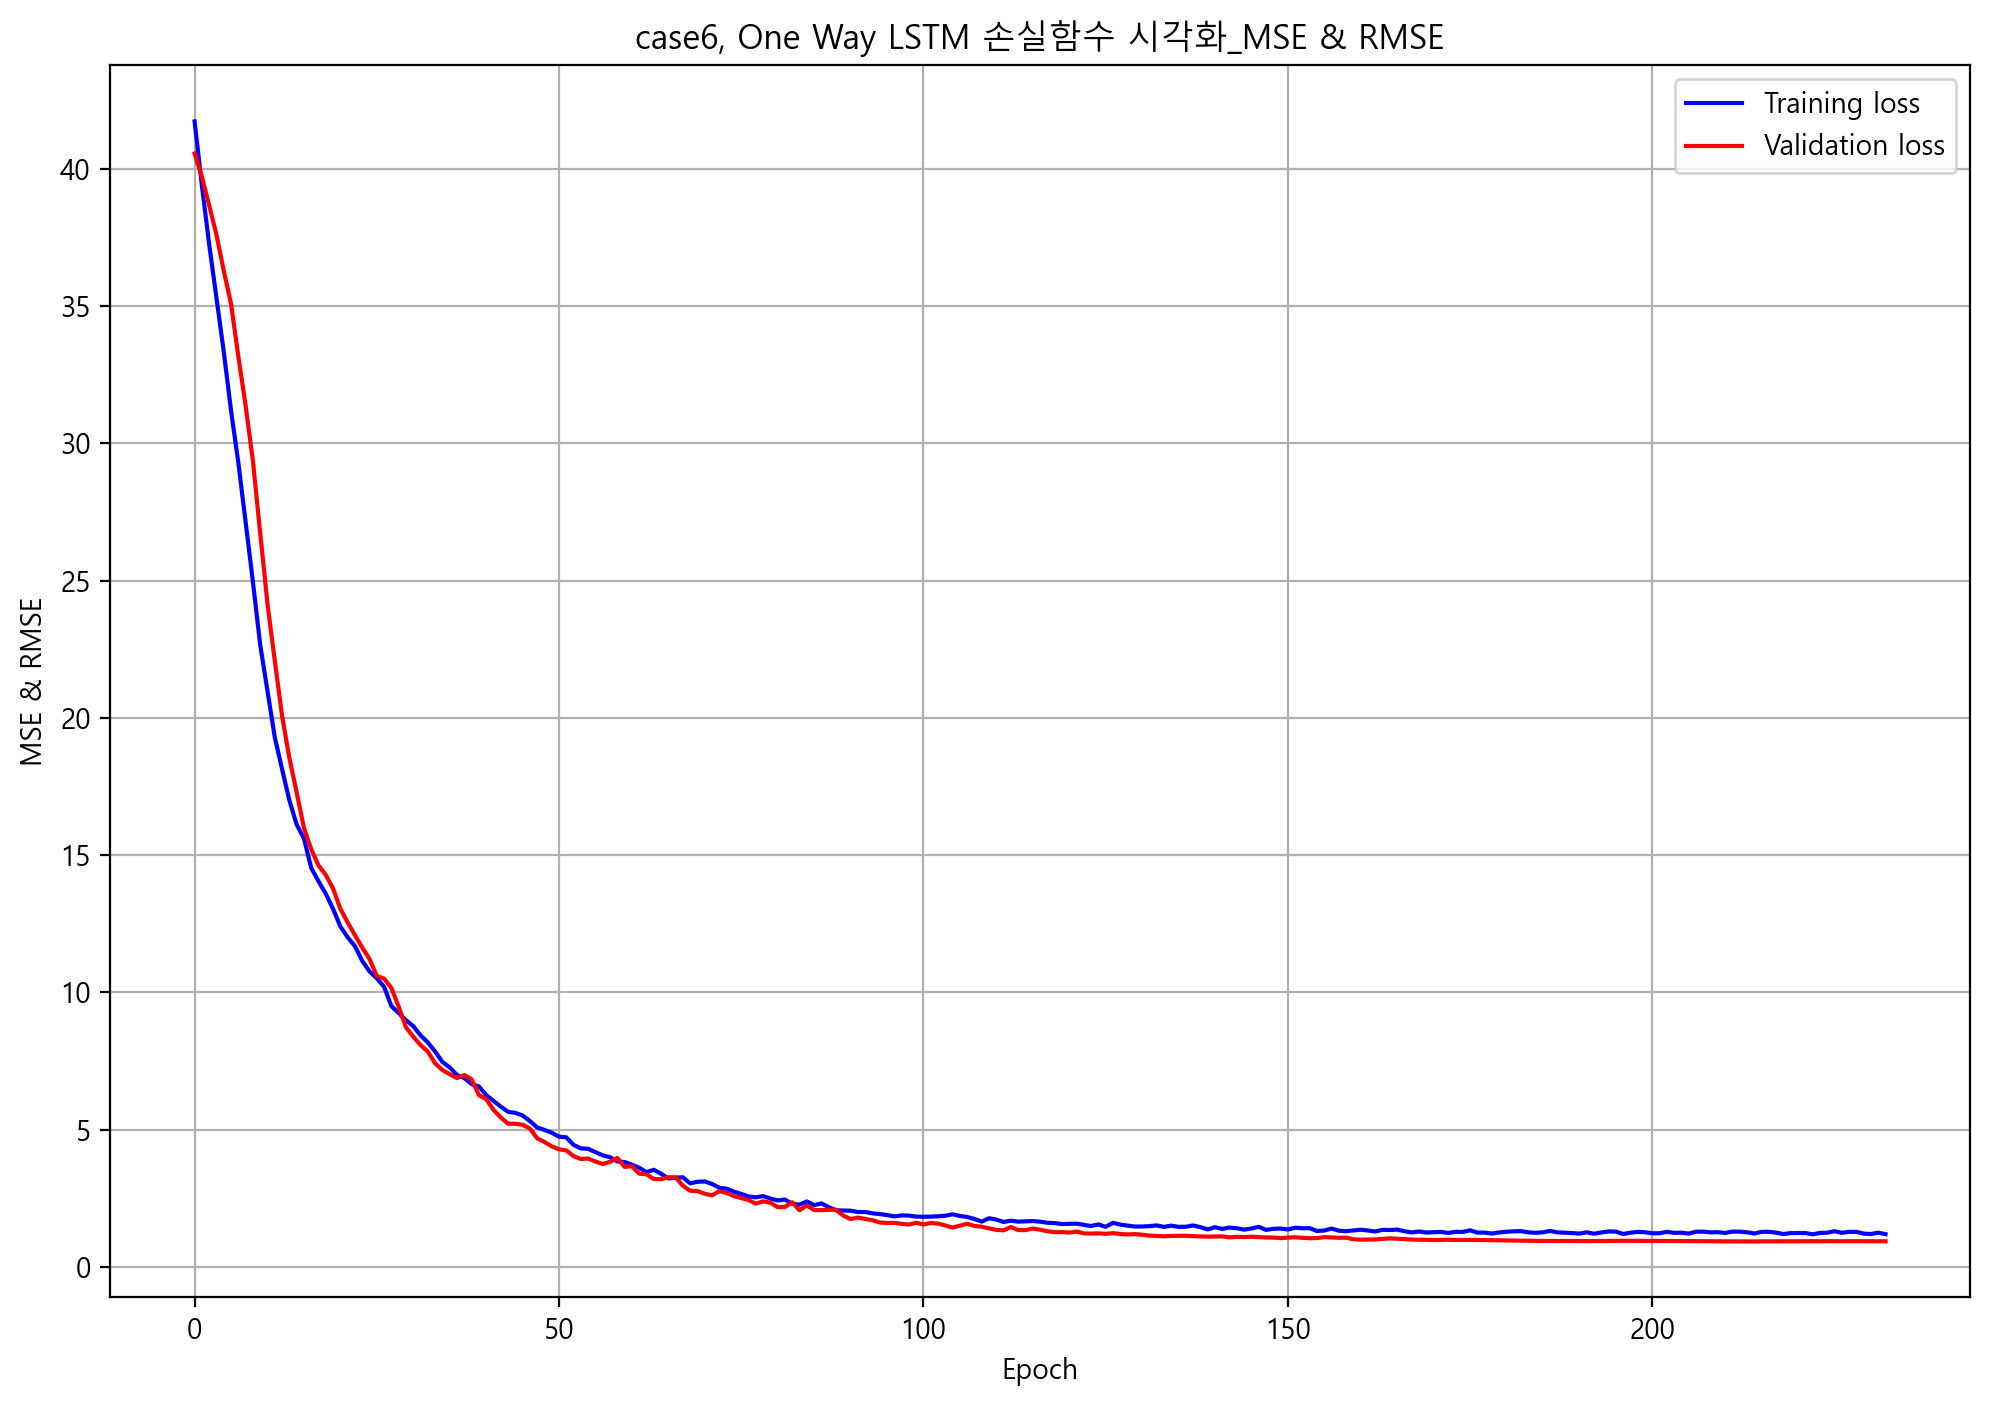

In [109]:
from tensorflow.keras.optimizers import legacy as legacy_optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization, Input, Embedding, Concatenate, Attention
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras import metrics

# Attention 레이어 정의
def attention_layer(inputs):
    attention = Attention()([inputs, inputs])
    return Concatenate()([inputs, attention])

# 옵티마이저 설정
initial_lr = 0.0005
optimizer = legacy_optimizers.Adam(learning_rate=initial_lr)

# 범주형 변수 설정
num_categories = 3
embedding_dim = 5

# 옵티마이저 및 콜백 설정
optimizer = Adam(learning_rate=initial_lr)
lr_restart = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# 모델 정의
numerical_input = Input(shape=(x_train_multi.shape[1], x_train_multi.shape[2]))
categorical_input = Input(shape=(x_train_label.shape[1], ))

# 임베딩 레이어
embedding = Embedding(input_dim=num_categories, output_dim=embedding_dim)(categorical_input)

# 입력 결합
combined_input = Concatenate(axis=-1)([numerical_input, embedding])

x = LSTM(128, return_sequences=True,
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(combined_input)
x = BatchNormalization()(x)
x = Dropout(0.3, seed = 40)(x)

x = LSTM(64, return_sequences=True,
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3, seed = 41)(x)

x = attention_layer(x)

x = LSTM(32, activation='relu',
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3, seed = 42)(x)

x = Dense(24, activation='relu')(x)
output = Dense(12)(x)

case6_uni_rmse = Model(inputs=[numerical_input, categorical_input], outputs=output)
case6_uni_rmse.compile(optimizer=optimizer
                       , loss="mse"
                       , metrics=[metrics.RootMeanSquaredError()]
                      )

# 모델 학습
case6_uni_rmse_history = case6_uni_rmse.fit(
    # 수치형 데이터와 범주형 데이터 분리    
    [x_train_multi, x_train_label],  
    y_train_multi,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    steps_per_epoch = x_train_multi.shape[0] // BATCH_SIZE, 
    validation_steps = x_val_multi.shape[0] // BATCH_SIZE,
    validation_data=([x_val_multi, x_val_label], y_val_multi),
    callbacks=[lr_restart, early_stop]
)

# 학습 결과 시각화
plot_train_history(case6_uni_rmse_history, "case6, One Way LSTM", "MSE & RMSE")

# 모델 저장
case6_uni_rmse.save("./output/case6/case6_uni_rmse.h5")

### 양방향 LSTM

Epoch 1/300
16/16 [==============================] - 6s 88ms/step - loss: 57.9870 - val_loss: 54.9037 - lr: 5.0000e-04
Epoch 2/300
16/16 [==============================] - 0s 17ms/step - loss: 51.8757 - val_loss: 49.1474 - lr: 5.0000e-04
Epoch 3/300
16/16 [==============================] - 0s 17ms/step - loss: 46.0347 - val_loss: 43.7179 - lr: 5.0000e-04
Epoch 4/300
16/16 [==============================] - 0s 17ms/step - loss: 40.6054 - val_loss: 38.6206 - lr: 5.0000e-04
Epoch 5/300
16/16 [==============================] - 0s 17ms/step - loss: 35.5249 - val_loss: 33.8723 - lr: 5.0000e-04
Epoch 6/300
16/16 [==============================] - 0s 17ms/step - loss: 30.8758 - val_loss: 29.4998 - lr: 5.0000e-04
Epoch 7/300
16/16 [==============================] - 0s 18ms/step - loss: 26.6108 - val_loss: 25.5483 - lr: 5.0000e-04
Epoch 8/300
16/16 [==============================] - 0s 17ms/step - loss: 22.8599 - val_loss: 22.1136 - lr: 5.0000e-04
Epoch 9/300
16/16 [=============================

16/16 [==============================] - 0s 18ms/step - loss: 2.4787 - val_loss: 2.2671 - lr: 5.0000e-04
Epoch 71/300
16/16 [==============================] - 0s 16ms/step - loss: 2.4271 - val_loss: 2.4647 - lr: 5.0000e-04
Epoch 72/300
16/16 [==============================] - 0s 16ms/step - loss: 2.4255 - val_loss: 2.3267 - lr: 5.0000e-04
Epoch 73/300
16/16 [==============================] - 0s 17ms/step - loss: 2.3304 - val_loss: 2.2756 - lr: 5.0000e-04
Epoch 74/300
16/16 [==============================] - 0s 17ms/step - loss: 2.3000 - val_loss: 2.1675 - lr: 5.0000e-04
Epoch 75/300
16/16 [==============================] - 0s 17ms/step - loss: 2.2849 - val_loss: 2.0480 - lr: 5.0000e-04
Epoch 76/300
16/16 [==============================] - 0s 17ms/step - loss: 2.2383 - val_loss: 2.1526 - lr: 5.0000e-04
Epoch 77/300
16/16 [==============================] - 0s 17ms/step - loss: 2.2286 - val_loss: 2.0936 - lr: 5.0000e-04
Epoch 78/300
16/16 [==============================] - 0s 17ms/step - 

16/16 [==============================] - 0s 17ms/step - loss: 1.3833 - val_loss: 1.3418 - lr: 1.2500e-04
Epoch 137/300
16/16 [==============================] - 0s 17ms/step - loss: 1.3765 - val_loss: 1.3153 - lr: 6.2500e-05
Epoch 138/300
16/16 [==============================] - 0s 16ms/step - loss: 1.4006 - val_loss: 1.2896 - lr: 6.2500e-05
Epoch 139/300
16/16 [==============================] - 0s 16ms/step - loss: 1.4185 - val_loss: 1.1537 - lr: 6.2500e-05
Epoch 140/300
16/16 [==============================] - 0s 16ms/step - loss: 1.3373 - val_loss: 1.2390 - lr: 6.2500e-05
Epoch 141/300
16/16 [==============================] - 0s 17ms/step - loss: 1.4161 - val_loss: 1.1387 - lr: 6.2500e-05
Epoch 142/300
16/16 [==============================] - 0s 17ms/step - loss: 1.3631 - val_loss: 1.1376 - lr: 6.2500e-05
Epoch 143/300
16/16 [==============================] - 0s 17ms/step - loss: 1.3549 - val_loss: 1.1358 - lr: 6.2500e-05
Epoch 144/300
16/16 [==============================] - 0s 17ms

Epoch 199/300
16/16 [==============================] - 0s 17ms/step - loss: 1.2725 - val_loss: 1.0601 - lr: 1.9531e-06
Epoch 200/300
16/16 [==============================] - 0s 17ms/step - loss: 1.2773 - val_loss: 1.0601 - lr: 1.9531e-06
Epoch 201/300
13/16 [=======================>......] - ETA: 0s - loss: 1.2590
Epoch 201: ReduceLROnPlateau reducing learning rate to 1e-06.
16/16 [==============================] - 0s 16ms/step - loss: 1.2658 - val_loss: 1.0592 - lr: 1.9531e-06
Epoch 202/300
16/16 [==============================] - 0s 17ms/step - loss: 1.2874 - val_loss: 1.0545 - lr: 1.0000e-06
Epoch 203/300
16/16 [==============================] - 0s 17ms/step - loss: 1.3076 - val_loss: 1.0599 - lr: 1.0000e-06
Epoch 204/300
16/16 [==============================] - 0s 17ms/step - loss: 1.2292 - val_loss: 1.0616 - lr: 1.0000e-06
Epoch 205/300
16/16 [==============================] - 0s 16ms/step - loss: 1.2673 - val_loss: 1.0589 - lr: 1.0000e-06
Epoch 206/300
16/16 [====================

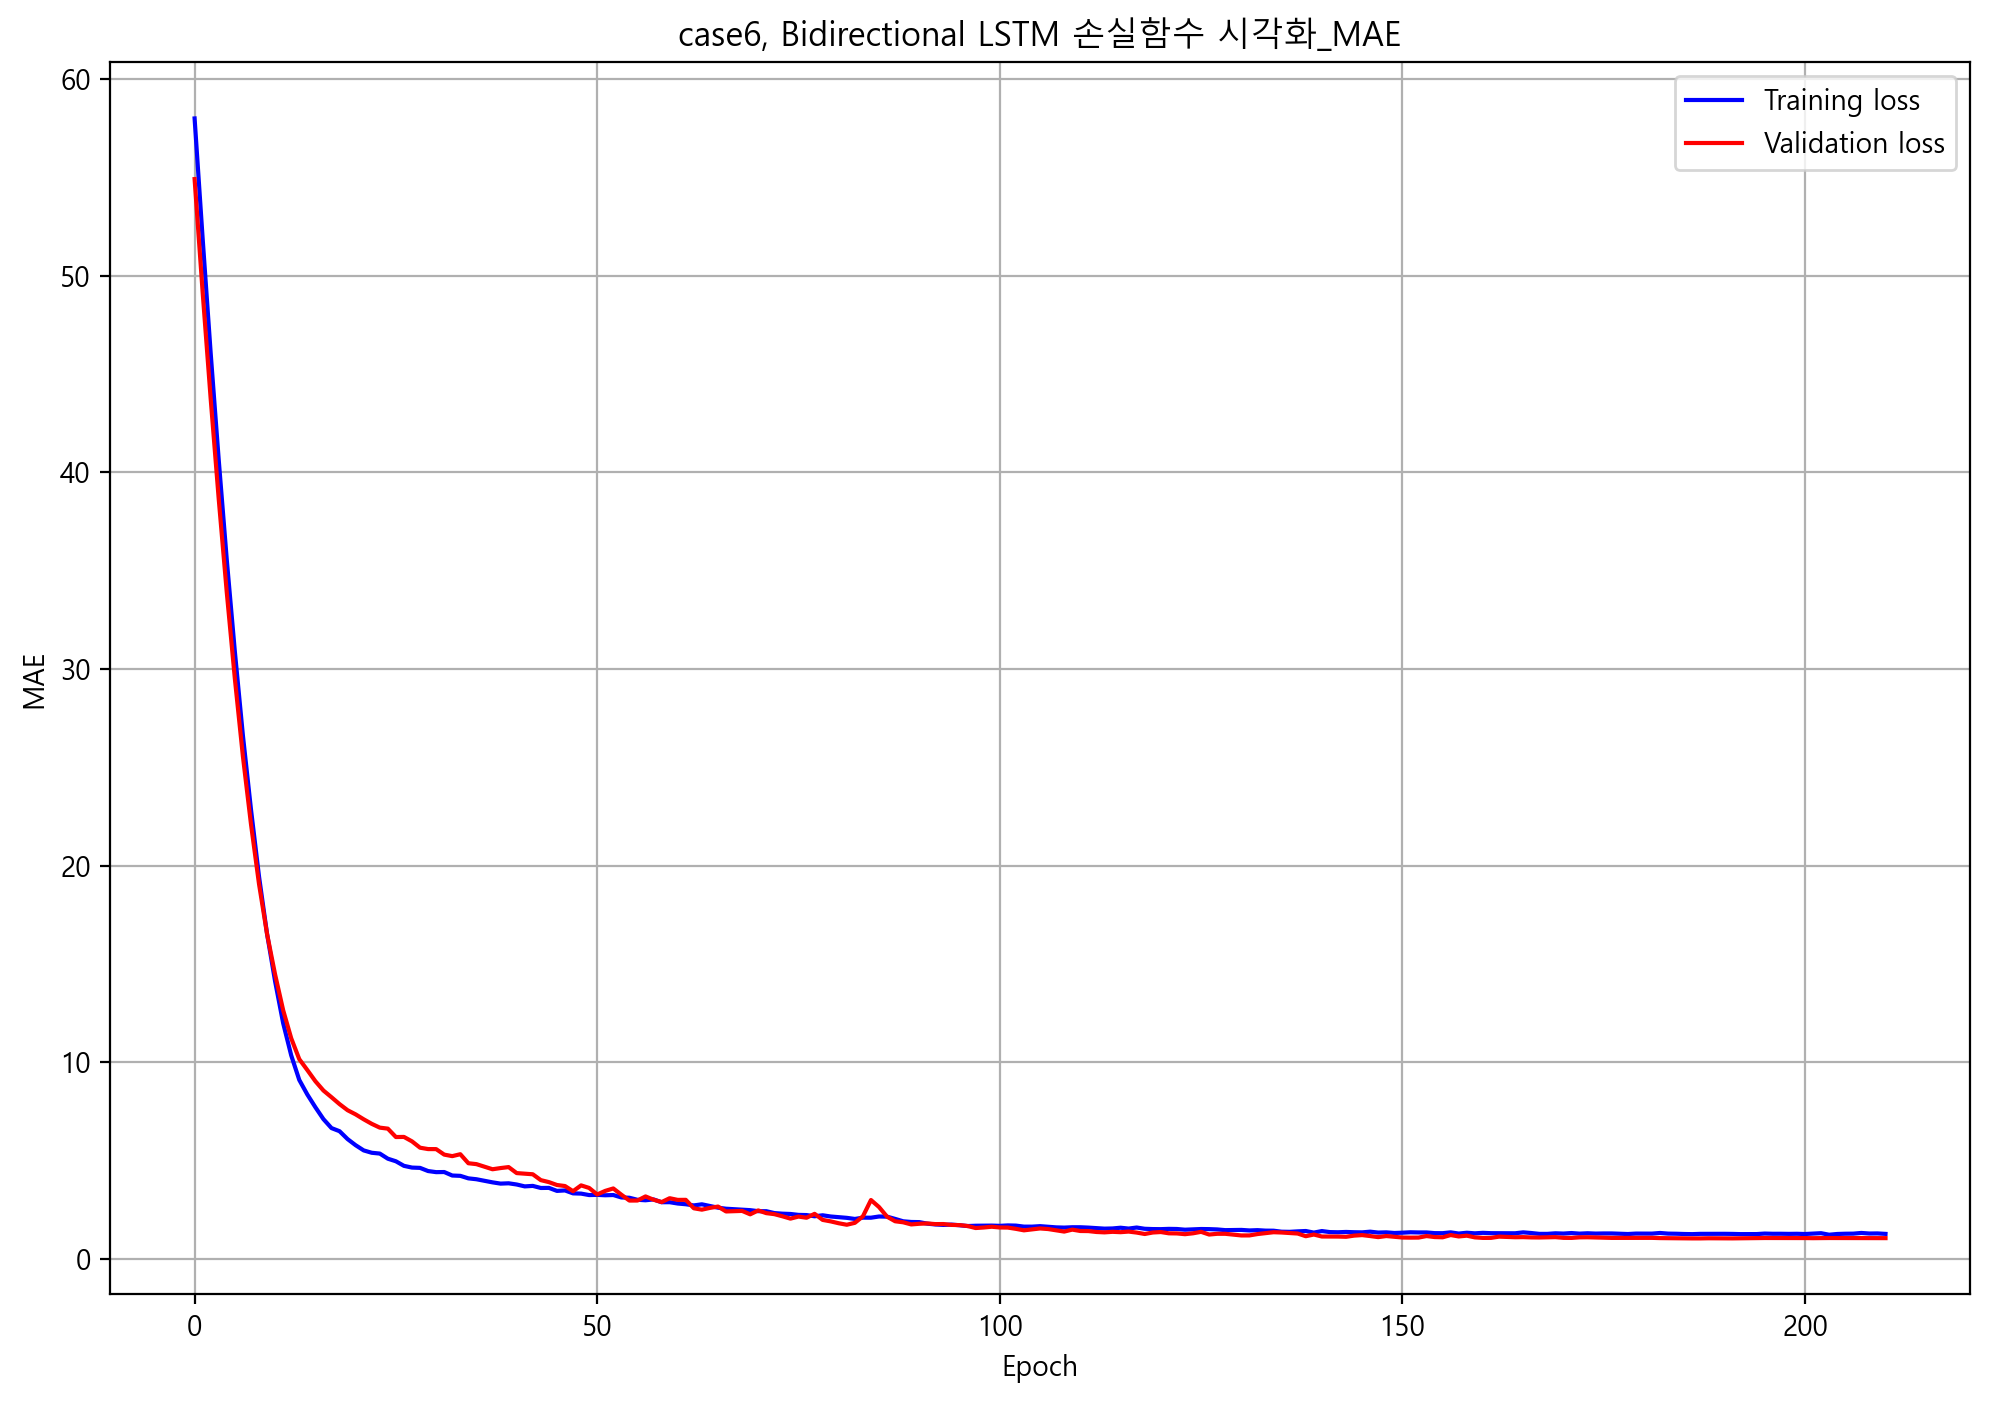

In [110]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization, Input, Embedding, Concatenate, Attention, Bidirectional
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import legacy as legacy_optimizers
from tensorflow.keras import metrics

# Attention 레이어 정의
def attention_layer(inputs):
    attention = Attention()([inputs, inputs])
    return Concatenate()([inputs, attention])

# 옵티마이저 설정
initial_lr = 0.0005
optimizer = legacy_optimizers.Adam(learning_rate=initial_lr)

# 범주형 변수 설정
num_categories = 3
embedding_dim = 5

# 옵티마이저 및 콜백 설정
optimizer = Adam(learning_rate=initial_lr)
lr_restart = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# 모델 정의
numerical_input = Input(shape=(x_train_multi.shape[1], x_train_multi.shape[2]))
categorical_input = Input(shape=(x_train_label.shape[1], ))

# 임베딩 레이어
embedding = Embedding(input_dim=num_categories, output_dim=embedding_dim)(categorical_input)

# 입력 결합
combined_input = Concatenate(axis=-1)([numerical_input, embedding])

x = Bidirectional(LSTM(128, return_sequences=True,
                   kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                   bias_regularizer=l1_l2(l1=0.005, l2=0.005)))(combined_input)
x = BatchNormalization()(x)
x = Dropout(0.3, seed = 40)(x)

x = Bidirectional(LSTM(64, return_sequences=True,
                   kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                   bias_regularizer=l1_l2(l1=0.005, l2=0.005)))(x)
x = BatchNormalization()(x)
x = Dropout(0.3, seed = 41)(x)

x = attention_layer(x)

x = LSTM(32, activation='relu',
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3, seed = 42)(x)

x = Dense(24, activation='relu')(x)
output = Dense(12)(x)

case6_bi_mae = Model(inputs=[numerical_input, categorical_input], outputs=output)

case6_bi_mae.compile(optimizer=optimizer, loss="mae")

# 모델 학습
case6_bi_mae_history = case6_bi_mae.fit(
    # 수치형 데이터와 범주형 데이터 분리    
    [x_train_multi, x_train_label],  
    y_train_multi,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    steps_per_epoch = x_train_multi.shape[0] // BATCH_SIZE, 
    validation_steps = x_val_multi.shape[0] // BATCH_SIZE,
    validation_data=([x_val_multi, x_val_label], y_val_multi),
    callbacks=[lr_restart, early_stop]
)

# 학습 결과 시각화
plot_train_history(case6_bi_mae_history, "case6, Bidirectional LSTM", "MAE")

# 모델 저장
case6_bi_mae.save("./output/case6/case6_bi_mae.h5")

Epoch 1/300
16/16 [==============================] - 6s 90ms/step - loss: 74.8560 - val_loss: 73.5507 - lr: 5.0000e-04
Epoch 2/300
16/16 [==============================] - 0s 18ms/step - loss: 71.1199 - val_loss: 71.0965 - lr: 5.0000e-04
Epoch 3/300
16/16 [==============================] - 0s 18ms/step - loss: 67.1040 - val_loss: 68.4779 - lr: 5.0000e-04
Epoch 4/300
16/16 [==============================] - 0s 18ms/step - loss: 63.2390 - val_loss: 65.7886 - lr: 5.0000e-04
Epoch 5/300
16/16 [==============================] - 0s 19ms/step - loss: 59.0849 - val_loss: 63.0611 - lr: 5.0000e-04
Epoch 6/300
16/16 [==============================] - 0s 18ms/step - loss: 54.9506 - val_loss: 60.2537 - lr: 5.0000e-04
Epoch 7/300
16/16 [==============================] - 0s 17ms/step - loss: 51.2395 - val_loss: 57.4894 - lr: 5.0000e-04
Epoch 8/300
16/16 [==============================] - 0s 18ms/step - loss: 47.7142 - val_loss: 55.0259 - lr: 5.0000e-04
Epoch 9/300
16/16 [=============================

Epoch 70/300
16/16 [==============================] - 0s 18ms/step - loss: 3.5021 - val_loss: 3.2595 - lr: 5.0000e-04
Epoch 71/300
16/16 [==============================] - 0s 18ms/step - loss: 3.4160 - val_loss: 3.4133 - lr: 5.0000e-04
Epoch 72/300
16/16 [==============================] - 0s 18ms/step - loss: 3.7004 - val_loss: 3.4266 - lr: 5.0000e-04
Epoch 73/300
16/16 [==============================] - 0s 17ms/step - loss: 3.5980 - val_loss: 3.3772 - lr: 5.0000e-04
Epoch 74/300
16/16 [==============================] - 0s 17ms/step - loss: 3.4337 - val_loss: 3.3410 - lr: 5.0000e-04
Epoch 75/300
13/16 [=======================>......] - ETA: 0s - loss: 3.2562
Epoch 75: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
16/16 [==============================] - 0s 18ms/step - loss: 3.3426 - val_loss: 3.3013 - lr: 5.0000e-04
Epoch 76/300
16/16 [==============================] - 0s 17ms/step - loss: 3.1866 - val_loss: 3.1891 - lr: 2.5000e-04
Epoch 77/300
16/16 [=============

Epoch 138/300
16/16 [==============================] - 0s 18ms/step - loss: 1.8823 - val_loss: 1.5441 - lr: 2.5000e-04
Epoch 139/300
16/16 [==============================] - 0s 18ms/step - loss: 1.7577 - val_loss: 1.5468 - lr: 2.5000e-04
Epoch 140/300
16/16 [==============================] - 0s 18ms/step - loss: 1.7493 - val_loss: 1.4490 - lr: 2.5000e-04
Epoch 141/300
16/16 [==============================] - 0s 19ms/step - loss: 1.7966 - val_loss: 1.4679 - lr: 2.5000e-04
Epoch 142/300
16/16 [==============================] - 0s 17ms/step - loss: 1.6891 - val_loss: 1.3996 - lr: 2.5000e-04
Epoch 143/300
16/16 [==============================] - 0s 18ms/step - loss: 1.7409 - val_loss: 1.4073 - lr: 2.5000e-04
Epoch 144/300
16/16 [==============================] - 0s 17ms/step - loss: 1.7027 - val_loss: 1.3774 - lr: 2.5000e-04
Epoch 145/300
16/16 [==============================] - 0s 18ms/step - loss: 1.7419 - val_loss: 1.4531 - lr: 2.5000e-04
Epoch 146/300
16/16 [===========================

16/16 [==============================] - 0s 18ms/step - loss: 1.3006 - val_loss: 0.9528 - lr: 6.2500e-05
Epoch 205/300
16/16 [==============================] - 0s 18ms/step - loss: 1.2640 - val_loss: 0.9637 - lr: 6.2500e-05
Epoch 206/300
16/16 [==============================] - 0s 17ms/step - loss: 1.2089 - val_loss: 0.9873 - lr: 6.2500e-05
Epoch 207/300
16/16 [==============================] - 0s 18ms/step - loss: 1.2332 - val_loss: 0.9603 - lr: 6.2500e-05
Epoch 208/300
16/16 [==============================] - 0s 18ms/step - loss: 1.2477 - val_loss: 0.9501 - lr: 6.2500e-05
Epoch 209/300
16/16 [==============================] - 0s 18ms/step - loss: 1.2127 - val_loss: 0.9284 - lr: 6.2500e-05
Epoch 210/300
16/16 [==============================] - 0s 18ms/step - loss: 1.2880 - val_loss: 0.9439 - lr: 6.2500e-05
Epoch 211/300
16/16 [==============================] - 0s 17ms/step - loss: 1.2042 - val_loss: 0.9499 - lr: 6.2500e-05
Epoch 212/300
16/16 [==============================] - 0s 18ms

Epoch 267/300
16/16 [==============================] - 0s 17ms/step - loss: 1.1384 - val_loss: 0.8711 - lr: 1.9531e-06
Epoch 268/300
16/16 [==============================] - 0s 18ms/step - loss: 1.1226 - val_loss: 0.8704 - lr: 1.9531e-06
Epoch 269/300
16/16 [==============================] - 0s 18ms/step - loss: 1.1281 - val_loss: 0.8693 - lr: 1.9531e-06
Epoch 270/300
13/16 [=======================>......] - ETA: 0s - loss: 1.1361
Epoch 270: ReduceLROnPlateau reducing learning rate to 1e-06.
16/16 [==============================] - 0s 18ms/step - loss: 1.1209 - val_loss: 0.8719 - lr: 1.9531e-06
Epoch 271/300
16/16 [==============================] - 0s 18ms/step - loss: 1.2451 - val_loss: 0.8745 - lr: 1.0000e-06
Epoch 272/300
16/16 [==============================] - 0s 18ms/step - loss: 1.1508 - val_loss: 0.8741 - lr: 1.0000e-06
Epoch 273/300
16/16 [==============================] - 0s 18ms/step - loss: 1.1563 - val_loss: 0.8743 - lr: 1.0000e-06
Epoch 274/300
16/16 [====================

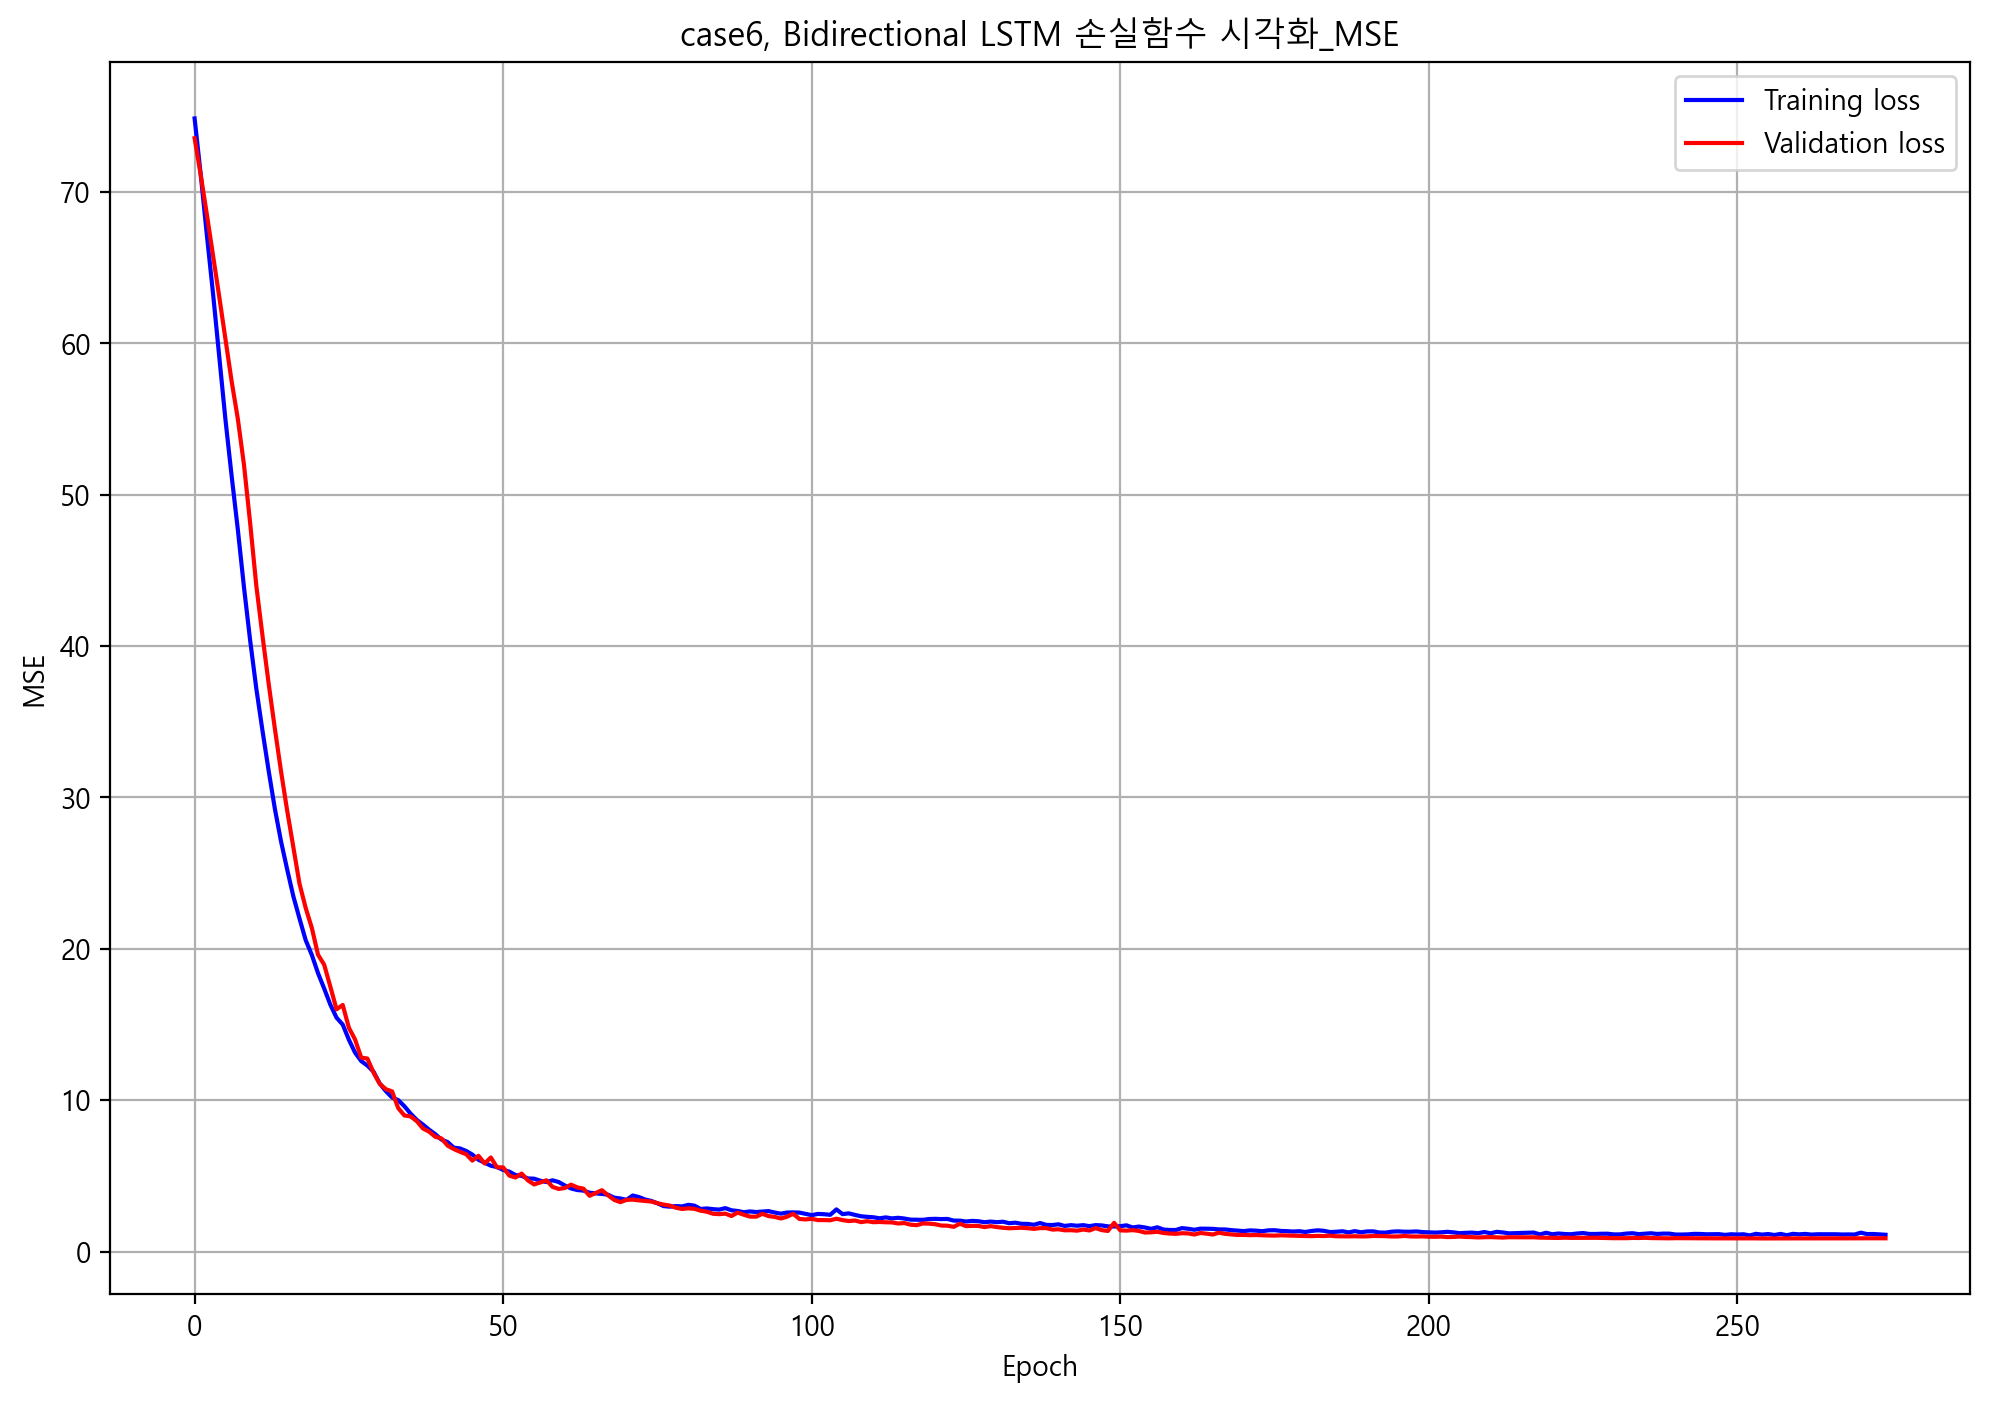

In [111]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization, Input, Embedding, Concatenate, Attention, Bidirectional
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import legacy as legacy_optimizers
from tensorflow.keras import metrics

# Attention 레이어 정의
def attention_layer(inputs):
    attention = Attention()([inputs, inputs])
    return Concatenate()([inputs, attention])

# 옵티마이저 설정
initial_lr = 0.0005
optimizer = legacy_optimizers.Adam(learning_rate=initial_lr)

# 범주형 변수 설정
num_categories = 3
embedding_dim = 5

# 옵티마이저 및 콜백 설정
optimizer = Adam(learning_rate=initial_lr)
lr_restart = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# 모델 정의
numerical_input = Input(shape=(x_train_multi.shape[1], x_train_multi.shape[2]))
categorical_input = Input(shape=(x_train_label.shape[1], ))

# 임베딩 레이어
embedding = Embedding(input_dim=num_categories, output_dim=embedding_dim)(categorical_input)

# 입력 결합
combined_input = Concatenate(axis=-1)([numerical_input, embedding])

x = Bidirectional(LSTM(128, return_sequences=True,
                   kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                   bias_regularizer=l1_l2(l1=0.005, l2=0.005)))(combined_input)
x = BatchNormalization()(x)
x = Dropout(0.3, seed = 40)(x)

x = Bidirectional(LSTM(64, return_sequences=True,
                   kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                   bias_regularizer=l1_l2(l1=0.005, l2=0.005)))(x)
x = BatchNormalization()(x)
x = Dropout(0.3, seed = 41)(x)

x = attention_layer(x)

x = LSTM(32, activation='relu',
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3, seed = 42)(x)

x = Dense(24, activation='relu')(x)
output = Dense(12)(x)

case6_bi_mse = Model(inputs=[numerical_input, categorical_input], outputs=output)

case6_bi_mse.compile(optimizer=optimizer, loss="mse")

# 모델 학습
case6_bi_mse_history = case6_bi_mse.fit(  
    [x_train_multi, x_train_label],  
    y_train_multi,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    steps_per_epoch = x_train_multi.shape[0] // BATCH_SIZE, 
    validation_steps = x_val_multi.shape[0] // BATCH_SIZE,
    validation_data=([x_val_multi, x_val_label], y_val_multi),
    callbacks=[lr_restart, early_stop]
)

# 학습 결과 시각화
plot_train_history(case6_bi_mse_history, "case6, Bidirectional LSTM", "MSE")

# 모델 저장
case6_bi_mse.save("./output/case6/case6_bi_mse.h5")

Epoch 1/300
16/16 [==============================] - 7s 91ms/step - loss: 73.2102 - root_mean_squared_error: 4.1873 - val_loss: 73.5030 - val_root_mean_squared_error: 4.3428 - lr: 5.0000e-04
Epoch 2/300
16/16 [==============================] - 0s 18ms/step - loss: 69.1750 - root_mean_squared_error: 3.9352 - val_loss: 70.8870 - val_root_mean_squared_error: 4.2781 - lr: 5.0000e-04
Epoch 3/300
16/16 [==============================] - 0s 18ms/step - loss: 65.2870 - root_mean_squared_error: 3.7013 - val_loss: 67.8271 - val_root_mean_squared_error: 4.1690 - lr: 5.0000e-04
Epoch 4/300
16/16 [==============================] - 0s 18ms/step - loss: 61.6700 - root_mean_squared_error: 3.4982 - val_loss: 64.8089 - val_root_mean_squared_error: 4.0655 - lr: 5.0000e-04
Epoch 5/300
16/16 [==============================] - 0s 18ms/step - loss: 57.7960 - root_mean_squared_error: 3.2462 - val_loss: 61.6270 - val_root_mean_squared_error: 3.9408 - lr: 5.0000e-04
Epoch 6/300
16/16 [==========================

Epoch 44/300
16/16 [==============================] - 0s 17ms/step - loss: 6.8941 - root_mean_squared_error: 0.8459 - val_loss: 7.2267 - val_root_mean_squared_error: 1.0760 - lr: 5.0000e-04
Epoch 45/300
16/16 [==============================] - 0s 18ms/step - loss: 6.6615 - root_mean_squared_error: 0.8204 - val_loss: 7.4645 - val_root_mean_squared_error: 1.2614 - lr: 5.0000e-04
Epoch 46/300
16/16 [==============================] - 0s 18ms/step - loss: 6.7091 - root_mean_squared_error: 0.9592 - val_loss: 7.2080 - val_root_mean_squared_error: 1.2218 - lr: 5.0000e-04
Epoch 47/300
16/16 [==============================] - 0s 18ms/step - loss: 6.3756 - root_mean_squared_error: 0.8808 - val_loss: 7.2379 - val_root_mean_squared_error: 1.3310 - lr: 5.0000e-04
Epoch 48/300
16/16 [==============================] - 0s 17ms/step - loss: 6.2100 - root_mean_squared_error: 0.9066 - val_loss: 6.3084 - val_root_mean_squared_error: 0.9985 - lr: 5.0000e-04
Epoch 49/300
16/16 [==============================

16/16 [==============================] - 0s 17ms/step - loss: 2.5142 - root_mean_squared_error: 0.6871 - val_loss: 2.9699 - val_root_mean_squared_error: 0.9644 - lr: 2.5000e-04
Epoch 87/300
16/16 [==============================] - 0s 17ms/step - loss: 2.5703 - root_mean_squared_error: 0.7312 - val_loss: 2.4581 - val_root_mean_squared_error: 0.6467 - lr: 2.5000e-04
Epoch 88/300
16/16 [==============================] - 0s 17ms/step - loss: 2.5829 - root_mean_squared_error: 0.7435 - val_loss: 2.4094 - val_root_mean_squared_error: 0.6101 - lr: 2.5000e-04
Epoch 89/300
16/16 [==============================] - 0s 17ms/step - loss: 2.5608 - root_mean_squared_error: 0.7166 - val_loss: 2.5879 - val_root_mean_squared_error: 0.7440 - lr: 2.5000e-04
Epoch 90/300
16/16 [==============================] - 0s 17ms/step - loss: 2.5240 - root_mean_squared_error: 0.7157 - val_loss: 2.5187 - val_root_mean_squared_error: 0.7206 - lr: 2.5000e-04
Epoch 91/300
16/16 [==============================] - 0s 17ms/s

16/16 [==============================] - 0s 17ms/step - loss: 1.9182 - root_mean_squared_error: 0.6811 - val_loss: 1.5624 - val_root_mean_squared_error: 0.3269 - lr: 6.2500e-05
Epoch 128/300
16/16 [==============================] - 0s 17ms/step - loss: 1.9098 - root_mean_squared_error: 0.6743 - val_loss: 1.5237 - val_root_mean_squared_error: 0.2631 - lr: 6.2500e-05
Epoch 129/300
16/16 [==============================] - 0s 18ms/step - loss: 1.8494 - root_mean_squared_error: 0.6311 - val_loss: 1.5294 - val_root_mean_squared_error: 0.2782 - lr: 6.2500e-05
Epoch 130/300
16/16 [==============================] - 0s 18ms/step - loss: 1.9035 - root_mean_squared_error: 0.6733 - val_loss: 1.5587 - val_root_mean_squared_error: 0.3343 - lr: 6.2500e-05
Epoch 131/300
16/16 [==============================] - 0s 19ms/step - loss: 1.8887 - root_mean_squared_error: 0.6652 - val_loss: 1.6002 - val_root_mean_squared_error: 0.3919 - lr: 6.2500e-05
Epoch 132/300
16/16 [==============================] - 0s 1

16/16 [==============================] - 0s 16ms/step - loss: 1.8491 - root_mean_squared_error: 0.7036 - val_loss: 1.4603 - val_root_mean_squared_error: 0.3263 - lr: 3.9063e-06
Epoch 167/300
13/16 [=======================>......] - ETA: 0s - loss: 1.7463 - root_mean_squared_error: 0.6266
Epoch 167: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.
16/16 [==============================] - 0s 16ms/step - loss: 1.7537 - root_mean_squared_error: 0.6325 - val_loss: 1.4589 - val_root_mean_squared_error: 0.3244 - lr: 3.9063e-06
Epoch 168/300
16/16 [==============================] - 0s 18ms/step - loss: 1.7190 - root_mean_squared_error: 0.6047 - val_loss: 1.4558 - val_root_mean_squared_error: 0.3207 - lr: 1.9531e-06
Epoch 169/300
16/16 [==============================] - 0s 21ms/step - loss: 1.7939 - root_mean_squared_error: 0.6642 - val_loss: 1.4536 - val_root_mean_squared_error: 0.3178 - lr: 1.9531e-06
Epoch 170/300
16/16 [==============================] - 0s 18ms/step - los

16/16 [==============================] - 0s 18ms/step - loss: 1.7735 - root_mean_squared_error: 0.6534 - val_loss: 1.4408 - val_root_mean_squared_error: 0.3070 - lr: 1.0000e-06
Epoch 208/300
16/16 [==============================] - 0s 19ms/step - loss: 1.7637 - root_mean_squared_error: 0.6460 - val_loss: 1.4404 - val_root_mean_squared_error: 0.3067 - lr: 1.0000e-06


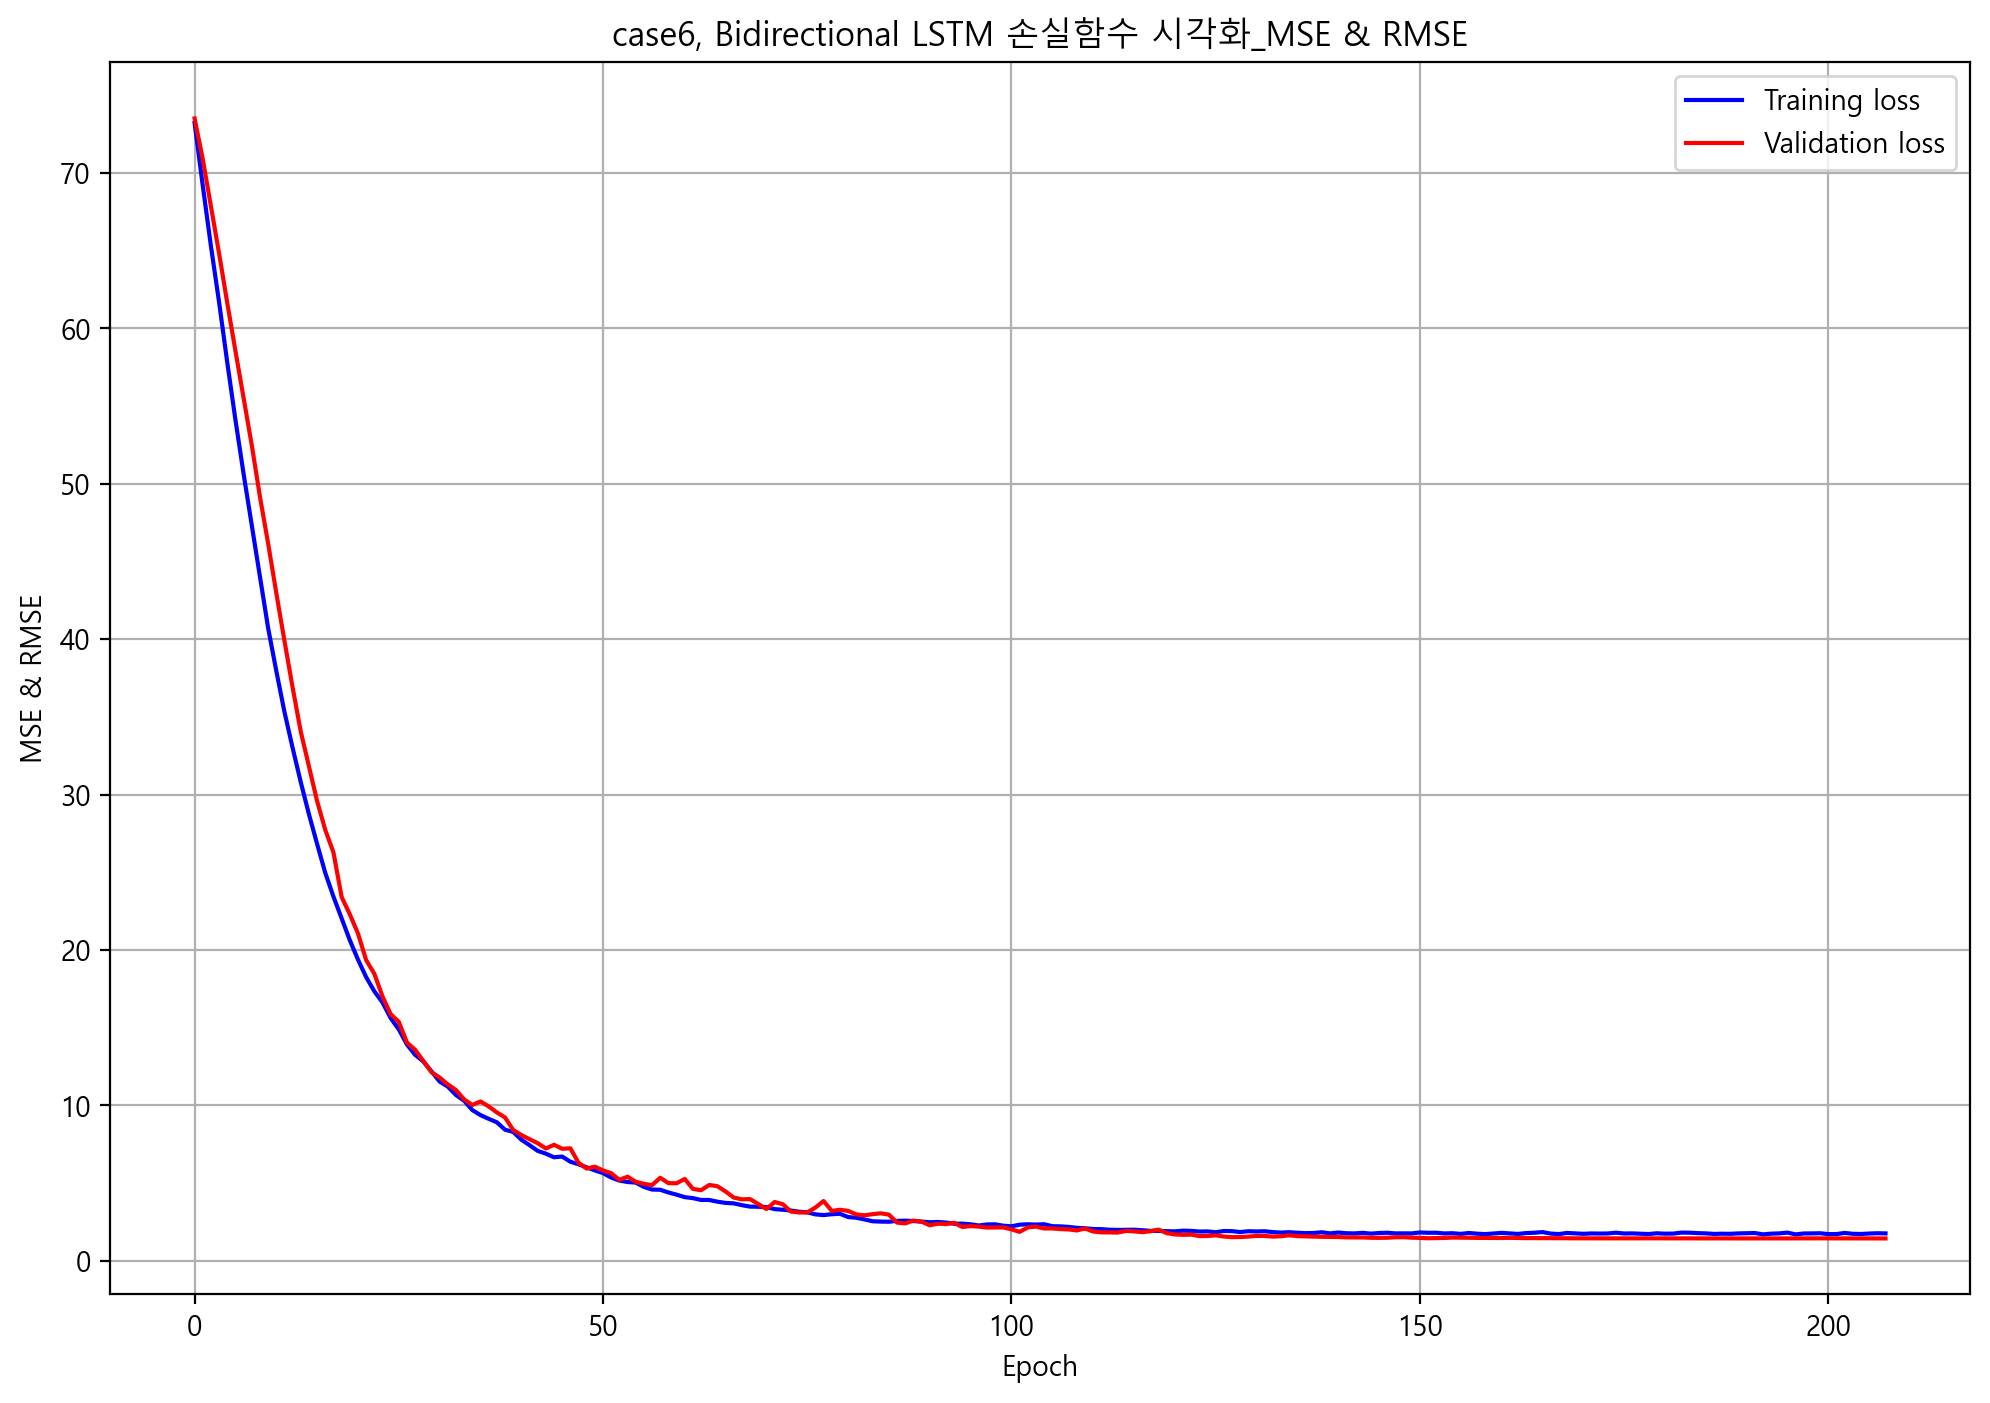

In [112]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization, Input, Embedding, Concatenate, Attention, Bidirectional
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import legacy as legacy_optimizers
from tensorflow.keras import metrics

# Attention 레이어 정의
def attention_layer(inputs):
    attention = Attention()([inputs, inputs])
    return Concatenate()([inputs, attention])

# 옵티마이저 설정
initial_lr = 0.0005
optimizer = legacy_optimizers.Adam(learning_rate=initial_lr)

# 범주형 변수 설정
num_categories = 3
embedding_dim = 5

# 옵티마이저 및 콜백 설정
optimizer = Adam(learning_rate=initial_lr)
lr_restart = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# 모델 정의
numerical_input = Input(shape=(x_train_multi.shape[1], x_train_multi.shape[2]))
categorical_input = Input(shape=(x_train_label.shape[1], ))

# 임베딩 레이어
embedding = Embedding(input_dim=num_categories, output_dim=embedding_dim)(categorical_input)

# 입력 결합
combined_input = Concatenate(axis=-1)([numerical_input, embedding])

x = Bidirectional(LSTM(128, return_sequences=True,
                   kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                   bias_regularizer=l1_l2(l1=0.005, l2=0.005)))(combined_input)
x = BatchNormalization()(x)
x = Dropout(0.3, seed = 40)(x)

x = Bidirectional(LSTM(64, return_sequences=True,
                   kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                   bias_regularizer=l1_l2(l1=0.005, l2=0.005)))(x)
x = BatchNormalization()(x)
x = Dropout(0.3, seed = 41)(x)

x = attention_layer(x)

x = LSTM(32, activation='relu',
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3, seed = 42)(x)

x = Dense(24, activation='relu')(x)
output = Dense(12)(x)

case6_bi_rmse = Model(inputs=[numerical_input, categorical_input], outputs=output)

case6_bi_rmse.compile(optimizer=optimizer
                       , loss="mse"
                       , metrics=[metrics.RootMeanSquaredError()]
                      )

# 모델 학습
case6_bi_rmse_history = case6_bi_rmse.fit( 
    [x_train_multi, x_train_label],  
    y_train_multi,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    steps_per_epoch = x_train_multi.shape[0] // BATCH_SIZE, 
    validation_steps = x_val_multi.shape[0] // BATCH_SIZE,
    validation_data=([x_val_multi, x_val_label], y_val_multi),
    callbacks=[lr_restart, early_stop]
)

# 학습 결과 시각화
plot_train_history(case6_bi_rmse_history, "case6, Bidirectional LSTM", "MSE & RMSE")

# 모델 저장
case6_bi_rmse.save("./output/case6/case6_bi_rmse.h5")

# 최종점검

## compare1: case1 & case2

### 모델 불러오기

In [113]:
# # case1
# case1_uni_mae = tf.keras.models.load_model("./output/case1/case1_uni_mae.h5")
# case1_uni_mse = tf.keras.models.load_model("./output/case1/case1_uni_mse.h5")
# case1_uni_rmse = tf.keras.models.load_model("./output/case1/case1_uni_rmse.h5")

# case1_bi_mae = tf.keras.models.load_model("./output/case1/case1_bi_mae.h5")
# case1_bi_mse = tf.keras.models.load_model("./output/case1/case1_bi_mse.h5")
# case1_bi_rmse = tf.keras.models.load_model("./output/case1/case1_bi_rmse.h5")

# # case2
# case2_uni_mae = tf.keras.models.load_model("./output/case2/case2_uni_mae.h5")
# case2_uni_mse = tf.keras.models.load_model("./output/case2/case2_uni_mse.h5")
# case2_uni_rmse = tf.keras.models.load_model("./output/case2/case2_uni_rmse.h5")

# case2_bi_mae = tf.keras.models.load_model("./output/case2/case2_bi_mae.h5")
# case2_bi_mse = tf.keras.models.load_model("./output/case2/case2_bi_mse.h5")
# case2_bi_rmse = tf.keras.models.load_model("./output/case2/case2_bi_rmse.h5")

### 검증데이터 구성

In [114]:
compare1 = data[['WTIO', 'SETIO', 'ONI', 'SOI', 'ENSO', 'D20_SCTR']]
compare1_dts = compare1.values

compare1_label = compare1_dts[ : , 4]
compare1_dts = compare1_dts[ : , [0, 1, 2, 3, 5]]

# 타겟 데이터
Y_compare1 = compare1_dts[388 : 400, -1]

# 학습데이터
X_compare1 = compare1_dts[376 : 388, :]
X_compare1_label = np.reshape(compare1_label[376 : 388], (1, 12))

## 표준화
X_compare1_std = (X_compare1 - case1_mean)/case1_std
X_compare1_std = np.reshape(X_compare1_std, (1, 12, 5))

## 로그 변환
X_compare1_log = np.sign(X_compare1) * np.log1p(np.abs(X_compare1))
X_compare1_log = np.reshape(X_compare1_log, (1, 12, 5))

### 예측값 생성

In [115]:
# Case1
Y_HAT_case1_uni_mae = case1_uni_mae.predict([X_compare1_std, X_compare1_label])
Y_HAT_case1_uni_mae = Y_HAT_case1_uni_mae * case1_std[-1] + case1_mean[-1]

Y_HAT_case1_uni_mse = case1_uni_mse.predict([X_compare1_std, X_compare1_label])
Y_HAT_case1_uni_mse = Y_HAT_case1_uni_mse * case1_std[-1] + case1_mean[-1]

Y_HAT_case1_uni_rmse = case1_uni_rmse.predict([X_compare1_std, X_compare1_label])
Y_HAT_case1_uni_rmse = Y_HAT_case1_uni_rmse * case1_std[-1] + case1_mean[-1]

Y_HAT_case1_bi_mae = case1_bi_mae.predict([X_compare1_std, X_compare1_label])
Y_HAT_case1_bi_mae = Y_HAT_case1_bi_mae * case1_std[-1] + case1_mean[-1]

Y_HAT_case1_bi_mse = case1_bi_mse.predict([X_compare1_std, X_compare1_label])
Y_HAT_case1_bi_mse = Y_HAT_case1_bi_mse * case1_std[-1] + case1_mean[-1]

Y_HAT_case1_bi_rmse = case1_bi_rmse.predict([X_compare1_std, X_compare1_label])
Y_HAT_case1_bi_rmse = Y_HAT_case1_bi_rmse * case1_std[-1] + case1_mean[-1]

1/1 [==============================] - 1s 1s/step


In [116]:
# Case2
Y_HAT_case2_uni_mae = case2_uni_mae.predict([X_compare1_log, X_compare1_label])
Y_HAT_case2_uni_mae = np.sign(Y_HAT_case2_uni_mae) * (np.expm1(np.abs(Y_HAT_case2_uni_mae)))

Y_HAT_case2_uni_mse = case2_uni_mse.predict([X_compare1_log, X_compare1_label])
Y_HAT_case2_uni_mse = np.sign(Y_HAT_case2_uni_mse) * (np.expm1(np.abs(Y_HAT_case2_uni_mse)))

Y_HAT_case2_uni_rmse = case2_uni_rmse.predict([X_compare1_log, X_compare1_label])
Y_HAT_case2_uni_rmse = np.sign(Y_HAT_case2_uni_rmse) * (np.expm1(np.abs(Y_HAT_case2_uni_rmse)))

Y_HAT_case2_bi_mae = case2_bi_mae.predict([X_compare1_log, X_compare1_label])
Y_HAT_case2_bi_mae = np.sign(Y_HAT_case2_bi_mae) * (np.expm1(np.abs(Y_HAT_case2_bi_mae)))

Y_HAT_case2_bi_mse = case2_bi_mse.predict([X_compare1_log, X_compare1_label])
Y_HAT_case2_bi_mse = np.sign(Y_HAT_case2_bi_mse) * (np.expm1(np.abs(Y_HAT_case2_bi_mse)))

Y_HAT_case2_bi_rmse = case2_bi_rmse.predict([X_compare1_log, X_compare1_label])
Y_HAT_case2_bi_rmse = np.sign(Y_HAT_case2_bi_rmse) * (np.expm1(np.abs(Y_HAT_case2_bi_rmse)))

1/1 [==============================] - 1s 1s/step


### 시각화

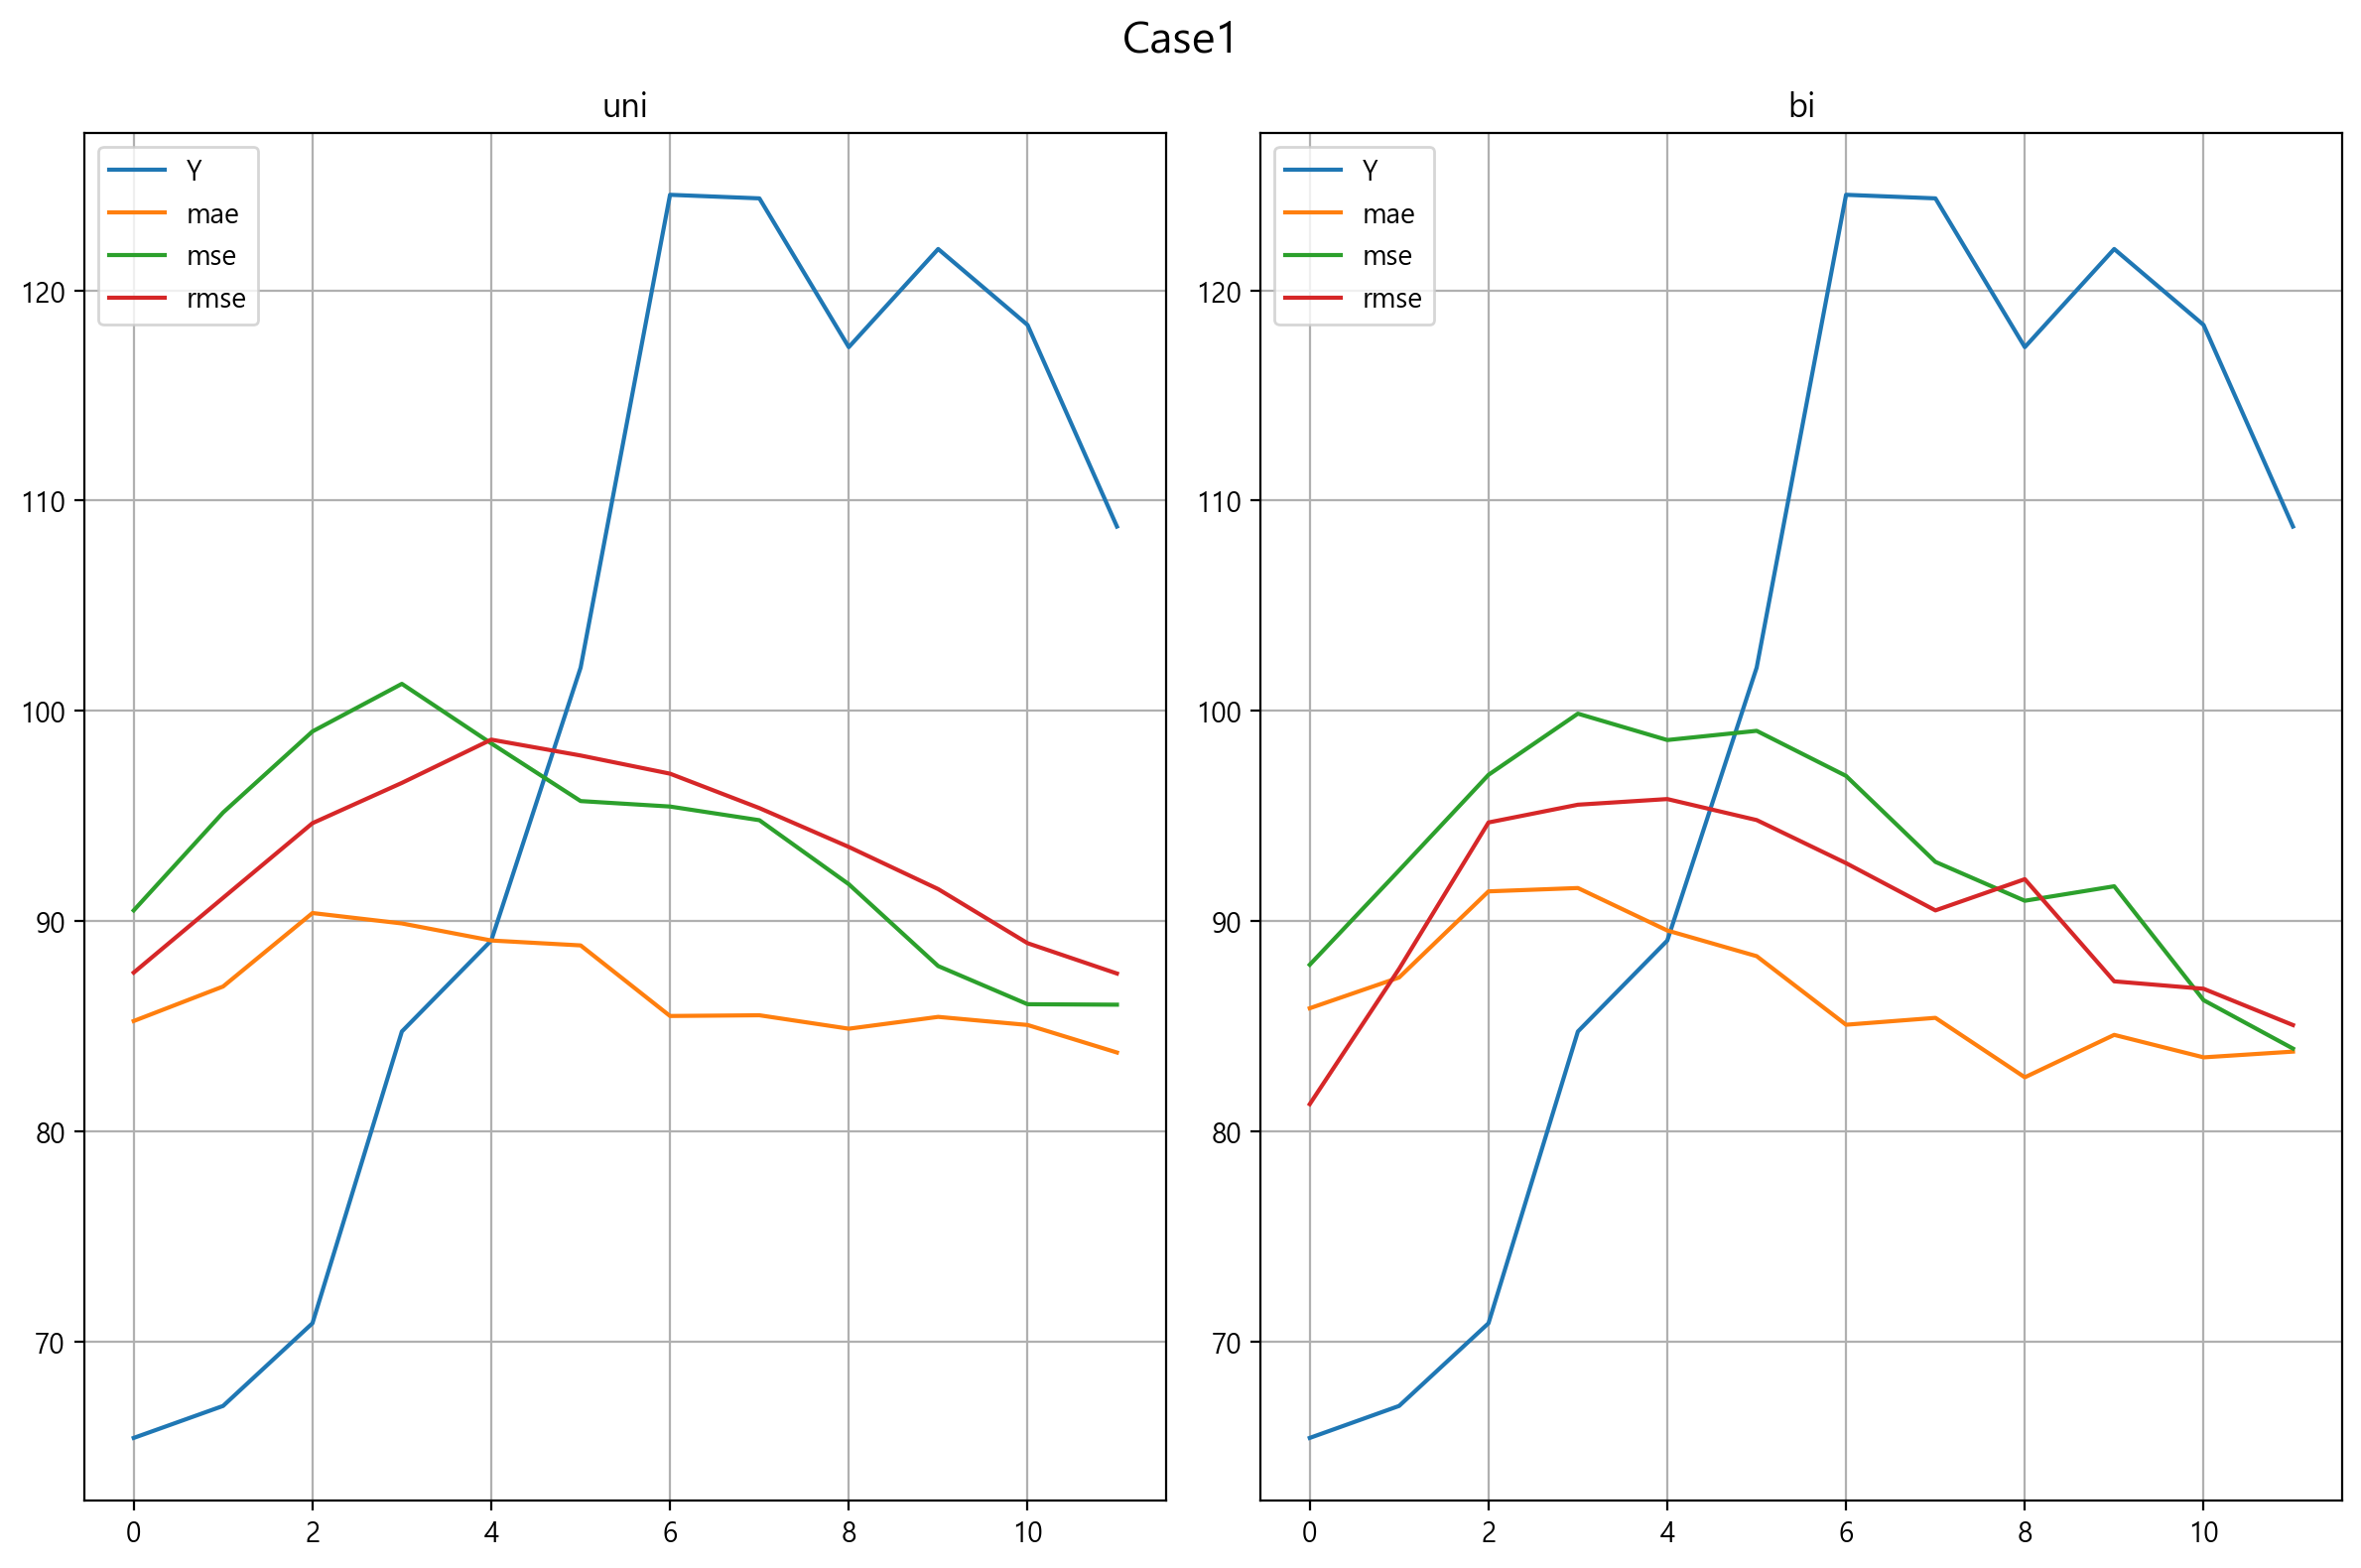

In [117]:
fig, ax = plt.subplots(1, 2, figsize=(12, 8))

ax[0].plot(Y_compare1, label="Y")
ax[0].plot(Y_HAT_case1_uni_mae[0], label="mae")
ax[0].plot(Y_HAT_case1_uni_mse[0], label="mse")
ax[0].plot(Y_HAT_case1_uni_rmse[0], label="rmse")
ax[0].set_title("uni", fontsize=12)
ax[0].grid()
ax[0].legend()

ax[1].plot(Y_compare1, label="Y")
ax[1].plot(Y_HAT_case1_bi_mae[0], label="mae")
ax[1].plot(Y_HAT_case1_bi_mse[0], label="mse")
ax[1].plot(Y_HAT_case1_bi_rmse[0], label="rmse")
ax[1].set_title("bi", fontsize=12)
ax[1].grid()
ax[1].legend()

plt.suptitle("Case1", fontsize=16)

plt.tight_layout()
plt.savefig(f'./output/case1_predict.png')

plt.show()

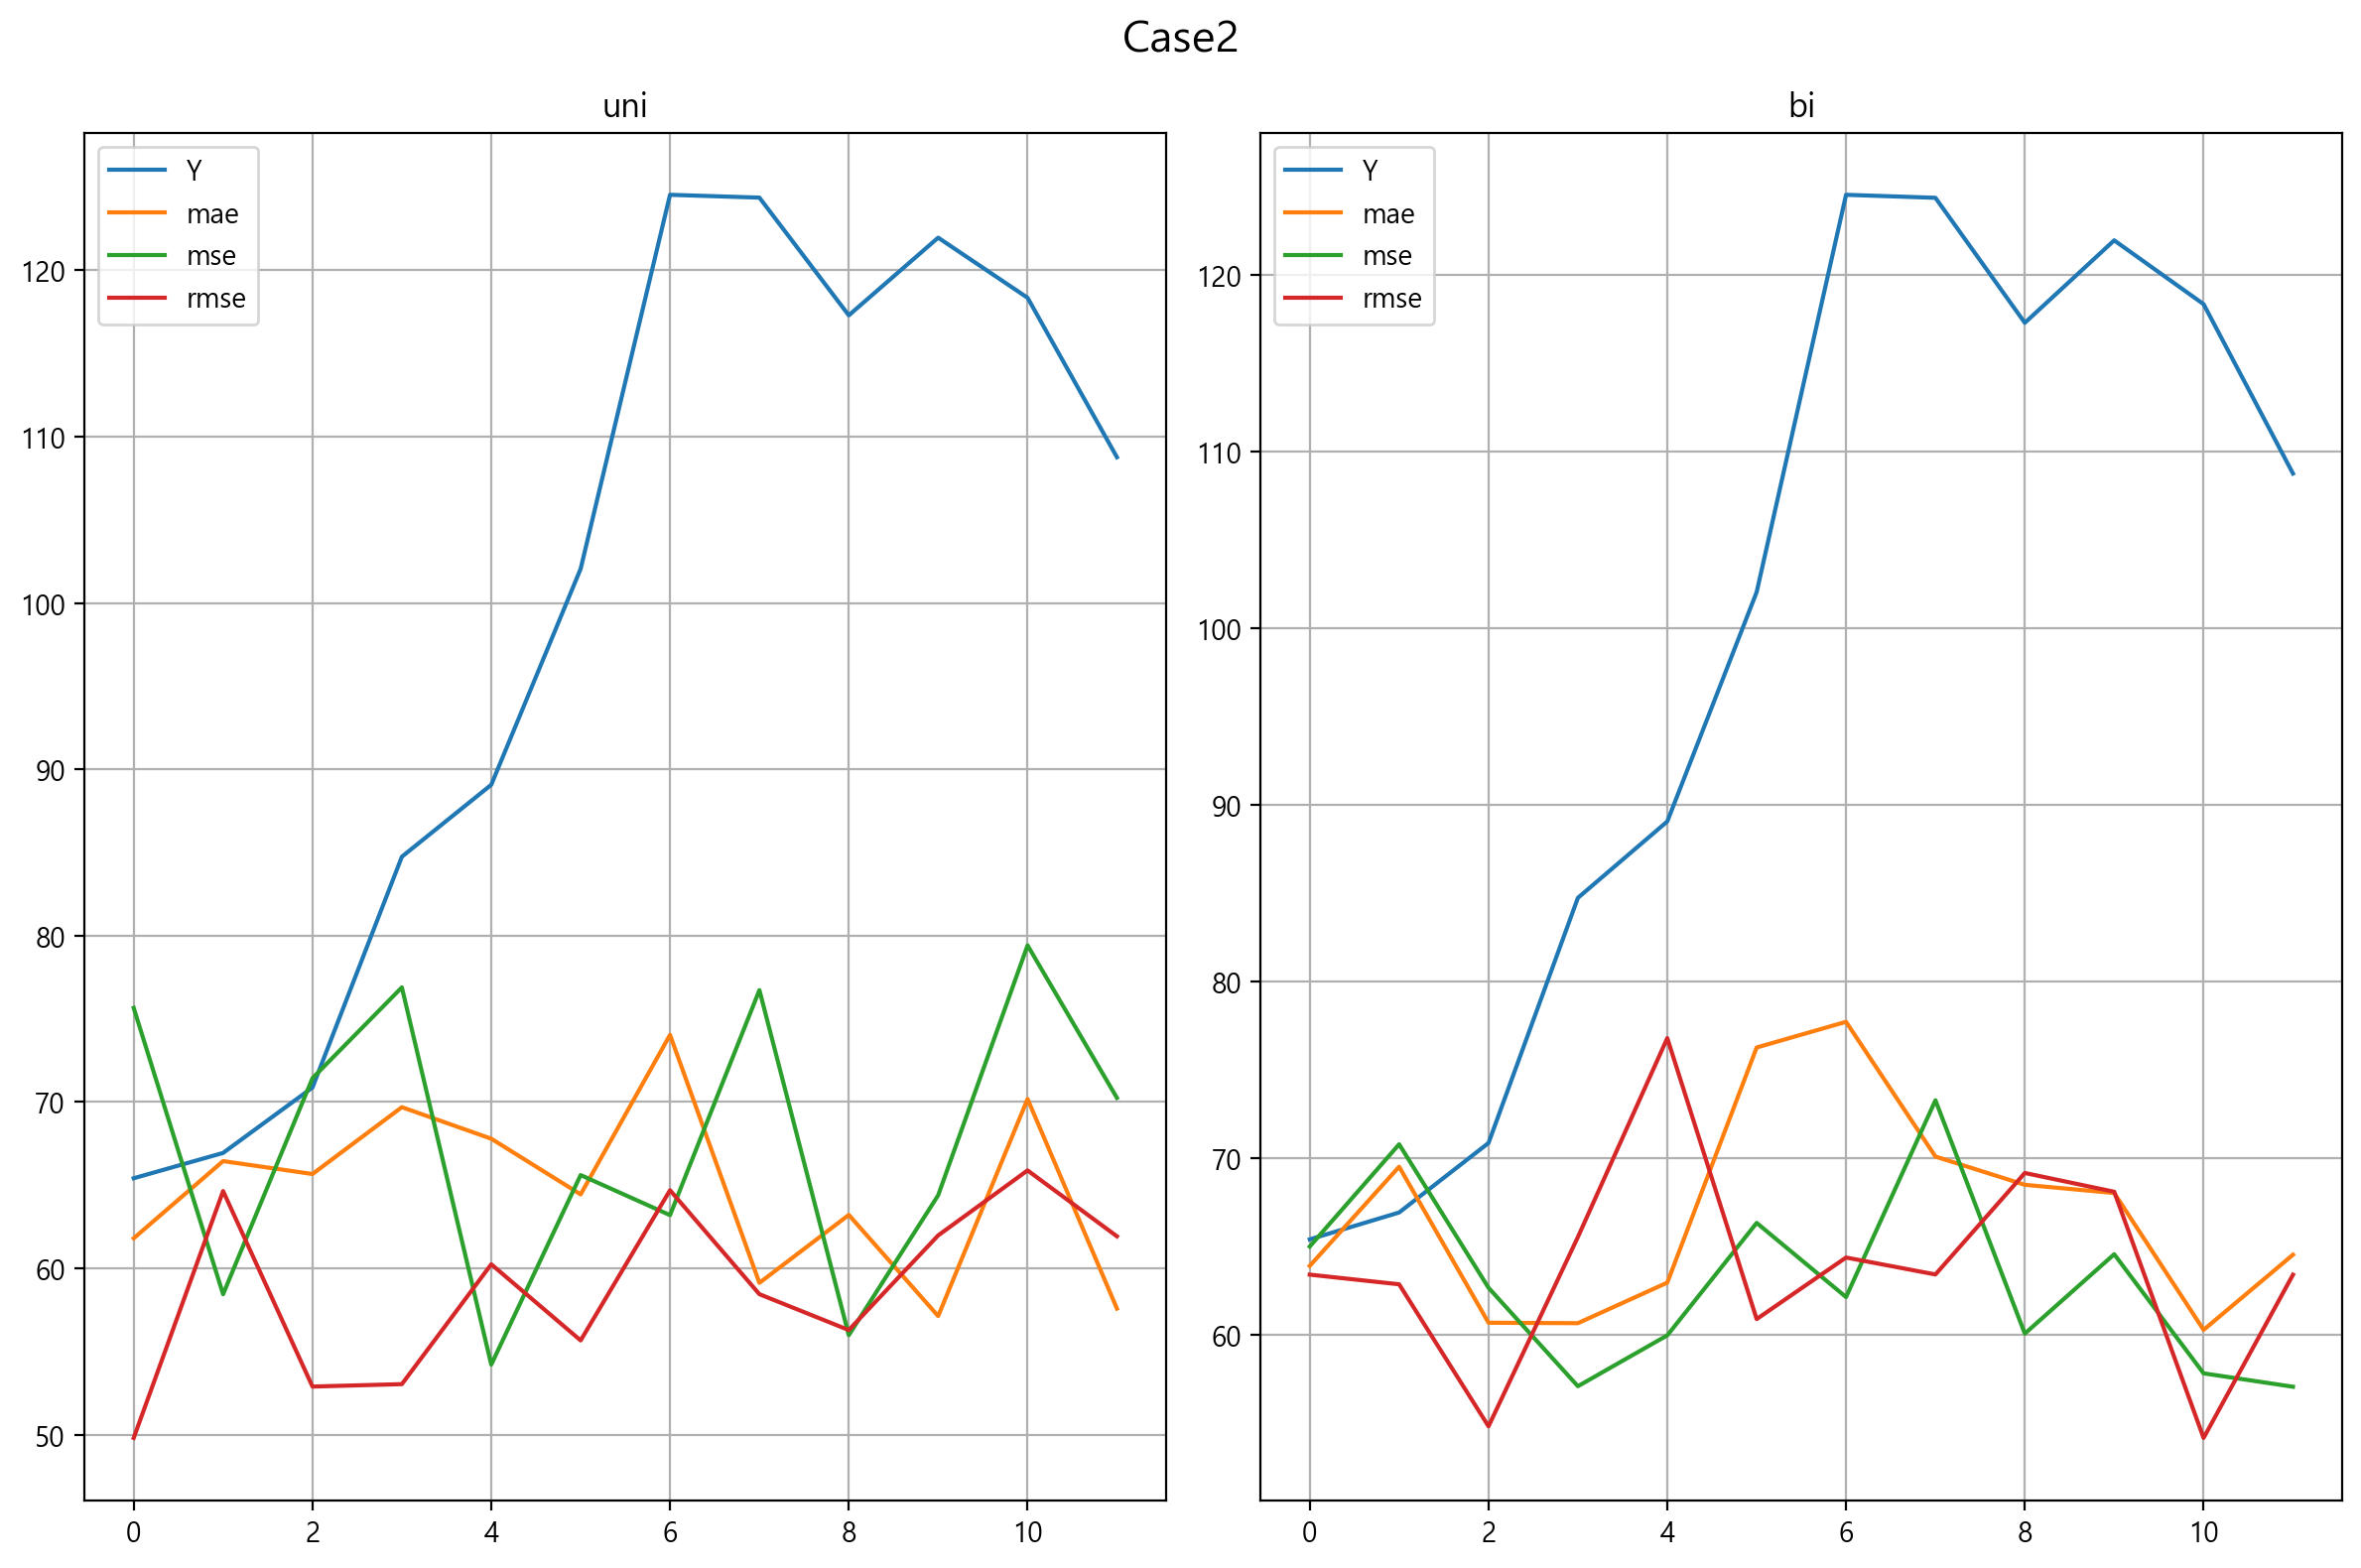

In [118]:
fig, ax = plt.subplots(1, 2, figsize=(12, 8))

ax[0].plot(Y_compare1, label="Y")
ax[0].plot(Y_HAT_case2_uni_mae[0], label="mae")
ax[0].plot(Y_HAT_case2_uni_mse[0], label="mse")
ax[0].plot(Y_HAT_case2_uni_rmse[0], label="rmse")
ax[0].set_title("uni", fontsize=12)
ax[0].grid()
ax[0].legend()

ax[1].plot(Y_compare1, label="Y")
ax[1].plot(Y_HAT_case2_bi_mae[0], label="mae")
ax[1].plot(Y_HAT_case2_bi_mse[0], label="mse")
ax[1].plot(Y_HAT_case2_bi_rmse[0], label="rmse")
ax[1].set_title("bi", fontsize=12)
ax[1].grid()
ax[1].legend()

plt.suptitle("Case2", fontsize=16)

plt.tight_layout()
plt.savefig(f'./output/case2_predict.png')

plt.show()

## compare2: case3 & case4

### 모델 불러오기

In [119]:
# # case3
# case3_uni_mae = tf.keras.models.load_model("./output/case3/case3_uni_mae.h5")
# case3_uni_mse = tf.keras.models.load_model("./output/case3/case3_uni_mse.h5")
# case3_uni_rmse = tf.keras.models.load_model("./output/case3/case3_uni_rmse.h5")

# case3_bi_mae = tf.keras.models.load_model("./output/case3/case3_bi_mae.h5")
# case3_bi_mse = tf.keras.models.load_model("./output/case3/case3_bi_mse.h5")
# case3_bi_rmse = tf.keras.models.load_model("./output/case3/case3_bi_rmse.h5")

# # case4
# case4_uni_mae = tf.keras.models.load_model("./output/case4/case4_uni_mae.h5")
# case4_uni_mse = tf.keras.models.load_model("./output/case4/case4_uni_mse.h5")
# case4_uni_rmse = tf.keras.models.load_model("./output/case4/case4_uni_rmse.h5")

# case4_bi_mae = tf.keras.models.load_model("./output/case4/case4_bi_mae.h5")
# case4_bi_mse = tf.keras.models.load_model("./output/case4/case4_bi_mse.h5")
# case4_bi_rmse = tf.keras.models.load_model("./output/case4/case4_bi_rmse.h5")

### 검증데이터 구성

In [120]:
compare2 = data[['DMI', 'ONI', 'SOI', 'ENSO', 'D20_SCTR']]
compare2_dts = compare2.values

compare2_label = compare2_dts[ : , 3]
compare2_dts = compare2_dts[ : , [0, 1, 2, 4]]

# 타겟 데이터
Y_compare2 = compare2_dts[388 : 400, -1]

# 학습데이터
X_compare2 = compare2_dts[376 : 388, :]
X_compare2_label = np.reshape(compare2_label[376 : 388], (1, 12))

## 표준화
X_compare2_std = (X_compare2 - case3_mean)/case3_std
X_compare2_std = np.reshape(X_compare2_std, (1, 12, 4))

## 로그 변환
X_compare2_log = np.sign(X_compare2) * np.log1p(np.abs(X_compare2))
X_compare2_log = np.reshape(X_compare2_log, (1, 12, 4))

### 예측값 생성

In [121]:
# Case3
Y_HAT_case3_uni_mae = case3_uni_mae.predict([X_compare2_std, X_compare2_label])
Y_HAT_case3_uni_mae = Y_HAT_case3_uni_mae * case3_std[-1] + case3_mean[-1]

Y_HAT_case3_uni_mse = case3_uni_mse.predict([X_compare2_std, X_compare2_label])
Y_HAT_case3_uni_mse = Y_HAT_case3_uni_mse * case3_std[-1] + case3_mean[-1]

Y_HAT_case3_uni_rmse = case3_uni_rmse.predict([X_compare2_std, X_compare2_label])
Y_HAT_case3_uni_rmse = Y_HAT_case3_uni_rmse * case3_std[-1] + case3_mean[-1]

Y_HAT_case3_bi_mae = case3_bi_mae.predict([X_compare2_std, X_compare2_label])
Y_HAT_case3_bi_mae = Y_HAT_case3_bi_mae * case3_std[-1] + case3_mean[-1]

Y_HAT_case3_bi_mse = case3_bi_mse.predict([X_compare2_std, X_compare2_label])
Y_HAT_case3_bi_mse = Y_HAT_case3_bi_mse * case3_std[-1] + case3_mean[-1]

Y_HAT_case3_bi_rmse = case3_bi_rmse.predict([X_compare2_std, X_compare2_label])
Y_HAT_case3_bi_rmse = Y_HAT_case3_bi_rmse * case3_std[-1] + case3_mean[-1]

1/1 [==============================] - 1s 989ms/step


In [122]:
# Case4
Y_HAT_case4_uni_mae = case4_uni_mae.predict([X_compare2_log, X_compare2_label])
Y_HAT_case4_uni_mae = np.sign(Y_HAT_case4_uni_mae) * (np.expm1(np.abs(Y_HAT_case4_uni_mae)))

Y_HAT_case4_uni_mse = case4_uni_mse.predict([X_compare2_log, X_compare2_label])
Y_HAT_case4_uni_mse = np.sign(Y_HAT_case4_uni_mse) * (np.expm1(np.abs(Y_HAT_case4_uni_mse)))

Y_HAT_case4_uni_rmse = case4_uni_rmse.predict([X_compare2_log, X_compare2_label])
Y_HAT_case4_uni_rmse = np.sign(Y_HAT_case4_uni_rmse) * (np.expm1(np.abs(Y_HAT_case4_uni_rmse)))

Y_HAT_case4_bi_mae = case4_bi_mae.predict([X_compare2_log, X_compare2_label])
Y_HAT_case4_bi_mae = np.sign(Y_HAT_case4_bi_mae) * (np.expm1(np.abs(Y_HAT_case4_bi_mae)))

Y_HAT_case4_bi_mse = case4_bi_mse.predict([X_compare2_log, X_compare2_label])
Y_HAT_case4_bi_mse = np.sign(Y_HAT_case4_bi_mse) * (np.expm1(np.abs(Y_HAT_case4_bi_mse)))

Y_HAT_case4_bi_rmse = case4_bi_rmse.predict([X_compare2_log, X_compare2_label])
Y_HAT_case4_bi_rmse = np.sign(Y_HAT_case4_bi_rmse) * (np.expm1(np.abs(Y_HAT_case4_bi_rmse)))

1/1 [==============================] - 1s 997ms/step


### 시각화

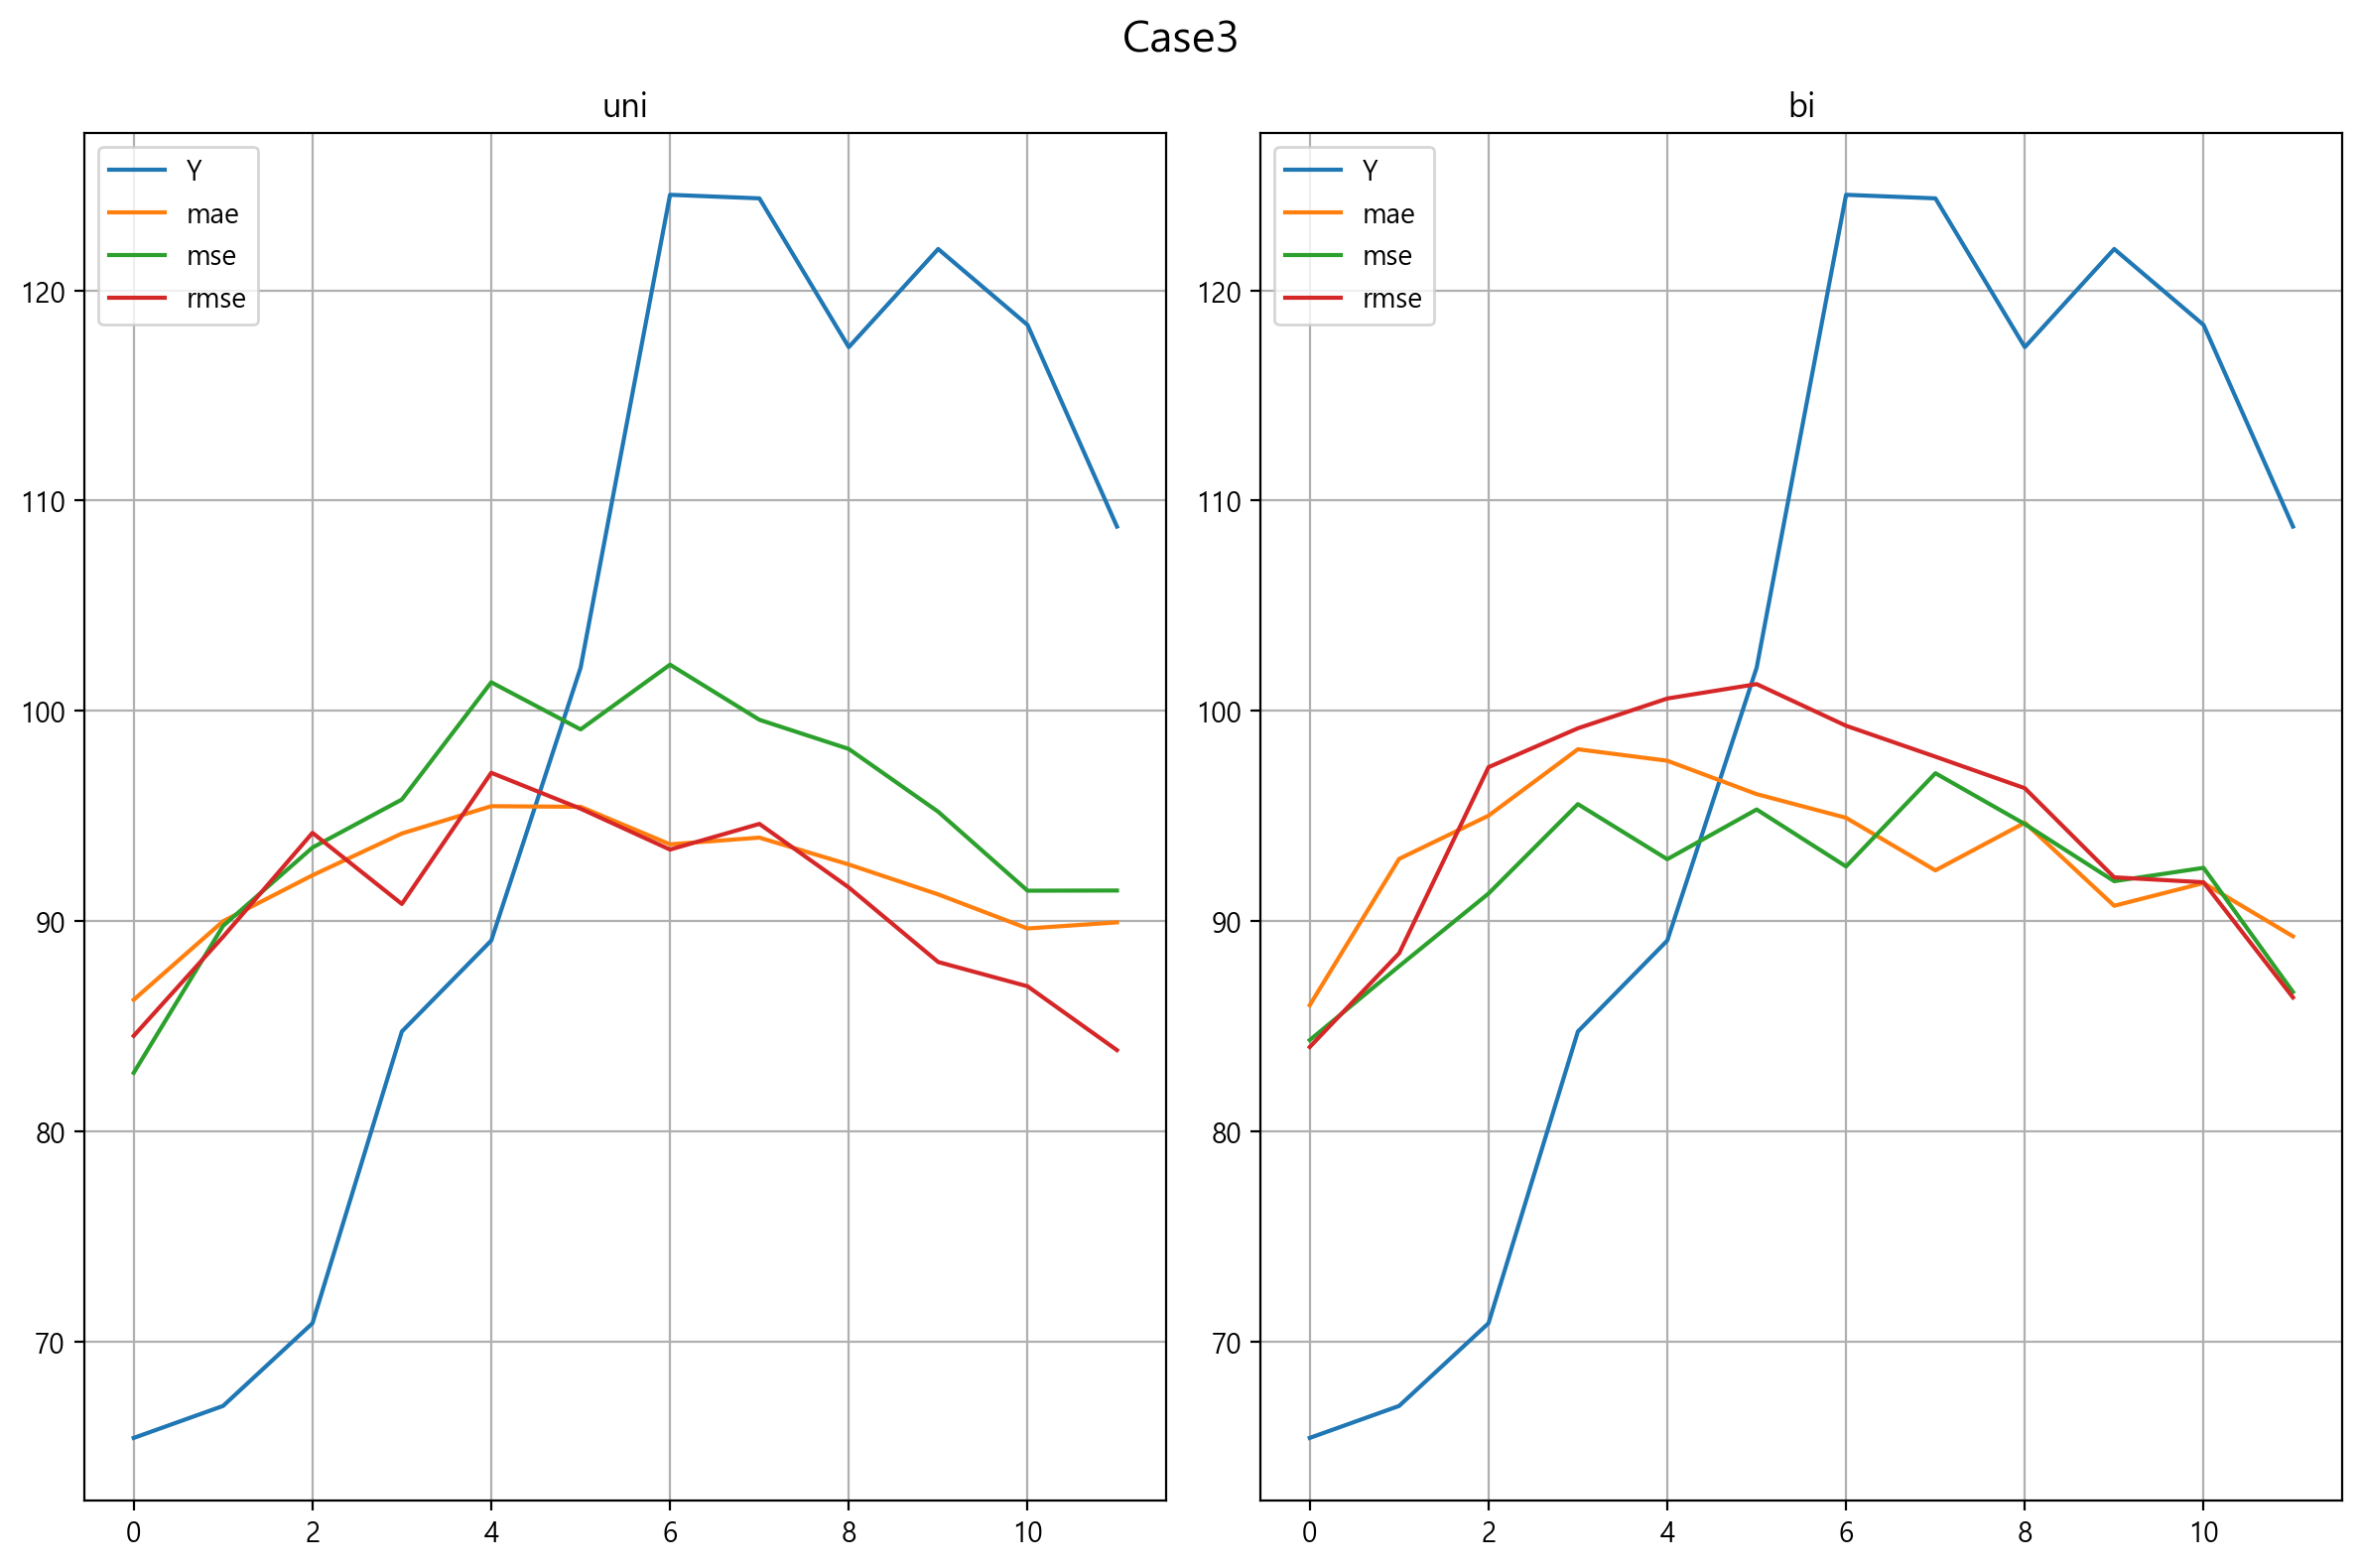

In [123]:
fig, ax = plt.subplots(1, 2, figsize=(12, 8))

ax[0].plot(Y_compare2, label="Y")
ax[0].plot(Y_HAT_case3_uni_mae[0], label="mae")
ax[0].plot(Y_HAT_case3_uni_mse[0], label="mse")
ax[0].plot(Y_HAT_case3_uni_rmse[0], label="rmse")
ax[0].set_title("uni", fontsize=12)
ax[0].grid()
ax[0].legend()

ax[1].plot(Y_compare2, label="Y")
ax[1].plot(Y_HAT_case3_bi_mae[0], label="mae")
ax[1].plot(Y_HAT_case3_bi_mse[0], label="mse")
ax[1].plot(Y_HAT_case3_bi_rmse[0], label="rmse")
ax[1].set_title("bi", fontsize=12)
ax[1].grid()
ax[1].legend()

plt.suptitle("Case3", fontsize=16)

plt.tight_layout()
plt.savefig(f'./output/case3_predict.png')

plt.show()

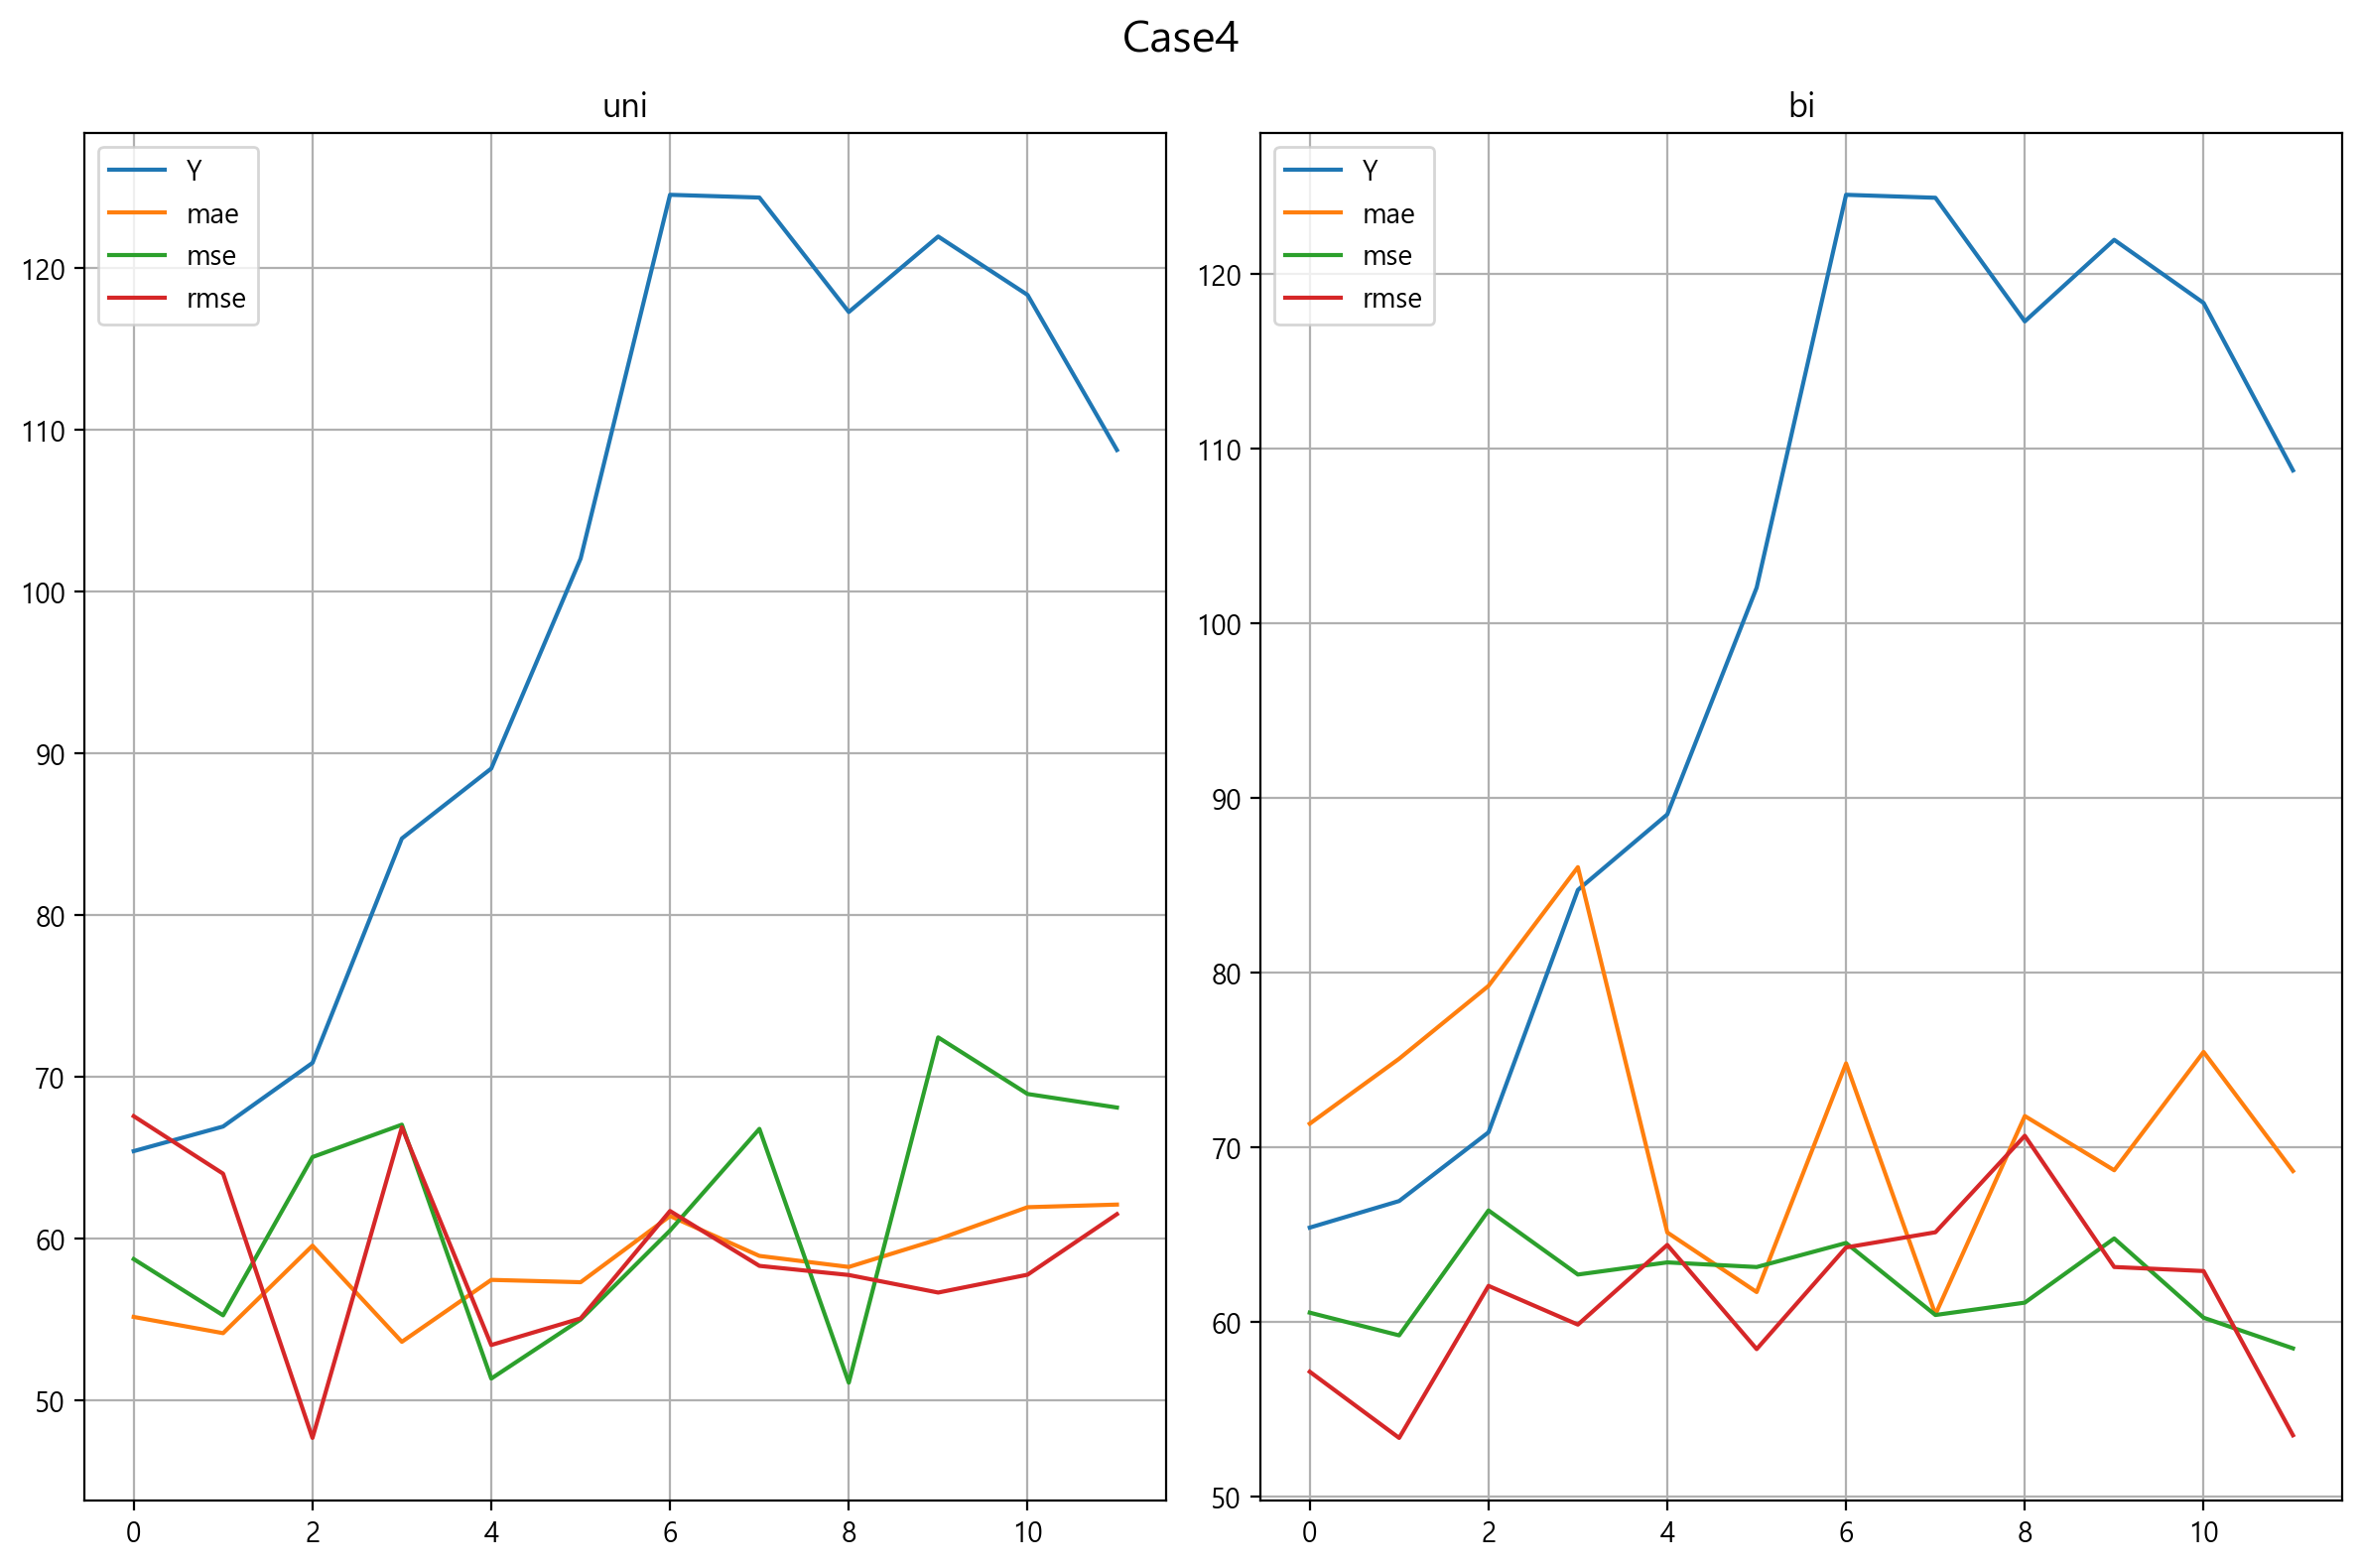

In [124]:
fig, ax = plt.subplots(1, 2, figsize=(12, 8))

ax[0].plot(Y_compare2, label="Y")
ax[0].plot(Y_HAT_case4_uni_mae[0], label="mae")
ax[0].plot(Y_HAT_case4_uni_mse[0], label="mse")
ax[0].plot(Y_HAT_case4_uni_rmse[0], label="rmse")
ax[0].set_title("uni", fontsize=12)
ax[0].grid()
ax[0].legend()

ax[1].plot(Y_compare2, label="Y")
ax[1].plot(Y_HAT_case4_bi_mae[0], label="mae")
ax[1].plot(Y_HAT_case4_bi_mse[0], label="mse")
ax[1].plot(Y_HAT_case4_bi_rmse[0], label="rmse")
ax[1].set_title("bi", fontsize=12)
ax[1].grid()
ax[1].legend()

plt.suptitle("Case4", fontsize=16)

plt.tight_layout()
plt.savefig(f'./output/case4_predict.png')

plt.show()

## compare3: case5 & case6

### 모델 불러오기

In [125]:
# # case5
# case5_uni_mae = tf.keras.models.load_model("./output/case5/case5_uni_mae.h5")
# case5_uni_mse = tf.keras.models.load_model("./output/case5/case5_uni_mse.h5")
# case5_uni_rmse = tf.keras.models.load_model("./output/case5/case5_uni_rmse.h5")

# case5_bi_mae = tf.keras.models.load_model("./output/case5/case5_bi_mae.h5")
# case5_bi_mse = tf.keras.models.load_model("./output/case5/case5_bi_mse.h5")
# case5_bi_rmse = tf.keras.models.load_model("./output/case5/case5_bi_rmse.h5")

# # case6
# case6_uni_mae = tf.keras.models.load_model("./output/case6/case6_uni_mae.h5")
# case6_uni_mse = tf.keras.models.load_model("./output/case6/case6_uni_mse.h5")
# case6_uni_rmse = tf.keras.models.load_model("./output/case6/case6_uni_rmse.h5")

# case6_bi_mae = tf.keras.models.load_model("./output/case6/case6_bi_mae.h5")
# case6_bi_mse = tf.keras.models.load_model("./output/case6/case6_bi_mse.h5")
# case6_bi_rmse = tf.keras.models.load_model("./output/case6/case6_bi_rmse.h5")

### 검증데이터 구성

In [126]:
compare3 = data[['WTIO', 'SETIO', 'DMI', 'ONI', 'SOI', 'ENSO', 'D20_SCTR']]
compare3_dts = compare3.values

compare3_label = compare3_dts[ : , 5]
compare3_dts = compare3_dts[ : , [0, 1, 2, 3, 4, 6]]

# 타겟 데이터
Y_compare3 = compare3_dts[388 : 400, -1]

# 학습데이터
X_compare3 = compare3_dts[376 : 388, :]
X_compare3_label = np.reshape(compare3_label[376 : 388], (1, 12))

## 표준화
X_compare3_std = (X_compare3 - case5_mean)/case5_std
X_compare3_std = np.reshape(X_compare3_std, (1, 12, 6))

## 로그 변환
X_compare3_log = np.sign(X_compare3) * np.log1p(np.abs(X_compare3))
X_compare3_log = np.reshape(X_compare3_log, (1, 12, 6))

### 예측값 생성

In [127]:
# Case5
Y_HAT_case5_uni_mae = case5_uni_mae.predict([X_compare3_std, X_compare3_label])
Y_HAT_case5_uni_mae = Y_HAT_case5_uni_mae * case5_std[-1] + case5_mean[-1]

Y_HAT_case5_uni_mse = case5_uni_mse.predict([X_compare3_std, X_compare3_label])
Y_HAT_case5_uni_mse = Y_HAT_case5_uni_mse * case5_std[-1] + case5_mean[-1]

Y_HAT_case5_uni_rmse = case5_uni_rmse.predict([X_compare3_std, X_compare3_label])
Y_HAT_case5_uni_rmse = Y_HAT_case5_uni_rmse * case5_std[-1] + case5_mean[-1]

Y_HAT_case5_bi_mae = case5_bi_mae.predict([X_compare3_std, X_compare3_label])
Y_HAT_case5_bi_mae = Y_HAT_case5_bi_mae * case5_std[-1] + case5_mean[-1]

Y_HAT_case5_bi_mse = case5_bi_mse.predict([X_compare3_std, X_compare3_label])
Y_HAT_case5_bi_mse = Y_HAT_case5_bi_mse * case5_std[-1] + case5_mean[-1]

Y_HAT_case5_bi_rmse = case5_bi_rmse.predict([X_compare3_std, X_compare3_label])
Y_HAT_case5_bi_rmse = Y_HAT_case5_bi_rmse * case5_std[-1] + case5_mean[-1]

1/1 [==============================] - 1s 1s/step


In [128]:
# Case6
Y_HAT_case6_uni_mae = case6_uni_mae.predict([X_compare3_log, X_compare3_label])
Y_HAT_case6_uni_mae = np.sign(Y_HAT_case6_uni_mae) * (np.expm1(np.abs(Y_HAT_case6_uni_mae)))

Y_HAT_case6_uni_mse = case6_uni_mse.predict([X_compare3_log, X_compare3_label])
Y_HAT_case6_uni_mse = np.sign(Y_HAT_case6_uni_mse) * (np.expm1(np.abs(Y_HAT_case6_uni_mse)))

Y_HAT_case6_uni_rmse = case6_uni_rmse.predict([X_compare3_log, X_compare3_label])
Y_HAT_case6_uni_rmse = np.sign(Y_HAT_case6_uni_rmse) * (np.expm1(np.abs(Y_HAT_case6_uni_rmse)))

Y_HAT_case6_bi_mae = case6_bi_mae.predict([X_compare3_log, X_compare3_label])
Y_HAT_case6_bi_mae = np.sign(Y_HAT_case6_bi_mae) * (np.expm1(np.abs(Y_HAT_case6_bi_mae)))

Y_HAT_case6_bi_mse = case6_bi_mse.predict([X_compare3_log, X_compare3_label])
Y_HAT_case6_bi_mse = np.sign(Y_HAT_case6_bi_mse) * (np.expm1(np.abs(Y_HAT_case6_bi_mse)))

Y_HAT_case6_bi_rmse = case6_bi_rmse.predict([X_compare3_log, X_compare3_label])
Y_HAT_case6_bi_rmse = np.sign(Y_HAT_case6_bi_rmse) * (np.expm1(np.abs(Y_HAT_case6_bi_rmse)))

1/1 [==============================] - 1s 1s/step


### 시각화

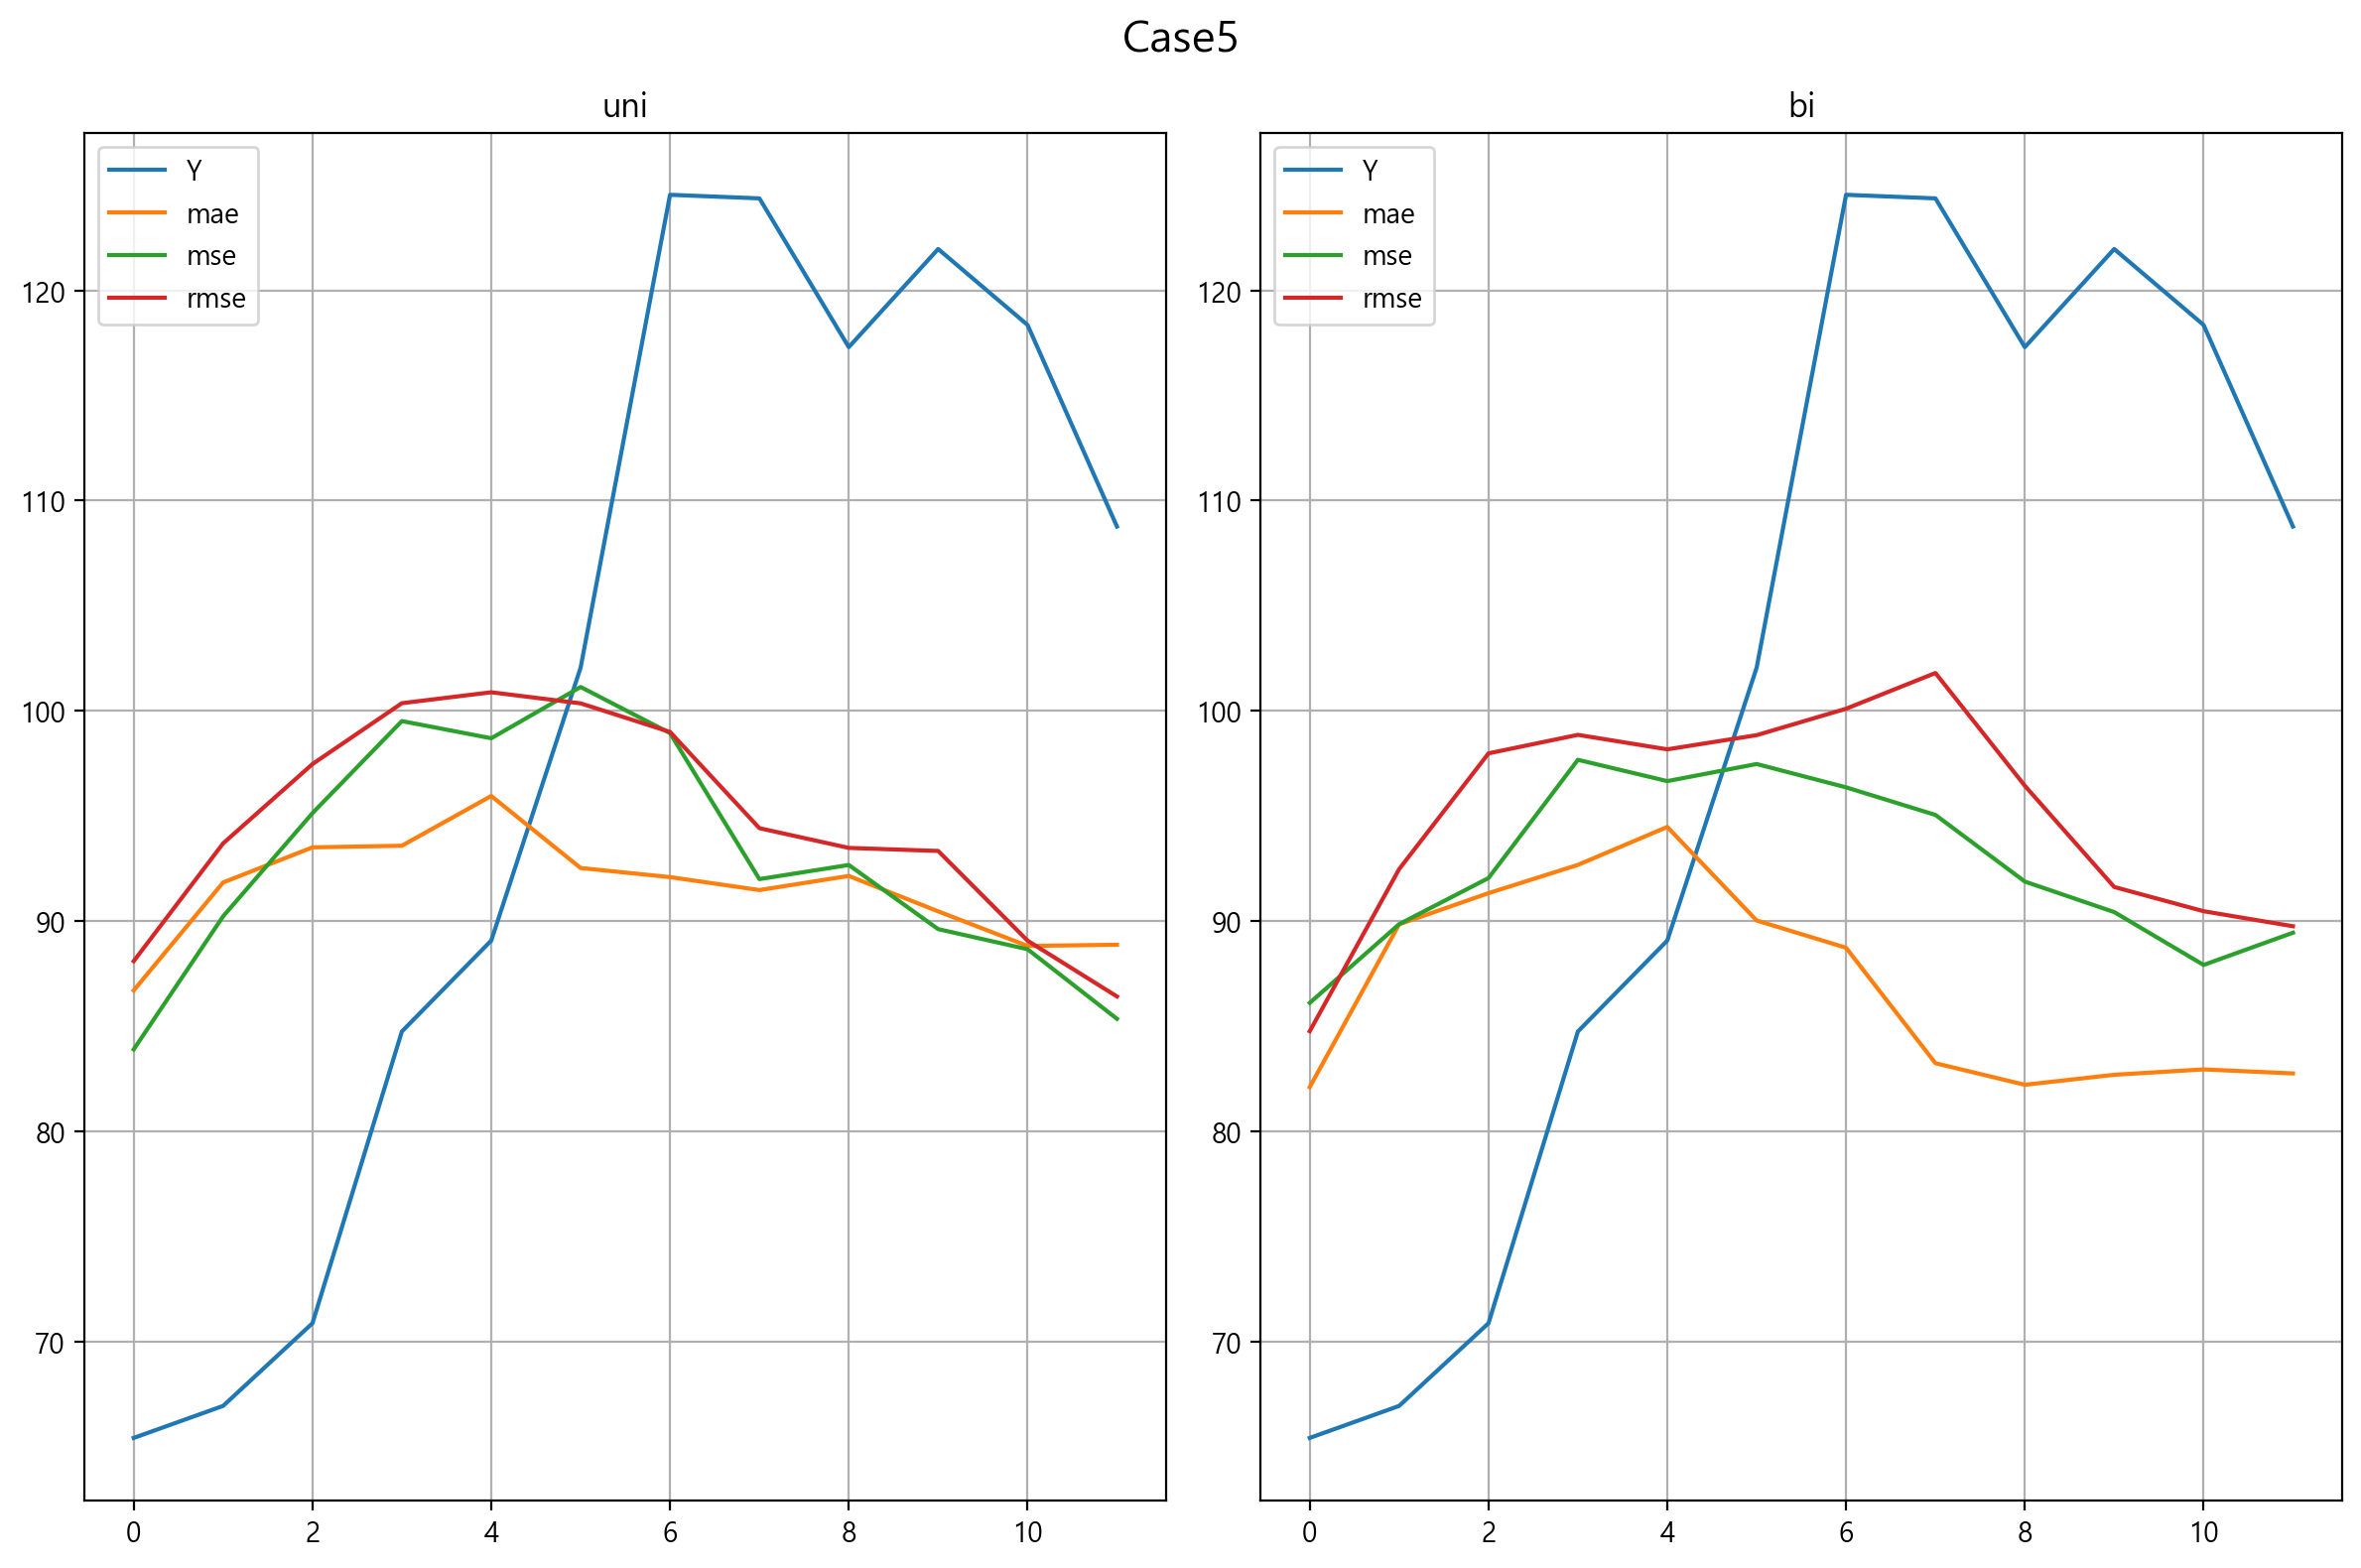

In [129]:
fig, ax = plt.subplots(1, 2, figsize=(12, 8))

ax[0].plot(Y_compare3, label="Y")
ax[0].plot(Y_HAT_case5_uni_mae[0], label="mae")
ax[0].plot(Y_HAT_case5_uni_mse[0], label="mse")
ax[0].plot(Y_HAT_case5_uni_rmse[0], label="rmse")
ax[0].set_title("uni", fontsize=12)
ax[0].grid()
ax[0].legend()

ax[1].plot(Y_compare3, label="Y")
ax[1].plot(Y_HAT_case5_bi_mae[0], label="mae")
ax[1].plot(Y_HAT_case5_bi_mse[0], label="mse")
ax[1].plot(Y_HAT_case5_bi_rmse[0], label="rmse")
ax[1].set_title("bi", fontsize=12)
ax[1].grid()
ax[1].legend()

plt.suptitle("Case5", fontsize=16)

plt.tight_layout()
plt.savefig(f'./output/case5_predict.png')

plt.show()

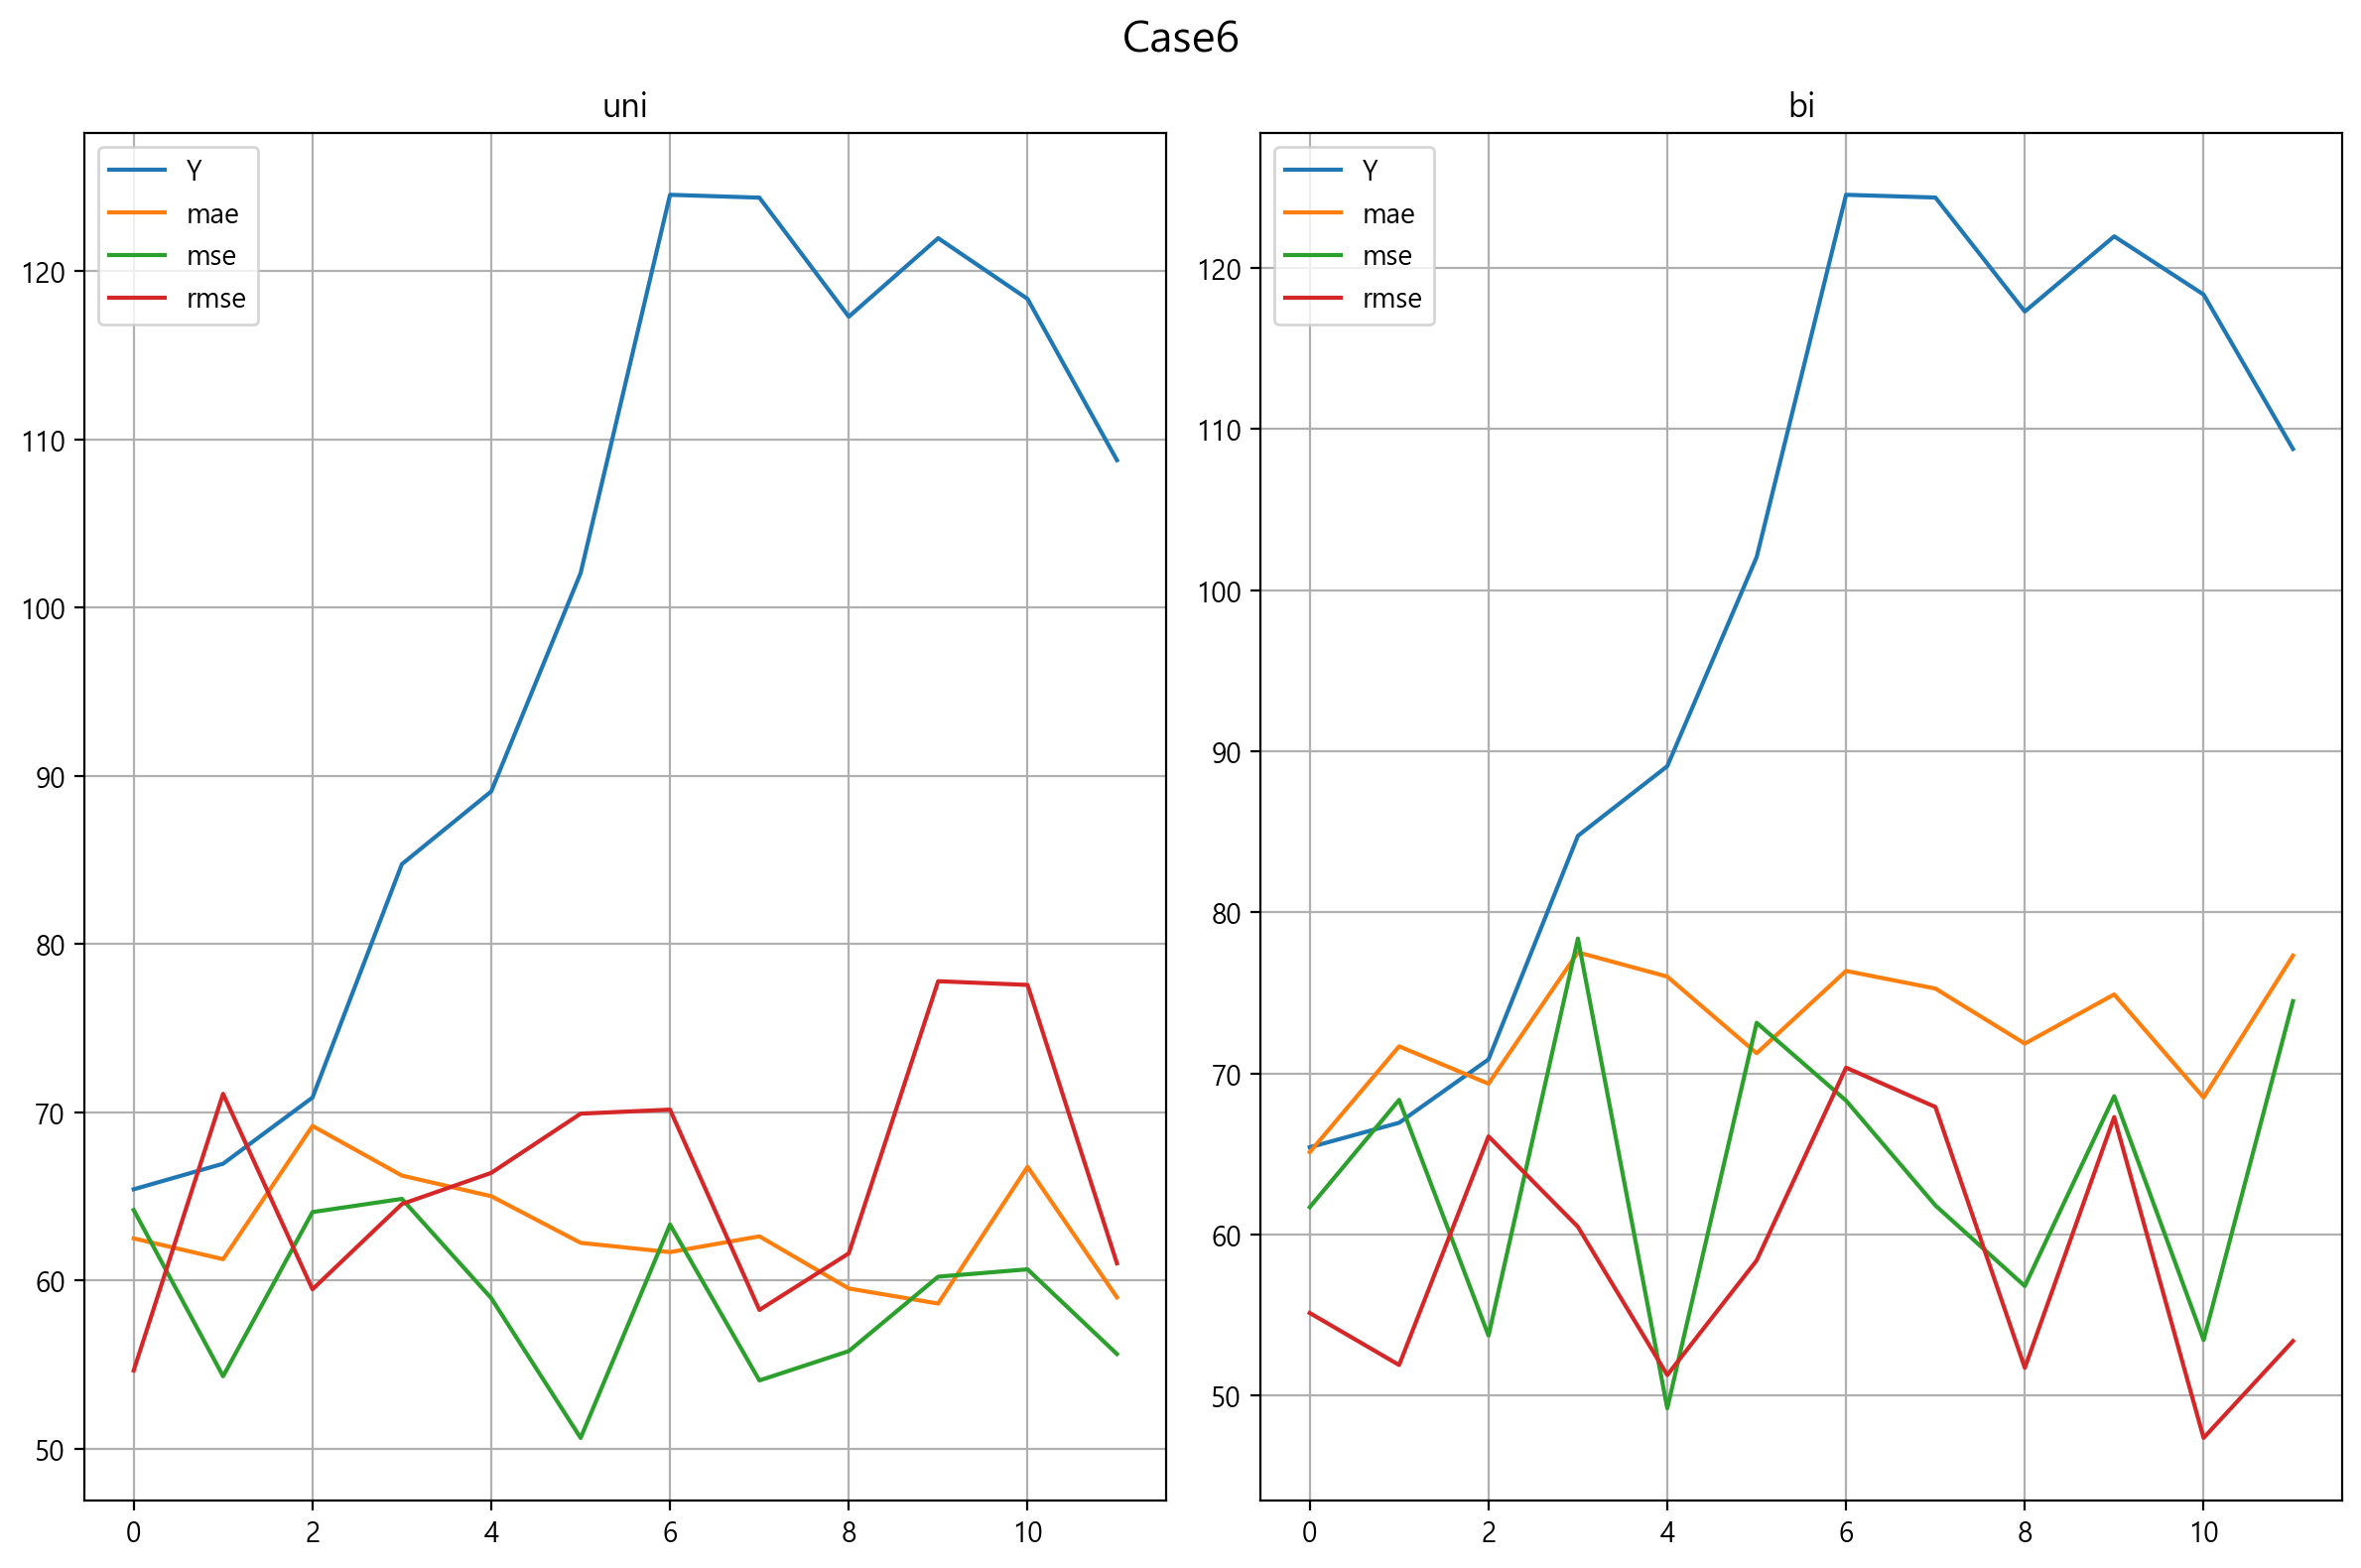

In [130]:
fig, ax = plt.subplots(1, 2, figsize=(12, 8))

ax[0].plot(Y_compare3, label="Y")
ax[0].plot(Y_HAT_case6_uni_mae[0], label="mae")
ax[0].plot(Y_HAT_case6_uni_mse[0], label="mse")
ax[0].plot(Y_HAT_case6_uni_rmse[0], label="rmse")
ax[0].set_title("uni", fontsize=12)
ax[0].grid()
ax[0].legend()

ax[1].plot(Y_compare3, label="Y")
ax[1].plot(Y_HAT_case6_bi_mae[0], label="mae")
ax[1].plot(Y_HAT_case6_bi_mse[0], label="mse")
ax[1].plot(Y_HAT_case6_bi_rmse[0], label="rmse")
ax[1].set_title("bi", fontsize=12)
ax[1].grid()
ax[1].legend()

plt.suptitle("Case6", fontsize=16)

plt.tight_layout()
plt.savefig(f'./output/case6_predict.png')

plt.show()

## 검증 데이터 오차 계산

In [131]:
def calculate_errors(y_true, y_pred):
    mae = np.mean(np.abs(y_true - y_pred), axis=1)
    mse = np.mean((y_true - y_pred)**2, axis=1)
    rmse = np.sqrt(mse)
    
    errors = {'mae': mae, 'mse': mse, 'rmse': rmse}
    
    return {k: np.mean(v) for k, v in errors.items()}

### case1

In [144]:
case1_uni_mae_test = case1_uni_mae.predict([x_test_case1, x_test_case1_label])
case1_uni_mse_test = case1_uni_mse.predict([x_test_case1, x_test_case1_label])
case1_uni_rmse_test = case1_uni_rmse.predict([x_test_case1, x_test_case1_label])

case1_bi_mae_test = case1_bi_mae.predict([x_test_case1, x_test_case1_label])
case1_bi_mse_test = case1_bi_mse.predict([x_test_case1, x_test_case1_label])
case1_bi_rmse_test = case1_bi_rmse.predict([x_test_case1, x_test_case1_label])

case1_errors = {
    'case1_uni_mae': calculate_errors(y_test_case1, case1_uni_mae_test),
    'case1_uni_mse': calculate_errors(y_test_case1, case1_uni_mse_test),
    'case1_uni_rmse': calculate_errors(y_test_case1, case1_uni_rmse_test),
    'case1_bi_mae': calculate_errors(y_test_case1, case1_bi_mae_test),
    'case1_bi_mse': calculate_errors(y_test_case1, case1_bi_mse_test),
    'case1_bi_rmse': calculate_errors(y_test_case1, case1_bi_rmse_test)
}

case1_df = pd.DataFrame.from_dict(case1_errors, orient='index')

# ---------------------------------------------------------------
y_test_case1_inverse = y_test_case1 * case1_std[-1] + case1_mean[-1]

case1_uni_mae_test_inverse = case1_uni_mae_test * case1_std[-1] + case1_mean[-1]
case1_uni_mse_test_inverse = case1_uni_mse_test * case1_std[-1] + case1_mean[-1]
case1_uni_rmse_test_inverse = case1_uni_rmse_test * case1_std[-1] + case1_mean[-1]

case1_bi_mae_test_inverse = case1_bi_mae_test * case1_std[-1] + case1_mean[-1]
case1_bi_mse_test_inverse = case1_bi_mse_test * case1_std[-1] + case1_mean[-1]
case1_bi_rmse_test_inverse = case1_bi_rmse_test * case1_std[-1] + case1_mean[-1]

case1_errors_inverse = {
    'case1_uni_mae': calculate_errors(y_test_case1_inverse, case1_uni_mae_test_inverse),
    'case1_uni_mse': calculate_errors(y_test_case1_inverse, case1_uni_mse_test_inverse),
    'case1_uni_rmse': calculate_errors(y_test_case1_inverse, case1_uni_rmse_test_inverse),
    'case1_bi_mae': calculate_errors(y_test_case1_inverse, case1_bi_mae_test_inverse),
    'case1_bi_mse': calculate_errors(y_test_case1_inverse, case1_bi_mse_test_inverse),
    'case1_bi_rmse': calculate_errors(y_test_case1_inverse, case1_bi_rmse_test_inverse)
}

case1_df_inverse = pd.DataFrame.from_dict(case1_errors_inverse, orient='index')

1/1 [==============================] - 0s 23ms/step


### case2

In [162]:
case2_uni_mae_test = case2_uni_mae.predict([x_test_case2, x_test_case2_label])
case2_uni_mse_test = case2_uni_mse.predict([x_test_case2, x_test_case2_label])
case2_uni_rmse_test = case2_uni_rmse.predict([x_test_case2, x_test_case2_label])

case2_bi_mae_test = case2_bi_mae.predict([x_test_case2, x_test_case2_label])
case2_bi_mse_test = case2_bi_mse.predict([x_test_case2, x_test_case2_label])
case2_bi_rmse_test = case2_bi_rmse.predict([x_test_case2, x_test_case2_label])

case2_errors = {
    'case2_uni_mae': calculate_errors(y_test_case2, case2_uni_mae_test),
    'case2_uni_mse': calculate_errors(y_test_case2, case2_uni_mse_test),
    'case2_uni_rmse': calculate_errors(y_test_case2, case2_uni_rmse_test),
    'case2_bi_mae': calculate_errors(y_test_case2, case2_bi_mae_test),
    'case2_bi_mse': calculate_errors(y_test_case2, case2_bi_mse_test),
    'case2_bi_rmse': calculate_errors(y_test_case2, case2_bi_rmse_test)
}

case2_df = pd.DataFrame.from_dict(case2_errors, orient='index')

# --------------------------------------------------------------------
y_test_case2_inverse = np.sign(y_test_case2) * (np.expm1(np.abs(y_test_case2)))

case2_uni_mae_test_inverse = np.sign(case2_uni_mae_test) * (np.expm1(np.abs(case2_uni_mae_test)))
case2_uni_mse_test_inverse = np.sign(case2_uni_mse_test) * (np.expm1(np.abs(case2_uni_mse_test)))
case2_uni_rmse_test_inverse = np.sign(case2_uni_rmse_test) * (np.expm1(np.abs(case2_uni_rmse_test)))

case2_bi_mae_test_inverse = np.sign(case2_bi_mae_test) * (np.expm1(np.abs(case2_bi_mae_test)))
case2_bi_mse_test_inverse = np.sign(case2_bi_mse_test) * (np.expm1(np.abs(case2_bi_mse_test)))
case2_bi_rmse_test_inverse = np.sign(case2_bi_rmse_test) * (np.expm1(np.abs(case2_bi_rmse_test)))

case2_errors_inverse = {
    'case2_uni_mae': calculate_errors(y_test_case2_inverse, case2_uni_mae_test_inverse),
    'case2_uni_mse': calculate_errors(y_test_case2_inverse, case2_uni_mse_test_inverse),
    'case2_uni_rmse': calculate_errors(y_test_case2_inverse, case2_uni_rmse_test_inverse),
    'case2_bi_mae': calculate_errors(y_test_case2_inverse, case2_bi_mae_test_inverse),
    'case2_bi_mse': calculate_errors(y_test_case2_inverse, case2_bi_mse_test_inverse),
    'case2_bi_rmse': calculate_errors(y_test_case2_inverse, case2_bi_rmse_test_inverse)
}

case2_df_inverse = pd.DataFrame.from_dict(case2_errors_inverse, orient='index')

1/1 [==============================] - 0s 24ms/step


### case3

In [147]:
case3_uni_mae_test = case3_uni_mae.predict([x_test_case3, x_test_case3_label])
case3_uni_mse_test = case3_uni_mse.predict([x_test_case3, x_test_case3_label])
case3_uni_rmse_test = case3_uni_rmse.predict([x_test_case3, x_test_case3_label])

case3_bi_mae_test = case3_bi_mae.predict([x_test_case3, x_test_case3_label])
case3_bi_mse_test = case3_bi_mse.predict([x_test_case3, x_test_case3_label])
case3_bi_rmse_test = case3_bi_rmse.predict([x_test_case3, x_test_case3_label])

case3_errors = {
    'case3_uni_mae': calculate_errors(y_test_case3, case3_uni_mae_test),
    'case3_uni_mse': calculate_errors(y_test_case3, case3_uni_mse_test),
    'case3_uni_rmse': calculate_errors(y_test_case3, case3_uni_rmse_test),
    'case3_bi_mae': calculate_errors(y_test_case3, case3_bi_mae_test),
    'case3_bi_mse': calculate_errors(y_test_case3, case3_bi_mse_test),
    'case3_bi_rmse': calculate_errors(y_test_case3, case3_bi_rmse_test)
}
case3_df = pd.DataFrame.from_dict(case3_errors, orient='index')

# ---------------------------------------------------------------
y_test_case3_inverse = y_test_case3 * case3_std[-1] + case3_mean[-1]

case3_uni_mae_test_inverse = case3_uni_mae_test * case3_std[-1] + case3_mean[-1]
case3_uni_mse_test_inverse = case3_uni_mse_test * case3_std[-1] + case3_mean[-1]
case3_uni_rmse_test_inverse = case3_uni_rmse_test * case3_std[-1] + case3_mean[-1]

case3_bi_mae_test_inverse = case3_bi_mae_test * case3_std[-1] + case3_mean[-1]
case3_bi_mse_test_inverse = case3_bi_mse_test * case3_std[-1] + case3_mean[-1]
case3_bi_rmse_test_inverse = case3_bi_rmse_test * case3_std[-1] + case3_mean[-1]

case3_errors_inverse = {
    'case3_uni_mae': calculate_errors(y_test_case3_inverse, case3_uni_mae_test_inverse),
    'case3_uni_mse': calculate_errors(y_test_case3_inverse, case3_uni_mse_test_inverse),
    'case3_uni_rmse': calculate_errors(y_test_case3_inverse, case3_uni_rmse_test_inverse),
    'case3_bi_mae': calculate_errors(y_test_case3_inverse, case3_bi_mae_test_inverse),
    'case3_bi_mse': calculate_errors(y_test_case3_inverse, case3_bi_mse_test_inverse),
    'case3_bi_rmse': calculate_errors(y_test_case3_inverse, case3_bi_rmse_test_inverse)
}

case3_df_inverse = pd.DataFrame.from_dict(case3_errors_inverse, orient='index')

1/1 [==============================] - 0s 23ms/step


### case4

In [163]:
case4_uni_mae_test = case4_uni_mae.predict([x_test_case4, x_test_case4_label])
case4_uni_mse_test = case4_uni_mse.predict([x_test_case4, x_test_case4_label])
case4_uni_rmse_test = case4_uni_rmse.predict([x_test_case4, x_test_case4_label])
case4_bi_mae_test = case4_bi_mae.predict([x_test_case4, x_test_case4_label])
case4_bi_mse_test = case4_bi_mse.predict([x_test_case4, x_test_case4_label])
case4_bi_rmse_test = case4_bi_rmse.predict([x_test_case4, x_test_case4_label])
case4_errors = {
    'case4_uni_mae': calculate_errors(y_test_case4, case4_uni_mae_test),
    'case4_uni_mse': calculate_errors(y_test_case4, case4_uni_mse_test),
    'case4_uni_rmse': calculate_errors(y_test_case4, case4_uni_rmse_test),
    'case4_bi_mae': calculate_errors(y_test_case4, case4_bi_mae_test),
    'case4_bi_mse': calculate_errors(y_test_case4, case4_bi_mse_test),
    'case4_bi_rmse': calculate_errors(y_test_case4, case4_bi_rmse_test)
}
case4_df = pd.DataFrame.from_dict(case4_errors, orient='index')
# --------------------------------------------------------------------
y_test_case4_inverse = np.sign(y_test_case4) * (np.expm1(np.abs(y_test_case4)))
case4_uni_mae_test_inverse = np.sign(case4_uni_mae_test) * (np.expm1(np.abs(case4_uni_mae_test)))
case4_uni_mse_test_inverse = np.sign(case4_uni_mse_test) * (np.expm1(np.abs(case4_uni_mse_test)))
case4_uni_rmse_test_inverse = np.sign(case4_uni_rmse_test) * (np.expm1(np.abs(case4_uni_rmse_test)))
case4_bi_mae_test_inverse = np.sign(case4_bi_mae_test) * (np.expm1(np.abs(case4_bi_mae_test)))
case4_bi_mse_test_inverse = np.sign(case4_bi_mse_test) * (np.expm1(np.abs(case4_bi_mse_test)))
case4_bi_rmse_test_inverse = np.sign(case4_bi_rmse_test) * (np.expm1(np.abs(case4_bi_rmse_test)))
case4_errors_inverse = {
    'case4_uni_mae': calculate_errors(y_test_case4_inverse, case4_uni_mae_test_inverse),
    'case4_uni_mse': calculate_errors(y_test_case4_inverse, case4_uni_mse_test_inverse),
    'case4_uni_rmse': calculate_errors(y_test_case4_inverse, case4_uni_rmse_test_inverse),
    'case4_bi_mae': calculate_errors(y_test_case4_inverse, case4_bi_mae_test_inverse),
    'case4_bi_mse': calculate_errors(y_test_case4_inverse, case4_bi_mse_test_inverse),
    'case4_bi_rmse': calculate_errors(y_test_case4_inverse, case4_bi_rmse_test_inverse)
}
case4_df_inverse = pd.DataFrame.from_dict(case4_errors_inverse, orient='index')

1/1 [==============================] - 0s 21ms/step


### case5

In [149]:
case5_uni_mae_test = case5_uni_mae.predict([x_test_case5, x_test_case5_label])
case5_uni_mse_test = case5_uni_mse.predict([x_test_case5, x_test_case5_label])
case5_uni_rmse_test = case5_uni_rmse.predict([x_test_case5, x_test_case5_label])

case5_bi_mae_test = case5_bi_mae.predict([x_test_case5, x_test_case5_label])
case5_bi_mse_test = case5_bi_mse.predict([x_test_case5, x_test_case5_label])
case5_bi_rmse_test = case5_bi_rmse.predict([x_test_case5, x_test_case5_label])

case5_errors = {
    'case5_uni_mae': calculate_errors(y_test_case5, case5_uni_mae_test),
    'case5_uni_mse': calculate_errors(y_test_case5, case5_uni_mse_test),
    'case5_uni_rmse': calculate_errors(y_test_case5, case5_uni_rmse_test),
    'case5_bi_mae': calculate_errors(y_test_case5, case5_bi_mae_test),
    'case5_bi_mse': calculate_errors(y_test_case5, case5_bi_mse_test),
    'case5_bi_rmse': calculate_errors(y_test_case5, case5_bi_rmse_test)
}

case5_df = pd.DataFrame.from_dict(case5_errors, orient='index')

# ---------------------------------------------------------------
y_test_case5_inverse = y_test_case5 * case5_std[-1] + case5_mean[-1]

case5_uni_mae_test_inverse = case5_uni_mae_test * case5_std[-1] + case5_mean[-1]
case5_uni_mse_test_inverse = case5_uni_mse_test * case5_std[-1] + case5_mean[-1]
case5_uni_rmse_test_inverse = case5_uni_rmse_test * case5_std[-1] + case5_mean[-1]

case5_bi_mae_test_inverse = case5_bi_mae_test * case5_std[-1] + case5_mean[-1]
case5_bi_mse_test_inverse = case5_bi_mse_test * case5_std[-1] + case5_mean[-1]
case5_bi_rmse_test_inverse = case5_bi_rmse_test * case5_std[-1] + case5_mean[-1]

case5_errors_inverse = {
    'case5_uni_mae': calculate_errors(y_test_case5_inverse, case5_uni_mae_test_inverse),
    'case5_uni_mse': calculate_errors(y_test_case5_inverse, case5_uni_mse_test_inverse),
    'case5_uni_rmse': calculate_errors(y_test_case5_inverse, case5_uni_rmse_test_inverse),
    'case5_bi_mae': calculate_errors(y_test_case5_inverse, case5_bi_mae_test_inverse),
    'case5_bi_mse': calculate_errors(y_test_case5_inverse, case5_bi_mse_test_inverse),
    'case5_bi_rmse': calculate_errors(y_test_case5_inverse, case5_bi_rmse_test_inverse)
}

case5_df_inverse = pd.DataFrame.from_dict(case5_errors_inverse, orient='index')

1/1 [==============================] - 0s 24ms/step


### case6

In [164]:
case6_uni_mae_test = case6_uni_mae.predict([x_test_case6, x_test_case6_label])
case6_uni_mse_test = case6_uni_mse.predict([x_test_case6, x_test_case6_label])
case6_uni_rmse_test = case6_uni_rmse.predict([x_test_case6, x_test_case6_label])
case6_bi_mae_test = case6_bi_mae.predict([x_test_case6, x_test_case6_label])
case6_bi_mse_test = case6_bi_mse.predict([x_test_case6, x_test_case6_label])
case6_bi_rmse_test = case6_bi_rmse.predict([x_test_case6, x_test_case6_label])
case6_errors = {
    'case6_uni_mae': calculate_errors(y_test_case6, case6_uni_mae_test),
    'case6_uni_mse': calculate_errors(y_test_case6, case6_uni_mse_test),
    'case6_uni_rmse': calculate_errors(y_test_case6, case6_uni_rmse_test),
    'case6_bi_mae': calculate_errors(y_test_case6, case6_bi_mae_test),
    'case6_bi_mse': calculate_errors(y_test_case6, case6_bi_mse_test),
    'case6_bi_rmse': calculate_errors(y_test_case6, case6_bi_rmse_test)
}
case6_df = pd.DataFrame.from_dict(case6_errors, orient='index')
# --------------------------------------------------------------------
y_test_case6_inverse = np.sign(y_test_case6) * (np.expm1(np.abs(y_test_case6)))
case6_uni_mae_test_inverse = np.sign(case6_uni_mae_test) * (np.expm1(np.abs(case6_uni_mae_test)))
case6_uni_mse_test_inverse = np.sign(case6_uni_mse_test) * (np.expm1(np.abs(case6_uni_mse_test)))
case6_uni_rmse_test_inverse = np.sign(case6_uni_rmse_test) * (np.expm1(np.abs(case6_uni_rmse_test)))
case6_bi_mae_test_inverse = np.sign(case6_bi_mae_test) * (np.expm1(np.abs(case6_bi_mae_test)))
case6_bi_mse_test_inverse = np.sign(case6_bi_mse_test) * (np.expm1(np.abs(case6_bi_mse_test)))
case6_bi_rmse_test_inverse = np.sign(case6_bi_rmse_test) * (np.expm1(np.abs(case6_bi_rmse_test)))
case6_errors_inverse = {
    'case6_uni_mae': calculate_errors(y_test_case6_inverse, case6_uni_mae_test_inverse),
    'case6_uni_mse': calculate_errors(y_test_case6_inverse, case6_uni_mse_test_inverse),
    'case6_uni_rmse': calculate_errors(y_test_case6_inverse, case6_uni_rmse_test_inverse),
    'case6_bi_mae': calculate_errors(y_test_case6_inverse, case6_bi_mae_test_inverse),
    'case6_bi_mse': calculate_errors(y_test_case6_inverse, case6_bi_mse_test_inverse),
    'case6_bi_rmse': calculate_errors(y_test_case6_inverse, case6_bi_rmse_test_inverse)
}
case6_df_inverse = pd.DataFrame.from_dict(case6_errors_inverse, orient='index')

1/1 [==============================] - 0s 20ms/step


### DataFrame으로 모아보기

In [165]:
# 표준화 case
std_df = pd.concat([case1_df, case3_df, case5_df], axis = 0)
std_df.to_csv("./output/standard_error.csv", encoding="utf-8-sig")

# 로그변환 case
log_df = pd.concat([case2_df, case4_df, case6_df], axis = 0)
log_df.to_csv("./output/log_error.csv", encoding="utf-8-sig")

# 역변환 후 전체 case
total_df = pd.concat([case1_df_inverse, 
                      case2_df_inverse, 
                      case3_df_inverse, 
                      case4_df_inverse, 
                      case5_df_inverse, 
                      case6_df_inverse], 
                     axis = 0)

total_df.to_csv("./output/total_error.csv", encoding="utf-8-sig")

#### mae

In [166]:
df1_mae = std_df[['mae']].rename(columns={'mae': 'standardized'})
df2_mae = log_df[['mae']].rename(columns={'mae': 'log_transform'})
df3_mae = total_df[['mae']].rename(columns={'mae': 'actual_scale'})

df_combined = pd.concat([df1_mae, df2_mae, df3_mae], axis=1)

for col in df_combined.columns:
    df_combined[f'{col}_rank'] = df_combined[col].rank()

rank_columns = [col for col in df_combined.columns if col.endswith('_rank')]
df_combined['avg_rank'] = df_combined[rank_columns].mean(axis=1)

df_result = df_combined.sort_values('avg_rank')

display(df_result)

mae_top10 = df_result.index[:10]

df_result.to_csv("./output/error_rank_mae.csv", encoding="utf-8-sig")

standardized  log_transform  actual_scale  standardized_rank  \
case1_uni_mae       0.912075            NaN     12.654601                1.0   
case5_uni_mae       0.922433            NaN     12.798318                2.0   
case6_bi_mae             NaN       0.162814     13.062044                NaN   
case5_bi_rmse       0.936855            NaN     12.998413                3.0   
case1_uni_rmse      0.949572            NaN     13.174859                4.0   
case1_bi_rmse       0.955200            NaN     13.252942                5.0   
case5_uni_mse       0.956324            NaN     13.268542                6.0   
case3_bi_rmse       0.958046            NaN     13.292439                7.0   
case5_uni_rmse      0.958283            NaN     13.295715                8.0   
case5_bi_mae        0.965390            NaN     13.394327                9.0   
case5_bi_mse        0.966858            NaN     13.414699               10.0   
case4_bi_mae             NaN       0.179321     14.176972                NaN   
case1_bi_mae        0.968877            NaN     13.442705               11.0   
case4_bi_rmse            NaN       0.191112     14.967074                NaN   
case1_bi_mse        0.969661            NaN     13.453584               12.0   
case2_uni_mae            NaN       0.193142     15.171591                NaN   
case3_uni_mae       0.972893            NaN     13.498429               13.0   
case6_uni_rmse           NaN       0.199652     15.305381                NaN   
case3_uni_rmse      0.973270            NaN     13.503661               14.0   
case2_bi_rmse            NaN       0.203840     15.696091                NaN   
case3_bi_mse        0.978657            NaN     13.578399               15.0   
case6_uni_mae            NaN       0.204721     15.776270                NaN   
case1_uni_mse       0.986018            NaN     13.680526               16.0   
case2_uni_mse            NaN       0.207893     15.848623                NaN   
case3_uni_mse       1.000809            NaN     13.885750               17.0   
case2_bi_mae             NaN       0.210637     16.088048                NaN   
case3_bi_mae        1.009745            NaN     14.009730               18.0   
case4_uni_mse            NaN       0.218770     16.529759                NaN   
case4_bi_mse             NaN       0.218935     16.663224                NaN   
case2_bi_mse             NaN       0.222769     16.801209                NaN   
case6_bi_mse             NaN       0.229153     17.040059                NaN   
case6_uni_mse            NaN       0.245553     18.197112                NaN   
case6_bi_rmse            NaN       0.257181     18.919806                NaN   
case4_uni_rmse           NaN       0.261292     19.093213                NaN   
case2_uni_rmse           NaN       0.280521     20.144539                NaN   
case4_uni_mae            NaN       0.289545     20.805128                NaN   

                log_transform_rank  actual_scale_rank  avg_rank  
case1_uni_mae                  NaN                1.0       1.0  
case5_uni_mae                  NaN                2.0       2.0  
case6_bi_mae                   1.0                4.0       2.5  
case5_bi_rmse                  NaN                3.0       3.0  
case1_uni_rmse                 NaN                5.0       4.5  
case1_bi_rmse                  NaN                6.0       5.5  
case5_uni_mse                  NaN                7.0       6.5  
case3_bi_rmse                  NaN                8.0       7.5  
case5_uni_rmse                 NaN                9.0       8.5  
case5_bi_mae                   NaN               10.0       9.5  
case5_bi_mse                   NaN               11.0      10.5  
case4_bi_mae                   2.0               20.0      11.0  
case1_bi_mae                   NaN               12.0      11.5  
case4_bi_rmse                  3.0               21.0      12.0  
case1_bi_mse                   NaN               13.0      12.5  

#### mse

In [167]:
df1_mse = std_df[['mse']].rename(columns={'mse': 'standardized'})
df2_mse = log_df[['mse']].rename(columns={'mse': 'log_transform'})
df3_mse = total_df[['mse']].rename(columns={'mse': 'actual_scale'})

df_combined = pd.concat([df1_mse, df2_mse, df3_mse], axis=1)

for col in df_combined.columns:
    df_combined[f'{col}_rank'] = df_combined[col].rank()

rank_columns = [col for col in df_combined.columns if col.endswith('_rank')]
df_combined['avg_rank'] = df_combined[rank_columns].mean(axis=1)

df_result = df_combined.sort_values('avg_rank')

display(df_result)

mse_top10 = df_result.index[:10]

df_result.to_csv("./output/error_rank_mse.csv", encoding="utf-8-sig")

standardized  log_transform  actual_scale  standardized_rank  \
case5_uni_mae       1.311295            NaN    252.427431                1.0   
case5_bi_rmse       1.333620            NaN    256.724972                2.0   
case1_uni_mae       1.383235            NaN    266.276070                3.0   
case5_bi_mse        1.400988            NaN    269.693642                4.0   
case5_uni_mse       1.404830            NaN    270.433208                5.0   
case1_bi_mse        1.420993            NaN    273.544513                6.0   
case5_uni_rmse      1.433673            NaN    275.985550                7.0   
case1_uni_rmse      1.439124            NaN    277.034915                8.0   
case3_bi_rmse       1.441676            NaN    277.526099                9.0   
case3_uni_mae       1.447006            NaN    278.552163               10.0   
case6_bi_mae             NaN       0.043002    318.561763                NaN   
case4_bi_mae             NaN       0.054925    391.141181                NaN   
case3_uni_rmse      1.458502            NaN    280.765091               11.0   
case1_uni_mse       1.471079            NaN    283.186239               12.0   
case4_bi_rmse            NaN       0.061326    426.107423                NaN   
case1_bi_rmse       1.473281            NaN    283.610082               13.0   
case6_uni_rmse           NaN       0.068609    452.884354                NaN   
case3_bi_mse        1.483734            NaN    285.622325               14.0   
case2_uni_mae            NaN       0.070542    482.706659                NaN   
case2_bi_rmse            NaN       0.071346    479.746834                NaN   
case3_uni_mse       1.497897            NaN    288.348698               15.0   
case3_bi_mae        1.507913            NaN    290.276869               16.0   
case2_uni_mse            NaN       0.075186    486.055166                NaN   
case5_bi_mae        1.516191            NaN    291.870443               17.0   
case2_bi_mae             NaN       0.075188    493.297914                NaN   
case6_uni_mae            NaN       0.075087    507.372992                NaN   
case1_bi_mae        1.532099            NaN    294.932791               18.0   
case4_uni_mse            NaN       0.078344    503.380152                NaN   
case4_bi_mse             NaN       0.083117    546.286654                NaN   
case6_bi_mse             NaN       0.087472    536.512452                NaN   
case2_bi_mse             NaN       0.088722    563.033568                NaN   
case6_uni_mse            NaN       0.098199    608.547095                NaN   
case6_bi_rmse            NaN       0.104318    633.500367                NaN   
case2_uni_rmse           NaN       0.117704    668.940569                NaN   
case4_uni_rmse           NaN       0.114091    675.020932                NaN   
case4_uni_mae            NaN       0.121827    700.421876                NaN   

                log_transform_rank  actual_scale_rank  avg_rank  
case5_uni_mae                  NaN                1.0       1.0  
case5_bi_rmse                  NaN                2.0       2.0  
case1_uni_mae                  NaN                3.0       3.0  
case5_bi_mse                   NaN                4.0       4.0  
case5_uni_mse                  NaN                5.0       5.0  
case1_bi_mse                   NaN                6.0       6.0  
case5_uni_rmse                 NaN                7.0       7.0  
case1_uni_rmse                 NaN                8.0       8.0  
case3_bi_rmse                  NaN                9.0       9.0  
case3_uni_mae                  NaN               10.0      10.0  
case6_bi_mae                   1.0               19.0      10.0  
case4_bi_mae                   2.0               20.0      11.0  
case3_uni_rmse                 NaN               11.0      11.0  
case1_uni_mse                  NaN               12.0      12.0  
case4_bi_rmse                  3.0               21.0      12.0  

#### rmse

In [168]:
df1_rmse = std_df[['rmse']].rename(columns={'rmse': 'standardized'})
df2_rmse = log_df[['rmse']].rename(columns={'rmse': 'log_transform'})
df3_rmse = total_df[['rmse']].rename(columns={'rmse': 'actual_scale'})

df_combined = pd.concat([df1_rmse, df2_rmse, df3_rmse], axis=1)

for col in df_combined.columns:
    df_combined[f'{col}_rank'] = df_combined[col].rank()

rank_columns = [col for col in df_combined.columns if col.endswith('_rank')]
df_combined['avg_rank'] = df_combined[rank_columns].mean(axis=1)

df_result = df_combined.sort_values('avg_rank')

display(df_result)

rmse_top10 = df_result.index[:10]

df_result.to_csv("./output/error_rank_rmse.csv", encoding="utf-8-sig")

standardized  log_transform  actual_scale  standardized_rank  \
case5_uni_mae       1.103823            NaN     15.315017                1.0   
case5_bi_rmse       1.112676            NaN     15.437845                2.0   
case1_uni_mae       1.122197            NaN     15.569942                3.0   
case5_uni_mse       1.135363            NaN     15.752622                4.0   
case5_uni_rmse      1.141606            NaN     15.839239                5.0   
case1_bi_mse        1.145304            NaN     15.890541                6.0   
case6_bi_mae             NaN       0.196154     16.180187                NaN   
case1_uni_rmse      1.145549            NaN     15.893948                7.0   
case5_bi_mse        1.148534            NaN     15.935367                8.0   
case1_bi_rmse       1.161139            NaN     16.110247                9.0   
case3_bi_rmse       1.163395            NaN     16.141551               10.0   
case4_bi_mae             NaN       0.217153     17.685169                NaN   
case3_uni_rmse      1.166509            NaN     16.184762               11.0   
case4_bi_rmse            NaN       0.233299     18.788590                NaN   
case1_uni_mse       1.169975            NaN     16.232850               12.0   
case2_uni_mae            NaN       0.245187     19.681630                NaN   
case6_uni_rmse           NaN       0.248609     19.576478                NaN   
case3_uni_mae       1.173288            NaN     16.278817               13.0   
case1_bi_mae        1.174795            NaN     16.299728               14.0   
case2_bi_rmse            NaN       0.252681     20.071256                NaN   
case2_uni_mse            NaN       0.254953     19.876833                NaN   
case5_bi_mae        1.176868            NaN     16.328489               15.0   
case3_bi_mse        1.184040            NaN     16.427998               16.0   
case6_uni_mae            NaN       0.255339     20.348228                NaN   
case3_bi_mae        1.193026            NaN     16.552670               17.0   
case2_bi_mae             NaN       0.262169     20.604677                NaN   
case3_uni_mse       1.196846            NaN     16.605663               18.0   
case4_uni_mse            NaN       0.266013     20.680304                NaN   
case4_bi_mse             NaN       0.271521     21.350154                NaN   
case2_bi_mse             NaN       0.281952     21.769004                NaN   
case6_bi_mse             NaN       0.283438     21.469856                NaN   
case6_uni_mse            NaN       0.295595     22.605879                NaN   
case4_uni_rmse           NaN       0.309443     23.251411                NaN   
case6_bi_rmse            NaN       0.311044     23.616003                NaN   
case2_uni_rmse           NaN       0.329117     24.254857                NaN   
case4_uni_mae            NaN       0.340400     25.225730                NaN   

                log_transform_rank  actual_scale_rank  avg_rank  
case5_uni_mae                  NaN                1.0       1.0  
case5_bi_rmse                  NaN                2.0       2.0  
case1_uni_mae                  NaN                3.0       3.0  
case5_uni_mse                  NaN                4.0       4.0  
case5_uni_rmse                 NaN                5.0       5.0  
case1_bi_mse                   NaN                6.0       6.0  
case6_bi_mae                   1.0               11.0       6.0  
case1_uni_rmse                 NaN                7.0       7.0  
case5_bi_mse                   NaN                8.0       8.0  
case1_bi_rmse                  NaN                9.0       9.0  
case3_bi_rmse                  NaN               10.0      10.0  
case4_bi_mae                   2.0               20.0      11.0  
case3_uni_rmse                 NaN               12.0      11.5  
case4_bi_rmse                  3.0               21.0      12.0  
case1_uni_mse                  NaN               13.0      12.5  

## 모델 선정

In [169]:
# final_predict = data[['WTIO', 'SETIO', 'ONI', 'SOI', 'ENSO', 'D20_SCTR']]
# final_predict_dts = final_predict.values

# final_predict_label = final_predict_dts[ : , 4]
# final_predict_dts = final_predict_dts[ : , [0, 1, 2, 3, 5]]

# # 학습데이터
# final_predict_dts = final_predict_dts[388 : 400, :]
# final_predict_label = np.reshape(final_predict_label[388 : 400], (1, 12))

# ## 표준화
# final_predict_dts = (final_predict_dts - case1_mean)/case1_std
# final_predict_dts = np.reshape(final_predict_dts, (1, 12, 5))

In [170]:
# final_case1_bi_mae = case1_bi_mae.predict([final_predict_dts, final_predict_label])
# final_case1_bi_mae = final_case1_bi_mae * case1_std[-1] + case1_mean[-1]

# final_case1_bi_mse = case1_bi_mse.predict([final_predict_dts, final_predict_label])
# final_case1_bi_mse = final_case1_bi_mse * case1_std[-1] + case1_mean[-1]

# final_case1_bi_rmse = case1_bi_rmse.predict([final_predict_dts, final_predict_label])
# final_case1_bi_rmse = final_case1_bi_rmse * case1_std[-1] + case1_mean[-1]

In [171]:
# date_range = pd.date_range("2024-05-01", "2025-04-01", freq="MS")

# plt.figure(figsize=(10, 8))

# plt.plot(date_range, final_case1_bi_mae[0], label="case1_bi_mae", marker="o")
# plt.plot(date_range, final_case1_bi_mse[0], label="case1_bi_mse", marker="o")
# plt.plot(date_range, final_case1_bi_rmse[0], label="case1_bi_rmse", marker="o")

# plt.grid()
# plt.legend(fontsize = 10, fancybox=True, shadow=True, ncol=5)
# plt.title("2024.05 - 2025.04 SCTR 수온약층 지수 예측값")
# plt.xlabel("연도")
# plt.ylabel("D20")

# plt.tight_layout()
# plt.savefig(f'./output/2024_05_2025_04_예측.png')

# plt.show()

In [172]:
# temp = pd.DataFrame(final_case1_bi_mse[0], index = date_range, columns = ["D20_SCTR"])

# final_df = pd.concat([sctr, temp], axis = 0)

# final_df.to_csv("./output/D20_SCTR_예측값.csv", encoding="utf-8-sig")

In [173]:
# plt.figure(figsize=(15, 8))

# plt.plot(final_df["D20_SCTR"][:-12], label = "실제값", color="#3990cc")
# plt.plot(final_df["D20_SCTR"][-13:], label = "예측값", color="#f73e3e")

# plt.legend(fontsize=14, fancybox=True, shadow=True, ncol=5)
# plt.grid()
# plt.xlabel("연도")
# plt.ylabel("D20")

# plt.title("1991년 1월 ~ 2025년 4월 SCTR 지역 수온약층 깊이지수", fontsize = 18)

# plt.tight_layout()
# plt.savefig(f'./output/2024_05_2025_04_예측.png')

# plt.show()

In [174]:
# import matplotlib.dates as mdates

# plt.figure(figsize=(15, 8))

# plt.plot(final_df["D20_SCTR"][-124:-12], label = "실제값", marker = "o", markersize=3, color="#3990cc")
# plt.plot(final_df["D20_SCTR"][-13:], label = "예측값", marker = "o", markersize=3, color="#f73e3e")

# plt.legend(fontsize=14, fancybox=True, shadow=True, ncol=5)
# plt.grid()
# plt.xlabel("연도")
# plt.ylabel("D20")

# plt.title("2015년 1월 ~ 2025년 4월 SCTR 지역 수온약층 깊이지수", fontsize = 18)

# # x축 설정
# ax = plt.gca()
# ax.xaxis.set_major_locator(mdates.YearLocator())
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# plt.tight_layout()
# plt.savefig(f'./output/2015_01_2025_04_예측.png')

# plt.show()